# **Higgs detection in LHC: Machine Learning Analysis**
SN: 22048690

# Introduction

This code repository implements a **machine learning** approach to enhance the identification of Higgs boson events $H \to b\bar{b}$ in proton–proton collision data from the Large Hadron Collider (LHC). Traditional cut-based analyses, while transparent, often cannot fully exploit the complex, high-dimensional correlations among kinematic and topological variables. In contrast, **supervised neural networks** can learn nontrivial decision boundaries, thereby improving the overall signal-to-background discrimination.

### Code Components

1. **Data Preparation**  
   - The code begins by **loading and cleaning** the input data, removing redundant index columns or any invalid entries.  
   - A **scaling/standardisation** step ensures that each feature has zero mean and unit variance, stabilizing network training.  
   - A **PCA** (Principal Component Analysis) module can rank variables by variance contribution, guiding feature selection or dimensionality reduction.

2. **Neural Network Architecture**  
   - The repository includes functions to build different feed-forward architectures (single or multiple hidden layers).  
   - Common hyperparameters (e.g., activation function, number of nodes, learning rate) are either fixed or varied in a grid/random search to find an optimal configuration.  
   - By default, the network uses **binary crossentropy** for classification, along with the Adam optimizer.

3. **Training and Validation**  
   - The code trains each model on a **training set** with associated event weights, reflecting real cross sections.  
   - A **validation set** monitors overfitting or underfitting, enabling hyperparameter tuning (e.g., number of epochs, batch size).  
   - Each trained network assigns a continuous output (“decision value”) to test-set events, measuring how signal-like they appear.

4. **Performance Evaluation**  
   - A **custom sensitivity** function computes $S/\sqrt{B}$ (signal over the square root of background) on the **test set**, providing a single metric for comparison.  
   - Various plots (e.g., NN output distributions, error bars for repeated runs, heatmaps for grid searches) illustrate the network’s effectiveness and the stability of each configuration.



By combining thorough data preprocessing, flexible network architectures, and an automated evaluation pipeline, this code aims to showcase the **potential of machine learning** to improve Higgs detection beyond the limitations of traditional cut-based analyses.


# 1. Data Processing

In [ ]:
# Import needed files

from pathlib import Path

data_path = Path('../data-v2/VHbb_data_2jet.csv')
train_data_path = Path('../data-v2/VHbb_data_2jet_train.csv')
val_data_path = Path('../data-v2/VHbb_data_2jet_val.csv')
test_data_path = Path('../data-v2/VHbb_data_2jet_test.csv')
class_path = Path('ucl_masterclass.py')
if not data_path.exists():
    !wget -P ../data-v2/ https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet.csv
else:
    print("Data file already found")

if not train_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_train.csv
else:
    print("Train data file already found")

if not val_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_val.csv
else:
    print("Validation data file already found")

if not test_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_test.csv
else:
    print("Test data file already found")

if not class_path.exists():
    !wget https://raw.githubusercontent.com/nikitapond/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")

--2025-04-01 01:01:11--  https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41125108 (39M) [text/plain]
Saving to: ‘../data-v2/VHbb_data_2jet.csv’

VHbb_data_2jet.csv  100%[===================>]  39.22M  --.-KB/s    in 0.1s    

2025-04-01 01:01:12 (267 MB/s) - ‘../data-v2/VHbb_data_2jet.csv’ saved [41125108/41125108]

--2025-04-01 01:01:12--  https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [ ]:
# Import needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucl_masterclass import *

from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers  import Flatten
from tensorflow.keras.optimizers import Adam
import time
from google.colab import files
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
import itertools

In [ ]:
# Load the training, validation, and testing data from csv files
df_train = pd.read_csv(train_data_path)
df_val = pd.read_csv(val_data_path)
df_test = pd.read_csv(test_data_path)

In [ ]:
# Have a look for the data
df_train.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,nJ,EventNumber,sample,...,mTW,dRBB,MET,Mtop,dPhiLBmin,MV1cJ3,Class,post_fit_weight,category,training_weight
0,8759,8759,9285,9294,9324,9324,9324,2,119200,qqWlvH125,...,99201.679688,1.448610,66482.617188,238783.468750,1.996547,0.2025,1.0,0.001107,VH,1.696010
1,70310,11158,11875,11888,11933,11933,11933,2,192547,qqWlvH125,...,110553.804688,1.107359,38288.765625,253523.171875,2.752178,0.2025,1.0,0.000690,VH,1.045731
2,78489,19337,20708,20733,20820,20820,20820,2,1277753,qqWlvH125,...,25522.009766,1.351325,137260.093750,289456.687500,2.570206,0.2025,1.0,0.001517,VH,2.300850
3,91390,32238,34627,34671,34835,34835,34835,2,1068963,qqWlvH125,...,70764.273438,1.382445,204525.484375,216505.250000,1.970198,0.2025,1.0,0.000572,VH,0.867379
4,5191,5191,5508,5512,5530,5530,5530,2,608122,qqWlvH125,...,6676.814453,0.970896,163454.125000,286241.625000,2.458596,0.2025,1.0,0.001164,VH,1.784034


In [ ]:
# define needed names
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

# load data and normalised data using scale_prepare_data
(x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')

## 1.1. Perfrom PCA
This part implements a simplified PCA-based method to assess each original variable’s contribution to the overall variance in the dataset. A higher contribution typically indicates greater potential for distinguishing different events, although true discriminative power depends on labels. Here, variance is used as a simple metric for evaluation. $n_{tags}$ and $n_J$ are not considered in this part thus a "select" is performed to filter and only retain the top 13 contributions.



In [ ]:
def cal_cov_matrix(data):
  """
  calculates the covariance matrix of data.

  Inputs:
  data: input data with column representing samples, rows representing features

  Outputs:
  variance_ratio: variance ratio of the data
  eigenvectors: eigenvectors of the covariance matrix of data
  """
  samples_no = data.shape[0]
  cov_matrix = (1 / samples_no) * np.dot(data.T, data)

  return cov_matrix

def perfrom_pca(data):
  """
  calculates covariance metrix of data thus calculate eigenvalues and
  eigenvectors of the covariance matrix.

  Inputs:
  data: input data with column representing samples, rows representing features

  Outputs:
  variance_ratio: variance ratio of the data
  eigenvectors: eigenvectors of the covariance matrix of data
  """
  cov_matrix = cal_cov_matrix(data)
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
  variance_ratio = eigenvalues / np.sum(eigenvalues)

  return variance_ratio, eigenvectors

def disdinguish_pca(data,no,variables):
  """
  disdinguish the performance of different variables' contribution to the
  overall variance in the dataset using PCA.

  Inputs:
  data: input data with column representing samples, rows representing features
  no: number of variables to retain
  variables: list of variable names

  Outputs:
  filtered_match: list of variables to retain
  """
  variance_ratio, eigenvectors = perfrom_pca(data)
  # match the variance ratio with their variable name
  match_ = np.array(list(zip(variance_ratio, variables)))
  # sort the data in descending order
  sorted_match = match_[match_[:, 0].argsort()[::-1]]
  filtered_match = sorted_match[:no, 1]

  return filtered_match

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

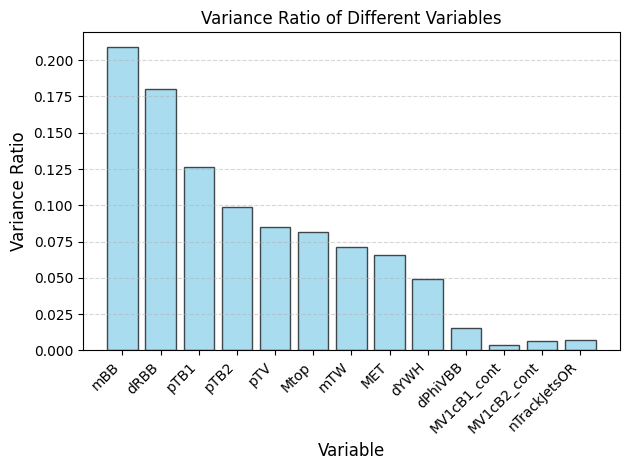

In [ ]:
# call function to filter variables
filtered_match = disdinguish_pca(x_train,13,variables)
var_ratio, eig_vec = perfrom_pca(x_train)

# plot results in bar
plt.bar(variables, var_ratio, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Variable',fontsize=12)
plt.ylabel('Variance Ratio', fontsize=12)
plt.title('Variance Ratio of Different Variables')
plt.xticks(rotation=45,ha='right',fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('variance_ratio.png',dpi=400)
files.download('variance_ratio.png')
plt.show()

This PCA-based approach provides a quick assessment of each original variable’s contribution to the dataset’s overall variance. Higher variance ratios suggest a stronger potential for separating different events, although the true discriminative power ultimately depends on the labels. By focusing on the variables with the highest variance contributions, one can reduce dimensionality while retaining the most “informative” features. This simplified PCA process thus helps prioritise which variables to include in the subsequent machine learning steps for Higgs detection.

# 2. Simple Neural Network Based Supervised Classifier Building

In [ ]:
def simple_nn(variables):
  """
  build a simple nn-based model to classify the Higgs and background events.

  Input:
  variables: list of variable names used as input features

  Ouput:
  model: compiled keras model
  """
  no_variables = len(variables)
  model = Sequential(
      [
      Dense(64, activation='relu', input_dim=no_variables),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')
      ]
  )
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
start = time()

# call function to model
model = simple_nn(variables)
history = model.fit(x_train,y_train,sample_weight = w_train,
                    epochs = 12,
                    batch_size = 64,
                    validation_data = (dset_val[0],dset_val[1]),
                    verbose = 1)
model.summary()
print(f"model training time: {str(round(time()-start,2))}s")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8352 - loss: 0.4332 - val_accuracy: 0.8964 - val_loss: 0.2713
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8954 - loss: 0.3230 - val_accuracy: 0.8959 - val_loss: 0.2647
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3069 - val_accuracy: 0.8959 - val_loss: 0.2633
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3051 - val_accuracy: 0.8999 - val_loss: 0.2571
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3064 - val_accuracy: 0.8996 - val_loss: 0.2571
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3074 - val_accuracy: 0.8982 - val_loss: 0.2589
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.3037 - val_accuracy: 0.9008 - val_loss: 0.2531
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9018 - loss: 0.2914 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,029 (35.27 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,020 (23.52 KB)

model training time: 42.47s


517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
sensitivity achieved:2.947


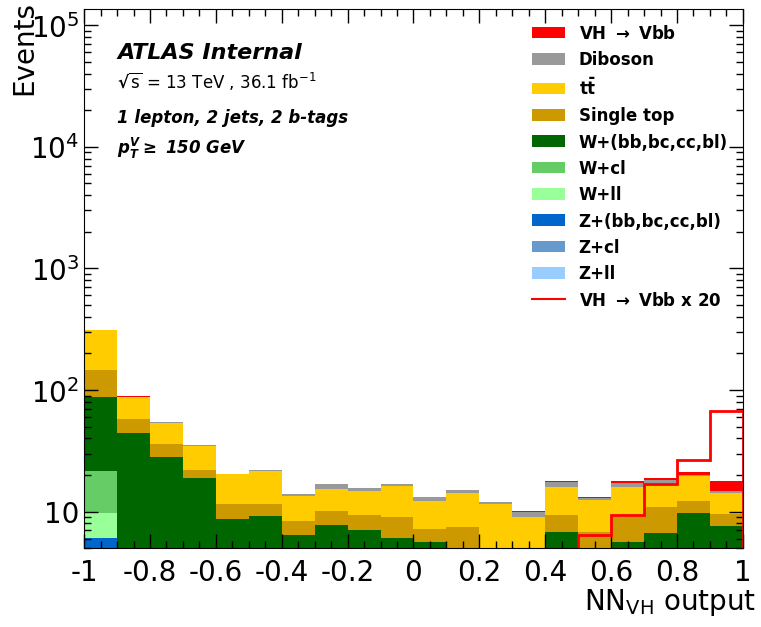

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# evaluate how the model works
df_test['decision_value'] = model.predict(dset_test[0])
print(f"sensitivity achieved:{round(sensitivity_NN(df_test)[0],3)}")

# plot final result
nn_output_plot(df_test)
plt.savefig('nn_output_plot.png')
files.download('nn_output_plot.png')

This simple neural network demonstrates a basic supervised approach to separating Higgs signal from background events. Despite its minimal architecture—comprising a single hidden layer— it achieves a notable improvement over a purely cut-based selection: from **1.876** to **2.770**. The training metrics and final output distribution indicate that the model successfully learns to assign higher scores to signal-like events, albeit with room for refinement. To further enhance performance, adding additional hidden layers, experimenting with different activation functions, and tuning hyperparameters such as the learning rate or optimiser will be explored. Nonetheless, this initial result validates the feasibility of employing neural networks for Higgs detection, laying the groundwork for more sophisticated architectures and optimization strategies.

# 3. Grid Search of Nodes and Numbers of Hidden Layers
This part conducts the grid search for nodes and number of hidden layers.

In [ ]:
import itertools

# construct model
def build_model(layers, input_dim):
  """
  construct a model for repeating the experiment

  Inputs:
  layers:number of hidden layers
  input_dim:number of variables

  Ouputs:
  model:compiled keras model
  """
  model = Sequential()
  model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
  for nodes in layers[1:]:
      model.add(Dense(nodes, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(0.005), metrics=['accuracy'])
  return model

# repeat experiment and calculate mean and std
def repeat_experiment(layers, x_train, y_train, w_train, dset_val, df_test, n_repeat=3):
  """
  repeat experiment to reduce error.

  Inputs:
  layers:number of hidden layers
  x_train:x training data
  y_train:y training data
  w_train:training datas' weight
  dset_val:validation dataset
  df_test:test dataframe
  n_repeat:number of times

  Ouputs:
  mean_sens:mean sensitivity
  std_sens:standard deviation of sensitivity
  """
    sens_list = []
    for _ in range(n_repeat):
        model = build_model(layers, input_dim=x_train.shape[1])
        model.fit(x_train, y_train, sample_weight=w_train,
                  validation_data=(dset_val[0], dset_val[1]),
                  epochs=5, batch_size=64, verbose=1)

        # predict and store into list
        df_test['decision_value'] = model.predict(dset_test[0], verbose=0).flatten()
        sens = round(sensitivity_NN(df_test)[0], 3)
        sens_list.append(sens)

    return np.mean(sens_list), np.std(sens_list)

# define nodes in each layer
layer_node_ranges = {
    1: list(range(16, 100, 32)),   # 1st layer: 16–99
    2: list(range(16,80, 32)),    # 2nd layer: 16–79
    3: list(range(8, 49, 16)),     # 3rd layer: 8–48
    4: list(range(4, 33, 12))      # 4th layer: 4–32
}

# generate all possible architectures
def generate_node_combinations(max_layers=4):
    """
    generate all possible architectures.

    Inputs:
    max_layers:maximum number of layers

    Ouputs:
    all_combinations:all possible architectures
    """
    all_combinations = []
    for n_layers in range(1, max_layers + 1):
        ranges = [layer_node_ranges[i+1] for i in range(n_layers)]
        for combo in itertools.product(*ranges):
            all_combinations.append(combo)
    return all_combinations

# 5. run all combinations and store
start = time.time()
node_layer_results = []

for arch in generate_node_combinations():
    mean_sens, std_sens = repeat_experiment(arch, x_train, y_train, w_train, dset_val, df_test, n_repeat=3)
    node_layer_results.append({
        "Architecture": "-".join(map(str, arch)),
        "Layers": len(arch),
        "Mean Sensitivity": mean_sens,
        "Std Sensitivity": std_sens
    })
    print(f"Tested {arch}, Mean: {mean_sens}, Std: {std_sens}")

print(f"Finished in {round(time.time()-start, 2)} seconds")

# construct data frame
results_df = pd.DataFrame(node_layer_results)
results_df.sort_values(by="Mean Sensitivity", ascending=False, inplace=True)

top_n = 20
top_df = results_df.head(top_n)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8535 - loss: 0.4055 - val_accuracy: 0.8915 - val_loss: 0.2784
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8939 - loss: 0.3272 - val_accuracy: 0.8977 - val_loss: 0.2662
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3228 - val_accuracy: 0.8965 - val_loss: 0.2637
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3119 - val_accuracy: 0.8984 - val_loss: 0.2661
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3073 - val_accuracy: 0.8983 - val_loss: 0.2607
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8497 - loss: 0.4134 - val_accuracy: 0.8935 - val_loss: 0.2819
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8903 - loss: 0.3347 - val_accuracy: 0.8956 - val_loss: 0.2720
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3220 - val_accuracy: 0.8975 - val_loss: 0.2663
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8963 - loss: 0.3179 - val_accuracy: 0.8964 - val_loss: 0.2658
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3183 - val_accuracy: 0.8966 - val_loss: 0.2644
Epoch 1/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8472 - loss: 0.4161 - val_accuracy: 0.8899 - val_loss: 0.2826
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8933 - loss: 0.3359 - val_accuracy: 0.8939 - val_loss: 0.2759
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3233 - val_accuracy: 0.89

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

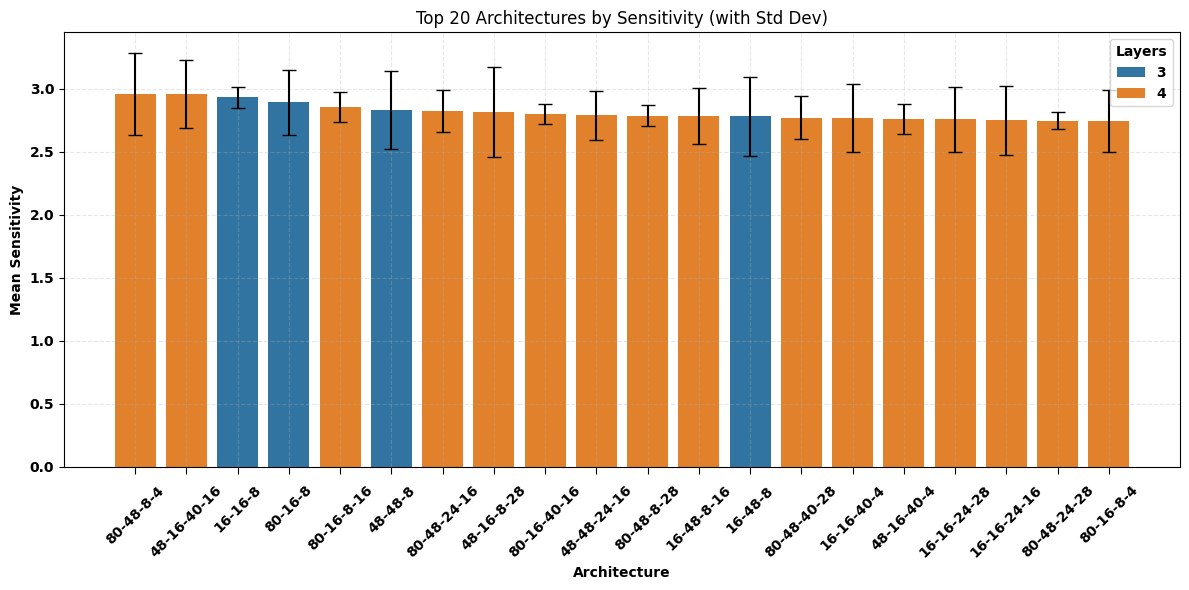

   Architecture  Layers  Mean Sensitivity  Std Sensitivity
72    80-48-8-4       4          2.957333         0.326356
52  48-16-40-16       4          2.956333         0.269761
9       16-16-8       3          2.931333         0.083116
21      80-16-8       3          2.892000         0.259053
64   80-16-8-16       4          2.857667         0.118213
18      48-48-8       3          2.829000         0.309730
76  80-48-24-16       4          2.822667         0.168810
47   48-16-8-28       4          2.814333         0.359227
70  80-16-40-16       4          2.800333         0.082488
58  48-48-24-16       4          2.790333         0.193963


In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df, x="Architecture", y="Mean Sensitivity", hue="Layers", palette="tab10", dodge=False)
plt.errorbar(x=range(top_n), y=top_df["Mean Sensitivity"], yerr=top_df["Std Sensitivity"],
             fmt='none', ecolor='black', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Mean Sensitivity")
plt.title(f"Top {top_n} Architectures by Sensitivity (with Std Dev)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('top_architectures.png', dpi=400)
files.download('top_architectures.png')
plt.show()

print(results_df.head(10))

# 4. Investigation of Training Parameters
This part investigates the impacts of changing learning rates, number of epochs and number of batch size.

In [ ]:
def model_training_parameters(learning_rate,epoch,batch_size,number):
  """
  Build and compile a model with varying learning rates, epochs, and batch size.

  Inputs:
  learning_rate: learning rate for optimizer
  epoch: number of epochs in model training
  batch_size: scale of batch size in model training
  number: number of features

  Ouputs:
  model: A model for each investigation
  sensitivity: Sensitivity of the model achieved
  """
  (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')
  selected_variables = disdinguish_pca(x_train,number,variables)
  # scale data into data with mean=0, std error=1 based on selected data
  (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')

  # build model (here 3 hidden layers was choosen due to its highest sensitivity in last part)
  model = Sequential([
      Dense(80,input_dim=number,activation='relu'),
      Dense(48,activation='relu'),
      Dense(8,activation='relu'),
      Dense(4,activation='relu'),
      Dense(1,activation='sigmoid')
  ])


  model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])
  history = model.fit(x_train,y_train,sample_weight=w_train,
                      epochs=epoch,
                      batch_size=batch_size,
                      validation_data=(dset_val[0],dset_val[1]),
                      verbose=1
  )

  df_test['decision_value'] = model.predict(dset_test[0])
  sensitivity = round(sensitivity_NN(df_test)[0], 2)

  return model, sensitivity

## 4.1 Learning Rates

In [ ]:
# define an array for learning rates and number of iterations needed
learning_rate = [0.001,0.005,0.01,0.05,0.1,0.5]
iterations = 15

# define an empty list for storing sensitivity for each epoch count
sensitivity_lr_tot = []

In [ ]:
# iterate through learning rate values
for lr in learning_rate:
  sensitivity_lr = [] # temporary list for current learning rate setting
  for i in range(iterations):
    # number of variables chosen to be 13 as from PCA part
    _, sensitivity = model_training_parameters(lr,12,64,13)
    sensitivity_lr.append(sensitivity)

  sensitivity_lr_tot.append(sensitivity_lr)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8385 - loss: 0.4192 - val_accuracy: 0.8956 - val_loss: 0.2710
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3215 - val_accuracy: 0.8984 - val_loss: 0.2621
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3036 - val_accuracy: 0.8991 - val_loss: 0.2579
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3058 - val_accuracy: 0.9010 - val_loss: 0.2566
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3024 - val_accuracy: 0.8998 - val_loss: 0.2593
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2980 - val_accuracy: 0.8993 - val_loss: 0.2575
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2992 - val_accuracy: 0.9009 - val_loss: 0.2547
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2995 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8313 - loss: 0.4279 - val_accuracy: 0.8967 - val_loss: 0.2639
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3186 - val_accuracy: 0.8992 - val_loss: 0.2603
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3123 - val_accuracy: 0.8968 - val_loss: 0.2679
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3003 - val_accuracy: 0.8979 - val_loss: 0.2611
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.2991 - val_accuracy: 0.8987 - val_loss: 0.2575
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3016 - val_accuracy: 0.8974 - val_loss: 0.2602
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.2977 - val_accuracy: 0.8974 - val_loss: 0.2576
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2996 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8282 - loss: 0.4447 - val_accuracy: 0.8953 - val_loss: 0.2714
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3133 - val_accuracy: 0.8970 - val_loss: 0.2633
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3082 - val_accuracy: 0.8993 - val_loss: 0.2588
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3054 - val_accuracy: 0.8987 - val_loss: 0.2569
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3049 - val_accuracy: 0.8982 - val_loss: 0.2588
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3046 - val_accuracy: 0.8981 - val_loss: 0.2578
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2966 - val_accuracy: 0.8984 - val_loss: 0.2553
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.2982 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8086 - loss: 0.4597 - val_accuracy: 0.8951 - val_loss: 0.2694
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3159 - val_accuracy: 0.8934 - val_loss: 0.2679
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3126 - val_accuracy: 0.8965 - val_loss: 0.2633
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3036 - val_accuracy: 0.9002 - val_loss: 0.2571
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.3022 - val_accuracy: 0.8994 - val_loss: 0.2549
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.2988 - val_accuracy: 0.8971 - val_loss: 0.2566
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3048 - val_accuracy: 0.9010 - val_loss: 0.2551
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3008 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8359 - loss: 0.4428 - val_accuracy: 0.8938 - val_loss: 0.2682
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3121 - val_accuracy: 0.8941 - val_loss: 0.2695
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3097 - val_accuracy: 0.8959 - val_loss: 0.2635
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3060 - val_accuracy: 0.8999 - val_loss: 0.2565
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.2981 - val_accuracy: 0.8982 - val_loss: 0.2613
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3011 - val_accuracy: 0.8974 - val_loss: 0.2575
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9026 - loss: 0.3045 - val_accuracy: 0.8946 - val_loss: 0.2669
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3000 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8218 - loss: 0.4437 - val_accuracy: 0.8936 - val_loss: 0.2696
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.3184 - val_accuracy: 0.8990 - val_loss: 0.2582
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3092 - val_accuracy: 0.8994 - val_loss: 0.2605
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3001 - val_accuracy: 0.8912 - val_loss: 0.2749
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3000 - val_accuracy: 0.8978 - val_loss: 0.2614
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3026 - val_accuracy: 0.8970 - val_loss: 0.2599
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.2974 - val_accuracy: 0.8993 - val_loss: 0.2582
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9027 - loss: 0.2984 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8337 - loss: 0.4401 - val_accuracy: 0.8955 - val_loss: 0.2686
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3124 - val_accuracy: 0.8965 - val_loss: 0.2643
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3166 - val_accuracy: 0.8974 - val_loss: 0.2618
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3012 - val_accuracy: 0.8989 - val_loss: 0.2557
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3004 - val_accuracy: 0.8981 - val_loss: 0.2593
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3025 - val_accuracy: 0.8995 - val_loss: 0.2572
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.2997 - val_accuracy: 0.9007 - val_loss: 0.2553
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.2945 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8336 - loss: 0.4300 - val_accuracy: 0.8964 - val_loss: 0.2677
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3199 - val_accuracy: 0.8972 - val_loss: 0.2608
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3088 - val_accuracy: 0.8998 - val_loss: 0.2573
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3052 - val_accuracy: 0.8974 - val_loss: 0.2573
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3029 - val_accuracy: 0.9008 - val_loss: 0.2552
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.3029 - val_accuracy: 0.8997 - val_loss: 0.2549
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.2989 - val_accuracy: 0.9000 - val_loss: 0.2578
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.2943 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8420 - loss: 0.4155 - val_accuracy: 0.8952 - val_loss: 0.2677
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8943 - loss: 0.3207 - val_accuracy: 0.8957 - val_loss: 0.2628
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3058 - val_accuracy: 0.8999 - val_loss: 0.2573
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.3020 - val_accuracy: 0.8973 - val_loss: 0.2597
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3027 - val_accuracy: 0.8996 - val_loss: 0.2584
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3022 - val_accuracy: 0.8993 - val_loss: 0.2597
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9030 - loss: 0.2942 - val_accuracy: 0.8985 - val_loss: 0.2596
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.2988 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8070 - loss: 0.5214 - val_accuracy: 0.8983 - val_loss: 0.3279
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3681 - val_accuracy: 0.8982 - val_loss: 0.2902
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3361 - val_accuracy: 0.8950 - val_loss: 0.2912
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.3169 - val_accuracy: 0.8992 - val_loss: 0.2685
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3148 - val_accuracy: 0.8968 - val_loss: 0.2706
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3114 - val_accuracy: 0.8999 - val_loss: 0.2621
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9023 - loss: 0.3047 - val_accuracy: 0.8976 - val_loss: 0.2645
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.3012 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8309 - loss: 0.4445 - val_accuracy: 0.8959 - val_loss: 0.2695
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3207 - val_accuracy: 0.8959 - val_loss: 0.2660
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3128 - val_accuracy: 0.8979 - val_loss: 0.2603
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.3046 - val_accuracy: 0.8974 - val_loss: 0.2600
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3005 - val_accuracy: 0.8986 - val_loss: 0.2595
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.3039 - val_accuracy: 0.8992 - val_loss: 0.2562
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3005 - val_accuracy: 0.9001 - val_loss: 0.2565
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.2931 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8436 - loss: 0.4405 - val_accuracy: 0.8944 - val_loss: 0.2721
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8945 - loss: 0.3226 - val_accuracy: 0.8930 - val_loss: 0.2775
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3149 - val_accuracy: 0.8979 - val_loss: 0.2628
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3100 - val_accuracy: 0.8990 - val_loss: 0.2635
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3050 - val_accuracy: 0.8997 - val_loss: 0.2578
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3020 - val_accuracy: 0.9017 - val_loss: 0.2553
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.2966 - val_accuracy: 0.8981 - val_loss: 0.2563
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.2986 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8315 - loss: 0.4346 - val_accuracy: 0.8935 - val_loss: 0.2751
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3105 - val_accuracy: 0.8994 - val_loss: 0.2609
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3016 - val_accuracy: 0.8992 - val_loss: 0.2624
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3041 - val_accuracy: 0.8998 - val_loss: 0.2550
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3065 - val_accuracy: 0.8992 - val_loss: 0.2547
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3047 - val_accuracy: 0.8969 - val_loss: 0.2632
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.2976 - val_accuracy: 0.9010 - val_loss: 0.2556
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2936 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8412 - loss: 0.4395 - val_accuracy: 0.8978 - val_loss: 0.2666
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8959 - loss: 0.3132 - val_accuracy: 0.8981 - val_loss: 0.2586
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3081 - val_accuracy: 0.8971 - val_loss: 0.2598
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3052 - val_accuracy: 0.8995 - val_loss: 0.2580
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3029 - val_accuracy: 0.8994 - val_loss: 0.2575
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3052 - val_accuracy: 0.8991 - val_loss: 0.2611
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.2991 - val_accuracy: 0.8982 - val_loss: 0.2608
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.2961 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8400 - loss: 0.4184 - val_accuracy: 0.8921 - val_loss: 0.2669
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3123 - val_accuracy: 0.8939 - val_loss: 0.2734
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3052 - val_accuracy: 0.8993 - val_loss: 0.2581
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3038 - val_accuracy: 0.8983 - val_loss: 0.2611
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.2976 - val_accuracy: 0.8982 - val_loss: 0.2558
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.2987 - val_accuracy: 0.9004 - val_loss: 0.2548
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2994 - val_accuracy: 0.8988 - val_loss: 0.2582
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2947 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8616 - loss: 0.3890 - val_accuracy: 0.8941 - val_loss: 0.2783
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3165 - val_accuracy: 0.8968 - val_loss: 0.2706
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3122 - val_accuracy: 0.8955 - val_loss: 0.2659
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3035 - val_accuracy: 0.9005 - val_loss: 0.2600
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3082 - val_accuracy: 0.9002 - val_loss: 0.2588
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3076 - val_accuracy: 0.8990 - val_loss: 0.2608
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3112 - val_accuracy: 0.9007 - val_loss: 0.2557
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3037 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8550 - loss: 0.4011 - val_accuracy: 0.8953 - val_loss: 0.2749
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.3244 - val_accuracy: 0.8981 - val_loss: 0.2616
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3122 - val_accuracy: 0.8994 - val_loss: 0.2630
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3072 - val_accuracy: 0.8985 - val_loss: 0.2612
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3041 - val_accuracy: 0.8931 - val_loss: 0.2647
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3029 - val_accuracy: 0.8991 - val_loss: 0.2571
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3060 - val_accuracy: 0.8974 - val_loss: 0.2577
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3032 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8651 - loss: 0.3857 - val_accuracy: 0.8992 - val_loss: 0.2597
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3110 - val_accuracy: 0.8996 - val_loss: 0.2631
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3126 - val_accuracy: 0.8968 - val_loss: 0.2645
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3035 - val_accuracy: 0.8979 - val_loss: 0.2610
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3051 - val_accuracy: 0.8971 - val_loss: 0.2622
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3099 - val_accuracy: 0.8997 - val_loss: 0.2587
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.2991 - val_accuracy: 0.8985 - val_loss: 0.2594
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2997 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8709 - loss: 0.3711 - val_accuracy: 0.8974 - val_loss: 0.2735
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8959 - loss: 0.3209 - val_accuracy: 0.8987 - val_loss: 0.2626
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3173 - val_accuracy: 0.8978 - val_loss: 0.2617
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3077 - val_accuracy: 0.8954 - val_loss: 0.2661
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3099 - val_accuracy: 0.8985 - val_loss: 0.2644
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3085 - val_accuracy: 0.8981 - val_loss: 0.2639
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3017 - val_accuracy: 0.9011 - val_loss: 0.2560
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3050 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8446 - loss: 0.4452 - val_accuracy: 0.8948 - val_loss: 0.2637
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3151 - val_accuracy: 0.8919 - val_loss: 0.2840
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3117 - val_accuracy: 0.8990 - val_loss: 0.2628
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3116 - val_accuracy: 0.8970 - val_loss: 0.2610
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3076 - val_accuracy: 0.8993 - val_loss: 0.2582
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3109 - val_accuracy: 0.9000 - val_loss: 0.2643
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3026 - val_accuracy: 0.8985 - val_loss: 0.2585
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3012 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8669 - loss: 0.3876 - val_accuracy: 0.8943 - val_loss: 0.2731
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3205 - val_accuracy: 0.8976 - val_loss: 0.2590
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3119 - val_accuracy: 0.8993 - val_loss: 0.2571
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3096 - val_accuracy: 0.8965 - val_loss: 0.2633
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3032 - val_accuracy: 0.8988 - val_loss: 0.2589
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9026 - loss: 0.2959 - val_accuracy: 0.8979 - val_loss: 0.2589
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3027 - val_accuracy: 0.8991 - val_loss: 0.2587
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.2963 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8682 - loss: 0.3802 - val_accuracy: 0.8974 - val_loss: 0.2746
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3224 - val_accuracy: 0.8982 - val_loss: 0.2646
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3119 - val_accuracy: 0.9000 - val_loss: 0.2557
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3020 - val_accuracy: 0.8979 - val_loss: 0.2665
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3072 - val_accuracy: 0.8995 - val_loss: 0.2593
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.3032 - val_accuracy: 0.8970 - val_loss: 0.2649
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.2983 - val_accuracy: 0.8970 - val_loss: 0.2594
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3028 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8566 - loss: 0.3850 - val_accuracy: 0.8950 - val_loss: 0.2696
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3155 - val_accuracy: 0.8995 - val_loss: 0.2629
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3116 - val_accuracy: 0.8993 - val_loss: 0.2606
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3060 - val_accuracy: 0.8987 - val_loss: 0.2599
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3060 - val_accuracy: 0.9016 - val_loss: 0.2559
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3010 - val_accuracy: 0.8959 - val_loss: 0.2585
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3080 - val_accuracy: 0.8991 - val_loss: 0.2588
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.2995 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8670 - loss: 0.3837 - val_accuracy: 0.8965 - val_loss: 0.2713
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3166 - val_accuracy: 0.8959 - val_loss: 0.2670
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3096 - val_accuracy: 0.8971 - val_loss: 0.2635
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3066 - val_accuracy: 0.8993 - val_loss: 0.2627
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3073 - val_accuracy: 0.8985 - val_loss: 0.2588
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3122 - val_accuracy: 0.8960 - val_loss: 0.2622
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.3050 - val_accuracy: 0.8976 - val_loss: 0.2593
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2973 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8723 - loss: 0.3758 - val_accuracy: 0.8936 - val_loss: 0.2726
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3287 - val_accuracy: 0.8979 - val_loss: 0.2602
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3128 - val_accuracy: 0.8969 - val_loss: 0.2601
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3161 - val_accuracy: 0.8996 - val_loss: 0.2644
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3034 - val_accuracy: 0.8966 - val_loss: 0.2721
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3147 - val_accuracy: 0.8945 - val_loss: 0.2690
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3055 - val_accuracy: 0.8957 - val_loss: 0.2594
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.2990 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8503 - loss: 0.3952 - val_accuracy: 0.8976 - val_loss: 0.2629
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.3240 - val_accuracy: 0.8980 - val_loss: 0.2613
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3125 - val_accuracy: 0.9008 - val_loss: 0.2573
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3144 - val_accuracy: 0.8993 - val_loss: 0.2590
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3045 - val_accuracy: 0.8996 - val_loss: 0.2587
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3016 - val_accuracy: 0.8964 - val_loss: 0.2642
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.2982 - val_accuracy: 0.8979 - val_loss: 0.2613
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3014 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8521 - loss: 0.4385 - val_accuracy: 0.8892 - val_loss: 0.2760
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3147 - val_accuracy: 0.8959 - val_loss: 0.2625
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3081 - val_accuracy: 0.8965 - val_loss: 0.2639
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3102 - val_accuracy: 0.8987 - val_loss: 0.2581
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3032 - val_accuracy: 0.8996 - val_loss: 0.2579
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3017 - val_accuracy: 0.9007 - val_loss: 0.2631
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3059 - val_accuracy: 0.8967 - val_loss: 0.2612
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3046 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8616 - loss: 0.3877 - val_accuracy: 0.8970 - val_loss: 0.2635
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3179 - val_accuracy: 0.8976 - val_loss: 0.2693
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3172 - val_accuracy: 0.8954 - val_loss: 0.2631
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3092 - val_accuracy: 0.8980 - val_loss: 0.2687
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3052 - val_accuracy: 0.8947 - val_loss: 0.2650
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3070 - val_accuracy: 0.9003 - val_loss: 0.2534
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3032 - val_accuracy: 0.8988 - val_loss: 0.2596
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3052 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8655 - loss: 0.3878 - val_accuracy: 0.8958 - val_loss: 0.2690
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8949 - loss: 0.3242 - val_accuracy: 0.8982 - val_loss: 0.2631
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3175 - val_accuracy: 0.8977 - val_loss: 0.2584
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3115 - val_accuracy: 0.8987 - val_loss: 0.2619
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2979 - val_accuracy: 0.8988 - val_loss: 0.2631
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3045 - val_accuracy: 0.8985 - val_loss: 0.2635
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3021 - val_accuracy: 0.8992 - val_loss: 0.2568
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3008 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8647 - loss: 0.3941 - val_accuracy: 0.8962 - val_loss: 0.2676
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3181 - val_accuracy: 0.8982 - val_loss: 0.2644
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3093 - val_accuracy: 0.8974 - val_loss: 0.2630
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.3030 - val_accuracy: 0.8952 - val_loss: 0.2731
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.2999 - val_accuracy: 0.8970 - val_loss: 0.2621
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3024 - val_accuracy: 0.8981 - val_loss: 0.2628
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2962 - val_accuracy: 0.8977 - val_loss: 0.2610
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9023 - loss: 0.2970 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8532 - loss: 0.3977 - val_accuracy: 0.8841 - val_loss: 0.2942
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8941 - loss: 0.3216 - val_accuracy: 0.8956 - val_loss: 0.2653
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3119 - val_accuracy: 0.8927 - val_loss: 0.2800
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3175 - val_accuracy: 0.8978 - val_loss: 0.2573
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3108 - val_accuracy: 0.8948 - val_loss: 0.2628
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.2997 - val_accuracy: 0.8996 - val_loss: 0.2616
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3033 - val_accuracy: 0.8930 - val_loss: 0.2713
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3126 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8422 - loss: 0.4592 - val_accuracy: 0.8960 - val_loss: 0.2714
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8927 - loss: 0.3268 - val_accuracy: 0.8927 - val_loss: 0.2730
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3199 - val_accuracy: 0.8926 - val_loss: 0.2758
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3066 - val_accuracy: 0.8993 - val_loss: 0.2606
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3128 - val_accuracy: 0.9010 - val_loss: 0.2614
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3106 - val_accuracy: 0.9003 - val_loss: 0.2592
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3094 - val_accuracy: 0.8988 - val_loss: 0.2649
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3117 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8521 - loss: 0.4417 - val_accuracy: 0.8931 - val_loss: 0.2756
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8929 - loss: 0.3273 - val_accuracy: 0.8913 - val_loss: 0.2797
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3215 - val_accuracy: 0.8984 - val_loss: 0.2640
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3138 - val_accuracy: 0.8947 - val_loss: 0.2750
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3154 - val_accuracy: 0.8990 - val_loss: 0.2597
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3141 - val_accuracy: 0.8976 - val_loss: 0.2656
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3078 - val_accuracy: 0.8959 - val_loss: 0.2665
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3110 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8611 - loss: 0.3946 - val_accuracy: 0.8918 - val_loss: 0.3014
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3266 - val_accuracy: 0.8956 - val_loss: 0.2663
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3078 - val_accuracy: 0.8915 - val_loss: 0.2721
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8949 - loss: 0.3154 - val_accuracy: 0.8998 - val_loss: 0.2578
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.3100 - val_accuracy: 0.8961 - val_loss: 0.2659
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3120 - val_accuracy: 0.8987 - val_loss: 0.2706
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3107 - val_accuracy: 0.8997 - val_loss: 0.2654
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3004 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8698 - loss: 0.3782 - val_accuracy: 0.8932 - val_loss: 0.2765
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.3273 - val_accuracy: 0.8986 - val_loss: 0.2629
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3181 - val_accuracy: 0.8982 - val_loss: 0.2610
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3082 - val_accuracy: 0.8967 - val_loss: 0.2623
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3051 - val_accuracy: 0.9000 - val_loss: 0.2563
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3039 - val_accuracy: 0.8991 - val_loss: 0.2579
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3082 - val_accuracy: 0.8968 - val_loss: 0.2694
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3076 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8644 - loss: 0.3766 - val_accuracy: 0.8945 - val_loss: 0.2731
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.3220 - val_accuracy: 0.8970 - val_loss: 0.2737
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3171 - val_accuracy: 0.8974 - val_loss: 0.2676
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3134 - val_accuracy: 0.8872 - val_loss: 0.2732
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3104 - val_accuracy: 0.8972 - val_loss: 0.2602
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3110 - val_accuracy: 0.8907 - val_loss: 0.2716
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3118 - val_accuracy: 0.8951 - val_loss: 0.2636
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8959 - loss: 0.3166 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8255 - loss: 0.4984 - val_accuracy: 0.8915 - val_loss: 0.2763
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3221 - val_accuracy: 0.8858 - val_loss: 0.2975
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8941 - loss: 0.3229 - val_accuracy: 0.8823 - val_loss: 0.2912
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3172 - val_accuracy: 0.8947 - val_loss: 0.2739
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3058 - val_accuracy: 0.8940 - val_loss: 0.2718
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3056 - val_accuracy: 0.8980 - val_loss: 0.2667
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3119 - val_accuracy: 0.8976 - val_loss: 0.2671
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3063 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8571 - loss: 0.4264 - val_accuracy: 0.8970 - val_loss: 0.2687
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3201 - val_accuracy: 0.8974 - val_loss: 0.2726
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3191 - val_accuracy: 0.8985 - val_loss: 0.2638
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3196 - val_accuracy: 0.9002 - val_loss: 0.2604
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3075 - val_accuracy: 0.8968 - val_loss: 0.2665
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3217 - val_accuracy: 0.8987 - val_loss: 0.2618
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3090 - val_accuracy: 0.9002 - val_loss: 0.2588
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3066 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8730 - loss: 0.3798 - val_accuracy: 0.8964 - val_loss: 0.2692
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8943 - loss: 0.3321 - val_accuracy: 0.8976 - val_loss: 0.2683
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3165 - val_accuracy: 0.8928 - val_loss: 0.2753
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3106 - val_accuracy: 0.8973 - val_loss: 0.2648
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3094 - val_accuracy: 0.8976 - val_loss: 0.2635
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3101 - val_accuracy: 0.8980 - val_loss: 0.2581
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3014 - val_accuracy: 0.9007 - val_loss: 0.2586
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3059 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8638 - loss: 0.4055 - val_accuracy: 0.8942 - val_loss: 0.2754
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8934 - loss: 0.3362 - val_accuracy: 0.8961 - val_loss: 0.2728
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3196 - val_accuracy: 0.8978 - val_loss: 0.2685
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3246 - val_accuracy: 0.8967 - val_loss: 0.2630
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3179 - val_accuracy: 0.8982 - val_loss: 0.2600
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3037 - val_accuracy: 0.8907 - val_loss: 0.2775
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3130 - val_accuracy: 0.8968 - val_loss: 0.2607
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3072 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8692 - loss: 0.3878 - val_accuracy: 0.8980 - val_loss: 0.2754
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3208 - val_accuracy: 0.8965 - val_loss: 0.2688
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.3201 - val_accuracy: 0.8984 - val_loss: 0.2650
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3158 - val_accuracy: 0.8999 - val_loss: 0.2573
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3077 - val_accuracy: 0.9003 - val_loss: 0.2562
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3167 - val_accuracy: 0.8967 - val_loss: 0.2666
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3052 - val_accuracy: 0.8993 - val_loss: 0.2608
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3004 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8630 - loss: 0.3872 - val_accuracy: 0.8967 - val_loss: 0.2647
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3224 - val_accuracy: 0.8971 - val_loss: 0.2778
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3238 - val_accuracy: 0.8994 - val_loss: 0.2615
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3155 - val_accuracy: 0.8968 - val_loss: 0.2604
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3126 - val_accuracy: 0.8985 - val_loss: 0.2638
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3038 - val_accuracy: 0.8993 - val_loss: 0.2596
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3048 - val_accuracy: 0.9000 - val_loss: 0.2608
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3052 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8686 - loss: 0.3787 - val_accuracy: 0.8944 - val_loss: 0.2650
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3246 - val_accuracy: 0.9000 - val_loss: 0.2601
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3095 - val_accuracy: 0.8920 - val_loss: 0.2765
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3175 - val_accuracy: 0.8991 - val_loss: 0.2615
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3127 - val_accuracy: 0.8994 - val_loss: 0.2574
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3107 - val_accuracy: 0.8981 - val_loss: 0.2674
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3054 - val_accuracy: 0.8995 - val_loss: 0.2538
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3036 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8685 - loss: 0.3803 - val_accuracy: 0.8960 - val_loss: 0.2710
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8934 - loss: 0.3269 - val_accuracy: 0.8967 - val_loss: 0.2658
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3168 - val_accuracy: 0.8958 - val_loss: 0.2776
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3135 - val_accuracy: 0.8982 - val_loss: 0.2647
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3122 - val_accuracy: 0.8999 - val_loss: 0.2573
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3104 - val_accuracy: 0.8969 - val_loss: 0.2605
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3102 - val_accuracy: 0.8961 - val_loss: 0.2604
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3056 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8671 - loss: 0.3798 - val_accuracy: 0.8958 - val_loss: 0.2896
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.3198 - val_accuracy: 0.8938 - val_loss: 0.2815
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3136 - val_accuracy: 0.8990 - val_loss: 0.2645
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3158 - val_accuracy: 0.8980 - val_loss: 0.2630
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3056 - val_accuracy: 0.8951 - val_loss: 0.2653
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3088 - val_accuracy: 0.8967 - val_loss: 0.2622
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3072 - val_accuracy: 0.8967 - val_loss: 0.2871
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.2986 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6527 - loss: 0.7137 - val_accuracy: 0.6537 - val_loss: 0.6468
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6525 - loss: 0.7094 - val_accuracy: 0.6537 - val_loss: 0.6486
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6502 - loss: 0.7111 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6539 - loss: 0.7103 - val_accuracy: 0.6537 - val_loss: 0.6459
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6508 - loss: 0.7127 - val_accuracy: 0.6537 - val_loss: 0.6456
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6526 - loss: 0.7091 - val_accuracy: 0.6537 - val_loss: 0.6467
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6551 - loss: 0.7105 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6530 - loss: 0.7103 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8552 - loss: 0.4156 - val_accuracy: 0.8864 - val_loss: 0.2954
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8899 - loss: 0.3432 - val_accuracy: 0.8890 - val_loss: 0.2855
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8821 - loss: 0.3682 - val_accuracy: 0.8924 - val_loss: 0.2834
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8899 - loss: 0.3512 - val_accuracy: 0.8924 - val_loss: 0.2831
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8883 - loss: 0.3419 - val_accuracy: 0.8948 - val_loss: 0.2855
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8894 - loss: 0.3486 - val_accuracy: 0.8852 - val_loss: 0.3036
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8887 - loss: 0.3431 - val_accuracy: 0.8956 - val_loss: 0.2795
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8901 - loss: 0.3495 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8283 - loss: 0.4804 - val_accuracy: 0.8248 - val_loss: 0.3723
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8832 - loss: 0.3657 - val_accuracy: 0.8938 - val_loss: 0.2797
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8782 - loss: 0.3703 - val_accuracy: 0.8917 - val_loss: 0.3004
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8586 - loss: 0.3957 - val_accuracy: 0.8119 - val_loss: 0.4741
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8047 - loss: 0.5366 - val_accuracy: 0.8216 - val_loss: 0.4531
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8070 - loss: 0.5378 - val_accuracy: 0.7720 - val_loss: 0.5372
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7951 - loss: 0.5514 - val_accuracy: 0.7994 - val_loss: 0.4872
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7970 - loss: 0.5513 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8598 - loss: 0.4051 - val_accuracy: 0.8930 - val_loss: 0.2835
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8856 - loss: 0.3562 - val_accuracy: 0.8808 - val_loss: 0.3816
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8176 - loss: 0.5015 - val_accuracy: 0.8350 - val_loss: 0.4479
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8288 - loss: 0.5109 - val_accuracy: 0.7811 - val_loss: 0.5164
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8158 - loss: 0.5318 - val_accuracy: 0.8257 - val_loss: 0.4552
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7681 - loss: 0.5743 - val_accuracy: 0.6537 - val_loss: 0.6475
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6542 - loss: 0.7072 - val_accuracy: 0.6537 - val_loss: 0.6456
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6565 - loss: 0.7092 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8548 - loss: 0.4172 - val_accuracy: 0.8895 - val_loss: 0.2922
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8780 - loss: 0.3773 - val_accuracy: 0.8818 - val_loss: 0.3098
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8677 - loss: 0.4006 - val_accuracy: 0.8429 - val_loss: 0.4149
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8545 - loss: 0.4668 - val_accuracy: 0.8568 - val_loss: 0.4008
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8388 - loss: 0.4787 - val_accuracy: 0.8248 - val_loss: 0.4398
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8244 - loss: 0.5030 - val_accuracy: 0.8443 - val_loss: 0.4282
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8480 - loss: 0.4850 - val_accuracy: 0.8231 - val_loss: 0.4637
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8313 - loss: 0.5109 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7560 - loss: 0.5912 - val_accuracy: 0.6537 - val_loss: 0.6459
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6550 - loss: 0.7098 - val_accuracy: 0.6537 - val_loss: 0.6524
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7129 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6514 - loss: 0.7109 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6517 - loss: 0.7137 - val_accuracy: 0.6537 - val_loss: 0.6489
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6513 - loss: 0.7122 - val_accuracy: 0.6537 - val_loss: 0.6495
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6546 - loss: 0.7117 - val_accuracy: 0.6537 - val_loss: 0.6467
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6521 - loss: 0.7126 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8153 - loss: 0.5026 - val_accuracy: 0.8881 - val_loss: 0.2939
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8707 - loss: 0.3921 - val_accuracy: 0.8786 - val_loss: 0.3405
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8405 - loss: 0.4538 - val_accuracy: 0.7958 - val_loss: 0.4869
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7902 - loss: 0.5675 - val_accuracy: 0.8075 - val_loss: 0.4723
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7317 - loss: 0.6223 - val_accuracy: 0.6537 - val_loss: 0.6257
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7346 - loss: 0.6058 - val_accuracy: 0.7822 - val_loss: 0.5145
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7808 - loss: 0.5764 - val_accuracy: 0.7970 - val_loss: 0.4964
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7904 - loss: 0.5639 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8587 - loss: 0.4065 - val_accuracy: 0.8844 - val_loss: 0.2862
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.3718 - val_accuracy: 0.8918 - val_loss: 0.3536
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8847 - loss: 0.3744 - val_accuracy: 0.8950 - val_loss: 0.2918
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8909 - loss: 0.3539 - val_accuracy: 0.8921 - val_loss: 0.2927
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8925 - loss: 0.3572 - val_accuracy: 0.8980 - val_loss: 0.3101
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3375 - val_accuracy: 0.8952 - val_loss: 0.2822
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8922 - loss: 0.3556 - val_accuracy: 0.8809 - val_loss: 0.3135
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8888 - loss: 0.3615 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8369 - loss: 0.4639 - val_accuracy: 0.8920 - val_loss: 0.2812
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8813 - loss: 0.3662 - val_accuracy: 0.8492 - val_loss: 0.3506
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8826 - loss: 0.3565 - val_accuracy: 0.8898 - val_loss: 0.3310
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8741 - loss: 0.3973 - val_accuracy: 0.8480 - val_loss: 0.3921
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8768 - loss: 0.3652 - val_accuracy: 0.8767 - val_loss: 0.3429
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8625 - loss: 0.4232 - val_accuracy: 0.8179 - val_loss: 0.4480
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8131 - loss: 0.5064 - val_accuracy: 0.8216 - val_loss: 0.4425
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8193 - loss: 0.4966 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8612 - loss: 0.4137 - val_accuracy: 0.8558 - val_loss: 0.3294
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8782 - loss: 0.3881 - val_accuracy: 0.8942 - val_loss: 0.2821
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8786 - loss: 0.3714 - val_accuracy: 0.8941 - val_loss: 0.2881
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8889 - loss: 0.3427 - val_accuracy: 0.8941 - val_loss: 0.2740
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8865 - loss: 0.3386 - val_accuracy: 0.8864 - val_loss: 0.3043
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8870 - loss: 0.3542 - val_accuracy: 0.8839 - val_loss: 0.3068
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8864 - loss: 0.3479 - val_accuracy: 0.8886 - val_loss: 0.2879
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8850 - loss: 0.3577 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8647 - loss: 0.4122 - val_accuracy: 0.8939 - val_loss: 0.2766
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8894 - loss: 0.3562 - val_accuracy: 0.8901 - val_loss: 0.2943
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8906 - loss: 0.3421 - val_accuracy: 0.8886 - val_loss: 0.2935
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8885 - loss: 0.3475 - val_accuracy: 0.8920 - val_loss: 0.2832
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.3555 - val_accuracy: 0.8878 - val_loss: 0.2889
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8903 - loss: 0.3397 - val_accuracy: 0.8948 - val_loss: 0.2830
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8868 - loss: 0.3504 - val_accuracy: 0.8924 - val_loss: 0.2893
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8902 - loss: 0.3488 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8591 - loss: 0.4358 - val_accuracy: 0.8896 - val_loss: 0.2801
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8842 - loss: 0.3564 - val_accuracy: 0.8916 - val_loss: 0.2951
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8807 - loss: 0.3640 - val_accuracy: 0.8822 - val_loss: 0.2961
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8196 - loss: 0.4750 - val_accuracy: 0.7763 - val_loss: 0.5136
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7656 - loss: 0.6028 - val_accuracy: 0.7714 - val_loss: 0.5156
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7675 - loss: 0.5970 - val_accuracy: 0.7714 - val_loss: 0.5134
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7701 - loss: 0.5944 - val_accuracy: 0.7714 - val_loss: 0.5124
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7689 - loss: 0.5934 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8588 - loss: 0.4196 - val_accuracy: 0.8936 - val_loss: 0.2835
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8867 - loss: 0.3542 - val_accuracy: 0.8670 - val_loss: 0.3190
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8811 - loss: 0.3665 - val_accuracy: 0.8854 - val_loss: 0.3446
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8741 - loss: 0.3819 - val_accuracy: 0.8776 - val_loss: 0.3113
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8742 - loss: 0.3848 - val_accuracy: 0.8927 - val_loss: 0.3019
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8844 - loss: 0.3621 - val_accuracy: 0.8696 - val_loss: 0.3080
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8787 - loss: 0.3732 - val_accuracy: 0.8840 - val_loss: 0.3215
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8835 - loss: 0.3678 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8598 - loss: 0.4061 - val_accuracy: 0.8783 - val_loss: 0.3158
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8848 - loss: 0.3466 - val_accuracy: 0.8473 - val_loss: 0.3245
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8822 - loss: 0.3584 - val_accuracy: 0.8729 - val_loss: 0.3433
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8854 - loss: 0.3602 - val_accuracy: 0.8947 - val_loss: 0.2863
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8850 - loss: 0.3566 - val_accuracy: 0.8844 - val_loss: 0.2936
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8905 - loss: 0.3362 - val_accuracy: 0.8867 - val_loss: 0.2830
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8886 - loss: 0.3432 - val_accuracy: 0.8912 - val_loss: 0.3363
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8913 - loss: 0.3432 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8521 - loss: 0.4357 - val_accuracy: 0.8863 - val_loss: 0.2859
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8804 - loss: 0.3859 - val_accuracy: 0.8879 - val_loss: 0.3257
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8846 - loss: 0.3755 - val_accuracy: 0.8967 - val_loss: 0.2795
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8876 - loss: 0.3688 - val_accuracy: 0.8884 - val_loss: 0.2956
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.3339 - val_accuracy: 0.8938 - val_loss: 0.2801
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8836 - loss: 0.3632 - val_accuracy: 0.8939 - val_loss: 0.2916
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8743 - loss: 0.3962 - val_accuracy: 0.8973 - val_loss: 0.3050
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8941 - loss: 0.3465 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6528 - loss: 0.7158 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6519 - loss: 0.7087 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6529 - loss: 0.7075 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6521 - loss: 0.7099 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6547 - loss: 0.7070 - val_accuracy: 0.6537 - val_loss: 0.6611
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6555 - loss: 0.7107 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6551 - loss: 0.7106 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6549 - loss: 0.7092 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6520 - loss: 0.7271 - val_accuracy: 0.6537 - val_loss: 0.6458
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6558 - loss: 0.7083 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7104 - val_accuracy: 0.6537 - val_loss: 0.6468
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6548 - loss: 0.7034 - val_accuracy: 0.6537 - val_loss: 0.6477
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6515 - loss: 0.7125 - val_accuracy: 0.6537 - val_loss: 0.6480
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6527 - loss: 0.7118 - val_accuracy: 0.6537 - val_loss: 0.6496
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6555 - loss: 0.7084 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6538 - loss: 0.7114 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7004 - loss: 0.6615 - val_accuracy: 0.6537 - val_loss: 0.6493
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6560 - loss: 0.7083 - val_accuracy: 0.6537 - val_loss: 0.6483
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6536 - loss: 0.7110 - val_accuracy: 0.6537 - val_loss: 0.6456
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6516 - loss: 0.7170 - val_accuracy: 0.6537 - val_loss: 0.6458
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6545 - loss: 0.7127 - val_accuracy: 0.6537 - val_loss: 0.6461
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6542 - loss: 0.7142 - val_accuracy: 0.6537 - val_loss: 0.6471
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6536 - loss: 0.7167 - val_accuracy: 0.6537 - val_loss: 0.6485
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6559 - loss: 0.7106 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6520 - loss: 0.7117 - val_accuracy: 0.6537 - val_loss: 0.6508
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6537 - loss: 0.7108 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6567 - loss: 0.7149 - val_accuracy: 0.6537 - val_loss: 0.6485
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6565 - loss: 0.7113 - val_accuracy: 0.6537 - val_loss: 0.6461
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6558 - loss: 0.7106 - val_accuracy: 0.6537 - val_loss: 0.6625
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6519 - loss: 0.7117 - val_accuracy: 0.6537 - val_loss: 0.6477
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6525 - loss: 0.7123 - val_accuracy: 0.6537 - val_loss: 0.6495
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6532 - loss: 0.7087 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8143 - loss: 0.4980 - val_accuracy: 0.6537 - val_loss: 0.6463
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7147 - val_accuracy: 0.6537 - val_loss: 0.6481
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6536 - loss: 0.7114 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6503 - loss: 0.7136 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7101 - val_accuracy: 0.6537 - val_loss: 0.6485
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6549 - loss: 0.7153 - val_accuracy: 0.6537 - val_loss: 0.6496
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6552 - loss: 0.7095 - val_accuracy: 0.6537 - val_loss: 0.6470
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6502 - loss: 0.7207 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7713 - loss: 0.5599 - val_accuracy: 0.7884 - val_loss: 0.5304
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7602 - loss: 0.5799 - val_accuracy: 0.7711 - val_loss: 0.5590
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7705 - loss: 0.5546 - val_accuracy: 0.7711 - val_loss: 0.5244
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7705 - loss: 0.5544 - val_accuracy: 0.7711 - val_loss: 0.5261
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7700 - loss: 0.5549 - val_accuracy: 0.7711 - val_loss: 0.5249
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7694 - loss: 0.5552 - val_accuracy: 0.7711 - val_loss: 0.5262
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7670 - loss: 0.5600 - val_accuracy: 0.7711 - val_loss: 0.5251
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7716 - loss: 0.5559 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7504 - loss: 0.5820 - val_accuracy: 0.6537 - val_loss: 0.6732
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6522 - loss: 0.7160 - val_accuracy: 0.6537 - val_loss: 0.6561
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6539 - loss: 0.7159 - val_accuracy: 0.6537 - val_loss: 0.6490
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6540 - loss: 0.7084 - val_accuracy: 0.6537 - val_loss: 0.6475
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6534 - loss: 0.7133 - val_accuracy: 0.6537 - val_loss: 0.6479
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6536 - loss: 0.7061 - val_accuracy: 0.6537 - val_loss: 0.6471
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6514 - loss: 0.7125 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6533 - loss: 0.7117 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7355 - loss: 0.6311 - val_accuracy: 0.6586 - val_loss: 0.6591
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6894 - loss: 0.6473 - val_accuracy: 0.6537 - val_loss: 0.5871
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6695 - loss: 0.6684 - val_accuracy: 0.6854 - val_loss: 0.5874
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6645 - loss: 0.6716 - val_accuracy: 0.6537 - val_loss: 0.5883
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6670 - loss: 0.6677 - val_accuracy: 0.6854 - val_loss: 0.5907
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6693 - loss: 0.6683 - val_accuracy: 0.6854 - val_loss: 0.5963
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6637 - loss: 0.6689 - val_accuracy: 0.6537 - val_loss: 0.5908
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6662 - loss: 0.6705 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7505 - loss: 0.6295 - val_accuracy: 0.7908 - val_loss: 0.5103
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7892 - loss: 0.5618 - val_accuracy: 0.7856 - val_loss: 0.5234
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7462 - loss: 0.6418 - val_accuracy: 0.7596 - val_loss: 0.5578
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7533 - loss: 0.6291 - val_accuracy: 0.7596 - val_loss: 0.5462
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7549 - loss: 0.6270 - val_accuracy: 0.7595 - val_loss: 0.5456
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7511 - loss: 0.6351 - val_accuracy: 0.7596 - val_loss: 0.5440
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7528 - loss: 0.6312 - val_accuracy: 0.7596 - val_loss: 0.5700
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7531 - loss: 0.6337 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7948 - loss: 0.5600 - val_accuracy: 0.8100 - val_loss: 0.4865
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7736 - loss: 0.6004 - val_accuracy: 0.6860 - val_loss: 0.6173
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7124 - loss: 0.6660 - val_accuracy: 0.7777 - val_loss: 0.5369
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7883 - loss: 0.5711 - val_accuracy: 0.7637 - val_loss: 0.5260
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7790 - loss: 0.5664 - val_accuracy: 0.8035 - val_loss: 0.5371
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7163 - loss: 0.6637 - val_accuracy: 0.6537 - val_loss: 0.6454
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6537 - loss: 0.7078 - val_accuracy: 0.6537 - val_loss: 0.6510
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6523 - loss: 0.7139 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6508 - loss: 0.7135 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6531 - loss: 0.7147 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6556 - loss: 0.7076 - val_accuracy: 0.6537 - val_loss: 0.6454
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6536 - loss: 0.7127 - val_accuracy: 0.6537 - val_loss: 0.6476
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6521 - loss: 0.7143 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6527 - loss: 0.7166 - val_accuracy: 0.6537 - val_loss: 0.6462
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6539 - loss: 0.7125 - val_accuracy: 0.6537 - val_loss: 0.6479
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6521 - loss: 0.7166 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6941 - loss: 0.6822 - val_accuracy: 0.6537 - val_loss: 0.6462
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7144 - val_accuracy: 0.6537 - val_loss: 0.6611
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6551 - loss: 0.7079 - val_accuracy: 0.6537 - val_loss: 0.6513
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6528 - loss: 0.7112 - val_accuracy: 0.6537 - val_loss: 0.6575
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6569 - loss: 0.7065 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6507 - loss: 0.7166 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6537 - loss: 0.7152 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6507 - loss: 0.7178 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6518 - loss: 0.7111 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6559 - loss: 0.7099 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6526 - loss: 0.7152 - val_accuracy: 0.6537 - val_loss: 0.6520
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6527 - loss: 0.7101 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6541 - loss: 0.7121 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6541 - loss: 0.7168 - val_accuracy: 0.6537 - val_loss: 0.6454
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6522 - loss: 0.7130 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6544 - loss: 0.7104 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8231 - loss: 0.4862 - val_accuracy: 0.8849 - val_loss: 0.3104
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8791 - loss: 0.3810 - val_accuracy: 0.8048 - val_loss: 0.4434
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8440 - loss: 0.4488 - val_accuracy: 0.8885 - val_loss: 0.2923
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8861 - loss: 0.3677 - val_accuracy: 0.8751 - val_loss: 0.3255
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8892 - loss: 0.3575 - val_accuracy: 0.8415 - val_loss: 0.4100
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8866 - loss: 0.3756 - val_accuracy: 0.8482 - val_loss: 0.3489
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7697 - loss: 0.6606 - val_accuracy: 0.7998 - val_loss: 0.4962
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7607 - loss: 0.5865 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7011 - loss: 0.6719 - val_accuracy: 0.6537 - val_loss: 0.6466
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6550 - loss: 0.7122 - val_accuracy: 0.6537 - val_loss: 0.6477
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6538 - loss: 0.7113 - val_accuracy: 0.6537 - val_loss: 0.6457
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6515 - loss: 0.7147 - val_accuracy: 0.6537 - val_loss: 0.6496
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6539 - loss: 0.7120 - val_accuracy: 0.6537 - val_loss: 0.6469
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6574 - loss: 0.7086 - val_accuracy: 0.6537 - val_loss: 0.6475
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6503 - loss: 0.7147 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6564 - loss: 0.7129 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6478 - loss: 1.7638 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6521 - loss: 0.7133 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6472 - loss: 0.7163 - val_accuracy: 0.6537 - val_loss: 0.6494
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6525 - loss: 0.7198 - val_accuracy: 0.6537 - val_loss: 0.6596
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6533 - loss: 0.7173 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6474 - loss: 0.7212 - val_accuracy: 0.6537 - val_loss: 0.6456
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6406 - loss: 0.7191 - val_accuracy: 0.6537 - val_loss: 0.6559
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6519 - loss: 0.7154 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6421 - loss: 1.8135 - val_accuracy: 0.6537 - val_loss: 0.6581
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6486 - loss: 0.7177 - val_accuracy: 0.6537 - val_loss: 0.6478
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6493 - loss: 0.7186 - val_accuracy: 0.6537 - val_loss: 0.6454
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6466 - loss: 0.7176 - val_accuracy: 0.6537 - val_loss: 0.6469
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6453 - loss: 0.7198 - val_accuracy: 0.6537 - val_loss: 0.6461
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6473 - loss: 0.7173 - val_accuracy: 0.6537 - val_loss: 0.6527
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6399 - loss: 0.7212 - val_accuracy: 0.6537 - val_loss: 0.6498
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6483 - loss: 0.7235 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6455 - loss: 3.2904 - val_accuracy: 0.6537 - val_loss: 0.6595
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6522 - loss: 0.7164 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6495 - loss: 0.7208 - val_accuracy: 0.3463 - val_loss: 0.6947
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6443 - loss: 0.7239 - val_accuracy: 0.6537 - val_loss: 0.6455
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6466 - loss: 0.7183 - val_accuracy: 0.3463 - val_loss: 0.7533
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6392 - loss: 0.7213 - val_accuracy: 0.6537 - val_loss: 0.6595
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6488 - loss: 0.7188 - val_accuracy: 0.6537 - val_loss: 0.6479
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6482 - loss: 0.7160 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6421 - loss: 1.1041 - val_accuracy: 0.6537 - val_loss: 0.6691
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6454 - loss: 0.7211 - val_accuracy: 0.6537 - val_loss: 0.6609
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6465 - loss: 0.7193 - val_accuracy: 0.6537 - val_loss: 0.6474
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6471 - loss: 0.7217 - val_accuracy: 0.6537 - val_loss: 0.6569
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6513 - loss: 0.7161 - val_accuracy: 0.6537 - val_loss: 0.6811
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6452 - loss: 0.7221 - val_accuracy: 0.6537 - val_loss: 0.6532
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6504 - loss: 0.7182 - val_accuracy: 0.6537 - val_loss: 0.6577
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6485 - loss: 0.7182 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6486 - loss: 1.6810 - val_accuracy: 0.6537 - val_loss: 0.6498
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6482 - loss: 0.7156 - val_accuracy: 0.6537 - val_loss: 0.6652
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.7177 - val_accuracy: 0.6537 - val_loss: 0.6492
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6444 - loss: 0.7256 - val_accuracy: 0.6537 - val_loss: 0.6604
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6475 - loss: 0.7211 - val_accuracy: 0.6537 - val_loss: 0.6643
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6431 - loss: 0.7217 - val_accuracy: 0.6537 - val_loss: 0.6477
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6492 - loss: 0.7206 - val_accuracy: 0.6537 - val_loss: 0.6471
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6508 - loss: 0.7192 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6509 - loss: 2.3262 - val_accuracy: 0.6537 - val_loss: 0.6527
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6532 - loss: 0.7186 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6530 - loss: 0.7151 - val_accuracy: 0.6537 - val_loss: 0.6497
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6510 - loss: 0.7228 - val_accuracy: 0.6537 - val_loss: 0.6568
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6478 - loss: 0.7156 - val_accuracy: 0.6537 - val_loss: 0.6843
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6418 - loss: 0.7172 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6442 - loss: 0.7189 - val_accuracy: 0.6537 - val_loss: 0.6485
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6473 - loss: 0.7231 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6498 - loss: 1.1694 - val_accuracy: 0.6537 - val_loss: 0.6587
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6478 - loss: 0.7166 - val_accuracy: 0.6537 - val_loss: 0.6525
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6483 - loss: 0.7165 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6469 - loss: 0.7228 - val_accuracy: 0.6537 - val_loss: 0.6478
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6499 - loss: 0.7218 - val_accuracy: 0.6537 - val_loss: 0.6605
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6418 - loss: 0.7197 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6499 - loss: 0.7207 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6468 - loss: 0.7160 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6453 - loss: 0.7757 - val_accuracy: 0.6537 - val_loss: 0.6556
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6525 - loss: 0.7200 - val_accuracy: 0.6537 - val_loss: 0.6512
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6488 - loss: 0.7234 - val_accuracy: 0.6537 - val_loss: 0.6491
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6512 - loss: 0.7164 - val_accuracy: 0.6537 - val_loss: 0.6564
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6387 - loss: 0.7226 - val_accuracy: 0.6537 - val_loss: 0.6516
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6366 - loss: 0.7183 - val_accuracy: 0.6537 - val_loss: 0.6721
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6424 - loss: 0.7200 - val_accuracy: 0.6537 - val_loss: 0.6465
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6516 - loss: 0.7168 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6378 - loss: 2.7332 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6454 - loss: 0.7196 - val_accuracy: 0.6537 - val_loss: 0.6559
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6484 - loss: 0.7170 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6452 - loss: 0.7233 - val_accuracy: 0.6537 - val_loss: 0.6503
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6491 - loss: 0.7205 - val_accuracy: 0.6537 - val_loss: 0.6481
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6509 - loss: 0.7196 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6452 - loss: 0.7191 - val_accuracy: 0.6537 - val_loss: 0.6471
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6505 - loss: 0.7152 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6497 - loss: 1.9379 - val_accuracy: 0.6537 - val_loss: 0.6606
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6538 - loss: 0.7156 - val_accuracy: 0.6537 - val_loss: 0.6501
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6506 - loss: 0.7184 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6386 - loss: 0.7269 - val_accuracy: 0.6537 - val_loss: 0.6533
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6441 - loss: 0.7174 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6475 - loss: 0.7194 - val_accuracy: 0.6537 - val_loss: 0.6716
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6497 - loss: 0.7214 - val_accuracy: 0.6537 - val_loss: 0.6456
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6473 - loss: 0.7168 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6449 - loss: 2.2953 - val_accuracy: 0.6537 - val_loss: 0.6483
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6473 - loss: 0.7219 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6482 - loss: 0.7197 - val_accuracy: 0.6537 - val_loss: 0.6796
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6523 - loss: 0.7227 - val_accuracy: 0.6537 - val_loss: 0.6467
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6489 - loss: 0.7162 - val_accuracy: 0.6537 - val_loss: 0.6612
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6466 - loss: 0.7281 - val_accuracy: 0.6537 - val_loss: 0.6654
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6478 - loss: 0.7164 - val_accuracy: 0.6537 - val_loss: 0.6484
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6490 - loss: 0.7177 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6468 - loss: 0.7196 - val_accuracy: 0.6537 - val_loss: 0.6544
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6527 - loss: 0.7130 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6483 - loss: 0.7162 - val_accuracy: 0.6537 - val_loss: 0.6487
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6520 - loss: 0.7185 - val_accuracy: 0.6537 - val_loss: 0.6481
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6499 - loss: 0.7191 - val_accuracy: 0.6537 - val_loss: 0.6633
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6504 - loss: 0.7187 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6529 - loss: 0.7155 - val_accuracy: 0.6537 - val_loss: 0.6460
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6435 - loss: 0.7223 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6363 - loss: 2.2222 - val_accuracy: 0.6537 - val_loss: 0.6731
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6394 - loss: 0.7227 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6458 - loss: 0.7201 - val_accuracy: 0.6537 - val_loss: 0.6552
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6490 - loss: 0.7194 - val_accuracy: 0.6537 - val_loss: 0.6495
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6471 - loss: 0.7197 - val_accuracy: 0.6537 - val_loss: 0.6856
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6458 - loss: 0.7213 - val_accuracy: 0.6537 - val_loss: 0.6499
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6493 - loss: 0.7181 - val_accuracy: 0.6537 - val_loss: 0.6484
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6488 - loss: 0.7210 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6434 - loss: 0.7922 - val_accuracy: 0.6537 - val_loss: 0.6556
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6470 - loss: 0.7212 - val_accuracy: 0.6537 - val_loss: 0.6554
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6434 - loss: 0.7218 - val_accuracy: 0.6537 - val_loss: 0.6558
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6490 - loss: 0.7227 - val_accuracy: 0.6537 - val_loss: 0.6454
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6505 - loss: 0.7211 - val_accuracy: 0.6537 - val_loss: 0.6453
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6441 - loss: 0.7264 - val_accuracy: 0.6537 - val_loss: 0.6574
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6432 - loss: 0.7210 - val_accuracy: 0.6537 - val_loss: 0.6451
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6542 - loss: 0.7205 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6392 - loss: 1.2538 - val_accuracy: 0.6537 - val_loss: 0.6498
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6451 - loss: 0.7205 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6467 - loss: 0.7212 - val_accuracy: 0.6537 - val_loss: 0.6452
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6489 - loss: 0.7210 - val_accuracy: 0.6537 - val_loss: 0.6478
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6503 - loss: 0.7218 - val_accuracy: 0.6537 - val_loss: 0.6498
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6511 - loss: 0.7178 - val_accuracy: 0.6537 - val_loss: 0.6472
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6489 - loss: 0.7157 - val_accuracy: 0.6537 - val_loss: 0.6665
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6494 - loss: 0.7157 - val_accurac

<ipython-input-41-d5cbfceb1770>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sensitivity_lr_tot, labels=[str(lr) for lr in learning_rate])
<ipython-input-41-d5cbfceb1770>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

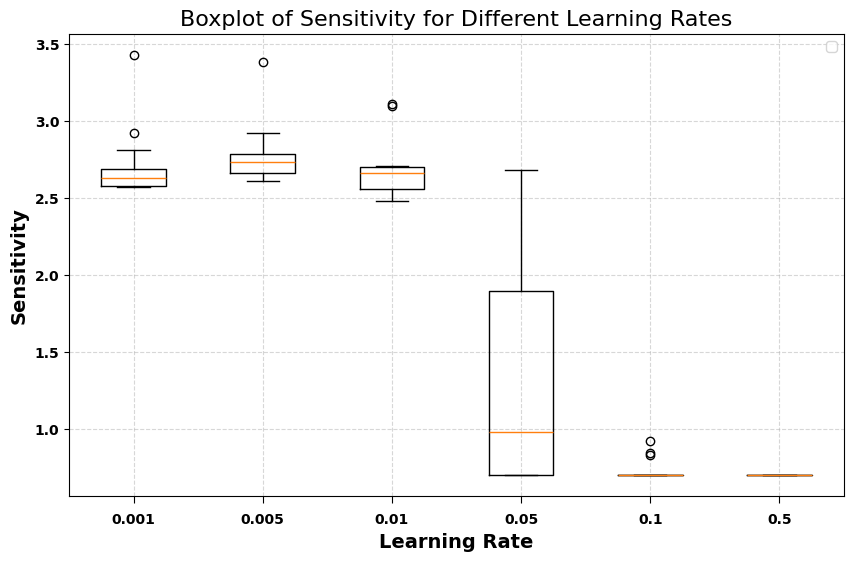

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(sensitivity_lr_tot, labels=[str(lr) for lr in learning_rate])
plt.xlabel('Learning Rate',fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('Boxplot of Sensitivity for Different Learning Rates',fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('boxplot_learning_rate.png',dpi=400)
files.download('boxplot_learning_rate.png')
plt.show()

In [ ]:
mean_sensitivities_lr = [np.mean(sens_list) for sens_list in sensitivity_lr_tot]
std_sensitivities_lr = [np.std(sens_list) for sens_list in sensitivity_lr_tot]

best_index_lr = np.argmax(mean_sensitivities_lr)
best_lr = learning_rate[best_index_lr]
best_sens_lr = mean_sensitivities_lr[best_index_lr]
best_std_lr = std_sensitivities_lr[best_index_lr]
print(f"Best learning rate: {best_lr} with average sensitivity: {best_sens_lr:.2f},standard deviation {best_std_lr:.2f}")

lr_result_df = pd.DataFrame({'Learning Rate': learning_rate, 'Mean Sensitivity': mean_sensitivities, 'Std': best_std_lr})
lr_result_df.sort_values(by='Mean Sensitivity', ascending=False, inplace=True)
print(lr_result_df.head())

Best learning rate: 0.005 with average sensitivity: 2.77,standard deviation 0.18
   Learning Rate  Mean Sensitivity       Std
1          0.005          2.768000  0.182618
0          0.001          2.702667  0.182618
2          0.010          2.673333  0.182618
3          0.050          1.317333  0.182618
4          0.100          0.732667  0.182618


## 4.2 Batch Size

In [ ]:
batch_size = [16,32,64,128]
iterations = 5

# define an empty list for storing sensitivity for each batch size count
sensitivity_bs_tot = []

In [ ]:
# iterate through the batch size values
for bs in batch_size:
  sensitivity_bs = [] # temporary list for current batch size setting
  for i in range(iterations):
    # learning rate chosen to be 0.005 from last part
    _, sensitivity = model_training_parameters(0.005,12,bs,13)
    sensitivity_bs.append(sensitivity)
  sensitivity_bs_tot.append(sensitivity_bs)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8694 - loss: 0.3735 - val_accuracy: 0.8964 - val_loss: 0.2674
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8951 - loss: 0.3220 - val_accuracy: 0.8982 - val_loss: 0.2619
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8968 - loss: 0.3157 - val_accuracy: 0.8945 - val_loss: 0.2721
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8973 - loss: 0.3148 - val_accuracy: 0.8984 - val_loss: 0.2692
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9002 - loss: 0.3082 - val_accuracy: 0.8987 - val_loss: 0.2612
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8992 - loss: 0.3053 - val_accuracy: 0.8969 - val_loss: 0.2648
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8992 - loss: 0.3058 - val_accuracy: 0.8988 - val_loss: 0.2640
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8984 - loss: 0.3054 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8736 - loss: 0.3683 - val_accuracy: 0.8973 - val_loss: 0.2660
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8948 - loss: 0.3190 - val_accuracy: 0.8949 - val_loss: 0.2655
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8973 - loss: 0.3151 - val_accuracy: 0.8960 - val_loss: 0.2810
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8981 - loss: 0.3077 - val_accuracy: 0.8952 - val_loss: 0.2684
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9000 - loss: 0.3077 - val_accuracy: 0.8930 - val_loss: 0.2704
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8976 - loss: 0.3102 - val_accuracy: 0.8977 - val_loss: 0.2598
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8992 - loss: 0.3039 - val_accuracy: 0.8969 - val_loss: 0.2584
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8990 - loss: 0.3050 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8651 - loss: 0.3928 - val_accuracy: 0.8974 - val_loss: 0.2786
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8946 - loss: 0.3249 - val_accuracy: 0.8964 - val_loss: 0.2652
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8955 - loss: 0.3192 - val_accuracy: 0.8958 - val_loss: 0.2666
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8960 - loss: 0.3141 - val_accuracy: 0.8995 - val_loss: 0.2648
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8997 - loss: 0.3077 - val_accuracy: 0.9004 - val_loss: 0.2561
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8997 - loss: 0.3094 - val_accuracy: 0.8943 - val_loss: 0.2591
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8964 - loss: 0.3168 - val_accuracy: 0.8978 - val_loss: 0.2686
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8996 - loss: 0.3061 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8716 - loss: 0.3740 - val_accuracy: 0.8962 - val_loss: 0.2645
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8965 - loss: 0.3153 - val_accuracy: 0.8985 - val_loss: 0.2666
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8982 - loss: 0.3166 - val_accuracy: 0.9002 - val_loss: 0.2593
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8980 - loss: 0.3067 - val_accuracy: 0.8985 - val_loss: 0.2736
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8990 - loss: 0.3067 - val_accuracy: 0.8987 - val_loss: 0.2612
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8998 - loss: 0.3028 - val_accuracy: 0.8984 - val_loss: 0.2682
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8977 - loss: 0.3098 - val_accuracy: 0.8990 - val_loss: 0.2574
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9000 - loss: 0.3048 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8773 - loss: 0.3681 - val_accuracy: 0.8892 - val_loss: 0.2791
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8943 - loss: 0.3186 - val_accuracy: 0.8950 - val_loss: 0.2650
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8973 - loss: 0.3090 - val_accuracy: 0.8979 - val_loss: 0.2624
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8983 - loss: 0.3108 - val_accuracy: 0.8993 - val_loss: 0.2554
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8961 - loss: 0.3096 - val_accuracy: 0.8993 - val_loss: 0.2568
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8990 - loss: 0.3103 - val_accuracy: 0.8990 - val_loss: 0.2611
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8972 - loss: 0.3072 - val_accuracy: 0.8979 - val_loss: 0.2691
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8996 - loss: 0.3050 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8713 - loss: 0.3784 - val_accuracy: 0.8966 - val_loss: 0.2687
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8953 - loss: 0.3211 - val_accuracy: 0.8951 - val_loss: 0.2730
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8965 - loss: 0.3136 - val_accuracy: 0.8966 - val_loss: 0.2682
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8975 - loss: 0.3107 - val_accuracy: 0.8990 - val_loss: 0.2595
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8994 - loss: 0.3068 - val_accuracy: 0.8980 - val_loss: 0.2707
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8977 - loss: 0.3100 - val_accuracy: 0.8986 - val_loss: 0.2604
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8985 - loss: 0.3030 - val_accuracy: 0.8985 - val_loss: 0.2676
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9002 - loss: 0.3043 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8707 - loss: 0.3770 - val_accuracy: 0.8924 - val_loss: 0.2693
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8935 - loss: 0.3302 - val_accuracy: 0.8958 - val_loss: 0.2677
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8970 - loss: 0.3175 - val_accuracy: 0.8933 - val_loss: 0.2626
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8989 - loss: 0.3103 - val_accuracy: 0.8988 - val_loss: 0.2617
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8992 - loss: 0.3077 - val_accuracy: 0.8997 - val_loss: 0.2602
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9000 - loss: 0.3061 - val_accuracy: 0.8984 - val_loss: 0.2620
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9004 - loss: 0.3039 - val_accuracy: 0.8968 - val_loss: 0.2625
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8972 - loss: 0.3076 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8743 - loss: 0.3698 - val_accuracy: 0.8830 - val_loss: 0.2978
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8943 - loss: 0.3199 - val_accuracy: 0.8978 - val_loss: 0.2650
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8958 - loss: 0.3209 - val_accuracy: 0.8965 - val_loss: 0.2637
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8978 - loss: 0.3136 - val_accuracy: 0.8958 - val_loss: 0.2600
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8984 - loss: 0.3108 - val_accuracy: 0.8958 - val_loss: 0.2602
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8959 - loss: 0.3108 - val_accuracy: 0.8968 - val_loss: 0.2612
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9003 - loss: 0.3078 - val_accuracy: 0.8957 - val_loss: 0.2679
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8998 - loss: 0.3034 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8750 - loss: 0.3693 - val_accuracy: 0.8953 - val_loss: 0.2741
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8951 - loss: 0.3260 - val_accuracy: 0.8988 - val_loss: 0.2726
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8962 - loss: 0.3145 - val_accuracy: 0.8971 - val_loss: 0.2630
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8976 - loss: 0.3104 - val_accuracy: 0.8925 - val_loss: 0.2607
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8959 - loss: 0.3164 - val_accuracy: 0.8989 - val_loss: 0.2575
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8992 - loss: 0.3058 - val_accuracy: 0.8997 - val_loss: 0.2569
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9000 - loss: 0.3078 - val_accuracy: 0.8949 - val_loss: 0.2595
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8970 - loss: 0.3092 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8763 - loss: 0.3678 - val_accuracy: 0.8835 - val_loss: 0.2971
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8931 - loss: 0.3279 - val_accuracy: 0.8980 - val_loss: 0.2635
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8939 - loss: 0.3206 - val_accuracy: 0.8849 - val_loss: 0.2802
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8978 - loss: 0.3112 - val_accuracy: 0.8952 - val_loss: 0.2740
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8987 - loss: 0.3089 - val_accuracy: 0.8982 - val_loss: 0.2663
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8992 - loss: 0.3025 - val_accuracy: 0.8984 - val_loss: 0.2600
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8978 - loss: 0.3057 - val_accuracy: 0.8985 - val_loss: 0.2677
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9002 - loss: 0.3060 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8711 - loss: 0.3745 - val_accuracy: 0.8925 - val_loss: 0.2761
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8926 - loss: 0.3293 - val_accuracy: 0.8941 - val_loss: 0.2658
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8954 - loss: 0.3210 - val_accuracy: 0.8965 - val_loss: 0.2686
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8979 - loss: 0.3087 - val_accuracy: 0.8975 - val_loss: 0.2691
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8965 - loss: 0.3179 - val_accuracy: 0.8939 - val_loss: 0.2630
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8977 - loss: 0.3019 - val_accuracy: 0.8960 - val_loss: 0.2654
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8985 - loss: 0.3103 - val_accuracy: 0.8932 - val_loss: 0.2705
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9009 - loss: 0.3003 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8729 - loss: 0.3789 - val_accuracy: 0.8959 - val_loss: 0.2674
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8950 - loss: 0.3159 - val_accuracy: 0.8976 - val_loss: 0.2692
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8975 - loss: 0.3191 - val_accuracy: 0.8982 - val_loss: 0.2670
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8980 - loss: 0.3086 - val_accuracy: 0.8991 - val_loss: 0.2589
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8978 - loss: 0.3117 - val_accuracy: 0.8973 - val_loss: 0.2623
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8961 - loss: 0.3091 - val_accuracy: 0.8941 - val_loss: 0.2614
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8997 - loss: 0.3034 - val_accuracy: 0.8992 - val_loss: 0.2594
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8995 - loss: 0.3062 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8724 - loss: 0.3711 - val_accuracy: 0.8805 - val_loss: 0.3049
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8953 - loss: 0.3230 - val_accuracy: 0.8930 - val_loss: 0.2668
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8976 - loss: 0.3163 - val_accuracy: 0.8984 - val_loss: 0.2641
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8971 - loss: 0.3122 - val_accuracy: 0.8969 - val_loss: 0.2674
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8980 - loss: 0.3104 - val_accuracy: 0.8994 - val_loss: 0.2608
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9004 - loss: 0.3008 - val_accuracy: 0.8971 - val_loss: 0.2607
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8988 - loss: 0.3077 - val_accuracy: 0.8975 - val_loss: 0.2619
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8993 - loss: 0.3010 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8743 - loss: 0.3684 - val_accuracy: 0.8985 - val_loss: 0.2651
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8937 - loss: 0.3202 - val_accuracy: 0.8967 - val_loss: 0.2748
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8987 - loss: 0.3073 - val_accuracy: 0.8960 - val_loss: 0.2677
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8977 - loss: 0.3141 - val_accuracy: 0.8950 - val_loss: 0.2648
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8974 - loss: 0.3132 - val_accuracy: 0.8954 - val_loss: 0.2649
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8960 - loss: 0.3090 - val_accuracy: 0.8985 - val_loss: 0.2581
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8969 - loss: 0.3101 - val_accuracy: 0.8998 - val_loss: 0.2640
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8986 - loss: 0.3093 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8690 - loss: 0.3758 - val_accuracy: 0.8919 - val_loss: 0.2793
Epoch 2/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8944 - loss: 0.3232 - val_accuracy: 0.8960 - val_loss: 0.2599
Epoch 3/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8970 - loss: 0.3172 - val_accuracy: 0.8964 - val_loss: 0.2618
Epoch 4/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8983 - loss: 0.3117 - val_accuracy: 0.8987 - val_loss: 0.2600
Epoch 5/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8978 - loss: 0.3137 - val_accuracy: 0.8984 - val_loss: 0.2637
Epoch 6/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8955 - loss: 0.3096 - val_accuracy: 0.8958 - val_loss: 0.2647
Epoch 7/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8977 - loss: 0.3057 - val_accuracy: 0.8996 - val_loss: 0.2618
Epoch 8/12
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8995 - loss: 0.3086 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8690 - loss: 0.3790 - val_accuracy: 0.8906 - val_loss: 0.2701
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.3190 - val_accuracy: 0.8934 - val_loss: 0.2678
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8992 - loss: 0.3088 - val_accuracy: 0.8985 - val_loss: 0.2584
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8979 - loss: 0.3107 - val_accuracy: 0.8970 - val_loss: 0.2637
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8972 - loss: 0.3122 - val_accuracy: 0.9013 - val_loss: 0.2575
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8989 - loss: 0.3032 - val_accuracy: 0.8965 - val_loss: 0.2624
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8996 - loss: 0.3040 - val_accuracy: 0.8967 - val_loss: 0.2591
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9005 - loss: 0.3041 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8706 - loss: 0.3770 - val_accuracy: 0.8984 - val_loss: 0.2680
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.3208 - val_accuracy: 0.8931 - val_loss: 0.2739
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8959 - loss: 0.3142 - val_accuracy: 0.8952 - val_loss: 0.2634
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8970 - loss: 0.3157 - val_accuracy: 0.8990 - val_loss: 0.2628
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8994 - loss: 0.3039 - val_accuracy: 0.8961 - val_loss: 0.2675
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8992 - loss: 0.3086 - val_accuracy: 0.8973 - val_loss: 0.2613
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8989 - loss: 0.3046 - val_accuracy: 0.9009 - val_loss: 0.2649
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9007 - loss: 0.2980 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8696 - loss: 0.3798 - val_accuracy: 0.8978 - val_loss: 0.2677
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8943 - loss: 0.3214 - val_accuracy: 0.8947 - val_loss: 0.2725
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3190 - val_accuracy: 0.8975 - val_loss: 0.2594
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8997 - loss: 0.3074 - val_accuracy: 0.8983 - val_loss: 0.2642
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9006 - loss: 0.3041 - val_accuracy: 0.8991 - val_loss: 0.2614
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9001 - loss: 0.3084 - val_accuracy: 0.9005 - val_loss: 0.2575
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3037 - val_accuracy: 0.8981 - val_loss: 0.2614
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3052 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8577 - loss: 0.4275 - val_accuracy: 0.8962 - val_loss: 0.2756
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3227 - val_accuracy: 0.8987 - val_loss: 0.2593
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8977 - loss: 0.3120 - val_accuracy: 0.8990 - val_loss: 0.2617
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8981 - loss: 0.3062 - val_accuracy: 0.8991 - val_loss: 0.2599
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8982 - loss: 0.3111 - val_accuracy: 0.8969 - val_loss: 0.2688
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8985 - loss: 0.3068 - val_accuracy: 0.8954 - val_loss: 0.2637
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8985 - loss: 0.3074 - val_accuracy: 0.8971 - val_loss: 0.2676
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9007 - loss: 0.3008 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8663 - loss: 0.3803 - val_accuracy: 0.8913 - val_loss: 0.2773
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8933 - loss: 0.3283 - val_accuracy: 0.8956 - val_loss: 0.2649
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8965 - loss: 0.3133 - val_accuracy: 0.9005 - val_loss: 0.2555
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8984 - loss: 0.3065 - val_accuracy: 0.8976 - val_loss: 0.2710
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8976 - loss: 0.3115 - val_accuracy: 0.8992 - val_loss: 0.2641
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8968 - loss: 0.3100 - val_accuracy: 0.9002 - val_loss: 0.2586
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8993 - loss: 0.3045 - val_accuracy: 0.8987 - val_loss: 0.2577
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9005 - loss: 0.3035 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8684 - loss: 0.3789 - val_accuracy: 0.8968 - val_loss: 0.2679
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8917 - loss: 0.3283 - val_accuracy: 0.8945 - val_loss: 0.2662
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8971 - loss: 0.3151 - val_accuracy: 0.8828 - val_loss: 0.2857
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8982 - loss: 0.3095 - val_accuracy: 0.8963 - val_loss: 0.2742
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8981 - loss: 0.3019 - val_accuracy: 0.8953 - val_loss: 0.2602
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8990 - loss: 0.3011 - val_accuracy: 0.9006 - val_loss: 0.2573
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3067 - val_accuracy: 0.8982 - val_loss: 0.2660
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8999 - loss: 0.3027 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8706 - loss: 0.3841 - val_accuracy: 0.8943 - val_loss: 0.2721
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8930 - loss: 0.3265 - val_accuracy: 0.8985 - val_loss: 0.2617
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8977 - loss: 0.3089 - val_accuracy: 0.8937 - val_loss: 0.2698
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3142 - val_accuracy: 0.9000 - val_loss: 0.2577
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8986 - loss: 0.3102 - val_accuracy: 0.8983 - val_loss: 0.2585
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8995 - loss: 0.3022 - val_accuracy: 0.8973 - val_loss: 0.2668
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3002 - val_accuracy: 0.8993 - val_loss: 0.2653
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9013 - loss: 0.2998 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8700 - loss: 0.3753 - val_accuracy: 0.8955 - val_loss: 0.2707
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8939 - loss: 0.3204 - val_accuracy: 0.8979 - val_loss: 0.2610
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8954 - loss: 0.3154 - val_accuracy: 0.8988 - val_loss: 0.2570
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3091 - val_accuracy: 0.8971 - val_loss: 0.2627
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8964 - loss: 0.3139 - val_accuracy: 0.8976 - val_loss: 0.2604
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8998 - loss: 0.3051 - val_accuracy: 0.8968 - val_loss: 0.2591
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8981 - loss: 0.3048 - val_accuracy: 0.8993 - val_loss: 0.2591
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9002 - loss: 0.3012 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8695 - loss: 0.3887 - val_accuracy: 0.8917 - val_loss: 0.2683
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8955 - loss: 0.3222 - val_accuracy: 0.8947 - val_loss: 0.2738
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8969 - loss: 0.3109 - val_accuracy: 0.8901 - val_loss: 0.2761
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8962 - loss: 0.3139 - val_accuracy: 0.8964 - val_loss: 0.2758
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8989 - loss: 0.3150 - val_accuracy: 0.8971 - val_loss: 0.2613
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8997 - loss: 0.3075 - val_accuracy: 0.8993 - val_loss: 0.2547
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8986 - loss: 0.3032 - val_accuracy: 0.9007 - val_loss: 0.2585
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8988 - loss: 0.3002 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8673 - loss: 0.3923 - val_accuracy: 0.8939 - val_loss: 0.2717
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8942 - loss: 0.3220 - val_accuracy: 0.9007 - val_loss: 0.2614
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3113 - val_accuracy: 0.8993 - val_loss: 0.2617
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8971 - loss: 0.3058 - val_accuracy: 0.8993 - val_loss: 0.2610
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3021 - val_accuracy: 0.8988 - val_loss: 0.2576
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9013 - loss: 0.2996 - val_accuracy: 0.8944 - val_loss: 0.2662
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8998 - loss: 0.3051 - val_accuracy: 0.8981 - val_loss: 0.2614
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9000 - loss: 0.3032 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8683 - loss: 0.3746 - val_accuracy: 0.8921 - val_loss: 0.2719
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8957 - loss: 0.3166 - val_accuracy: 0.8937 - val_loss: 0.2692
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8953 - loss: 0.3163 - val_accuracy: 0.8958 - val_loss: 0.2667
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8961 - loss: 0.3191 - val_accuracy: 0.8976 - val_loss: 0.2693
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8974 - loss: 0.3091 - val_accuracy: 0.8999 - val_loss: 0.2631
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9000 - loss: 0.3055 - val_accuracy: 0.8976 - val_loss: 0.2794
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8994 - loss: 0.3034 - val_accuracy: 0.8985 - val_loss: 0.2678
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3086 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8722 - loss: 0.3768 - val_accuracy: 0.8956 - val_loss: 0.2733
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8944 - loss: 0.3221 - val_accuracy: 0.8968 - val_loss: 0.2646
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8957 - loss: 0.3158 - val_accuracy: 0.8970 - val_loss: 0.2653
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8973 - loss: 0.3097 - val_accuracy: 0.8970 - val_loss: 0.2631
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8974 - loss: 0.3036 - val_accuracy: 0.9000 - val_loss: 0.2622
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8988 - loss: 0.3093 - val_accuracy: 0.8973 - val_loss: 0.2596
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9001 - loss: 0.2986 - val_accuracy: 0.9020 - val_loss: 0.2554
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9005 - loss: 0.3002 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8691 - loss: 0.3833 - val_accuracy: 0.8974 - val_loss: 0.2660
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.3181 - val_accuracy: 0.8979 - val_loss: 0.2613
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8963 - loss: 0.3163 - val_accuracy: 0.8987 - val_loss: 0.2640
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3098 - val_accuracy: 0.8993 - val_loss: 0.2646
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9003 - loss: 0.3057 - val_accuracy: 0.8974 - val_loss: 0.2604
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8999 - loss: 0.3019 - val_accuracy: 0.8982 - val_loss: 0.2639
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3061 - val_accuracy: 0.8993 - val_loss: 0.2591
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8979 - loss: 0.3060 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8623 - loss: 0.3961 - val_accuracy: 0.8953 - val_loss: 0.2660
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8955 - loss: 0.3236 - val_accuracy: 0.8986 - val_loss: 0.2675
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8965 - loss: 0.3139 - val_accuracy: 0.8965 - val_loss: 0.2661
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8975 - loss: 0.3111 - val_accuracy: 0.8993 - val_loss: 0.2606
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8991 - loss: 0.3079 - val_accuracy: 0.8966 - val_loss: 0.2614
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8990 - loss: 0.3050 - val_accuracy: 0.8976 - val_loss: 0.2594
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8995 - loss: 0.3023 - val_accuracy: 0.8965 - val_loss: 0.2662
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8981 - loss: 0.3075 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8630 - loss: 0.4051 - val_accuracy: 0.8968 - val_loss: 0.2690
Epoch 2/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8957 - loss: 0.3202 - val_accuracy: 0.8972 - val_loss: 0.2628
Epoch 3/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8995 - loss: 0.3024 - val_accuracy: 0.8962 - val_loss: 0.2643
Epoch 4/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9011 - loss: 0.3031 - val_accuracy: 0.9000 - val_loss: 0.2563
Epoch 5/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8985 - loss: 0.3080 - val_accuracy: 0.8999 - val_loss: 0.2593
Epoch 6/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9000 - loss: 0.3028 - val_accuracy: 0.8985 - val_loss: 0.2588
Epoch 7/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3068 - val_accuracy: 0.8973 - val_loss: 0.2572
Epoch 8/12
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8970 - loss: 0.3043 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8683 - loss: 0.3788 - val_accuracy: 0.8896 - val_loss: 0.2768
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3121 - val_accuracy: 0.8987 - val_loss: 0.2583
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3166 - val_accuracy: 0.8979 - val_loss: 0.2626
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3026 - val_accuracy: 0.8981 - val_loss: 0.2616
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.2968 - val_accuracy: 0.8955 - val_loss: 0.2629
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3044 - val_accuracy: 0.8955 - val_loss: 0.2613
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.3004 - val_accuracy: 0.8975 - val_loss: 0.2609
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3040 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8693 - loss: 0.3791 - val_accuracy: 0.8964 - val_loss: 0.2665
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8945 - loss: 0.3225 - val_accuracy: 0.8982 - val_loss: 0.2600
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3106 - val_accuracy: 0.8922 - val_loss: 0.2781
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3050 - val_accuracy: 0.9004 - val_loss: 0.2606
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3105 - val_accuracy: 0.8958 - val_loss: 0.2645
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3114 - val_accuracy: 0.8988 - val_loss: 0.2562
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.3042 - val_accuracy: 0.9002 - val_loss: 0.2568
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.2980 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8560 - loss: 0.4414 - val_accuracy: 0.8956 - val_loss: 0.2843
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.3280 - val_accuracy: 0.8960 - val_loss: 0.2682
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3125 - val_accuracy: 0.8971 - val_loss: 0.2674
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3117 - val_accuracy: 0.8987 - val_loss: 0.2820
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3141 - val_accuracy: 0.9008 - val_loss: 0.2602
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3058 - val_accuracy: 0.8968 - val_loss: 0.2621
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.3037 - val_accuracy: 0.8986 - val_loss: 0.2671
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3080 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8659 - loss: 0.3914 - val_accuracy: 0.8970 - val_loss: 0.2758
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8962 - loss: 0.3156 - val_accuracy: 0.8997 - val_loss: 0.2608
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3134 - val_accuracy: 0.8997 - val_loss: 0.2608
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3057 - val_accuracy: 0.8991 - val_loss: 0.2605
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.2995 - val_accuracy: 0.8985 - val_loss: 0.2613
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3047 - val_accuracy: 0.9002 - val_loss: 0.2580
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3044 - val_accuracy: 0.8980 - val_loss: 0.2584
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9019 - loss: 0.2976 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8670 - loss: 0.3838 - val_accuracy: 0.8944 - val_loss: 0.2752
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3153 - val_accuracy: 0.8959 - val_loss: 0.2663
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8963 - loss: 0.3132 - val_accuracy: 0.8988 - val_loss: 0.2622
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3097 - val_accuracy: 0.8997 - val_loss: 0.2577
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3059 - val_accuracy: 0.8991 - val_loss: 0.2581
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3042 - val_accuracy: 0.8952 - val_loss: 0.2610
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3035 - val_accuracy: 0.8974 - val_loss: 0.2572
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.3015 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8556 - loss: 0.3905 - val_accuracy: 0.8972 - val_loss: 0.2705
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3150 - val_accuracy: 0.8957 - val_loss: 0.2625
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3109 - val_accuracy: 0.8950 - val_loss: 0.2671
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3093 - val_accuracy: 0.9001 - val_loss: 0.2594
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3096 - val_accuracy: 0.8972 - val_loss: 0.2573
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3058 - val_accuracy: 0.9003 - val_loss: 0.2595
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3062 - val_accuracy: 0.8981 - val_loss: 0.2623
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.2976 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8681 - loss: 0.3803 - val_accuracy: 0.8969 - val_loss: 0.2688
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3186 - val_accuracy: 0.8968 - val_loss: 0.2684
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.3089 - val_accuracy: 0.8930 - val_loss: 0.2709
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3104 - val_accuracy: 0.8989 - val_loss: 0.2632
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3025 - val_accuracy: 0.8970 - val_loss: 0.2594
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3013 - val_accuracy: 0.8995 - val_loss: 0.2561
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3029 - val_accuracy: 0.8996 - val_loss: 0.2545
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.2993 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8628 - loss: 0.3912 - val_accuracy: 0.8950 - val_loss: 0.2709
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3189 - val_accuracy: 0.8977 - val_loss: 0.2609
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8961 - loss: 0.3139 - val_accuracy: 0.8977 - val_loss: 0.2622
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3167 - val_accuracy: 0.8994 - val_loss: 0.2601
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3112 - val_accuracy: 0.8938 - val_loss: 0.2663
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3049 - val_accuracy: 0.8999 - val_loss: 0.2582
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.3044 - val_accuracy: 0.9010 - val_loss: 0.2622
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.2994 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8665 - loss: 0.3893 - val_accuracy: 0.8955 - val_loss: 0.2673
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3208 - val_accuracy: 0.8935 - val_loss: 0.2802
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8952 - loss: 0.3192 - val_accuracy: 0.9002 - val_loss: 0.2642
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3095 - val_accuracy: 0.8991 - val_loss: 0.2632
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9017 - loss: 0.3043 - val_accuracy: 0.8996 - val_loss: 0.2553
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.3024 - val_accuracy: 0.8987 - val_loss: 0.2555
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3013 - val_accuracy: 0.9010 - val_loss: 0.2603
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3000 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8620 - loss: 0.3844 - val_accuracy: 0.8976 - val_loss: 0.2670
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3160 - val_accuracy: 0.8981 - val_loss: 0.2588
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3144 - val_accuracy: 0.8991 - val_loss: 0.2556
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3106 - val_accuracy: 0.8991 - val_loss: 0.2570
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.3027 - val_accuracy: 0.8964 - val_loss: 0.2625
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3096 - val_accuracy: 0.8971 - val_loss: 0.2573
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3017 - val_accuracy: 0.9011 - val_loss: 0.2534
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.2966 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8523 - loss: 0.3977 - val_accuracy: 0.8925 - val_loss: 0.2744
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8962 - loss: 0.3191 - val_accuracy: 0.8994 - val_loss: 0.2694
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8977 - loss: 0.3122 - val_accuracy: 0.9001 - val_loss: 0.2599
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3023 - val_accuracy: 0.9002 - val_loss: 0.2603
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.3028 - val_accuracy: 0.8988 - val_loss: 0.2612
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.3000 - val_accuracy: 0.8986 - val_loss: 0.2626
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3038 - val_accuracy: 0.9011 - val_loss: 0.2581
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3054 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8602 - loss: 0.4322 - val_accuracy: 0.8874 - val_loss: 0.2770
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3178 - val_accuracy: 0.8942 - val_loss: 0.2723
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3101 - val_accuracy: 0.8984 - val_loss: 0.2616
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3049 - val_accuracy: 0.8935 - val_loss: 0.2736
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3008 - val_accuracy: 0.8976 - val_loss: 0.2602
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3007 - val_accuracy: 0.9002 - val_loss: 0.2545
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3009 - val_accuracy: 0.8981 - val_loss: 0.2633
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.2935 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8547 - loss: 0.4210 - val_accuracy: 0.8985 - val_loss: 0.2673
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3195 - val_accuracy: 0.8993 - val_loss: 0.2656
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3117 - val_accuracy: 0.8992 - val_loss: 0.2575
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3056 - val_accuracy: 0.8990 - val_loss: 0.2584
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.3057 - val_accuracy: 0.9022 - val_loss: 0.2553
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.2991 - val_accuracy: 0.9013 - val_loss: 0.2569
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3028 - val_accuracy: 0.8995 - val_loss: 0.2590
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2953 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8726 - loss: 0.3770 - val_accuracy: 0.8889 - val_loss: 0.2897
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8925 - loss: 0.3267 - val_accuracy: 0.8974 - val_loss: 0.2592
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.3036 - val_accuracy: 0.8964 - val_loss: 0.2674
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3097 - val_accuracy: 0.8953 - val_loss: 0.2637
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.3087 - val_accuracy: 0.8997 - val_loss: 0.2641
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3043 - val_accuracy: 0.9001 - val_loss: 0.2643
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.3065 - val_accuracy: 0.8979 - val_loss: 0.2587
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3013 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8643 - loss: 0.3857 - val_accuracy: 0.8950 - val_loss: 0.2701
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8946 - loss: 0.3185 - val_accuracy: 0.8967 - val_loss: 0.2634
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3095 - val_accuracy: 0.8988 - val_loss: 0.2631
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3099 - val_accuracy: 0.8961 - val_loss: 0.2612
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.3050 - val_accuracy: 0.8974 - val_loss: 0.2595
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9010 - loss: 0.2985 - val_accuracy: 0.9008 - val_loss: 0.2620
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3104 - val_accuracy: 0.8980 - val_loss: 0.2588
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.3001 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8529 - loss: 0.4005 - val_accuracy: 0.8962 - val_loss: 0.2686
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8957 - loss: 0.3193 - val_accuracy: 0.8970 - val_loss: 0.2722
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8968 - loss: 0.3093 - val_accuracy: 0.8981 - val_loss: 0.2623
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8999 - loss: 0.3036 - val_accuracy: 0.9001 - val_loss: 0.2570
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8994 - loss: 0.3051 - val_accuracy: 0.8977 - val_loss: 0.2631
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.3017 - val_accuracy: 0.8988 - val_loss: 0.2575
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8997 - loss: 0.3033 - val_accuracy: 0.8991 - val_loss: 0.2564
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9005 - loss: 0.3005 - val_accuracy: 0.8956 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8539 - loss: 0.4042 - val_accuracy: 0.8918 - val_loss: 0.2768
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8959 - loss: 0.3225 - val_accuracy: 0.8988 - val_loss: 0.2614
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9000 - loss: 0.3081 - val_accuracy: 0.8964 - val_loss: 0.2656
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.3065 - val_accuracy: 0.9005 - val_loss: 0.2549
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8999 - loss: 0.2993 - val_accuracy: 0.8933 - val_loss: 0.2768
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9008 - loss: 0.3055 - val_accuracy: 0.8986 - val_loss: 0.2611
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.3008 - val_accuracy: 0.9005 - val_loss: 0.2576
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.3033 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8569 - loss: 0.4014 - val_accuracy: 0.8965 - val_loss: 0.2646
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8950 - loss: 0.3173 - val_accuracy: 0.8974 - val_loss: 0.2587
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8983 - loss: 0.3107 - val_accuracy: 0.8997 - val_loss: 0.2561
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8978 - loss: 0.3139 - val_accuracy: 0.8985 - val_loss: 0.2567
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9001 - loss: 0.2976 - val_accuracy: 0.8935 - val_loss: 0.2686
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8979 - loss: 0.3090 - val_accuracy: 0.8984 - val_loss: 0.2577
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.2954 - val_accuracy: 0.8988 - val_loss: 0.2602
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.2946 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8352 - loss: 0.4681 - val_accuracy: 0.8941 - val_loss: 0.2903
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8955 - loss: 0.3306 - val_accuracy: 0.8981 - val_loss: 0.2715
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8984 - loss: 0.3170 - val_accuracy: 0.8973 - val_loss: 0.2692
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8980 - loss: 0.3143 - val_accuracy: 0.8984 - val_loss: 0.2620
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9005 - loss: 0.3084 - val_accuracy: 0.8978 - val_loss: 0.2611
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.3066 - val_accuracy: 0.8944 - val_loss: 0.2706
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8973 - loss: 0.3105 - val_accuracy: 0.8986 - val_loss: 0.2576
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9027 - loss: 0.2973 - val_accuracy: 0.9002 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8515 - loss: 0.4031 - val_accuracy: 0.8950 - val_loss: 0.2709
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8956 - loss: 0.3227 - val_accuracy: 0.8968 - val_loss: 0.2654
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8981 - loss: 0.3139 - val_accuracy: 0.8994 - val_loss: 0.2575
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.3096 - val_accuracy: 0.8997 - val_loss: 0.2592
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.3072 - val_accuracy: 0.8980 - val_loss: 0.2607
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8992 - loss: 0.3062 - val_accuracy: 0.8973 - val_loss: 0.2653
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9010 - loss: 0.3005 - val_accuracy: 0.9002 - val_loss: 0.2573
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9003 - loss: 0.2985 - val_accuracy: 0.8995 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8500 - loss: 0.4082 - val_accuracy: 0.8982 - val_loss: 0.2666
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8968 - loss: 0.3156 - val_accuracy: 0.8926 - val_loss: 0.2720
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.3073 - val_accuracy: 0.8995 - val_loss: 0.2598
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.3056 - val_accuracy: 0.8947 - val_loss: 0.2657
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9010 - loss: 0.2966 - val_accuracy: 0.8940 - val_loss: 0.2743
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8995 - loss: 0.3054 - val_accuracy: 0.8952 - val_loss: 0.2639
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9004 - loss: 0.2981 - val_accuracy: 0.8987 - val_loss: 0.2577
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9005 - loss: 0.2999 - val_accuracy: 0.8973 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8644 - loss: 0.3873 - val_accuracy: 0.8918 - val_loss: 0.2735
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8934 - loss: 0.3231 - val_accuracy: 0.8967 - val_loss: 0.2697
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8971 - loss: 0.3161 - val_accuracy: 0.8980 - val_loss: 0.2596
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8999 - loss: 0.3121 - val_accuracy: 0.8943 - val_loss: 0.2635
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9026 - loss: 0.2962 - val_accuracy: 0.9002 - val_loss: 0.2603
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8998 - loss: 0.3014 - val_accuracy: 0.8988 - val_loss: 0.2604
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8986 - loss: 0.3044 - val_accuracy: 0.9001 - val_loss: 0.2574
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8980 - loss: 0.3022 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8446 - loss: 0.5126 - val_accuracy: 0.8981 - val_loss: 0.2974
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8935 - loss: 0.3435 - val_accuracy: 0.8998 - val_loss: 0.2713
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.3130 - val_accuracy: 0.8993 - val_loss: 0.2643
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8960 - loss: 0.3210 - val_accuracy: 0.8967 - val_loss: 0.2704
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.3075 - val_accuracy: 0.8985 - val_loss: 0.2603
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.3030 - val_accuracy: 0.8999 - val_loss: 0.2610
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.3041 - val_accuracy: 0.8994 - val_loss: 0.2591
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.3008 - val_accuracy: 0.8996 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8507 - loss: 0.4094 - val_accuracy: 0.8968 - val_loss: 0.2692
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8957 - loss: 0.3222 - val_accuracy: 0.8990 - val_loss: 0.2617
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.3137 - val_accuracy: 0.8958 - val_loss: 0.2608
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.3129 - val_accuracy: 0.8995 - val_loss: 0.2560
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.3036 - val_accuracy: 0.9000 - val_loss: 0.2590
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.3019 - val_accuracy: 0.9005 - val_loss: 0.2528
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.3049 - val_accuracy: 0.8986 - val_loss: 0.2602
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.2995 - val_accuracy: 0.9005 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8564 - loss: 0.4085 - val_accuracy: 0.8855 - val_loss: 0.2819
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8964 - loss: 0.3187 - val_accuracy: 0.8980 - val_loss: 0.2668
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.3148 - val_accuracy: 0.8901 - val_loss: 0.2739
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.3074 - val_accuracy: 0.8962 - val_loss: 0.2589
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.3042 - val_accuracy: 0.8983 - val_loss: 0.2591
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.2999 - val_accuracy: 0.9004 - val_loss: 0.2572
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.3011 - val_accuracy: 0.9000 - val_loss: 0.2584
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.2957 - val_accuracy: 0.9020 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8587 - loss: 0.3978 - val_accuracy: 0.8922 - val_loss: 0.2672
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.3163 - val_accuracy: 0.8971 - val_loss: 0.2626
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.3100 - val_accuracy: 0.8968 - val_loss: 0.2618
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.3064 - val_accuracy: 0.8989 - val_loss: 0.2568
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.3033 - val_accuracy: 0.8984 - val_loss: 0.2582
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.2984 - val_accuracy: 0.8984 - val_loss: 0.2586
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.3042 - val_accuracy: 0.8989 - val_loss: 0.2562
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.3064 - val_accuracy: 0.8987 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8548 - loss: 0.3978 - val_accuracy: 0.8952 - val_loss: 0.2688
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8975 - loss: 0.3182 - val_accuracy: 0.8884 - val_loss: 0.2860
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.3175 - val_accuracy: 0.8993 - val_loss: 0.2601
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.3042 - val_accuracy: 0.8996 - val_loss: 0.2630
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.3019 - val_accuracy: 0.8993 - val_loss: 0.2602
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.2974 - val_accuracy: 0.8992 - val_loss: 0.2599
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.3079 - val_accuracy: 0.9005 - val_loss: 0.2567
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.2979 - val_accuracy: 0.8988 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8460 - loss: 0.4165 - val_accuracy: 0.8932 - val_loss: 0.2729
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8956 - loss: 0.3219 - val_accuracy: 0.8994 - val_loss: 0.2676
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.3149 - val_accuracy: 0.8973 - val_loss: 0.2601
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.3045 - val_accuracy: 0.8958 - val_loss: 0.2626
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.3041 - val_accuracy: 0.8978 - val_loss: 0.2646
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.3025 - val_accuracy: 0.8973 - val_loss: 0.2630
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.3003 - val_accuracy: 0.8968 - val_loss: 0.2614
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.2968 - val_accuracy: 0.8984 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8535 - loss: 0.4084 - val_accuracy: 0.8965 - val_loss: 0.2731
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.3226 - val_accuracy: 0.8988 - val_loss: 0.2607
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.3139 - val_accuracy: 0.8961 - val_loss: 0.2616
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.3062 - val_accuracy: 0.8969 - val_loss: 0.2619
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.3057 - val_accuracy: 0.8998 - val_loss: 0.2569
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.3032 - val_accuracy: 0.8990 - val_loss: 0.2597
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.3062 - val_accuracy: 0.8973 - val_loss: 0.2611
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.2975 - val_accuracy: 0.9007 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8528 - loss: 0.5132 - val_accuracy: 0.8914 - val_loss: 0.3034
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.3378 - val_accuracy: 0.8955 - val_loss: 0.2758
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8961 - loss: 0.3210 - val_accuracy: 0.8991 - val_loss: 0.2643
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.3117 - val_accuracy: 0.8998 - val_loss: 0.2652
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.3102 - val_accuracy: 0.9002 - val_loss: 0.2605
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.3081 - val_accuracy: 0.8999 - val_loss: 0.2603
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.3032 - val_accuracy: 0.8985 - val_loss: 0.2594
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.3014 - val_accuracy: 0.9002 - val_

<ipython-input-45-769ba290edbf>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sensitivity_bs_tot, labels=[str(bs) for bs in batch_size])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

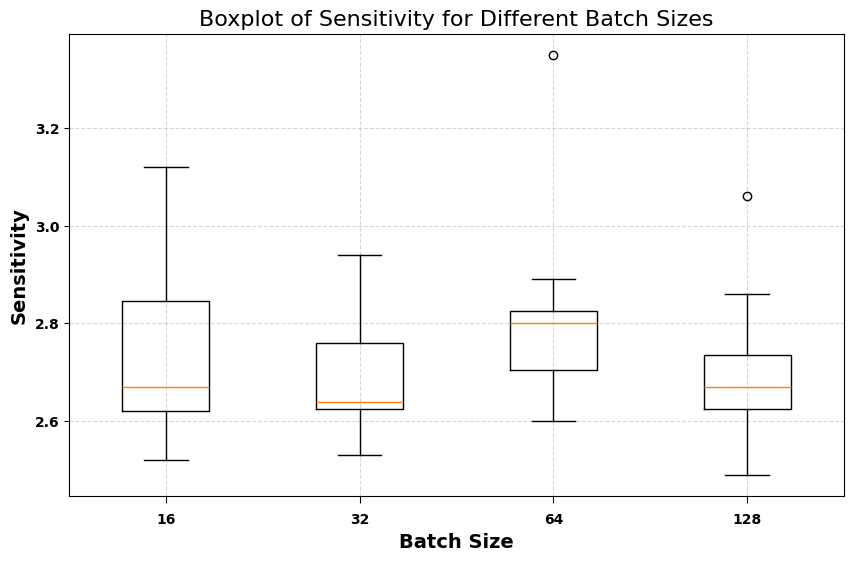

In [ ]:
# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(sensitivity_bs_tot, labels=[str(bs) for bs in batch_size])
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('Boxplot of Sensitivity for Different Batch Sizes', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('boxplot_batch_size.png',dpi=400)
files.download('boxplot_batch_size.png')
plt.show()

mean_sensitivities = [np.mean(sens_list) for sens_list in sensitivity_bs_tot]

In [ ]:
mean_sens_bs = [np.mean(s) for s in sensitivity_bs_tot]
std_sens_bs = [np.std(s) for s in sensitivity_bs_tot]
best_bs_index = np.argmax(mean_sens_bs)
best_bs = batch_size[best_bs_index]

print(f"Best batch size: {best_bs} with average sensitivity: {mean_sens_bs[best_bs_index]:.2f}, standard deviation: {std_sens_bs[best_bs_index]:.2f}")

bs_result_df = pd.DataFrame({'Batch Size': batch_size, 'Mean Sensitivity': mean_sens_bs, 'std':std_sens_bs})
bs_result_df.sort_values(by='Mean Sensitivity', ascending=False, inplace=True)
print(bs_result_df.head())

Best batch size: 64 with average sensitivity: 2.79, standard deviation: 0.17
   Batch Size  Mean Sensitivity       std
2          64          2.794667  0.170875
0          16          2.734000  0.172426
1          32          2.694000  0.106195
3         128          2.691333  0.137058


## 4.3 Epochs

In [ ]:
epoch_list = list(range(1, 13))  # 1 to 12 epochs
iterations = 5

In [ ]:
# define an empty list for storing sensitivity for each epoch count
sensitivity_tot_epochs = []

# iterate through the epoch values
for epochs in epoch_list:
    sensitivity_epochs = []  # temporary list for current epoch setting
    for _ in range(iterations):
        _, sensitivity = model_training_parameters(0.005, epochs, 64, 13)
        sensitivity_epochs.append(sensitivity)
    sensitivity_tot_epochs.append(sensitivity_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8627 - loss: 0.3772 - val_accuracy: 0.8940 - val_loss: 0.2757
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8703 - loss: 0.3801 - val_accuracy: 0.8993 - val_loss: 0.2645
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8714 - loss: 0.3673 - val_accuracy: 0.8911 - val_loss: 0.2850
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8614 - loss: 0.3899 - val_accuracy: 0.8929 - val_loss: 0.2700
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8529 - loss: 0.4054 - val_accuracy: 0.8960 - val_loss: 0.2710
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8591 - loss: 0.3930 - val_accuracy: 0.8951 - val_loss: 0.2668
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8541 - loss: 0.4441 - val_accuracy: 0.8984 - val_loss: 0.2796
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8506 - loss: 0.4435 - val_accuracy: 0.8970 - val_loss: 0.2732
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8639 - loss: 0.3788 - val_accuracy: 0.8964 - val_loss: 0.2668
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8514 - loss: 0.4248 - val_accuracy: 0.8986 - val_loss: 0.2667
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8596 - loss: 0.3946 - val_accuracy: 0.8991 - val_loss: 0.2678
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8545 - loss: 0.4117 - val_accuracy: 0.8947 - val_loss: 0.2640
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8594 - loss: 0.3905 - val_accuracy: 0.8941 - val_loss: 0.2692
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8693 - loss: 0.3788 - val_accuracy: 0.8867 - val_loss: 0.2777
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8715 - loss: 0.3692 - val_accuracy: 0.8919 - val_loss: 0.2747
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8671 - loss: 0.3797 - val_accuracy: 0.8933 - val_loss: 0.2693
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3232 - val_accuracy: 0.8959 - val_loss: 0.2650
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8663 - loss: 0.3835 - val_accuracy: 0.8989 - val_loss: 0.2624
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3219 - val_accuracy: 0.8943 - val_loss: 0.2735
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8632 - loss: 0.3840 - val_accuracy: 0.8914 - val_loss: 0.2669
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8943 - loss: 0.3163 - val_accuracy: 0.8963 - val_loss: 0.2625
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8701 - loss: 0.3796 - val_accuracy: 0.8949 - val_loss: 0.2693
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8947 - loss: 0.3213 - val_accuracy: 0.8971 - val_loss: 0.2730
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8698 - loss: 0.3787 - val_accuracy: 0.8951 - val_loss: 0.2702
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.3152 - val_accuracy: 0.8943 - val_loss: 0.2661
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8482 - loss: 0.4427 - val_accuracy: 0.8922 - val_loss: 0.2960
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8977 - loss: 0.3283 - val_accuracy: 0.8985 - val_loss: 0.2637
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8456 - loss: 0.4764 - val_accuracy: 0.8966 - val_loss: 0.2786
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3260 - val_accuracy: 0.8985 - val_loss: 0.2655
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8649 - loss: 0.3926 - val_accuracy: 0.8906 - val_loss: 0.2717
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8928 - loss: 0.3231 - val_accuracy: 0.8970 - val_loss: 0.2643
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.3915 - val_accuracy: 0.8937 - val_loss: 0.2838
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3159 - val_accuracy: 0.8988 - val_loss: 0.2602
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8539 - loss: 0.3996 - val_accuracy: 0.8978 - val_loss: 0.2729
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8962 - loss: 0.3233 - val_accuracy: 0.9000 - val_loss: 0.2609
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8665 - loss: 0.3886 - val_accuracy: 0.8864 - val_loss: 0.2766
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3185 - val_accuracy: 0.8979 - val_loss: 0.2657
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8691 - loss: 0.3776 - val_accuracy: 0.8973 - val_loss: 0.2615
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3182 - val_accuracy: 0.8967 - val_loss: 0.2617
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8653 - loss: 0.3906 - val_accuracy: 0.8964 - val_loss: 0.2641
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8938 - loss: 0.3240 - val_accuracy: 0.8945 - val_loss: 0.2717
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8652 - loss: 0.3857 - val_accuracy: 0.8964 - val_loss: 0.2649
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8959 - loss: 0.3190 - val_accuracy: 0.8976 - val_loss: 0.2658
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8665 - loss: 0.3782 - val_accuracy: 0.8928 - val_loss: 0.2666
Epoch 2/2
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3169 - val_accuracy: 0.8969 - val_loss: 0.2674
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8587 - loss: 0.3912 - val_accuracy: 0.8976 - val_loss: 0.2614
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3109 - val_accuracy: 0.8950 - val_loss: 0.2664
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3133 - val_accuracy: 0.8997 - val_loss: 0.2591
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8662 - loss: 0.3873 - val_accuracy: 0.8958 - val_loss: 0.2636
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3214 - val_accuracy: 0.8966 - val_loss: 0.2768
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3046 - val_accuracy: 0.8975 - val_loss: 0.2607
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8567 - loss: 0.3965 - val_accuracy: 0.8939 - val_loss: 0.2679
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3136 - val_accuracy: 0.8993 - val_loss: 0.2605
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3052 - val_accuracy: 0.8973 - val_loss: 0.2623
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8619 - loss: 0.3950 - val_accuracy: 0.8970 - val_loss: 0.2659
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8942 - loss: 0.3216 - val_accuracy: 0.8951 - val_loss: 0.2627
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.3111 - val_accuracy: 0.8988 - val_loss: 0.2628
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8602 - loss: 0.3882 - val_accuracy: 0.8981 - val_loss: 0.2650
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8942 - loss: 0.3222 - val_accuracy: 0.8973 - val_loss: 0.2615
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3115 - val_accuracy: 0.8978 - val_loss: 0.2616
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8581 - loss: 0.3911 - val_accuracy: 0.8976 - val_loss: 0.2667
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3160 - val_accuracy: 0.8950 - val_loss: 0.2749
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3148 - val_accuracy: 0.8986 - val_loss: 0.2632
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8577 - loss: 0.4020 - val_accuracy: 0.8981 - val_loss: 0.2633
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3150 - val_accuracy: 0.8976 - val_loss: 0.2630
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3082 - val_accuracy: 0.8987 - val_loss: 0.2598
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8620 - loss: 0.3819 - val_accuracy: 0.8979 - val_loss: 0.2676
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3214 - val_accuracy: 0.8959 - val_loss: 0.2652
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3122 - val_accuracy: 0.8986 - val_loss: 0.2586
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8485 - loss: 0.4064 - val_accuracy: 0.8962 - val_loss: 0.2741
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3145 - val_accuracy: 0.8967 - val_loss: 0.2637
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3157 - val_accuracy: 0.8941 - val_loss: 0.2646
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8654 - loss: 0.3795 - val_accuracy: 0.8945 - val_loss: 0.2729
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8961 - loss: 0.3130 - val_accuracy: 0.8970 - val_loss: 0.2636
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3079 - val_accuracy: 0.8978 - val_loss: 0.2594
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8704 - loss: 0.3748 - val_accuracy: 0.8958 - val_loss: 0.2654
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8941 - loss: 0.3257 - val_accuracy: 0.8968 - val_loss: 0.2669
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3108 - val_accuracy: 0.9000 - val_loss: 0.2589
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8674 - loss: 0.3806 - val_accuracy: 0.8960 - val_loss: 0.2720
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3165 - val_accuracy: 0.9001 - val_loss: 0.2596
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8965 - loss: 0.3085 - val_accuracy: 0.8962 - val_loss: 0.2608
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8693 - loss: 0.3772 - val_accuracy: 0.8939 - val_loss: 0.2713
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3129 - val_accuracy: 0.8954 - val_loss: 0.2642
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3053 - val_accuracy: 0.8981 - val_loss: 0.2597
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8594 - loss: 0.4364 - val_accuracy: 0.8930 - val_loss: 0.2800
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8965 - loss: 0.3243 - val_accuracy: 0.8990 - val_loss: 0.2656
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3189 - val_accuracy: 0.9004 - val_loss: 0.2616
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8625 - loss: 0.3816 - val_accuracy: 0.8971 - val_loss: 0.2647
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8942 - loss: 0.3233 - val_accuracy: 0.8972 - val_loss: 0.2610
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3120 - val_accuracy: 0.8993 - val_loss: 0.2679
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8608 - loss: 0.3976 - val_accuracy: 0.8956 - val_loss: 0.2692
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3182 - val_accuracy: 0.8964 - val_loss: 0.2725
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3203 - val_accuracy: 0.8914 - val_loss: 0.2672
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3131 - val_accuracy: 0.8995 - val_loss: 0.2581
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8667 - loss: 0.3854 - val_accuracy: 0.8967 - val_loss: 0.2654
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3168 - val_accuracy: 0.8997 - val_loss: 0.2597
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3141 - val_accuracy: 0.8982 - val_loss: 0.2585
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3060 - val_accuracy: 0.8973 - val_loss: 0.2619
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8550 - loss: 0.3929 - val_accuracy: 0.8945 - val_loss: 0.2683
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3131 - val_accuracy: 0.8967 - val_loss: 0.2650
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.3097 - val_accuracy: 0.8988 - val_loss: 0.2639
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3070 - val_accuracy: 0.8957 - val_loss: 0.2619
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8573 - loss: 0.4678 - val_accuracy: 0.8924 - val_loss: 0.2875
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3274 - val_accuracy: 0.8978 - val_loss: 0.2662
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3172 - val_accuracy: 0.8991 - val_loss: 0.2625
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3103 - val_accuracy: 0.8987 - val_loss: 0.2591
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8676 - loss: 0.3814 - val_accuracy: 0.8952 - val_loss: 0.2654
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3170 - val_accuracy: 0.8991 - val_loss: 0.2748
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3097 - val_accuracy: 0.8946 - val_loss: 0.2671
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3087 - val_accuracy: 0.8997 - val_loss: 0.2580
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8615 - loss: 0.4679 - val_accuracy: 0.8975 - val_loss: 0.2781
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3251 - val_accuracy: 0.8942 - val_loss: 0.2685
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3113 - val_accuracy: 0.8977 - val_loss: 0.2602
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3059 - val_accuracy: 0.8997 - val_loss: 0.2598
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8685 - loss: 0.3793 - val_accuracy: 0.8962 - val_loss: 0.2678
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3212 - val_accuracy: 0.8971 - val_loss: 0.2632
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3089 - val_accuracy: 0.8984 - val_loss: 0.2563
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3025 - val_accuracy: 0.8992 - val_loss: 0.2586
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8541 - loss: 0.4079 - val_accuracy: 0.8982 - val_loss: 0.2629
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8935 - loss: 0.3209 - val_accuracy: 0.8959 - val_loss: 0.2650
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3118 - val_accuracy: 0.8999 - val_loss: 0.2620
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3111 - val_accuracy: 0.8988 - val_loss: 0.2648
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8591 - loss: 0.4047 - val_accuracy: 0.8959 - val_loss: 0.2691
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3173 - val_accuracy: 0.8941 - val_loss: 0.2738
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3131 - val_accuracy: 0.8990 - val_loss: 0.2597
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3100 - val_accuracy: 0.8965 - val_loss: 0.2620
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8594 - loss: 0.4171 - val_accuracy: 0.8933 - val_loss: 0.2671
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3226 - val_accuracy: 0.8976 - val_loss: 0.2635
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3080 - val_accuracy: 0.8959 - val_loss: 0.2621
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3103 - val_accuracy: 0.8989 - val_loss: 0.2575
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8673 - loss: 0.3759 - val_accuracy: 0.8971 - val_loss: 0.2673
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3200 - val_accuracy: 0.8990 - val_loss: 0.2607
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3149 - val_accuracy: 0.8978 - val_loss: 0.2603
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3048 - val_accuracy: 0.9001 - val_loss: 0.2576
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8668 - loss: 0.3804 - val_accuracy: 0.8960 - val_loss: 0.2715
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3203 - val_accuracy: 0.8953 - val_loss: 0.2735
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3107 - val_accuracy: 0.8995 - val_loss: 0.2577
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.3103 - val_accuracy: 0.8986 - val_loss: 0.2584
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8671 - loss: 0.3835 - val_accuracy: 0.8934 - val_loss: 0.2767
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.3265 - val_accuracy: 0.8941 - val_loss: 0.2652
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3121 - val_accuracy: 0.8984 - val_loss: 0.2624
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3070 - val_accuracy: 0.8957 - val_loss: 0.2610
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8691 - loss: 0.3803 - val_accuracy: 0.8928 - val_loss: 0.2691
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3200 - val_accuracy: 0.8992 - val_loss: 0.2629
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3112 - val_accuracy: 0.8984 - val_loss: 0.2611
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3085 - val_accuracy: 0.8981 - val_loss: 0.2656
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8577 - loss: 0.4003 - val_accuracy: 0.8973 - val_loss: 0.2631
Epoch 2/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3253 - val_accuracy: 0.8993 - val_loss: 0.2623
Epoch 3/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3075 - val_accuracy: 0.9006 - val_loss: 0.2751
Epoch 4/4
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3064 - val_accuracy: 0.8981 - val_loss: 0.2596
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8629 - loss: 0.3866 - val_accuracy: 0.8880 - val_loss: 0.2858
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8928 - loss: 0.3239 - val_accuracy: 0.8962 - val_loss: 0.2667
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3190 - val_accuracy: 0.8999 - val_loss: 0.2552
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3094 - val_accuracy: 0.8992 - val_loss: 0.2586
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3019 - val_accuracy: 0.8962 - val_loss: 0.2642
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8679 - loss: 0.3802 - val_accuracy: 0.8988 - val_loss: 0.2608
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3143 - val_accuracy: 0.8976 - val_loss: 0.2618
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3145 - val_accuracy: 0.8979 - val_loss: 0.2627
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3069 - val_accuracy: 0.8987 - val_loss: 0.2580
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3067 - val_accuracy: 0.8988 - val_loss: 0.2578
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8641 - loss: 0.3932 - val_accuracy: 0.8947 - val_loss: 0.2709
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.3182 - val_accuracy: 0.8901 - val_loss: 0.2794
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3088 - val_accuracy: 0.8975 - val_loss: 0.2663
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3135 - val_accuracy: 0.8942 - val_loss: 0.2699
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.2985 - val_accuracy: 0.8984 - val_loss: 0.2602
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8627 - loss: 0.3831 - val_accuracy: 0.8944 - val_loss: 0.2658
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3228 - val_accuracy: 0.8968 - val_loss: 0.2686
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3158 - val_accuracy: 0.8981 - val_loss: 0.2637
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.3079 - val_accuracy: 0.8981 - val_loss: 0.2577
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3061 - val_accuracy: 0.8945 - val_loss: 0.2645
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8700 - loss: 0.3900 - val_accuracy: 0.8962 - val_loss: 0.2646
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.3181 - val_accuracy: 0.8978 - val_loss: 0.2607
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3143 - val_accuracy: 0.8990 - val_loss: 0.2603
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3088 - val_accuracy: 0.8967 - val_loss: 0.2615
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3074 - val_accuracy: 0.8972 - val_loss: 0.2561
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8566 - loss: 0.4034 - val_accuracy: 0.8952 - val_loss: 0.2679
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3159 - val_accuracy: 0.8990 - val_loss: 0.2601
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3082 - val_accuracy: 0.8966 - val_loss: 0.2619
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3033 - val_accuracy: 0.9005 - val_loss: 0.2658
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3070 - val_accuracy: 0.8916 - val_loss: 0.2658
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8639 - loss: 0.3855 - val_accuracy: 0.8943 - val_loss: 0.2688
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3211 - val_accuracy: 0.8953 - val_loss: 0.2677
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3122 - val_accuracy: 0.8941 - val_loss: 0.2681
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3113 - val_accuracy: 0.8957 - val_loss: 0.2626
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3076 - val_accuracy: 0.9002 - val_loss: 0.2568
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8615 - loss: 0.3826 - val_accuracy: 0.8953 - val_loss: 0.2664
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3099 - val_accuracy: 0.8981 - val_loss: 0.2791
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3177 - val_accuracy: 0.8997 - val_loss: 0.2595
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.3080 - val_accuracy: 0.8980 - val_loss: 0.2617
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3100 - val_accuracy: 0.8995 - val_loss: 0.2562
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8624 - loss: 0.4034 - val_accuracy: 0.8934 - val_loss: 0.2757
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8949 - loss: 0.3213 - val_accuracy: 0.8913 - val_loss: 0.2663
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3133 - val_accuracy: 0.8987 - val_loss: 0.2617
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3124 - val_accuracy: 0.9001 - val_loss: 0.2612
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3098 - val_accuracy: 0.8990 - val_loss: 0.2602
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8560 - loss: 0.4048 - val_accuracy: 0.8973 - val_loss: 0.2655
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3177 - val_accuracy: 0.8949 - val_loss: 0.2705
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3139 - val_accuracy: 0.8990 - val_loss: 0.2584
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3078 - val_accuracy: 0.8990 - val_loss: 0.2580
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.3010 - val_accuracy: 0.8987 - val_loss: 0.2606
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8532 - loss: 0.4079 - val_accuracy: 0.8959 - val_loss: 0.2669
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8945 - loss: 0.3272 - val_accuracy: 0.8981 - val_loss: 0.2632
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3140 - val_accuracy: 0.8991 - val_loss: 0.2625
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3088 - val_accuracy: 0.8982 - val_loss: 0.2679
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3080 - val_accuracy: 0.9005 - val_loss: 0.2568
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8582 - loss: 0.4648 - val_accuracy: 0.8924 - val_loss: 0.2862
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8943 - loss: 0.3328 - val_accuracy: 0.8987 - val_loss: 0.2640
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3123 - val_accuracy: 0.8999 - val_loss: 0.2606
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8949 - loss: 0.3155 - val_accuracy: 0.8949 - val_loss: 0.2654
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.3026 - val_accuracy: 0.8942 - val_loss: 0.2715
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8551 - loss: 0.4085 - val_accuracy: 0.8970 - val_loss: 0.2701
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3169 - val_accuracy: 0.8990 - val_loss: 0.2685
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3091 - val_accuracy: 0.9001 - val_loss: 0.2642
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3134 - val_accuracy: 0.8991 - val_loss: 0.2621
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3059 - val_accuracy: 0.8933 - val_loss: 0.2655
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8658 - loss: 0.3783 - val_accuracy: 0.8954 - val_loss: 0.2657
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3138 - val_accuracy: 0.8967 - val_loss: 0.2641
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3121 - val_accuracy: 0.8909 - val_loss: 0.2680
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3065 - val_accuracy: 0.9002 - val_loss: 0.2555
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.3076 - val_accuracy: 0.9006 - val_loss: 0.2590
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8694 - loss: 0.3835 - val_accuracy: 0.8927 - val_loss: 0.2728
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3172 - val_accuracy: 0.8981 - val_loss: 0.2641
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3140 - val_accuracy: 0.8991 - val_loss: 0.2588
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3060 - val_accuracy: 0.8987 - val_loss: 0.2587
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3065 - val_accuracy: 0.9007 - val_loss: 0.2551
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8678 - loss: 0.3813 - val_accuracy: 0.8945 - val_loss: 0.2698
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8952 - loss: 0.3171 - val_accuracy: 0.8974 - val_loss: 0.2658
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3134 - val_accuracy: 0.8966 - val_loss: 0.2636
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3120 - val_accuracy: 0.8984 - val_loss: 0.2569
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3098 - val_accuracy: 0.8980 - val_loss: 0.2573
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3036 - val_accuracy: 0.8996 - val_loss: 0.2590
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8530 - loss: 0.3951 - val_accuracy: 0.8958 - val_loss: 0.2720
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8949 - loss: 0.3223 - val_accuracy: 0.8962 - val_loss: 0.2610
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3150 - val_accuracy: 0.8965 - val_loss: 0.2719
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3077 - val_accuracy: 0.8970 - val_loss: 0.2680
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.3035 - val_accuracy: 0.8980 - val_loss: 0.2659
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3075 - val_accuracy: 0.8998 - val_loss: 0.2577
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8618 - loss: 0.3819 - val_accuracy: 0.8881 - val_loss: 0.2921
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8945 - loss: 0.3281 - val_accuracy: 0.8949 - val_loss: 0.2780
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8963 - loss: 0.3140 - val_accuracy: 0.8990 - val_loss: 0.2588
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3083 - val_accuracy: 0.8962 - val_loss: 0.2615
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.2991 - val_accuracy: 0.8984 - val_loss: 0.2615
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3030 - val_accuracy: 0.8984 - val_loss: 0.2609
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8631 - loss: 0.3889 - val_accuracy: 0.8936 - val_loss: 0.2763
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3162 - val_accuracy: 0.8978 - val_loss: 0.2606
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3154 - val_accuracy: 0.8971 - val_loss: 0.2611
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3138 - val_accuracy: 0.8963 - val_loss: 0.2644
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3076 - val_accuracy: 0.8984 - val_loss: 0.2615
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3052 - val_accuracy: 0.8978 - val_loss: 0.2549
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8679 - loss: 0.3870 - val_accuracy: 0.8968 - val_loss: 0.2720
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3168 - val_accuracy: 0.8984 - val_loss: 0.2614
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3136 - val_accuracy: 0.8987 - val_loss: 0.2575
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3123 - val_accuracy: 0.8927 - val_loss: 0.2685
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3032 - val_accuracy: 0.8921 - val_loss: 0.2627
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3025 - val_accuracy: 0.8999 - val_loss: 0.2606
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8693 - loss: 0.3717 - val_accuracy: 0.8950 - val_loss: 0.2706
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.3234 - val_accuracy: 0.8954 - val_loss: 0.2661
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.3186 - val_accuracy: 0.8965 - val_loss: 0.2660
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3064 - val_accuracy: 0.8943 - val_loss: 0.2715
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.3004 - val_accuracy: 0.8976 - val_loss: 0.2600
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3064 - val_accuracy: 0.9010 - val_loss: 0.2548
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8440 - loss: 0.4132 - val_accuracy: 0.8947 - val_loss: 0.2740
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.3245 - val_accuracy: 0.8962 - val_loss: 0.2670
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3095 - val_accuracy: 0.8973 - val_loss: 0.2622
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3128 - val_accuracy: 0.8968 - val_loss: 0.2648
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9014 - loss: 0.3070 - val_accuracy: 0.8991 - val_loss: 0.2642
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3114 - val_accuracy: 0.8971 - val_loss: 0.2627
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8598 - loss: 0.3909 - val_accuracy: 0.8907 - val_loss: 0.2737
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3160 - val_accuracy: 0.8962 - val_loss: 0.2649
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3080 - val_accuracy: 0.8973 - val_loss: 0.2607
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3109 - val_accuracy: 0.8955 - val_loss: 0.2629
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3048 - val_accuracy: 0.8998 - val_loss: 0.2586
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3065 - val_accuracy: 0.8988 - val_loss: 0.2601
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8620 - loss: 0.3895 - val_accuracy: 0.8969 - val_loss: 0.2636
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3130 - val_accuracy: 0.8970 - val_loss: 0.2649
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3097 - val_accuracy: 0.8971 - val_loss: 0.2643
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3026 - val_accuracy: 0.8984 - val_loss: 0.2587
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3074 - val_accuracy: 0.8985 - val_loss: 0.2588
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3009 - val_accuracy: 0.8990 - val_loss: 0.2611
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8586 - loss: 0.3963 - val_accuracy: 0.8961 - val_loss: 0.2685
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3197 - val_accuracy: 0.8975 - val_loss: 0.2648
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3147 - val_accuracy: 0.8940 - val_loss: 0.2654
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3082 - val_accuracy: 0.9008 - val_loss: 0.2580
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3060 - val_accuracy: 0.8970 - val_loss: 0.2654
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3062 - val_accuracy: 0.8947 - val_loss: 0.2671
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8627 - loss: 0.3810 - val_accuracy: 0.8926 - val_loss: 0.2768
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8949 - loss: 0.3211 - val_accuracy: 0.8953 - val_loss: 0.2635
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3123 - val_accuracy: 0.8992 - val_loss: 0.2570
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.3011 - val_accuracy: 0.8982 - val_loss: 0.2610
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.3020 - val_accuracy: 0.8966 - val_loss: 0.2619
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9020 - loss: 0.3009 - val_accuracy: 0.8982 - val_loss: 0.2593
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8639 - loss: 0.3837 - val_accuracy: 0.8941 - val_loss: 0.2704
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8936 - loss: 0.3225 - val_accuracy: 0.8988 - val_loss: 0.2710
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3092 - val_accuracy: 0.9004 - val_loss: 0.2587
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3122 - val_accuracy: 0.8968 - val_loss: 0.2670
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3129 - val_accuracy: 0.8961 - val_loss: 0.2624
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3095 - val_accuracy: 0.8974 - val_loss: 0.2640
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8603 - loss: 0.3893 - val_accuracy: 0.8904 - val_loss: 0.2764
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3210 - val_accuracy: 0.8982 - val_loss: 0.2611
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3115 - val_accuracy: 0.8976 - val_loss: 0.2634
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3094 - val_accuracy: 0.8995 - val_loss: 0.2626
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3057 - val_accuracy: 0.8984 - val_loss: 0.2645
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3009 - val_accuracy: 0.8962 - val_loss: 0.2646
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8613 - loss: 0.4266 - val_accuracy: 0.8933 - val_loss: 0.2888
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8929 - loss: 0.3320 - val_accuracy: 0.8932 - val_loss: 0.2654
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3152 - val_accuracy: 0.8942 - val_loss: 0.2821
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3124 - val_accuracy: 0.8971 - val_loss: 0.2701
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3146 - val_accuracy: 0.8991 - val_loss: 0.2620
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3096 - val_accuracy: 0.8993 - val_loss: 0.2582
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8735 - loss: 0.3763 - val_accuracy: 0.8922 - val_loss: 0.2684
Epoch 2/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8939 - loss: 0.3219 - val_accuracy: 0.8929 - val_loss: 0.2665
Epoch 3/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3158 - val_accuracy: 0.8979 - val_loss: 0.2613
Epoch 4/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3085 - val_accuracy: 0.8973 - val_loss: 0.2590
Epoch 5/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3111 - val_accuracy: 0.8971 - val_loss: 0.2604
Epoch 6/6
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3086 - val_accuracy: 0.8950 - val_loss: 0.2677
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8664 - loss: 0.3828 - val_accuracy: 0.8948 - val_loss: 0.2742
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8953 - loss: 0.3226 - val_accuracy: 0.8927 - val_loss: 0.2714
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3184 - val_accuracy: 0.8932 - val_loss: 0.2673
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3068 - val_accuracy: 0.8968 - val_loss: 0.2622
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3070 - val_accuracy: 0.8994 - val_loss: 0.2580
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3064 - val_accuracy: 0.8974 - val_loss: 0.2622
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.3050 - val_accuracy: 0.8984 - val_loss: 0.2601
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8643 - loss: 0.3842 - val_accuracy: 0.8987 - val_loss: 0.2670
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8963 - loss: 0.3193 - val_accuracy: 0.8993 - val_loss: 0.2564
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3114 - val_accuracy: 0.8997 - val_loss: 0.2661
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3105 - val_accuracy: 0.8972 - val_loss: 0.2595
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3065 - val_accuracy: 0.9003 - val_loss: 0.2573
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3011 - val_accuracy: 0.8999 - val_loss: 0.2584
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3000 - val_accuracy: 0.9007 - val_loss: 0.2559
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8594 - loss: 0.3926 - val_accuracy: 0.8940 - val_loss: 0.2756
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3240 - val_accuracy: 0.8949 - val_loss: 0.2822
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3110 - val_accuracy: 0.9008 - val_loss: 0.2588
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3116 - val_accuracy: 0.8965 - val_loss: 0.2587
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3086 - val_accuracy: 0.8994 - val_loss: 0.2559
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.3060 - val_accuracy: 0.9008 - val_loss: 0.2599
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3112 - val_accuracy: 0.9005 - val_loss: 0.2541
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8647 - loss: 0.3860 - val_accuracy: 0.8938 - val_loss: 0.2761
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8949 - loss: 0.3191 - val_accuracy: 0.8971 - val_loss: 0.2642
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3103 - val_accuracy: 0.8987 - val_loss: 0.2583
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3068 - val_accuracy: 0.8955 - val_loss: 0.2597
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3075 - val_accuracy: 0.8985 - val_loss: 0.2625
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3035 - val_accuracy: 0.8973 - val_loss: 0.2604
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.2986 - val_accuracy: 0.9003 - val_loss: 0.2568
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8730 - loss: 0.3724 - val_accuracy: 0.8958 - val_loss: 0.2705
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8940 - loss: 0.3252 - val_accuracy: 0.8894 - val_loss: 0.2762
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3141 - val_accuracy: 0.8991 - val_loss: 0.2640
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3113 - val_accuracy: 0.8991 - val_loss: 0.2573
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3071 - val_accuracy: 0.8996 - val_loss: 0.2620
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.2999 - val_accuracy: 0.8965 - val_loss: 0.2645
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3049 - val_accuracy: 0.8977 - val_loss: 0.2611
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8539 - loss: 0.3965 - val_accuracy: 0.8962 - val_loss: 0.2703
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3146 - val_accuracy: 0.8984 - val_loss: 0.2654
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3135 - val_accuracy: 0.8926 - val_loss: 0.2665
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3087 - val_accuracy: 0.8959 - val_loss: 0.2639
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3099 - val_accuracy: 0.8994 - val_loss: 0.2593
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3080 - val_accuracy: 0.8966 - val_loss: 0.2580
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2981 - val_accuracy: 0.8992 - val_loss: 0.2578
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8626 - loss: 0.3937 - val_accuracy: 0.8984 - val_loss: 0.2668
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8948 - loss: 0.3190 - val_accuracy: 0.8981 - val_loss: 0.2672
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3119 - val_accuracy: 0.8990 - val_loss: 0.2583
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3078 - val_accuracy: 0.8960 - val_loss: 0.2614
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3123 - val_accuracy: 0.8981 - val_loss: 0.2594
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.3055 - val_accuracy: 0.8967 - val_loss: 0.2636
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.3035 - val_accuracy: 0.8950 - val_loss: 0.2602
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8554 - loss: 0.3982 - val_accuracy: 0.8974 - val_loss: 0.2628
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8949 - loss: 0.3253 - val_accuracy: 0.8961 - val_loss: 0.2673
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3200 - val_accuracy: 0.8962 - val_loss: 0.2647
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3084 - val_accuracy: 0.8986 - val_loss: 0.2653
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.3087 - val_accuracy: 0.8935 - val_loss: 0.2684
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9022 - loss: 0.3010 - val_accuracy: 0.8985 - val_loss: 0.2629
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3063 - val_accuracy: 0.9005 - val_loss: 0.2587
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.3968 - val_accuracy: 0.8942 - val_loss: 0.2751
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3153 - val_accuracy: 0.8965 - val_loss: 0.2651
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3080 - val_accuracy: 0.8953 - val_loss: 0.2684
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3070 - val_accuracy: 0.8927 - val_loss: 0.2666
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3028 - val_accuracy: 0.8932 - val_loss: 0.2737
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3008 - val_accuracy: 0.9000 - val_loss: 0.2584
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3007 - val_accuracy: 0.8985 - val_loss: 0.2619
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8743 - loss: 0.3711 - val_accuracy: 0.8944 - val_loss: 0.2659
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3221 - val_accuracy: 0.8966 - val_loss: 0.2638
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3158 - val_accuracy: 0.8949 - val_loss: 0.2615
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3060 - val_accuracy: 0.8960 - val_loss: 0.2688
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3091 - val_accuracy: 0.8981 - val_loss: 0.2633
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3040 - val_accuracy: 0.8982 - val_loss: 0.2568
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3020 - val_accuracy: 0.8984 - val_loss: 0.2609
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.4609 - val_accuracy: 0.8954 - val_loss: 0.2814
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3266 - val_accuracy: 0.8993 - val_loss: 0.2625
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3152 - val_accuracy: 0.8973 - val_loss: 0.2682
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.3075 - val_accuracy: 0.8980 - val_loss: 0.2616
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3022 - val_accuracy: 0.8973 - val_loss: 0.2650
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3025 - val_accuracy: 0.8997 - val_loss: 0.2591
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.3029 - val_accuracy: 0.8988 - val_loss: 0.2599
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8626 - loss: 0.3891 - val_accuracy: 0.8967 - val_loss: 0.2700
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.3161 - val_accuracy: 0.8968 - val_loss: 0.2646
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3103 - val_accuracy: 0.8962 - val_loss: 0.2642
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3070 - val_accuracy: 0.8990 - val_loss: 0.2668
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.3029 - val_accuracy: 0.9002 - val_loss: 0.2605
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3042 - val_accuracy: 0.8982 - val_loss: 0.2625
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.2983 - val_accuracy: 0.8991 - val_loss: 0.2580
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8667 - loss: 0.3825 - val_accuracy: 0.8971 - val_loss: 0.2674
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.3214 - val_accuracy: 0.8967 - val_loss: 0.2686
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3115 - val_accuracy: 0.8938 - val_loss: 0.2673
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3082 - val_accuracy: 0.8979 - val_loss: 0.2601
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3111 - val_accuracy: 0.8982 - val_loss: 0.2584
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.2999 - val_accuracy: 0.8994 - val_loss: 0.2570
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3060 - val_accuracy: 0.8994 - val_loss: 0.2571
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8686 - loss: 0.3801 - val_accuracy: 0.8948 - val_loss: 0.2684
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8945 - loss: 0.3241 - val_accuracy: 0.8981 - val_loss: 0.2620
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3113 - val_accuracy: 0.8967 - val_loss: 0.2687
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3096 - val_accuracy: 0.8984 - val_loss: 0.2599
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3081 - val_accuracy: 0.9011 - val_loss: 0.2573
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3097 - val_accuracy: 0.8982 - val_loss: 0.2607
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3028 - val_accuracy: 0.8999 - val_loss: 0.2547
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8723 - loss: 0.3730 - val_accuracy: 0.8961 - val_loss: 0.2661
Epoch 2/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3197 - val_accuracy: 0.8973 - val_loss: 0.2635
Epoch 3/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3100 - val_accuracy: 0.9005 - val_loss: 0.2577
Epoch 4/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3040 - val_accuracy: 0.8987 - val_loss: 0.2556
Epoch 5/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3066 - val_accuracy: 0.8968 - val_loss: 0.2643
Epoch 6/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3024 - val_accuracy: 0.9009 - val_loss: 0.2570
Epoch 7/7
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3036 - val_accuracy: 0.8964 - val_loss: 0.2588
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8723 - loss: 0.3712 - val_accuracy: 0.8961 - val_loss: 0.2706
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3187 - val_accuracy: 0.8971 - val_loss: 0.2633
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3086 - val_accuracy: 0.8966 - val_loss: 0.2622
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3123 - val_accuracy: 0.8978 - val_loss: 0.2615
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3090 - val_accuracy: 0.9001 - val_loss: 0.2603
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3033 - val_accuracy: 0.8988 - val_loss: 0.2601
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3040 - val_accuracy: 0.8963 - val_loss: 0.2616
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2969 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8681 - loss: 0.3830 - val_accuracy: 0.8906 - val_loss: 0.2743
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3160 - val_accuracy: 0.8982 - val_loss: 0.2696
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3129 - val_accuracy: 0.8966 - val_loss: 0.2671
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3079 - val_accuracy: 0.8986 - val_loss: 0.2576
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3119 - val_accuracy: 0.8993 - val_loss: 0.2634
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3078 - val_accuracy: 0.9007 - val_loss: 0.2564
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3046 - val_accuracy: 0.9004 - val_loss: 0.2549
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3012 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8585 - loss: 0.3986 - val_accuracy: 0.8926 - val_loss: 0.2693
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3184 - val_accuracy: 0.8956 - val_loss: 0.2707
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3142 - val_accuracy: 0.8983 - val_loss: 0.2606
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3088 - val_accuracy: 0.8978 - val_loss: 0.2610
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3061 - val_accuracy: 0.8970 - val_loss: 0.2586
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3037 - val_accuracy: 0.8979 - val_loss: 0.2604
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3038 - val_accuracy: 0.8980 - val_loss: 0.2623
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2973 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8405 - loss: 0.4551 - val_accuracy: 0.8940 - val_loss: 0.2812
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3287 - val_accuracy: 0.8902 - val_loss: 0.2869
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3202 - val_accuracy: 0.8989 - val_loss: 0.2605
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3071 - val_accuracy: 0.8991 - val_loss: 0.2613
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3119 - val_accuracy: 0.8980 - val_loss: 0.2598
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3057 - val_accuracy: 0.8991 - val_loss: 0.2652
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3063 - val_accuracy: 0.8994 - val_loss: 0.2574
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.3029 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8426 - loss: 0.4414 - val_accuracy: 0.8985 - val_loss: 0.2657
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3189 - val_accuracy: 0.8981 - val_loss: 0.2624
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3097 - val_accuracy: 0.8976 - val_loss: 0.2696
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3065 - val_accuracy: 0.8987 - val_loss: 0.2582
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.2989 - val_accuracy: 0.8979 - val_loss: 0.2598
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3011 - val_accuracy: 0.8987 - val_loss: 0.2585
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3039 - val_accuracy: 0.8985 - val_loss: 0.2565
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.2996 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8612 - loss: 0.3847 - val_accuracy: 0.8954 - val_loss: 0.2659
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8926 - loss: 0.3235 - val_accuracy: 0.8950 - val_loss: 0.2650
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3099 - val_accuracy: 0.8978 - val_loss: 0.2650
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3096 - val_accuracy: 0.8977 - val_loss: 0.2649
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3027 - val_accuracy: 0.8974 - val_loss: 0.2571
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3041 - val_accuracy: 0.8952 - val_loss: 0.2811
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.2957 - val_accuracy: 0.8981 - val_loss: 0.2605
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3023 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8266 - loss: 0.5129 - val_accuracy: 0.8948 - val_loss: 0.2796
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8924 - loss: 0.3348 - val_accuracy: 0.8967 - val_loss: 0.2704
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3184 - val_accuracy: 0.8994 - val_loss: 0.2656
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3059 - val_accuracy: 0.8959 - val_loss: 0.2662
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3048 - val_accuracy: 0.8983 - val_loss: 0.2613
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3034 - val_accuracy: 0.8973 - val_loss: 0.2642
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3039 - val_accuracy: 0.9008 - val_loss: 0.2607
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3023 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8594 - loss: 0.3937 - val_accuracy: 0.8964 - val_loss: 0.2671
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3227 - val_accuracy: 0.8939 - val_loss: 0.2697
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3107 - val_accuracy: 0.9008 - val_loss: 0.2646
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3127 - val_accuracy: 0.9004 - val_loss: 0.2616
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9039 - loss: 0.2995 - val_accuracy: 0.8986 - val_loss: 0.2565
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3054 - val_accuracy: 0.8939 - val_loss: 0.2646
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3038 - val_accuracy: 0.8980 - val_loss: 0.2661
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3003 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8639 - loss: 0.3820 - val_accuracy: 0.8965 - val_loss: 0.2672
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3228 - val_accuracy: 0.8982 - val_loss: 0.2654
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3107 - val_accuracy: 0.8991 - val_loss: 0.2612
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3145 - val_accuracy: 0.8962 - val_loss: 0.2693
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3073 - val_accuracy: 0.8975 - val_loss: 0.2720
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3029 - val_accuracy: 0.8945 - val_loss: 0.2636
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2990 - val_accuracy: 0.8995 - val_loss: 0.2559
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9027 - loss: 0.2934 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8607 - loss: 0.3829 - val_accuracy: 0.8978 - val_loss: 0.2635
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.3146 - val_accuracy: 0.8986 - val_loss: 0.2616
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3107 - val_accuracy: 0.8959 - val_loss: 0.2662
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3090 - val_accuracy: 0.8951 - val_loss: 0.2589
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3059 - val_accuracy: 0.8960 - val_loss: 0.2662
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3114 - val_accuracy: 0.9003 - val_loss: 0.2552
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3012 - val_accuracy: 0.8979 - val_loss: 0.2632
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3020 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8507 - loss: 0.4431 - val_accuracy: 0.8960 - val_loss: 0.2772
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3276 - val_accuracy: 0.8945 - val_loss: 0.2677
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3128 - val_accuracy: 0.8994 - val_loss: 0.2602
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3120 - val_accuracy: 0.8986 - val_loss: 0.2641
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3168 - val_accuracy: 0.8997 - val_loss: 0.2625
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3071 - val_accuracy: 0.8975 - val_loss: 0.2616
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3134 - val_accuracy: 0.8997 - val_loss: 0.2594
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9023 - loss: 0.2976 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8660 - loss: 0.3875 - val_accuracy: 0.8949 - val_loss: 0.2701
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3148 - val_accuracy: 0.8981 - val_loss: 0.2635
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3172 - val_accuracy: 0.8972 - val_loss: 0.2611
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3112 - val_accuracy: 0.8977 - val_loss: 0.2621
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3129 - val_accuracy: 0.8999 - val_loss: 0.2559
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3028 - val_accuracy: 0.8967 - val_loss: 0.2814
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3037 - val_accuracy: 0.8994 - val_loss: 0.2570
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.2952 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8664 - loss: 0.3847 - val_accuracy: 0.8938 - val_loss: 0.2666
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8929 - loss: 0.3276 - val_accuracy: 0.8964 - val_loss: 0.2651
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3148 - val_accuracy: 0.8968 - val_loss: 0.2655
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3104 - val_accuracy: 0.8994 - val_loss: 0.2600
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3122 - val_accuracy: 0.8952 - val_loss: 0.2661
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3078 - val_accuracy: 0.8982 - val_loss: 0.2563
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3032 - val_accuracy: 0.8982 - val_loss: 0.2618
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3044 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8630 - loss: 0.3881 - val_accuracy: 0.8959 - val_loss: 0.2698
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3167 - val_accuracy: 0.8967 - val_loss: 0.2630
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3143 - val_accuracy: 0.8976 - val_loss: 0.2690
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3095 - val_accuracy: 0.8987 - val_loss: 0.2568
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3067 - val_accuracy: 0.8997 - val_loss: 0.2577
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3053 - val_accuracy: 0.8990 - val_loss: 0.2621
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3044 - val_accuracy: 0.8961 - val_loss: 0.2622
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.2995 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8739 - loss: 0.3725 - val_accuracy: 0.8921 - val_loss: 0.2926
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3243 - val_accuracy: 0.8989 - val_loss: 0.2565
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3159 - val_accuracy: 0.8962 - val_loss: 0.2673
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3097 - val_accuracy: 0.8976 - val_loss: 0.2653
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3144 - val_accuracy: 0.8975 - val_loss: 0.2561
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3068 - val_accuracy: 0.8994 - val_loss: 0.2575
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3032 - val_accuracy: 0.8958 - val_loss: 0.2646
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.2969 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8449 - loss: 0.4051 - val_accuracy: 0.8973 - val_loss: 0.2663
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3181 - val_accuracy: 0.8947 - val_loss: 0.2694
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3134 - val_accuracy: 0.8974 - val_loss: 0.2581
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3158 - val_accuracy: 0.9007 - val_loss: 0.2610
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3080 - val_accuracy: 0.8987 - val_loss: 0.2674
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3054 - val_accuracy: 0.8955 - val_loss: 0.2636
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.2994 - val_accuracy: 0.8982 - val_loss: 0.2633
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3004 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8710 - loss: 0.3776 - val_accuracy: 0.8978 - val_loss: 0.2633
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3168 - val_accuracy: 0.8974 - val_loss: 0.2640
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3085 - val_accuracy: 0.8997 - val_loss: 0.2626
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3019 - val_accuracy: 0.8935 - val_loss: 0.2768
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3018 - val_accuracy: 0.8968 - val_loss: 0.2623
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3012 - val_accuracy: 0.8984 - val_loss: 0.2609
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3069 - val_accuracy: 0.8971 - val_loss: 0.2642
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.2982 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8523 - loss: 0.4465 - val_accuracy: 0.8926 - val_loss: 0.2834
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3282 - val_accuracy: 0.8991 - val_loss: 0.2628
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3127 - val_accuracy: 0.8985 - val_loss: 0.2627
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3122 - val_accuracy: 0.8983 - val_loss: 0.2599
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3037 - val_accuracy: 0.8949 - val_loss: 0.2678
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.2997 - val_accuracy: 0.8963 - val_loss: 0.2696
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3077 - val_accuracy: 0.9011 - val_loss: 0.2565
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3057 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8538 - loss: 0.4442 - val_accuracy: 0.8959 - val_loss: 0.2824
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8959 - loss: 0.3276 - val_accuracy: 0.8970 - val_loss: 0.2725
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3158 - val_accuracy: 0.8968 - val_loss: 0.2657
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3097 - val_accuracy: 0.8986 - val_loss: 0.2619
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3100 - val_accuracy: 0.9002 - val_loss: 0.2588
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3038 - val_accuracy: 0.8987 - val_loss: 0.2660
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3025 - val_accuracy: 0.8981 - val_loss: 0.2607
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3074 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8666 - loss: 0.3842 - val_accuracy: 0.8935 - val_loss: 0.2695
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8932 - loss: 0.3256 - val_accuracy: 0.8967 - val_loss: 0.2655
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3106 - val_accuracy: 0.8939 - val_loss: 0.2676
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3060 - val_accuracy: 0.8990 - val_loss: 0.2649
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3124 - val_accuracy: 0.8981 - val_loss: 0.2610
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3052 - val_accuracy: 0.8986 - val_loss: 0.2557
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3042 - val_accuracy: 0.8994 - val_loss: 0.2576
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.2987 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8564 - loss: 0.4772 - val_accuracy: 0.8952 - val_loss: 0.2907
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.3336 - val_accuracy: 0.8970 - val_loss: 0.2645
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3185 - val_accuracy: 0.8985 - val_loss: 0.2649
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3091 - val_accuracy: 0.8991 - val_loss: 0.2621
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3081 - val_accuracy: 0.8991 - val_loss: 0.2599
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3081 - val_accuracy: 0.8968 - val_loss: 0.2634
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.2990 - val_accuracy: 0.8983 - val_loss: 0.2659
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3035 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8674 - loss: 0.3838 - val_accuracy: 0.8970 - val_loss: 0.2661
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3173 - val_accuracy: 0.8981 - val_loss: 0.2669
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3090 - val_accuracy: 0.8982 - val_loss: 0.2619
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3109 - val_accuracy: 0.8993 - val_loss: 0.2592
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3058 - val_accuracy: 0.8987 - val_loss: 0.2625
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3109 - val_accuracy: 0.8994 - val_loss: 0.2569
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9025 - loss: 0.2977 - val_accuracy: 0.8978 - val_loss: 0.2583
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9027 - loss: 0.2955 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8669 - loss: 0.3866 - val_accuracy: 0.8964 - val_loss: 0.2661
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3190 - val_accuracy: 0.8991 - val_loss: 0.2615
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3145 - val_accuracy: 0.8948 - val_loss: 0.2725
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3105 - val_accuracy: 0.9002 - val_loss: 0.2622
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3085 - val_accuracy: 0.8982 - val_loss: 0.2569
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3029 - val_accuracy: 0.8985 - val_loss: 0.2591
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3016 - val_accuracy: 0.9002 - val_loss: 0.2600
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.2987 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8744 - loss: 0.3742 - val_accuracy: 0.8974 - val_loss: 0.2638
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.3241 - val_accuracy: 0.8952 - val_loss: 0.2706
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3119 - val_accuracy: 0.8970 - val_loss: 0.2621
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3097 - val_accuracy: 0.8964 - val_loss: 0.2622
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3069 - val_accuracy: 0.8991 - val_loss: 0.2571
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3008 - val_accuracy: 0.8996 - val_loss: 0.2593
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3023 - val_accuracy: 0.9001 - val_loss: 0.2584
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3036 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8685 - loss: 0.3767 - val_accuracy: 0.8987 - val_loss: 0.2646
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3181 - val_accuracy: 0.8994 - val_loss: 0.2600
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3077 - val_accuracy: 0.8968 - val_loss: 0.2637
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3005 - val_accuracy: 0.8973 - val_loss: 0.2689
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3129 - val_accuracy: 0.8983 - val_loss: 0.2629
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3068 - val_accuracy: 0.8981 - val_loss: 0.2598
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.2981 - val_accuracy: 0.8988 - val_loss: 0.2581
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3035 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8656 - loss: 0.3848 - val_accuracy: 0.8979 - val_loss: 0.2645
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3111 - val_accuracy: 0.8968 - val_loss: 0.2674
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3117 - val_accuracy: 0.8958 - val_loss: 0.2652
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3070 - val_accuracy: 0.8994 - val_loss: 0.2617
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3025 - val_accuracy: 0.8982 - val_loss: 0.2581
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3073 - val_accuracy: 0.8997 - val_loss: 0.2554
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3020 - val_accuracy: 0.9014 - val_loss: 0.2545
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2972 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8564 - loss: 0.4309 - val_accuracy: 0.8907 - val_loss: 0.2883
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3279 - val_accuracy: 0.8962 - val_loss: 0.2659
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3194 - val_accuracy: 0.8976 - val_loss: 0.2629
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3109 - val_accuracy: 0.8977 - val_loss: 0.2615
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3153 - val_accuracy: 0.8994 - val_loss: 0.2651
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3074 - val_accuracy: 0.9003 - val_loss: 0.2615
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3063 - val_accuracy: 0.8936 - val_loss: 0.2715
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3121 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8612 - loss: 0.3926 - val_accuracy: 0.8971 - val_loss: 0.2645
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3182 - val_accuracy: 0.8958 - val_loss: 0.2662
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3125 - val_accuracy: 0.8928 - val_loss: 0.2663
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3043 - val_accuracy: 0.8965 - val_loss: 0.2613
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3085 - val_accuracy: 0.8974 - val_loss: 0.2608
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3051 - val_accuracy: 0.8975 - val_loss: 0.2576
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9029 - loss: 0.2997 - val_accuracy: 0.8983 - val_loss: 0.2614
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3055 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8578 - loss: 0.3926 - val_accuracy: 0.8964 - val_loss: 0.2660
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3179 - val_accuracy: 0.8979 - val_loss: 0.2631
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3092 - val_accuracy: 0.8926 - val_loss: 0.2764
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3131 - val_accuracy: 0.8996 - val_loss: 0.2591
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3080 - val_accuracy: 0.8994 - val_loss: 0.2568
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3081 - val_accuracy: 0.8996 - val_loss: 0.2619
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3062 - val_accuracy: 0.8959 - val_loss: 0.2600
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3051 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8679 - loss: 0.3835 - val_accuracy: 0.8971 - val_loss: 0.2646
Epoch 2/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3176 - val_accuracy: 0.8980 - val_loss: 0.2665
Epoch 3/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3141 - val_accuracy: 0.8997 - val_loss: 0.2648
Epoch 4/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3114 - val_accuracy: 0.8991 - val_loss: 0.2618
Epoch 5/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3056 - val_accuracy: 0.9005 - val_loss: 0.2556
Epoch 6/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3064 - val_accuracy: 0.9005 - val_loss: 0.2597
Epoch 7/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3001 - val_accuracy: 0.8975 - val_loss: 0.2596
Epoch 8/9
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.2994 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8722 - loss: 0.3695 - val_accuracy: 0.8957 - val_loss: 0.2719
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8953 - loss: 0.3212 - val_accuracy: 0.8985 - val_loss: 0.2609
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3128 - val_accuracy: 0.8968 - val_loss: 0.2661
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3109 - val_accuracy: 0.8975 - val_loss: 0.2630
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3009 - val_accuracy: 0.8972 - val_loss: 0.2639
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3038 - val_accuracy: 0.8975 - val_loss: 0.2632
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3002 - val_accuracy: 0.8996 - val_loss: 0.2565
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3017 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8648 - loss: 0.3941 - val_accuracy: 0.8933 - val_loss: 0.2738
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3153 - val_accuracy: 0.8957 - val_loss: 0.2783
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3037 - val_accuracy: 0.8960 - val_loss: 0.2631
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3105 - val_accuracy: 0.8982 - val_loss: 0.2573
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3062 - val_accuracy: 0.9002 - val_loss: 0.2607
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3008 - val_accuracy: 0.8882 - val_loss: 0.2759
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3041 - val_accuracy: 0.8958 - val_loss: 0.2665
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3039 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8662 - loss: 0.3928 - val_accuracy: 0.8948 - val_loss: 0.2736
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3190 - val_accuracy: 0.8936 - val_loss: 0.2678
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3099 - val_accuracy: 0.8929 - val_loss: 0.2710
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3102 - val_accuracy: 0.8967 - val_loss: 0.2619
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3023 - val_accuracy: 0.8977 - val_loss: 0.2623
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3024 - val_accuracy: 0.9014 - val_loss: 0.2547
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.3018 - val_accuracy: 0.8985 - val_loss: 0.2604
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.3039 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8649 - loss: 0.3833 - val_accuracy: 0.8942 - val_loss: 0.2704
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.3185 - val_accuracy: 0.8961 - val_loss: 0.2678
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8987 - loss: 0.3114 - val_accuracy: 0.8992 - val_loss: 0.2624
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3075 - val_accuracy: 0.8972 - val_loss: 0.2612
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3019 - val_accuracy: 0.8997 - val_loss: 0.2585
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3030 - val_accuracy: 0.8999 - val_loss: 0.2591
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3072 - val_accuracy: 0.8955 - val_loss: 0.2634
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.2982 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8603 - loss: 0.3934 - val_accuracy: 0.8944 - val_loss: 0.2740
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.3217 - val_accuracy: 0.8973 - val_loss: 0.2666
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3153 - val_accuracy: 0.8961 - val_loss: 0.2641
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3082 - val_accuracy: 0.8966 - val_loss: 0.2631
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3075 - val_accuracy: 0.8965 - val_loss: 0.2630
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3055 - val_accuracy: 0.8957 - val_loss: 0.2605
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3012 - val_accuracy: 0.8979 - val_loss: 0.2662
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3005 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8662 - loss: 0.3861 - val_accuracy: 0.8874 - val_loss: 0.2773
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3144 - val_accuracy: 0.8947 - val_loss: 0.2633
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3136 - val_accuracy: 0.8989 - val_loss: 0.2614
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3095 - val_accuracy: 0.9006 - val_loss: 0.2561
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3124 - val_accuracy: 0.8995 - val_loss: 0.2667
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3006 - val_accuracy: 0.9004 - val_loss: 0.2546
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.3045 - val_accuracy: 0.9016 - val_loss: 0.2597
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3040 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8704 - loss: 0.3804 - val_accuracy: 0.8942 - val_loss: 0.2766
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3163 - val_accuracy: 0.8956 - val_loss: 0.2621
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3095 - val_accuracy: 0.8965 - val_loss: 0.2675
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3049 - val_accuracy: 0.8979 - val_loss: 0.2612
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3051 - val_accuracy: 0.8964 - val_loss: 0.2627
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3005 - val_accuracy: 0.8995 - val_loss: 0.2575
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3029 - val_accuracy: 0.8967 - val_loss: 0.2620
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3056 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8582 - loss: 0.3953 - val_accuracy: 0.8947 - val_loss: 0.2672
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3220 - val_accuracy: 0.8970 - val_loss: 0.2767
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3167 - val_accuracy: 0.8982 - val_loss: 0.2602
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3101 - val_accuracy: 0.8929 - val_loss: 0.2654
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.2988 - val_accuracy: 0.8983 - val_loss: 0.2646
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3035 - val_accuracy: 0.8967 - val_loss: 0.2582
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3008 - val_accuracy: 0.8996 - val_loss: 0.2582
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.2977 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8597 - loss: 0.3917 - val_accuracy: 0.8968 - val_loss: 0.2657
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3158 - val_accuracy: 0.8913 - val_loss: 0.2727
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3134 - val_accuracy: 0.8978 - val_loss: 0.2629
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3063 - val_accuracy: 0.8992 - val_loss: 0.2639
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8973 - loss: 0.3094 - val_accuracy: 0.8990 - val_loss: 0.2620
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8994 - loss: 0.3080 - val_accuracy: 0.9002 - val_loss: 0.2561
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8968 - loss: 0.3028 - val_accuracy: 0.8992 - val_loss: 0.2579
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3006 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8506 - loss: 0.4044 - val_accuracy: 0.8868 - val_loss: 0.2771
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3171 - val_accuracy: 0.8984 - val_loss: 0.2623
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3079 - val_accuracy: 0.8959 - val_loss: 0.2682
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3062 - val_accuracy: 0.8970 - val_loss: 0.2652
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3040 - val_accuracy: 0.8983 - val_loss: 0.2651
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3038 - val_accuracy: 0.8993 - val_loss: 0.2570
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3040 - val_accuracy: 0.8972 - val_loss: 0.2612
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.3018 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8655 - loss: 0.3893 - val_accuracy: 0.8916 - val_loss: 0.2700
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.3162 - val_accuracy: 0.8960 - val_loss: 0.2661
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3118 - val_accuracy: 0.8961 - val_loss: 0.2650
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3076 - val_accuracy: 0.8997 - val_loss: 0.2586
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3022 - val_accuracy: 0.8979 - val_loss: 0.2600
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8999 - loss: 0.3034 - val_accuracy: 0.8948 - val_loss: 0.2686
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.2995 - val_accuracy: 0.8997 - val_loss: 0.2618
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3042 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8618 - loss: 0.4023 - val_accuracy: 0.8959 - val_loss: 0.2708
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.3243 - val_accuracy: 0.8964 - val_loss: 0.2639
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3099 - val_accuracy: 0.8979 - val_loss: 0.2622
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3145 - val_accuracy: 0.8967 - val_loss: 0.2656
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8970 - loss: 0.3065 - val_accuracy: 0.8983 - val_loss: 0.2629
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3053 - val_accuracy: 0.9010 - val_loss: 0.2624
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3066 - val_accuracy: 0.8974 - val_loss: 0.2590
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8991 - loss: 0.2994 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8663 - loss: 0.3814 - val_accuracy: 0.8969 - val_loss: 0.2744
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3173 - val_accuracy: 0.9004 - val_loss: 0.2650
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3129 - val_accuracy: 0.8967 - val_loss: 0.2588
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3161 - val_accuracy: 0.8963 - val_loss: 0.2639
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3084 - val_accuracy: 0.8952 - val_loss: 0.2641
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3068 - val_accuracy: 0.8994 - val_loss: 0.2608
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3002 - val_accuracy: 0.9002 - val_loss: 0.2593
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3021 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8647 - loss: 0.3890 - val_accuracy: 0.8965 - val_loss: 0.2665
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.3234 - val_accuracy: 0.8974 - val_loss: 0.2661
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3127 - val_accuracy: 0.8979 - val_loss: 0.2630
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3087 - val_accuracy: 0.9002 - val_loss: 0.2595
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3082 - val_accuracy: 0.8960 - val_loss: 0.2614
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3026 - val_accuracy: 0.8976 - val_loss: 0.2552
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.3000 - val_accuracy: 0.8973 - val_loss: 0.2575
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.2968 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8523 - loss: 0.4431 - val_accuracy: 0.8943 - val_loss: 0.2780
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3273 - val_accuracy: 0.8993 - val_loss: 0.2661
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3154 - val_accuracy: 0.8982 - val_loss: 0.2623
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3161 - val_accuracy: 0.8986 - val_loss: 0.2569
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3117 - val_accuracy: 0.8965 - val_loss: 0.2725
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3092 - val_accuracy: 0.8993 - val_loss: 0.2667
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.3038 - val_accuracy: 0.8940 - val_loss: 0.2690
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3023 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8690 - loss: 0.3761 - val_accuracy: 0.8953 - val_loss: 0.2696
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8938 - loss: 0.3180 - val_accuracy: 0.8966 - val_loss: 0.2687
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3122 - val_accuracy: 0.8973 - val_loss: 0.2708
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3059 - val_accuracy: 0.8980 - val_loss: 0.2628
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3093 - val_accuracy: 0.9000 - val_loss: 0.2639
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3051 - val_accuracy: 0.8989 - val_loss: 0.2591
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3012 - val_accuracy: 0.8995 - val_loss: 0.2551
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3026 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8702 - loss: 0.3696 - val_accuracy: 0.8964 - val_loss: 0.2711
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3230 - val_accuracy: 0.8973 - val_loss: 0.2642
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3142 - val_accuracy: 0.8993 - val_loss: 0.2582
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3126 - val_accuracy: 0.8982 - val_loss: 0.2611
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3101 - val_accuracy: 0.8985 - val_loss: 0.2579
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.2999 - val_accuracy: 0.8988 - val_loss: 0.2573
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.2996 - val_accuracy: 0.8965 - val_loss: 0.2603
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3001 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8702 - loss: 0.3865 - val_accuracy: 0.8979 - val_loss: 0.2660
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.3159 - val_accuracy: 0.8949 - val_loss: 0.2674
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3131 - val_accuracy: 0.8947 - val_loss: 0.2623
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3059 - val_accuracy: 0.8980 - val_loss: 0.2595
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3050 - val_accuracy: 0.9003 - val_loss: 0.2589
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.2987 - val_accuracy: 0.9012 - val_loss: 0.2565
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3020 - val_accuracy: 0.8990 - val_loss: 0.2580
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.2992 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8340 - loss: 0.4563 - val_accuracy: 0.8947 - val_loss: 0.2857
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8937 - loss: 0.3303 - val_accuracy: 0.8958 - val_loss: 0.2665
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3124 - val_accuracy: 0.8993 - val_loss: 0.2661
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.3150 - val_accuracy: 0.8984 - val_loss: 0.2622
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3123 - val_accuracy: 0.9003 - val_loss: 0.2636
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.3079 - val_accuracy: 0.8988 - val_loss: 0.2601
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3076 - val_accuracy: 0.8988 - val_loss: 0.2580
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3082 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8613 - loss: 0.4504 - val_accuracy: 0.8934 - val_loss: 0.2722
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.3150 - val_accuracy: 0.8967 - val_loss: 0.2665
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3066 - val_accuracy: 0.8987 - val_loss: 0.2588
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3091 - val_accuracy: 0.8996 - val_loss: 0.2648
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3133 - val_accuracy: 0.9008 - val_loss: 0.2562
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3056 - val_accuracy: 0.8986 - val_loss: 0.2613
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.2978 - val_accuracy: 0.9004 - val_loss: 0.2573
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.2998 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8578 - loss: 0.3986 - val_accuracy: 0.8932 - val_loss: 0.2674
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3194 - val_accuracy: 0.8973 - val_loss: 0.2641
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3147 - val_accuracy: 0.8978 - val_loss: 0.2597
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3059 - val_accuracy: 0.8994 - val_loss: 0.2678
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3069 - val_accuracy: 0.8921 - val_loss: 0.2720
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3043 - val_accuracy: 0.8972 - val_loss: 0.2604
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3032 - val_accuracy: 0.8964 - val_loss: 0.2653
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.2943 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8698 - loss: 0.3803 - val_accuracy: 0.8873 - val_loss: 0.2793
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3209 - val_accuracy: 0.8970 - val_loss: 0.2688
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3107 - val_accuracy: 0.8985 - val_loss: 0.2620
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3137 - val_accuracy: 0.8982 - val_loss: 0.2607
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3072 - val_accuracy: 0.8982 - val_loss: 0.2652
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3040 - val_accuracy: 0.8989 - val_loss: 0.2604
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3011 - val_accuracy: 0.8964 - val_loss: 0.2590
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3030 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8681 - loss: 0.3791 - val_accuracy: 0.8900 - val_loss: 0.2757
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3163 - val_accuracy: 0.8975 - val_loss: 0.2643
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3147 - val_accuracy: 0.8984 - val_loss: 0.2644
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3023 - val_accuracy: 0.8971 - val_loss: 0.2618
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3048 - val_accuracy: 0.8991 - val_loss: 0.2571
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3005 - val_accuracy: 0.8992 - val_loss: 0.2573
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.3015 - val_accuracy: 0.8977 - val_loss: 0.2565
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3019 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8537 - loss: 0.4445 - val_accuracy: 0.8903 - val_loss: 0.2909
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8948 - loss: 0.3264 - val_accuracy: 0.8987 - val_loss: 0.2728
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3202 - val_accuracy: 0.8994 - val_loss: 0.2611
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3097 - val_accuracy: 0.8941 - val_loss: 0.2756
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3104 - val_accuracy: 0.8996 - val_loss: 0.2665
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.3026 - val_accuracy: 0.8961 - val_loss: 0.2771
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3053 - val_accuracy: 0.8997 - val_loss: 0.2567
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3041 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8695 - loss: 0.3741 - val_accuracy: 0.8953 - val_loss: 0.2696
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3224 - val_accuracy: 0.8981 - val_loss: 0.2645
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3090 - val_accuracy: 0.8955 - val_loss: 0.2682
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3097 - val_accuracy: 0.8971 - val_loss: 0.2661
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3099 - val_accuracy: 0.8955 - val_loss: 0.2641
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3076 - val_accuracy: 0.8994 - val_loss: 0.2580
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.2979 - val_accuracy: 0.8978 - val_loss: 0.2568
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3045 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8629 - loss: 0.3908 - val_accuracy: 0.8975 - val_loss: 0.2607
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3175 - val_accuracy: 0.8961 - val_loss: 0.2741
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3091 - val_accuracy: 0.8906 - val_loss: 0.2745
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3109 - val_accuracy: 0.8978 - val_loss: 0.2639
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3082 - val_accuracy: 0.8991 - val_loss: 0.2585
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3056 - val_accuracy: 0.8964 - val_loss: 0.2638
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2993 - val_accuracy: 0.8985 - val_loss: 0.2667
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3012 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8524 - loss: 0.4460 - val_accuracy: 0.8921 - val_loss: 0.2852
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8940 - loss: 0.3257 - val_accuracy: 0.8987 - val_loss: 0.2638
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3185 - val_accuracy: 0.8965 - val_loss: 0.2660
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3091 - val_accuracy: 0.8963 - val_loss: 0.2740
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3147 - val_accuracy: 0.8995 - val_loss: 0.2592
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3035 - val_accuracy: 0.9003 - val_loss: 0.2599
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3005 - val_accuracy: 0.9008 - val_loss: 0.2578
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.3034 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8671 - loss: 0.3822 - val_accuracy: 0.8955 - val_loss: 0.2687
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3171 - val_accuracy: 0.8973 - val_loss: 0.2570
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3062 - val_accuracy: 0.8964 - val_loss: 0.2592
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3086 - val_accuracy: 0.8952 - val_loss: 0.2678
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3049 - val_accuracy: 0.8987 - val_loss: 0.2614
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3042 - val_accuracy: 0.8981 - val_loss: 0.2656
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.3006 - val_accuracy: 0.9004 - val_loss: 0.2576
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3012 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8647 - loss: 0.4329 - val_accuracy: 0.8967 - val_loss: 0.2764
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.3283 - val_accuracy: 0.8984 - val_loss: 0.2711
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3213 - val_accuracy: 0.8982 - val_loss: 0.2621
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3139 - val_accuracy: 0.8993 - val_loss: 0.2642
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3127 - val_accuracy: 0.8987 - val_loss: 0.2629
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3108 - val_accuracy: 0.8998 - val_loss: 0.2635
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3092 - val_accuracy: 0.8978 - val_loss: 0.2610
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3101 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8681 - loss: 0.3737 - val_accuracy: 0.8953 - val_loss: 0.2734
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8947 - loss: 0.3231 - val_accuracy: 0.8927 - val_loss: 0.2702
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3138 - val_accuracy: 0.8958 - val_loss: 0.2692
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9023 - loss: 0.3013 - val_accuracy: 0.8968 - val_loss: 0.2624
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.3007 - val_accuracy: 0.8976 - val_loss: 0.2600
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3037 - val_accuracy: 0.8979 - val_loss: 0.2606
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.2993 - val_accuracy: 0.8978 - val_loss: 0.2596
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.2973 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8519 - loss: 0.4155 - val_accuracy: 0.8905 - val_loss: 0.2716
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3172 - val_accuracy: 0.8984 - val_loss: 0.2577
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3126 - val_accuracy: 0.8990 - val_loss: 0.2568
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3025 - val_accuracy: 0.8998 - val_loss: 0.2670
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3040 - val_accuracy: 0.9002 - val_loss: 0.2609
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3057 - val_accuracy: 0.8996 - val_loss: 0.2615
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3051 - val_accuracy: 0.8997 - val_loss: 0.2624
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.2956 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8509 - loss: 0.4064 - val_accuracy: 0.8926 - val_loss: 0.2675
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8929 - loss: 0.3256 - val_accuracy: 0.8971 - val_loss: 0.2632
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3122 - val_accuracy: 0.8930 - val_loss: 0.2731
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.3146 - val_accuracy: 0.8982 - val_loss: 0.2591
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.3036 - val_accuracy: 0.8994 - val_loss: 0.2614
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.2998 - val_accuracy: 0.9009 - val_loss: 0.2555
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.3045 - val_accuracy: 0.8991 - val_loss: 0.2578
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3057 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8669 - loss: 0.3784 - val_accuracy: 0.8963 - val_loss: 0.2622
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3170 - val_accuracy: 0.8964 - val_loss: 0.2668
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3087 - val_accuracy: 0.8971 - val_loss: 0.2665
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3091 - val_accuracy: 0.8981 - val_loss: 0.2596
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3104 - val_accuracy: 0.8961 - val_loss: 0.2647
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.3042 - val_accuracy: 0.8960 - val_loss: 0.2634
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.3019 - val_accuracy: 0.8996 - val_loss: 0.2596
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3021 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8620 - loss: 0.4311 - val_accuracy: 0.8935 - val_loss: 0.2809
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.3225 - val_accuracy: 0.8990 - val_loss: 0.2637
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3179 - val_accuracy: 0.8998 - val_loss: 0.2617
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3141 - val_accuracy: 0.8994 - val_loss: 0.2625
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3169 - val_accuracy: 0.8973 - val_loss: 0.2634
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3152 - val_accuracy: 0.8984 - val_loss: 0.2654
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3043 - val_accuracy: 0.8999 - val_loss: 0.2599
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3036 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8509 - loss: 0.4060 - val_accuracy: 0.8942 - val_loss: 0.2790
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3165 - val_accuracy: 0.8973 - val_loss: 0.2700
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3180 - val_accuracy: 0.8988 - val_loss: 0.2606
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - loss: 0.3135 - val_accuracy: 0.8961 - val_loss: 0.2605
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3100 - val_accuracy: 0.8994 - val_loss: 0.2598
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2979 - val_accuracy: 0.8993 - val_loss: 0.2616
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.3024 - val_accuracy: 0.8966 - val_loss: 0.2589
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3056 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8550 - loss: 0.3968 - val_accuracy: 0.8972 - val_loss: 0.2762
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8965 - loss: 0.3168 - val_accuracy: 0.8958 - val_loss: 0.2665
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3098 - val_accuracy: 0.8990 - val_loss: 0.2596
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3080 - val_accuracy: 0.8988 - val_loss: 0.2675
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.3053 - val_accuracy: 0.9004 - val_loss: 0.2617
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.3011 - val_accuracy: 0.8994 - val_loss: 0.2562
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.2998 - val_accuracy: 0.8985 - val_loss: 0.2562
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.2996 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8665 - loss: 0.3811 - val_accuracy: 0.8978 - val_loss: 0.2745
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3194 - val_accuracy: 0.8968 - val_loss: 0.2669
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.3173 - val_accuracy: 0.8984 - val_loss: 0.2650
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3096 - val_accuracy: 0.8982 - val_loss: 0.2606
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3093 - val_accuracy: 0.8931 - val_loss: 0.2663
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3042 - val_accuracy: 0.9005 - val_loss: 0.2571
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3022 - val_accuracy: 0.8969 - val_loss: 0.2614
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.3048 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8641 - loss: 0.3782 - val_accuracy: 0.8962 - val_loss: 0.2684
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3162 - val_accuracy: 0.8977 - val_loss: 0.2608
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3160 - val_accuracy: 0.8956 - val_loss: 0.2616
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.3117 - val_accuracy: 0.8984 - val_loss: 0.2581
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3018 - val_accuracy: 0.8992 - val_loss: 0.2577
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3019 - val_accuracy: 0.9001 - val_loss: 0.2572
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2995 - val_accuracy: 0.9007 - val_loss: 0.2638
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3007 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8660 - loss: 0.3797 - val_accuracy: 0.8950 - val_loss: 0.2713
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.3175 - val_accuracy: 0.8958 - val_loss: 0.2618
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3131 - val_accuracy: 0.8964 - val_loss: 0.2640
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3084 - val_accuracy: 0.8993 - val_loss: 0.2652
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3060 - val_accuracy: 0.8971 - val_loss: 0.2628
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.3064 - val_accuracy: 0.8999 - val_loss: 0.2567
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3017 - val_accuracy: 0.8997 - val_loss: 0.2585
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.2994 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8740 - loss: 0.3631 - val_accuracy: 0.8973 - val_loss: 0.2649
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8947 - loss: 0.3195 - val_accuracy: 0.8970 - val_loss: 0.2668
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.3033 - val_accuracy: 0.8988 - val_loss: 0.2602
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3082 - val_accuracy: 0.8994 - val_loss: 0.2576
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.3052 - val_accuracy: 0.8973 - val_loss: 0.2611
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3076 - val_accuracy: 0.9008 - val_loss: 0.2563
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3030 - val_accuracy: 0.9000 - val_loss: 0.2565
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.2964 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8681 - loss: 0.3911 - val_accuracy: 0.8953 - val_loss: 0.2661
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.3239 - val_accuracy: 0.8984 - val_loss: 0.2690
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3182 - val_accuracy: 0.8959 - val_loss: 0.2646
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.3105 - val_accuracy: 0.8987 - val_loss: 0.2645
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3090 - val_accuracy: 0.8961 - val_loss: 0.2623
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3094 - val_accuracy: 0.8999 - val_loss: 0.2565
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.3013 - val_accuracy: 0.8973 - val_loss: 0.2585
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3029 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8690 - loss: 0.3777 - val_accuracy: 0.8968 - val_loss: 0.2663
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.3149 - val_accuracy: 0.8966 - val_loss: 0.2639
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3094 - val_accuracy: 0.8990 - val_loss: 0.2584
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.3044 - val_accuracy: 0.8978 - val_loss: 0.2625
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3070 - val_accuracy: 0.8999 - val_loss: 0.2578
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3147 - val_accuracy: 0.8985 - val_loss: 0.2555
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.2992 - val_accuracy: 0.8972 - val_loss: 0.2608
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.3001 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8620 - loss: 0.3915 - val_accuracy: 0.8958 - val_loss: 0.2649
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3124 - val_accuracy: 0.8985 - val_loss: 0.2613
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8942 - loss: 0.3137 - val_accuracy: 0.8973 - val_loss: 0.2608
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3043 - val_accuracy: 0.8996 - val_loss: 0.2589
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3076 - val_accuracy: 0.8997 - val_loss: 0.2599
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.3046 - val_accuracy: 0.8956 - val_loss: 0.2590
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.3104 - val_accuracy: 0.8998 - val_loss: 0.2549
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.3075 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8715 - loss: 0.3764 - val_accuracy: 0.8932 - val_loss: 0.2712
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.3165 - val_accuracy: 0.8988 - val_loss: 0.2645
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3120 - val_accuracy: 0.8990 - val_loss: 0.2582
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3025 - val_accuracy: 0.8991 - val_loss: 0.2552
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.3088 - val_accuracy: 0.8974 - val_loss: 0.2639
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.3036 - val_accuracy: 0.8976 - val_loss: 0.2724
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.2967 - val_accuracy: 0.8968 - val_loss: 0.2700
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.2987 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8661 - loss: 0.3822 - val_accuracy: 0.8965 - val_loss: 0.2663
Epoch 2/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3224 - val_accuracy: 0.8932 - val_loss: 0.2688
Epoch 3/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3129 - val_accuracy: 0.8983 - val_loss: 0.2589
Epoch 4/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3111 - val_accuracy: 0.8965 - val_loss: 0.2645
Epoch 5/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.3048 - val_accuracy: 0.8991 - val_loss: 0.2567
Epoch 6/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.3058 - val_accuracy: 0.8999 - val_loss: 0.2591
Epoch 7/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.2965 - val_accuracy: 0.8991 - val_loss: 0.2556
Epoch 8/12
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2995 - val_accurac

<ipython-input-49-0864b0ee849e>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sensitivity_tot_epochs, labels=[str(ep) for ep in epoch_list])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

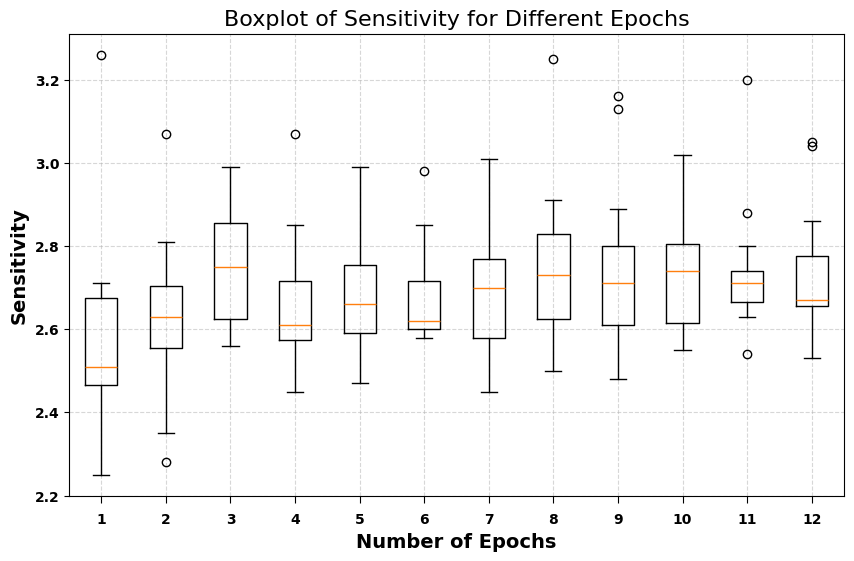

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(sensitivity_tot_epochs, labels=[str(ep) for ep in epoch_list])
plt.xlabel('Number of Epochs', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('Boxplot of Sensitivity for Different Epochs', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('boxplot_epochs.png',dpi=400)
files.download('boxplot_epochs.png')
plt.show()

In [ ]:
mean_sens_epochs = [np.mean(s) for s in sensitivity_tot_epochs]
std_sens_epochs = [np.std(s) for s in sensitivity_tot_epochs]
best_epoch_index = np.argmax(mean_sens_epochs)
best_epoch = epoch_list[best_epoch_index]
print(f"Best epoch count: {best_epoch} with average sensitivity: {mean_sens_epochs[best_epoch_index]:.2f}, standard deviation:{std_sens_epochs[best_epoch_index]:.2f}")

epochs_result_df = pd.DataFrame({'Epochs': epoch_list, 'Mean Sensitivity': mean_sens_epochs, 'std':std_sens_epochs})
epochs_result_df.sort_values(by='Mean Sensitivity', ascending=False, inplace=True)
print(epochs_result_df.head())

Best epoch count: 8 with average sensitivity: 2.75, standard deviation:0.18
    Epochs  Mean Sensitivity       std
7        8          2.754000  0.176023
2        3          2.746000  0.137976
10      11          2.736000  0.144905
8        9          2.734667  0.197074
11      12          2.734667  0.143056


## Grid Search for Hyperparameters

In [ ]:
# define hyperparameters for iterating
learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [ 32, 64]
epochs = [3, 8, 11]
iterations = 3

grid_results = []

# iterate and doing grid search
for lr, bs, ep in itertools.product(learning_rates, batch_sizes, epochs):
    sensitivities = []
    for _ in range(iterations):
        _, sens = model_training_parameters(
            learning_rate=lr,
            batch_size=bs,
            epoch=ep,
            number=13
        )
        sensitivities.append(sens)
    grid_results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'epoch': ep,
        'Mean sensitivity': np.mean(sensitivities),
        'std': np.std(sensitivities)
    })


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8624 - loss: 0.4004 - val_accuracy: 0.8958 - val_loss: 0.2689
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9001 - loss: 0.3077 - val_accuracy: 0.8977 - val_loss: 0.2605
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8997 - loss: 0.3062 - val_accuracy: 0.8996 - val_loss: 0.2595
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8585 - loss: 0.3964 - val_accuracy: 0.8966 - val_loss: 0.2661
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8976 - loss: 0.3138 - val_accuracy: 0.8979 - val_loss: 0.2684
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8990 - loss: 0.3081 - val_accuracy: 0.8970 - val_loss: 0.2618
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8566 - loss: 0.3990 - val_accuracy: 0.8872 - val_loss: 0.2821
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3083 - val_accuracy: 0.8981 - val_loss: 0.2592
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8968 - loss: 0.3118 - val_accuracy: 0.9011 - val_loss: 0.2644
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8371 - loss: 0.4177 - val_accuracy: 0.8978 - val_loss: 0.2657
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8982 - loss: 0.3173 - val_accuracy: 0.8958 - val_loss: 0.2620
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8987 - loss: 0.3098 - val_accuracy: 0.8997 - val_loss: 0.2597
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8991 - loss: 0.3038 - val_accuracy: 0.8982 - val_loss: 0.2573
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3073 - val_accuracy: 0.8981 - val_loss: 0.2584
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8989 - loss: 0.3028 - val_accuracy: 0.8904 - val_loss: 0.2727
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8990 - loss: 0.3017 - val_accuracy: 0.9002 - val_loss: 0.2580
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9022 - loss: 0.2946 - val_accuracy: 0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8426 - loss: 0.5490 - val_accuracy: 0.8952 - val_loss: 0.2757
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8939 - loss: 0.3298 - val_accuracy: 0.8948 - val_loss: 0.2666
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9004 - loss: 0.3070 - val_accuracy: 0.8979 - val_loss: 0.2603
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3100 - val_accuracy: 0.8985 - val_loss: 0.2614
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8997 - loss: 0.3005 - val_accuracy: 0.8944 - val_loss: 0.2654
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9015 - loss: 0.3000 - val_accuracy: 0.9008 - val_loss: 0.2564
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9009 - loss: 0.2959 - val_accuracy: 0.9001 - val_loss: 0.2568
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9024 - loss: 0.2962 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8314 - loss: 0.4935 - val_accuracy: 0.8949 - val_loss: 0.3027
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8962 - loss: 0.3379 - val_accuracy: 0.8991 - val_loss: 0.2798
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8995 - loss: 0.3191 - val_accuracy: 0.8994 - val_loss: 0.2690
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8991 - loss: 0.3166 - val_accuracy: 0.8974 - val_loss: 0.2632
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8996 - loss: 0.3063 - val_accuracy: 0.8983 - val_loss: 0.2640
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9013 - loss: 0.3063 - val_accuracy: 0.9000 - val_loss: 0.2632
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3090 - val_accuracy: 0.8967 - val_loss: 0.2651
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9016 - loss: 0.2981 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8410 - loss: 0.4836 - val_accuracy: 0.8942 - val_loss: 0.2987
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8965 - loss: 0.3471 - val_accuracy: 0.8972 - val_loss: 0.2839
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3248 - val_accuracy: 0.9002 - val_loss: 0.2678
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8991 - loss: 0.3124 - val_accuracy: 0.8988 - val_loss: 0.2693
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9014 - loss: 0.3032 - val_accuracy: 0.8955 - val_loss: 0.2745
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9014 - loss: 0.3062 - val_accuracy: 0.8999 - val_loss: 0.2633
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9006 - loss: 0.3064 - val_accuracy: 0.9008 - val_loss: 0.2584
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9029 - loss: 0.2996 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8385 - loss: 0.4265 - val_accuracy: 0.8968 - val_loss: 0.2685
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.3133 - val_accuracy: 0.8968 - val_loss: 0.2689
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9000 - loss: 0.3023 - val_accuracy: 0.8988 - val_loss: 0.2604
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9018 - loss: 0.2985 - val_accuracy: 0.9007 - val_loss: 0.2555
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9011 - loss: 0.3014 - val_accuracy: 0.9009 - val_loss: 0.2557
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9025 - loss: 0.2954 - val_accuracy: 0.8990 - val_loss: 0.2615
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9021 - loss: 0.2969 - val_accuracy: 0.8929 - val_loss: 0.2669
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9004 - loss: 0.2973 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8460 - loss: 0.4319 - val_accuracy: 0.8922 - val_loss: 0.2736
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8955 - loss: 0.3206 - val_accuracy: 0.8974 - val_loss: 0.2627
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3042 - val_accuracy: 0.8991 - val_loss: 0.2601
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8986 - loss: 0.3009 - val_accuracy: 0.8976 - val_loss: 0.2606
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9004 - loss: 0.3007 - val_accuracy: 0.9016 - val_loss: 0.2576
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9010 - loss: 0.3035 - val_accuracy: 0.8982 - val_loss: 0.2598
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9037 - loss: 0.2924 - val_accuracy: 0.8978 - val_loss: 0.2585
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9010 - loss: 0.2934 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8347 - loss: 0.4489 - val_accuracy: 0.8960 - val_loss: 0.2697
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.3102 - val_accuracy: 0.8971 - val_loss: 0.2638
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3092 - val_accuracy: 0.9019 - val_loss: 0.2544
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8286 - loss: 0.4510 - val_accuracy: 0.8953 - val_loss: 0.2872
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3357 - val_accuracy: 0.8965 - val_loss: 0.2739
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3180 - val_accuracy: 0.8991 - val_loss: 0.2663
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8389 - loss: 0.4530 - val_accuracy: 0.8955 - val_loss: 0.2739
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3200 - val_accuracy: 0.8985 - val_loss: 0.2638
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3154 - val_accuracy: 0.8956 - val_loss: 0.2610
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8307 - loss: 0.4426 - val_accuracy: 0.8976 - val_loss: 0.2675
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3120 - val_accuracy: 0.8950 - val_loss: 0.2664
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.3046 - val_accuracy: 0.8978 - val_loss: 0.2581
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.3078 - val_accuracy: 0.8958 - val_loss: 0.2633
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3003 - val_accuracy: 0.8971 - val_loss: 0.2613
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9025 - loss: 0.2876 - val_accuracy: 0.8965 - val_loss: 0.2644
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.2939 - val_accuracy: 0.9010 - val_loss: 0.2567
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.3001 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8154 - loss: 0.5740 - val_accuracy: 0.8943 - val_loss: 0.3663
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3858 - val_accuracy: 0.8968 - val_loss: 0.3048
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3459 - val_accuracy: 0.9000 - val_loss: 0.2777
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3223 - val_accuracy: 0.8982 - val_loss: 0.2708
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3144 - val_accuracy: 0.8991 - val_loss: 0.2663
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3135 - val_accuracy: 0.8990 - val_loss: 0.2635
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.2995 - val_accuracy: 0.9003 - val_loss: 0.2596
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.3006 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8306 - loss: 0.4362 - val_accuracy: 0.8944 - val_loss: 0.2715
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.3187 - val_accuracy: 0.8978 - val_loss: 0.2636
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3093 - val_accuracy: 0.8973 - val_loss: 0.2651
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3061 - val_accuracy: 0.9004 - val_loss: 0.2558
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.2982 - val_accuracy: 0.8992 - val_loss: 0.2593
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.2969 - val_accuracy: 0.8985 - val_loss: 0.2581
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.3004 - val_accuracy: 0.8991 - val_loss: 0.2563
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.2951 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8345 - loss: 0.5733 - val_accuracy: 0.8914 - val_loss: 0.3726
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8965 - loss: 0.3895 - val_accuracy: 0.8962 - val_loss: 0.3058
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3464 - val_accuracy: 0.8978 - val_loss: 0.2826
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.3243 - val_accuracy: 0.8948 - val_loss: 0.2737
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3153 - val_accuracy: 0.8984 - val_loss: 0.2672
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3108 - val_accuracy: 0.9016 - val_loss: 0.2628
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.3037 - val_accuracy: 0.9008 - val_loss: 0.2607
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2979 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8529 - loss: 0.4240 - val_accuracy: 0.8965 - val_loss: 0.2677
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8953 - loss: 0.3222 - val_accuracy: 0.8982 - val_loss: 0.2599
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.3096 - val_accuracy: 0.8955 - val_loss: 0.2633
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.2986 - val_accuracy: 0.8987 - val_loss: 0.2632
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3021 - val_accuracy: 0.8990 - val_loss: 0.2608
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.2991 - val_accuracy: 0.8993 - val_loss: 0.2552
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3027 - val_accuracy: 0.8999 - val_loss: 0.2573
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.2923 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8508 - loss: 0.4155 - val_accuracy: 0.8982 - val_loss: 0.2666
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3158 - val_accuracy: 0.8987 - val_loss: 0.2605
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.3033 - val_accuracy: 0.8998 - val_loss: 0.2595
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.2959 - val_accuracy: 0.8977 - val_loss: 0.2652
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9010 - loss: 0.2997 - val_accuracy: 0.9005 - val_loss: 0.2542
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9013 - loss: 0.2948 - val_accuracy: 0.8960 - val_loss: 0.2602
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9029 - loss: 0.2931 - val_accuracy: 0.9015 - val_loss: 0.2546
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3012 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8702 - loss: 0.3746 - val_accuracy: 0.8927 - val_loss: 0.2731
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8946 - loss: 0.3259 - val_accuracy: 0.8997 - val_loss: 0.2553
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8978 - loss: 0.3142 - val_accuracy: 0.8968 - val_loss: 0.2676
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8698 - loss: 0.3818 - val_accuracy: 0.8926 - val_loss: 0.2689
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8947 - loss: 0.3193 - val_accuracy: 0.8973 - val_loss: 0.2613
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8975 - loss: 0.3111 - val_accuracy: 0.8977 - val_loss: 0.2601
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8650 - loss: 0.3859 - val_accuracy: 0.8943 - val_loss: 0.2817
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8936 - loss: 0.3191 - val_accuracy: 0.8945 - val_loss: 0.2688
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8961 - loss: 0.3180 - val_accuracy: 0.8962 - val_loss: 0.2660
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8742 - loss: 0.3658 - val_accuracy: 0.8967 - val_loss: 0.2731
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8947 - loss: 0.3245 - val_accuracy: 0.8981 - val_loss: 0.2663
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8962 - loss: 0.3182 - val_accuracy: 0.8968 - val_loss: 0.2645
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8966 - loss: 0.3166 - val_accuracy: 0.8991 - val_loss: 0.2703
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3134 - val_accuracy: 0.8906 - val_loss: 0.2696
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8966 - loss: 0.3089 - val_accuracy: 0.8901 - val_loss: 0.2808
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8983 - loss: 0.3124 - val_accuracy: 0.8977 - val_loss: 0.2601
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3064 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8725 - loss: 0.4344 - val_accuracy: 0.8907 - val_loss: 0.2866
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8935 - loss: 0.3327 - val_accuracy: 0.8957 - val_loss: 0.2696
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3218 - val_accuracy: 0.8975 - val_loss: 0.2682
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8959 - loss: 0.3146 - val_accuracy: 0.8979 - val_loss: 0.2653
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8988 - loss: 0.3073 - val_accuracy: 0.8970 - val_loss: 0.2641
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8962 - loss: 0.3077 - val_accuracy: 0.8992 - val_loss: 0.2577
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8997 - loss: 0.3047 - val_accuracy: 0.8991 - val_loss: 0.2621
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9002 - loss: 0.3025 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8639 - loss: 0.3873 - val_accuracy: 0.8954 - val_loss: 0.2684
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8964 - loss: 0.3228 - val_accuracy: 0.8972 - val_loss: 0.2622
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3105 - val_accuracy: 0.8998 - val_loss: 0.2645
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8990 - loss: 0.3042 - val_accuracy: 0.8987 - val_loss: 0.2587
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8976 - loss: 0.3101 - val_accuracy: 0.8947 - val_loss: 0.2645
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3109 - val_accuracy: 0.8978 - val_loss: 0.2634
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8998 - loss: 0.2983 - val_accuracy: 0.8964 - val_loss: 0.2672
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8984 - loss: 0.3001 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8659 - loss: 0.4392 - val_accuracy: 0.8979 - val_loss: 0.2722
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8929 - loss: 0.3277 - val_accuracy: 0.8973 - val_loss: 0.2639
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8943 - loss: 0.3154 - val_accuracy: 0.8979 - val_loss: 0.2659
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8996 - loss: 0.3082 - val_accuracy: 0.8966 - val_loss: 0.2652
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8961 - loss: 0.3069 - val_accuracy: 0.8962 - val_loss: 0.2684
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8998 - loss: 0.3081 - val_accuracy: 0.8967 - val_loss: 0.2627
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3010 - val_accuracy: 0.8992 - val_loss: 0.2608
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8962 - loss: 0.3143 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8672 - loss: 0.3776 - val_accuracy: 0.8907 - val_loss: 0.2775
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8932 - loss: 0.3298 - val_accuracy: 0.8988 - val_loss: 0.2645
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8974 - loss: 0.3151 - val_accuracy: 0.8996 - val_loss: 0.2570
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8967 - loss: 0.3134 - val_accuracy: 0.8984 - val_loss: 0.2618
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9001 - loss: 0.3028 - val_accuracy: 0.8964 - val_loss: 0.2598
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9010 - loss: 0.2993 - val_accuracy: 0.8971 - val_loss: 0.2630
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8988 - loss: 0.3038 - val_accuracy: 0.8981 - val_loss: 0.2697
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.2998 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8676 - loss: 0.4176 - val_accuracy: 0.8971 - val_loss: 0.2695
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8958 - loss: 0.3220 - val_accuracy: 0.8982 - val_loss: 0.2717
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8974 - loss: 0.3129 - val_accuracy: 0.8989 - val_loss: 0.2716
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3144 - val_accuracy: 0.8919 - val_loss: 0.2743
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8976 - loss: 0.3102 - val_accuracy: 0.9016 - val_loss: 0.2613
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8999 - loss: 0.3038 - val_accuracy: 0.8961 - val_loss: 0.2613
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8992 - loss: 0.3060 - val_accuracy: 0.8997 - val_loss: 0.2634
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8979 - loss: 0.3100 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8675 - loss: 0.3909 - val_accuracy: 0.8963 - val_loss: 0.2635
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.3143 - val_accuracy: 0.8939 - val_loss: 0.2726
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3239 - val_accuracy: 0.9000 - val_loss: 0.2656
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8738 - loss: 0.3659 - val_accuracy: 0.8924 - val_loss: 0.2774
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8965 - loss: 0.3196 - val_accuracy: 0.8974 - val_loss: 0.2708
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3130 - val_accuracy: 0.8973 - val_loss: 0.2607
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8672 - loss: 0.3848 - val_accuracy: 0.8958 - val_loss: 0.2838
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8963 - loss: 0.3163 - val_accuracy: 0.8962 - val_loss: 0.2624
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3125 - val_accuracy: 0.8984 - val_loss: 0.2666
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8691 - loss: 0.3777 - val_accuracy: 0.8922 - val_loss: 0.2763
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.3232 - val_accuracy: 0.8967 - val_loss: 0.2652
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3080 - val_accuracy: 0.8980 - val_loss: 0.2668
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3049 - val_accuracy: 0.8967 - val_loss: 0.2603
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.3029 - val_accuracy: 0.8991 - val_loss: 0.2685
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3047 - val_accuracy: 0.9004 - val_loss: 0.2567
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9041 - loss: 0.2939 - val_accuracy: 0.8993 - val_loss: 0.2575
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8991 - loss: 0.2966 - val_accuracy: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8505 - loss: 0.4427 - val_accuracy: 0.8923 - val_loss: 0.2941
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3205 - val_accuracy: 0.8939 - val_loss: 0.2869
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.3132 - val_accuracy: 0.8964 - val_loss: 0.2723
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3110 - val_accuracy: 0.9004 - val_loss: 0.2606
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3089 - val_accuracy: 0.9003 - val_loss: 0.2616
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3075 - val_accuracy: 0.8999 - val_loss: 0.2570
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.3038 - val_accuracy: 0.8997 - val_loss: 0.2588
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.3055 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8639 - loss: 0.3840 - val_accuracy: 0.8942 - val_loss: 0.2768
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3211 - val_accuracy: 0.8945 - val_loss: 0.2701
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.3084 - val_accuracy: 0.8993 - val_loss: 0.2596
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3045 - val_accuracy: 0.8976 - val_loss: 0.2635
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3053 - val_accuracy: 0.8899 - val_loss: 0.2785
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3086 - val_accuracy: 0.8989 - val_loss: 0.2629
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3031 - val_accuracy: 0.8967 - val_loss: 0.2649
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.3012 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8596 - loss: 0.3835 - val_accuracy: 0.8930 - val_loss: 0.2721
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.3258 - val_accuracy: 0.8958 - val_loss: 0.2628
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3063 - val_accuracy: 0.8981 - val_loss: 0.2584
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.3056 - val_accuracy: 0.8961 - val_loss: 0.2674
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3073 - val_accuracy: 0.8991 - val_loss: 0.2571
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8977 - loss: 0.3078 - val_accuracy: 0.9005 - val_loss: 0.2571
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3072 - val_accuracy: 0.9011 - val_loss: 0.2530
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.3052 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8678 - loss: 0.3842 - val_accuracy: 0.8960 - val_loss: 0.2675
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8961 - loss: 0.3158 - val_accuracy: 0.9003 - val_loss: 0.2588
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3092 - val_accuracy: 0.8964 - val_loss: 0.2603
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3099 - val_accuracy: 0.8995 - val_loss: 0.2559
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3056 - val_accuracy: 0.8979 - val_loss: 0.2613
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.3035 - val_accuracy: 0.8952 - val_loss: 0.2610
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3000 - val_accuracy: 0.8991 - val_loss: 0.2543
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.2968 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8611 - loss: 0.3835 - val_accuracy: 0.8923 - val_loss: 0.2725
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8936 - loss: 0.3245 - val_accuracy: 0.8952 - val_loss: 0.2670
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8936 - loss: 0.3188 - val_accuracy: 0.8912 - val_loss: 0.2657
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3096 - val_accuracy: 0.8966 - val_loss: 0.2606
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3123 - val_accuracy: 0.8987 - val_loss: 0.2590
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3081 - val_accuracy: 0.8993 - val_loss: 0.2548
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3003 - val_accuracy: 0.8993 - val_loss: 0.2623
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.2981 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8681 - loss: 0.3900 - val_accuracy: 0.8968 - val_loss: 0.2717
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8935 - loss: 0.3243 - val_accuracy: 0.8925 - val_loss: 0.2679
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8942 - loss: 0.3261 - val_accuracy: 0.8972 - val_loss: 0.2662
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8687 - loss: 0.4068 - val_accuracy: 0.8922 - val_loss: 0.2820
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8949 - loss: 0.3290 - val_accuracy: 0.8935 - val_loss: 0.2820
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8964 - loss: 0.3229 - val_accuracy: 0.8949 - val_loss: 0.2687
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8692 - loss: 0.3795 - val_accuracy: 0.8936 - val_loss: 0.2715
Epoch 2/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8938 - loss: 0.3270 - val_accuracy: 0.8939 - val_loss: 0.2727
Epoch 3/3
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8953 - loss: 0.3155 - val_accuracy: 0.8936 - val_loss: 0.2734
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8731 - loss: 0.3703 - val_accuracy: 0.8956 - val_loss: 0.2832
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8926 - loss: 0.3248 - val_accuracy: 0.8976 - val_loss: 0.2657
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8964 - loss: 0.3150 - val_accuracy: 0.8926 - val_loss: 0.2698
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8946 - loss: 0.3156 - val_accuracy: 0.8941 - val_loss: 0.2652
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8963 - loss: 0.3161 - val_accuracy: 0.8965 - val_loss: 0.2611
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8961 - loss: 0.3146 - val_accuracy: 0.8935 - val_loss: 0.2669
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8963 - loss: 0.3100 - val_accuracy: 0.8980 - val_loss: 0.2606
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8978 - loss: 0.3139 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8690 - loss: 0.3769 - val_accuracy: 0.8912 - val_loss: 0.2803
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8929 - loss: 0.3235 - val_accuracy: 0.8872 - val_loss: 0.2976
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8982 - loss: 0.3136 - val_accuracy: 0.8907 - val_loss: 0.2852
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.3130 - val_accuracy: 0.8990 - val_loss: 0.2665
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8971 - loss: 0.3107 - val_accuracy: 0.8966 - val_loss: 0.2659
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8985 - loss: 0.3113 - val_accuracy: 0.8970 - val_loss: 0.2693
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3120 - val_accuracy: 0.8988 - val_loss: 0.2579
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3089 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8622 - loss: 0.3931 - val_accuracy: 0.8950 - val_loss: 0.2676
Epoch 2/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8953 - loss: 0.3216 - val_accuracy: 0.8960 - val_loss: 0.2642
Epoch 3/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8980 - loss: 0.3132 - val_accuracy: 0.8978 - val_loss: 0.2720
Epoch 4/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8956 - loss: 0.3182 - val_accuracy: 0.8949 - val_loss: 0.2693
Epoch 5/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8963 - loss: 0.3107 - val_accuracy: 0.8945 - val_loss: 0.2690
Epoch 6/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8986 - loss: 0.3119 - val_accuracy: 0.8984 - val_loss: 0.2703
Epoch 7/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3061 - val_accuracy: 0.8989 - val_loss: 0.2646
Epoch 8/8
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8985 - loss: 0.3100 - val_accuracy: 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8743 - loss: 0.3762 - val_accuracy: 0.8887 - val_loss: 0.2929
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8949 - loss: 0.3211 - val_accuracy: 0.8945 - val_loss: 0.2686
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8947 - loss: 0.3207 - val_accuracy: 0.8903 - val_loss: 0.2660
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8906 - loss: 0.3259 - val_accuracy: 0.8923 - val_loss: 0.2841
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8972 - loss: 0.3129 - val_accuracy: 0.8986 - val_loss: 0.2589
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8984 - loss: 0.3087 - val_accuracy: 0.8985 - val_loss: 0.2597
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8994 - loss: 0.3102 - val_accuracy: 0.8973 - val_loss: 0.2616
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8999 - loss: 0.3081 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8679 - loss: 0.3771 - val_accuracy: 0.8898 - val_loss: 0.2943
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8956 - loss: 0.3266 - val_accuracy: 0.8907 - val_loss: 0.2746
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8967 - loss: 0.3179 - val_accuracy: 0.8966 - val_loss: 0.2655
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8959 - loss: 0.3154 - val_accuracy: 0.8950 - val_loss: 0.2685
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3119 - val_accuracy: 0.8988 - val_loss: 0.2697
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3102 - val_accuracy: 0.8956 - val_loss: 0.2653
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8974 - loss: 0.3113 - val_accuracy: 0.8884 - val_loss: 0.2764
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8969 - loss: 0.3097 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8739 - loss: 0.3754 - val_accuracy: 0.8948 - val_loss: 0.2652
Epoch 2/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8943 - loss: 0.3278 - val_accuracy: 0.8976 - val_loss: 0.2636
Epoch 3/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8972 - loss: 0.3177 - val_accuracy: 0.8980 - val_loss: 0.2741
Epoch 4/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8973 - loss: 0.3148 - val_accuracy: 0.8988 - val_loss: 0.2635
Epoch 5/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8986 - loss: 0.3095 - val_accuracy: 0.8921 - val_loss: 0.2654
Epoch 6/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8987 - loss: 0.3083 - val_accuracy: 0.8993 - val_loss: 0.2586
Epoch 7/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8993 - loss: 0.3098 - val_accuracy: 0.9004 - val_loss: 0.2673
Epoch 8/11
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8976 - loss: 0.3105 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8394 - loss: 0.4431 - val_accuracy: 0.8942 - val_loss: 0.2786
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3276 - val_accuracy: 0.8976 - val_loss: 0.2671
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3197 - val_accuracy: 0.8948 - val_loss: 0.2709
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8592 - loss: 0.3988 - val_accuracy: 0.8930 - val_loss: 0.2721
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3289 - val_accuracy: 0.8954 - val_loss: 0.2719
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.3172 - val_accuracy: 0.8981 - val_loss: 0.2661
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8721 - loss: 0.3703 - val_accuracy: 0.8938 - val_loss: 0.2706
Epoch 2/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8936 - loss: 0.3232 - val_accuracy: 0.8998 - val_loss: 0.2644
Epoch 3/3
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.3097 - val_accuracy: 0.8994 - val_loss: 0.2606
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8711 - loss: 0.3733 - val_accuracy: 0.8918 - val_loss: 0.2755
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8941 - loss: 0.3210 - val_accuracy: 0.8943 - val_loss: 0.2663
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8962 - loss: 0.3188 - val_accuracy: 0.8978 - val_loss: 0.2605
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3093 - val_accuracy: 0.8979 - val_loss: 0.2649
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.3099 - val_accuracy: 0.8966 - val_loss: 0.2634
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3107 - val_accuracy: 0.8996 - val_loss: 0.2631
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.3151 - val_accuracy: 0.8979 - val_loss: 0.2683
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8975 - loss: 0.3121 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8609 - loss: 0.4206 - val_accuracy: 0.8979 - val_loss: 0.2720
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8940 - loss: 0.3277 - val_accuracy: 0.8878 - val_loss: 0.2978
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3215 - val_accuracy: 0.8979 - val_loss: 0.2624
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3137 - val_accuracy: 0.8994 - val_loss: 0.2632
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.3201 - val_accuracy: 0.8993 - val_loss: 0.2626
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.3110 - val_accuracy: 0.9001 - val_loss: 0.2617
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.3140 - val_accuracy: 0.8993 - val_loss: 0.2599
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3149 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8709 - loss: 0.3788 - val_accuracy: 0.8945 - val_loss: 0.2779
Epoch 2/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3179 - val_accuracy: 0.8947 - val_loss: 0.2711
Epoch 3/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.3145 - val_accuracy: 0.8980 - val_loss: 0.2627
Epoch 4/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3096 - val_accuracy: 0.8981 - val_loss: 0.2588
Epoch 5/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3162 - val_accuracy: 0.8989 - val_loss: 0.2620
Epoch 6/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 0.3094 - val_accuracy: 0.8976 - val_loss: 0.2773
Epoch 7/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.3138 - val_accuracy: 0.8959 - val_loss: 0.2711
Epoch 8/8
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3061 - val_accuracy: 0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8493 - loss: 0.4256 - val_accuracy: 0.8966 - val_loss: 0.2669
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8944 - loss: 0.3253 - val_accuracy: 0.8983 - val_loss: 0.2621
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3121 - val_accuracy: 0.8948 - val_loss: 0.2730
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3149 - val_accuracy: 0.8996 - val_loss: 0.2572
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3092 - val_accuracy: 0.8985 - val_loss: 0.2584
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.3050 - val_accuracy: 0.8979 - val_loss: 0.2593
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.3113 - val_accuracy: 0.8996 - val_loss: 0.2552
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3052 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8651 - loss: 0.3828 - val_accuracy: 0.8971 - val_loss: 0.2676
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3153 - val_accuracy: 0.8943 - val_loss: 0.2669
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.3169 - val_accuracy: 0.8982 - val_loss: 0.2733
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.3116 - val_accuracy: 0.8994 - val_loss: 0.2583
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3078 - val_accuracy: 0.8968 - val_loss: 0.2621
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3144 - val_accuracy: 0.8979 - val_loss: 0.2614
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.3084 - val_accuracy: 0.8984 - val_loss: 0.2594
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.3055 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8482 - loss: 0.3960 - val_accuracy: 0.8965 - val_loss: 0.2686
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8944 - loss: 0.3245 - val_accuracy: 0.8967 - val_loss: 0.2684
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.3190 - val_accuracy: 0.8965 - val_loss: 0.2744
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.3179 - val_accuracy: 0.8985 - val_loss: 0.2566
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.3039 - val_accuracy: 0.8966 - val_loss: 0.2631
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.3089 - val_accuracy: 0.8958 - val_loss: 0.2657
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.3080 - val_accuracy: 0.8981 - val_loss: 0.2622
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3033 - val_accurac

    learning_rate  batch_size  epoch  Mean sensitivity       std
11          0.005          64     11          2.923333  0.098093
15          0.010          64      3          2.826667  0.122293
2           0.001          32     11          2.823333  0.128149
8           0.005          32     11          2.820000  0.257811
16          0.010          64      8          2.780000  0.129615


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

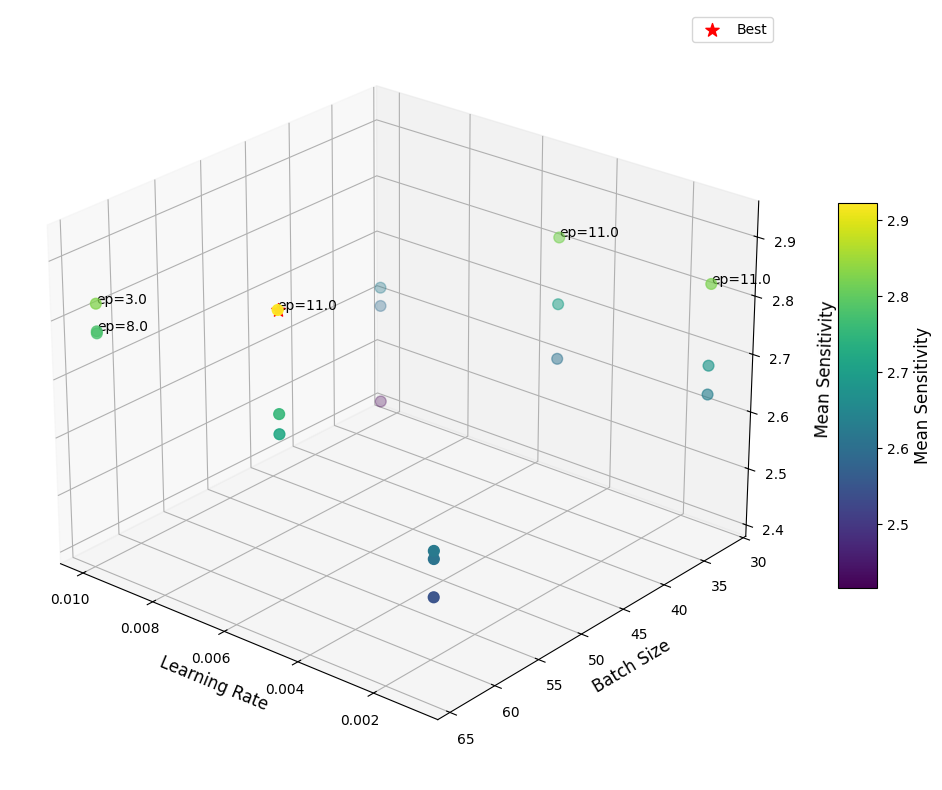

In [ ]:
df_grid = pd.DataFrame(grid_results)
df_grid.sort_values(by='Mean sensitivity', ascending=False, inplace=True)
print(df_grid.head())

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# get coordinations
x = df_grid['learning_rate']
y = df_grid['batch_size']
z = df_grid['Mean sensitivity']


sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=60)

# set labels
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Batch Size', fontsize=12)
ax.set_zlabel('Mean Sensitivity', fontsize=12, labelpad=10)
ax.tick_params(labelsize=10)

# set view for plot and add colorbar
ax.view_init(elev=25, azim=130)
cb = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cb.set_label('Mean Sensitivity', fontsize=12)

# locate point with max sensitivity
best_idx = df_grid['Mean sensitivity'].idxmax()
best_row = df_grid.loc[best_idx]
ax.scatter(best_row['learning_rate'], best_row['batch_size'], best_row['Mean sensitivity'],
           color='red', s=100, marker='*', label='Best')

# add labels to top 3 combinations with highest sensitivities
top_n = 5
top_points = df_grid.sort_values(by='Mean sensitivity', ascending=False).head(top_n)

for i, row in top_points.iterrows():
    ax.text(row['learning_rate'], row['batch_size'], row['Mean sensitivity'],
            f"ep={row['epoch']}", fontsize=10, color='black')


ax.legend()
plt.tight_layout()
plt.savefig('3d_plot.png',dpi=400)
files.download('3d_plot.png')
plt.show()


# 5. Investigation of Optimizers and Loss Functions
This part investigates the optimal set of optimiser and loss function.

In [ ]:
from keras.optimizers import Nadam, SGD,  Adam,  Adamax

# define optimizers and loss functions
optimizers = ['SGD',
              'Adam',
              'Adamax',
              'Nadam',
]

loss_functions = [
    'BinaryCrossentropy',
    'BinaryFocalCrossentropy'
]

def build_optimizer(opt_name, learning_rate=0.005):
  """
  defines the optimizer based on the given name and learning rate.

  Inputs:
  opt_name: name of optimizer
  learning_rate: learning rate for optimizer

  Ouputs:
  optimizer_instance: optimizer instance
  """
  if opt_name == 'SGD':
      return SGD(learning_rate=learning_rate)
  elif opt_name == 'Adam':
      return Adam(learning_rate=learning_rate)
  elif opt_name == 'Adamax':
      return Adamax(learning_rate=learning_rate)
  elif opt_name == 'Nadam':
        return Nadam(learning_rate=learning_rate)
  else:
      return SGD(learning_rate=learning_rate)


def build_model(input_dim, opt_name, loss_name, learning_rate=0.005):
    """
    build and compile a model according to the given optimizer and loss function.

    Inputs:
    input_dim: number of input varaibles
    opt_name: optimizer name
    loss_name: loss function name
    learning_rate: learning rate for optimizer

    Output:
    model: a model for each investigation
    """
    model = Sequential([
        Dense(80, input_dim=input_dim, activation='relu'),
        Dense(48, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer_instance = build_optimizer(opt_name, learning_rate)
    model.compile(loss=loss_name, optimizer=optimizer_instance, metrics=['accuracy'])

    return model

In [ ]:
def train_model(variables, opt_name, loss_name,
                x_train, y_train, w_train,
                dset_test, df_test,
                epochs=11, batch_size=64):
    """
    train model with given optimizer and loss function.

    Inputs:
    variables: list of variables
    opt_name: optimizer name
    loss_name: loss function name
    x_train: x training data
    y_train: y training data
    w_train: training datas' weight
    dset_test: test dataset
    df_test: test dataframe
    epochs: number of epochs
    batch_size: batch size

    Output:
    sens: sensitivity achieved by model
    """
    num_vars = len(variables)
    model = build_model(num_vars, opt_name, loss_name, learning_rate=0.005)
    model.fit(x_train, y_train,
              sample_weight=w_train,
              validation_data=(dset_val[0], dset_val[1]),
              epochs=epochs,
              batch_size=batch_size,
              verbose=1)

    # predict and calculate sensitivity
    df_test['decision_value'] = model.predict(dset_test[0])
    sens = round(sensitivity_NN(df_test)[0], 3)

    return sens

def repeat_experiment(opt, loss_fn, variables, x_train, y_train, w_train, dset_test, df_test, n_repeat=3):
  """
  Repeat experiment for a given time.

  Inputs:
  opt: optimizer name
  loss_fn: loss function name
  variables: list of variables
  x_train: x training data
  y_train: y training data
  w_train: training datas' weight
  dset_test: test dataset
  df_test: test dataframe
  n_repeat: number of repeat

  Outputs:
  mean_sens: mean sensitivity achieved by model
  std_sens: standard deviation of sensitivity achieved by model
  """
    sensitivities = []
    for _ in range(n_repeat):
        sens = train_model(variables, opt, loss_fn, x_train, y_train, w_train, dset_test, df_test)
        sensitivities.append(sens)
    return np.mean(sensitivities), np.std(sensitivities)


In [ ]:

# create an empty list to store different sensitivity achieved by different optimizers and loss functions
results = []

for opt in optimizers:
    for loss_fn in loss_functions:
        mean_sens, std_sens = repeat_experiment(opt, loss_fn, variables, x_train, y_train, w_train, dset_test, df_test, n_repeat=3)
        print(f"Optimizer: {opt}, Loss: {loss_fn}, Mean Sensitivity: {mean_sens}, Std Sensitivity: {std_sens}")
        results.append({
            'Optimizer': opt,
            'Loss': loss_fn,
            'Mean Sensitivity': mean_sens,
            'Std Sensitivity': std_sens
        })

# convert results into Dataframe to visualise using seaborn
df_results = pd.DataFrame(results)

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6616 - loss: 0.6773 - val_accuracy: 0.7899 - val_loss: 0.5122
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8015 - loss: 0.5540 - val_accuracy: 0.8271 - val_loss: 0.4492
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8389 - loss: 0.4823 - val_accuracy: 0.8699 - val_loss: 0.3641
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8765 - loss: 0.3977 - val_accuracy: 0.8874 - val_loss: 0.3092
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8888 - loss: 0.3470 - val_accuracy: 0.8909 - val_loss: 0.2875
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8926 - loss: 0.3292 - val_accuracy: 0.8919 - val_loss: 0.2813
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8937 - loss: 0.3312 - val_accuracy: 0.8939 - val_loss: 0.2764
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8936 - loss: 0.3241 - val_accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

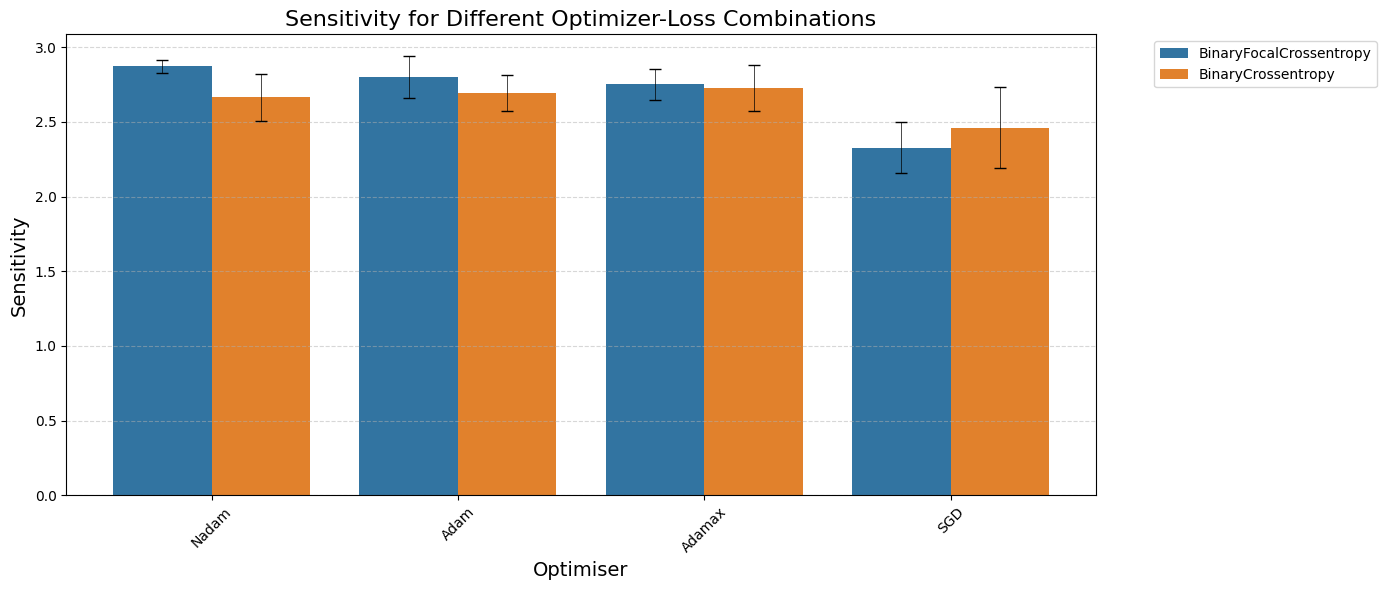

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=df_results,
    x='Optimizer',
    y='Mean Sensitivity',
    hue='Loss',
    palette='tab10'
)

# Add error bars manually
for patch, (_, row) in zip(ax.patches, df_results.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    err = row['Std Sensitivity']
    ax.errorbar(x, y, yerr=err, fmt='none', ecolor='black', capsize=4, linewidth=0.5)

plt.xlabel('Optimiser', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('Sensitivity for Different Optimizer-Loss Combinations', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('sensitivity_optimizer_loss.png', dpi=400)
files.download('sensitivity_optimizer_loss.png')
plt.show()

In [ ]:
# descending order of mean sensitivity for different combinations
df_results.sort_values(by='Mean Sensitivity', ascending=False, inplace=True)
df_results.head(5)

,Optimizer,Loss,Mean Sensitivity,Std Sensitivity
7,Nadam,BinaryFocalCrossentropy,2.872000,0.043909
3,Adam,BinaryFocalCrossentropy,2.797667,0.140917
5,Adamax,BinaryFocalCrossentropy,2.751667,0.103789
4,Adamax,BinaryCrossentropy,2.726000,0.171207
2,Adam,BinaryCrossentropy,2.694667,0.156525


# 6. Investigation of Activation Functions
This part investigates the best choosing of activation function.

In [ ]:
# Top 3 optimisers and top 1 loss function based on previous results
top_optimizers = ['Adamax', 'Nadam', 'Adam']
top_losses = ['BinaryFocalCrossentropy']
activation_list = [
    'relu', 'leaky_relu', 'elu', 'gelu', 'softplus', 'mish'
]

# Generate all optimiser-loss pairs
opt_loss_pairs = list(itertools.product(top_optimizers, top_losses))

In [ ]:
def build_model(input_dim, activation, optimizer_name, loss_name, no_feature=13):
  """
  build and compile a model according to the given activation function.

  Inputs:
  input_dim: number of input varaibles
  activation: activation function
  optimizer_name: optimizer name
  loss_name: loss function name

  Output:
  model: a model for each investigation
  """
  model = Sequential([
      Dense(80, input_dim=no_feature, activation=activation),
      Dense(48, activation=activation),
      Dense(8, activation=activation),
      Dense(4, activation=activation),
      Dense(1, activation='sigmoid')
  ])
  optimizer = build_optimizer(optimizer_name, learning_rate=0.005)
  model.compile(loss=loss_name, optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
def train_and_evaluate(activation, opt_name, loss_name, n_repeat=3, min_threshold=2.7):
  """
  train and evaluate model, and skip combinations with sensitivity lower than 2.7
  to increase efficiency.

  Inputs:
  activation: activation function
  opt_name: optimizer name
  loss_name: loss function name
  n_repeat: number of repeat
  min_threshold: minimum sensitivity threshold

  Outputs:
  mean_sens: mean sensitivity achieved by model
  std_sens: standard deviation of sensitivity achieved by model
  """
  sens_list = []

  # Try 1 run first
  model = build_model(input_dim=x_train.shape[1], activation=activation,
                      optimizer_name=opt_name, loss_name=loss_name)
  model.fit(x_train, y_train,
            sample_weight=w_train,
            validation_data=(dset_val[0], dset_val[1]),
            epochs=11,
            batch_size=64,
            verbose=1)
  df_test['decision_value'] = model.predict(dset_test[0])
  first_sens = round(sensitivity_NN(df_test)[0], 3)

  # Early stop
  if first_sens < min_threshold:
      print(f"Skipped: {opt_name}-{loss_name}-{activation} → First Sens: {first_sens}")

      return None, None

  sens_list.append(first_sens)

  for _ in range(n_repeat - 1):
      model = build_model(input_dim=x_train.shape[1], activation=activation,
                            optimizer_name=opt_name, loss_name=loss_name)
      model.fit(x_train, y_train,
                sample_weight=w_train,
                validation_data=(dset_val[0], dset_val[1]),
                epochs=11,
                batch_size=64,
                verbose=1)
      df_test['decision_value'] = model.predict(dset_test[0])
      sens = round(sensitivity_NN(df_test)[0], 3)
      sens_list.append(sens)

  return np.mean(sens_list), np.std(sens_list)

In [ ]:
results = []

for opt, loss in opt_loss_pairs:
    for act in activation_list:
        mean_sens, std_sens = train_and_evaluate(act, opt, loss, n_repeat=3, min_threshold=2.7)
        if mean_sens is not None:
            results.append({
                'Optimizer': opt,
                'Loss': loss,
                'Activation': act,
                'Mean Sensitivity': mean_sens,
                'Std Sensitivity': std_sens
            })
            print(f"Saved: {opt}-{loss}-{act} → Sens: {mean_sens:.3f}")

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8732 - loss: 0.1013 - val_accuracy: 0.8958 - val_loss: 0.0718
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8957 - loss: 0.0848 - val_accuracy: 0.8973 - val_loss: 0.0728
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8985 - loss: 0.0832 - val_accuracy: 0.8989 - val_loss: 0.0705
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8972 - loss: 0.0837 - val_accuracy: 0.8938 - val_loss: 0.0713
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8957 - loss: 0.0833 - val_accuracy: 0.8991 - val_loss: 0.0691
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8962 - loss: 0.0840 - val_accuracy: 0.8986 - val_loss: 0.0688
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.0821 - val_accuracy: 0.8990 - val_loss: 0.0696
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.0814 - val_accurac

  Optimizer                     Loss Activation  Mean Sensitivity  \
0      Adam  BinaryFocalCrossentropy   softplus          3.403000   
1      Adam  BinaryFocalCrossentropy       relu          2.960000   
2    Adamax  BinaryFocalCrossentropy       mish          2.867333   
3     Nadam  BinaryFocalCrossentropy       gelu          2.783333   
4    Adamax  BinaryFocalCrossentropy        elu          2.782000   

   Std Sensitivity  
0         0.339420  
1         0.068954  
2         0.224228  
3         0.144015  
4         0.159706  


IndexError: single positional indexer is out-of-bounds

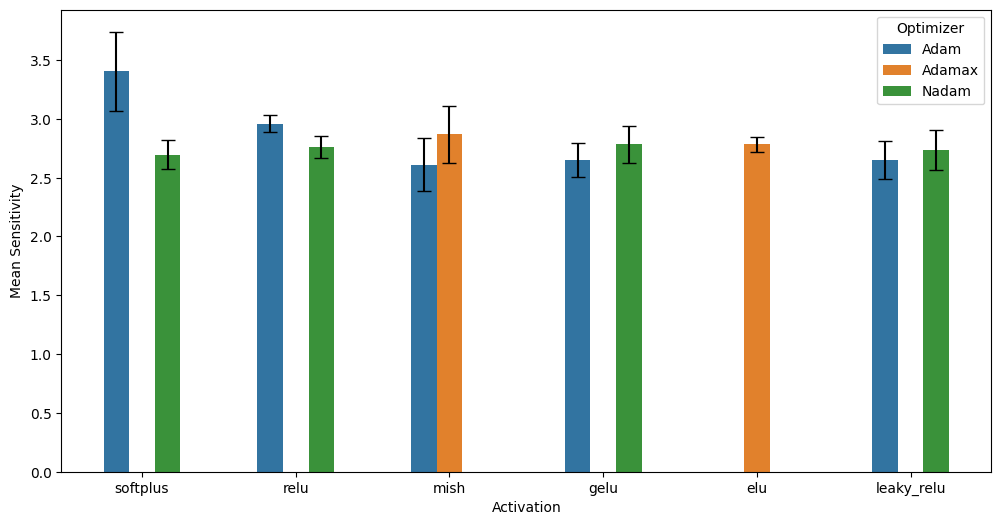

In [ ]:
# transfer results into data frame
df_grid_final = pd.DataFrame(results)
df_grid_final.sort_values(by='Mean Sensitivity', ascending=False, inplace=True)

# get top 5 combinations and print
top_n = 5
top_df = df_grid_final.head(top_n)
top_df = df_grid_final.head(top_n).reset_index(drop=True)
print(top_df)

plt.figure(figsize=(12, 6))

# create the bar plot using seaborn
ax = sns.barplot(data=df_grid_final, x="Activation", y="Mean Sensitivity", hue="Optimizer", palette="tab10", width=0.5, dodge=True,errorbar=None)

# 遍历所有柱子，给每个柱子加上自己的误差线
# ax.patches 会按顺序返回所有柱子，顺序通常是：同一个 x 类别下按 hue 顺序画柱
patches = ax.patches  # 每个柱子是一个 patch

for i, bar in enumerate(patches):
    # 计算柱子中心 x 坐标
    x_center = bar.get_x() + bar.get_width() / 2
    # 高度就是柱子的数值
    height = bar.get_height()
    # 对应到 top_df 的第 i 行
    yerr = df_grid_final["Std Sensitivity"].iloc[i]

    # 在柱子顶部画误差线，fmt='none' 表示不画点，只画误差线
    ax.errorbar(
        x_center,
        height,
        yerr=yerr,
        ecolor='black',
        capsize=5,
        fmt='none',
        zorder=3
    )

plt.xticks(rotation=45)
plt.xlabel("Activation Function")
plt.ylabel("Mean Sensitivity")
plt.title(f"Top {top_n} Activation-Optimizer Combinations by Sensitivity (with Std Dev)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('top_activation_optimizer_combinations.png', dpi=400)
files.download('top_activation_optimizer_combinations.png')
plt.show()

# 7. Improvement over the cut-based approach
This part conducts the analysis of cut-based method and optimised machine learning method.

In [ ]:
def final_model(num):
    """
    Build and train the final neural network model with chosen hyperparameters.

    Inputs:
    num: number of input features

    Output:
    model: trained keras model
    sensitivity: achieved sensitivity by model
    """
    model = Sequential([
        Dense(80, input_dim=num, activation='mish'),
        Dense(48, activation='mish'),
        Dense(8, activation='mish'),
        Dense(4, activation='mish'),
        Dense(1, activation='sigmoid')
    ])

    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')
    selected_variables = disdinguish_pca(x_train, num, variables)
    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')


    model.compile(loss='BinaryFocalCrossentropy', optimizer=Adamax(learning_rate=0.005), metrics=['accuracy'])
    model.fit(x_train, y_train,
              sample_weight=w_train,
              validation_data=(dset_val[0], dset_val[1]),
              epochs=11,
              batch_size=64,
              verbose=1)

    df_test['decision_value'] = model.predict(dset_test[0])
    sensitivity = round(sensitivity_NN(df_test)[0], 3)

    return model, sensitivity

def get_test_input():
    _, _, _, _, dset_test = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')
    return dset_test[0]

In [ ]:
def compare_cut_vs_nn_repeat(model_func, df_test, x_data_func, num_repeats=5, thresholds=np.linspace(0, 0.9, 20)):
  """
 The function quantifies the agreement between the NN and cut-based approaches by calculating
 the ratio of events selected by both methods at various NN score thresholds.
 It repeats the comparison multiple times to account for statistical fluctuations in model training.

  Inputs:
  model_func (callable): A function that returns a trained NN model and its sensitivity when called
  df_test (pd.DataFrame): The DataFrame containing the test dataset, including event features and labels
  x_data_func (callable): A function that returns the input features for the test dataset
  num_repeats (int, optional): The number of times to repeat the comparison. Defaults to 5
  thresholds (array-like, optional): An array of NN score thresholds at which to calculate the match ratio. Defaults to np.linspace(0, 0.9, 20)

  Outputs:
  mean_ratios (ndarray): The mean match ratios across all repeats for each threshold
  std_ratios (ndarray): The standard deviation of match ratios across all repeats for each threshold
  sensitivity_list (list): A list of sensitivity values achieved by the NN model in each repeat
  """
  all_ratios = []
  sensitivity_list = []


  for _ in range(num_repeats):
      model, _ = model_func()
      x_test = x_data_func()
      model, sens_val = model_func()
      sensitivity_list.append(sens_val)


      df = df_test.copy()
      df['nn_score'] = model.predict(x_test, verbose=1).flatten()

      cut_indices = df.loc[
          (df['Mtop'] > 209000) &
          (df['pTV']  > 170000) &
          (df['pTB1'] > 90000 ) &
          (df['dRBB'] < 1.45   )
      ].index

      match_ratios = []
      for thr in thresholds:
          nn_indices = df[df['nn_score'] > thr].index
          intersection_size = len(set(nn_indices).intersection(cut_indices))
          ratio = intersection_size / (len(cut_indices) + 1e-7)
          match_ratios.append(ratio)

      all_ratios.append(match_ratios)

  all_ratios = np.array(all_ratios)
  mean_ratios = np.mean(all_ratios, axis=0)
  std_ratios = np.std(all_ratios, axis=0)

  # Plot
  plt.figure(figsize=(8,6))
  plt.errorbar(thresholds, mean_ratios, yerr=std_ratios, fmt='o-', color='blue', capsize=3, label='std')
  plt.xlabel('NN Threshold', fontsize=14)
  plt.ylabel('Match Ratio with Cut-based', fontsize=14)
  plt.title('NN vs. Cut-based Match Ratio (± std)', fontsize=15)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.savefig('nn_vs_cut_match_ratio.png', dpi=400)
  files.download('nn_vs_cut_match_ratio.png')
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()

  return mean_ratios, std_ratios, sensitivity_list

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8535 - loss: 0.1086 - val_accuracy: 0.8937 - val_loss: 0.0758
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.0868 - val_accuracy: 0.8968 - val_loss: 0.0725
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.0844 - val_accuracy: 0.8973 - val_loss: 0.0709
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.0837 - val_accuracy: 0.8978 - val_loss: 0.0696
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.0825 - val_accuracy: 0.8988 - val_loss: 0.0695
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.0828 - val_accuracy: 0.8993 - val_loss: 0.0692
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0809 - val_accuracy: 0.8976 - val_loss: 0.0690
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9014 - loss: 0.0811 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8135 - loss: 0.1250 - val_accuracy: 0.8898 - val_loss: 0.0777
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8913 - loss: 0.0899 - val_accuracy: 0.8957 - val_loss: 0.0722
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.0843 - val_accuracy: 0.8985 - val_loss: 0.0710
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.0824 - val_accuracy: 0.8977 - val_loss: 0.0701
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.0830 - val_accuracy: 0.8983 - val_loss: 0.0694
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.0818 - val_accuracy: 0.8988 - val_loss: 0.0690
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.0821 - val_accuracy: 0.8969 - val_loss: 0.0692
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9017 - loss: 0.0800 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8233 - loss: 0.1258 - val_accuracy: 0.8936 - val_loss: 0.0762
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8945 - loss: 0.0887 - val_accuracy: 0.8964 - val_loss: 0.0722
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.0848 - val_accuracy: 0.8948 - val_loss: 0.0712
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.0827 - val_accuracy: 0.9007 - val_loss: 0.0696
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0824 - val_accuracy: 0.8990 - val_loss: 0.0696
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.0814 - val_accuracy: 0.8997 - val_loss: 0.0692
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0821 - val_accuracy: 0.9003 - val_loss: 0.0689
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9013 - loss: 0.0817 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8130 - loss: 0.1265 - val_accuracy: 0.8929 - val_loss: 0.0764
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8944 - loss: 0.0879 - val_accuracy: 0.8966 - val_loss: 0.0721
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.0856 - val_accuracy: 0.8988 - val_loss: 0.0701
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.0840 - val_accuracy: 0.8980 - val_loss: 0.0692
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.0821 - val_accuracy: 0.9000 - val_loss: 0.0690
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9010 - loss: 0.0812 - val_accuracy: 0.8978 - val_loss: 0.0692
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9018 - loss: 0.0815 - val_accuracy: 0.8997 - val_loss: 0.0683
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.0812 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7855 - loss: 0.1350 - val_accuracy: 0.8744 - val_loss: 0.0856
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8857 - loss: 0.0920 - val_accuracy: 0.8959 - val_loss: 0.0721
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.0853 - val_accuracy: 0.8993 - val_loss: 0.0696
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8977 - loss: 0.0829 - val_accuracy: 0.8979 - val_loss: 0.0691
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8976 - loss: 0.0827 - val_accuracy: 0.8982 - val_loss: 0.0684
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.0811 - val_accuracy: 0.8999 - val_loss: 0.0680
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.0805 - val_accuracy: 0.8987 - val_loss: 0.0689
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.0813 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8279 - loss: 0.1179 - val_accuracy: 0.8945 - val_loss: 0.0728
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8959 - loss: 0.0843 - val_accuracy: 0.8985 - val_loss: 0.0701
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.0838 - val_accuracy: 0.8974 - val_loss: 0.0697
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.0824 - val_accuracy: 0.8998 - val_loss: 0.0687
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.0820 - val_accuracy: 0.8991 - val_loss: 0.0692
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0798 - val_accuracy: 0.8986 - val_loss: 0.0684
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.0805 - val_accuracy: 0.9000 - val_loss: 0.0685
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.0803 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8043 - loss: 0.1229 - val_accuracy: 0.8911 - val_loss: 0.0795
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8906 - loss: 0.0903 - val_accuracy: 0.8948 - val_loss: 0.0734
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.0861 - val_accuracy: 0.8953 - val_loss: 0.0718
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8959 - loss: 0.0844 - val_accuracy: 0.8955 - val_loss: 0.0711
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.0826 - val_accuracy: 0.8979 - val_loss: 0.0703
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0820 - val_accuracy: 0.8985 - val_loss: 0.0693
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.0819 - val_accuracy: 0.8981 - val_loss: 0.0700
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.0809 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8398 - loss: 0.1130 - val_accuracy: 0.8936 - val_loss: 0.0745
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8942 - loss: 0.0871 - val_accuracy: 0.8965 - val_loss: 0.0713
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8977 - loss: 0.0843 - val_accuracy: 0.8988 - val_loss: 0.0694
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.0820 - val_accuracy: 0.8975 - val_loss: 0.0696
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.0817 - val_accuracy: 0.8997 - val_loss: 0.0689
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.0819 - val_accuracy: 0.8984 - val_loss: 0.0690
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9013 - loss: 0.0797 - val_accuracy: 0.8993 - val_loss: 0.0686
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.0807 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8236 - loss: 0.1192 - val_accuracy: 0.8932 - val_loss: 0.0749
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8931 - loss: 0.0867 - val_accuracy: 0.8979 - val_loss: 0.0710
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.0846 - val_accuracy: 0.8982 - val_loss: 0.0697
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.0832 - val_accuracy: 0.8982 - val_loss: 0.0703
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.0819 - val_accuracy: 0.8984 - val_loss: 0.0689
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.0810 - val_accuracy: 0.8993 - val_loss: 0.0686
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9019 - loss: 0.0806 - val_accuracy: 0.8993 - val_loss: 0.0682
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.0803 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8207 - loss: 0.1228 - val_accuracy: 0.8861 - val_loss: 0.0792
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8881 - loss: 0.0925 - val_accuracy: 0.8928 - val_loss: 0.0740
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.0853 - val_accuracy: 0.8973 - val_loss: 0.0716
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.0846 - val_accuracy: 0.8965 - val_loss: 0.0703
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.0832 - val_accuracy: 0.8997 - val_loss: 0.0692
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.0821 - val_accuracy: 0.8986 - val_loss: 0.0688
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.0811 - val_accuracy: 0.8986 - val_loss: 0.0695
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.0788 - val_accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

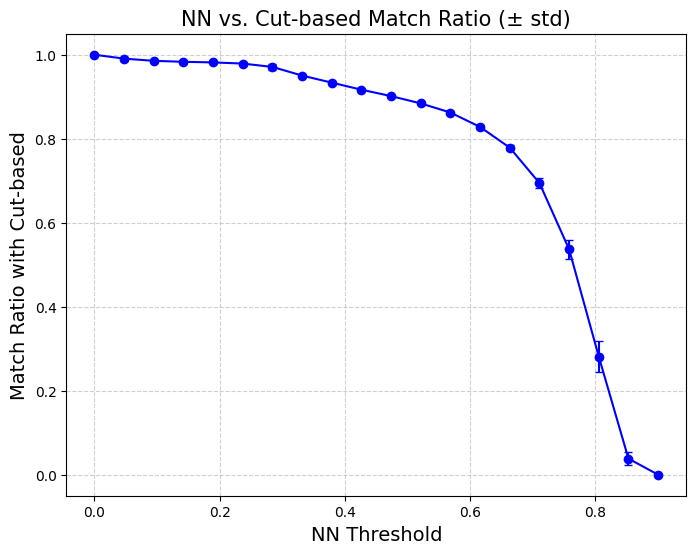

In [ ]:
mean_match, std_match, sensitivity_list_final = compare_cut_vs_nn_repeat(
    model_func=lambda: final_model(num=13),
    df_test=df_test,
    x_data_func=get_test_input,
    num_repeats=5
)

In [ ]:
print(f"Final NN sensitivity over {5} runs: {np.mean(sensitivity_list_final):.3f} ± {np.std(sensitivity_list_final):.3f}")

Final NN sensitivity over 5 runs: 3.077 ± 0.154


# 8. Influence on Training Statistics
This part investigates the impact of changing training statistics.

In [ ]:
def training_size(num,df_train, df_val, df_test):
  """
  compute sensitivity for a given number of features.

  Inputs:
  num: number of variables
  df_train: DataFrame containing the training data
  df_val: DataFrame containing the validation data
  df_test: DataFrame containing the test data

  Outputs:
  model: trained model
  sensitivity: sensitivity achieved by model
  """
  # select random variables
  selected_variables = np.random.choice(variables, num, replace=False)
  x_train, y_train, w_train, dset_val, dset_test = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')
  # define and compile model
  model = Sequential([
      Dense(80,input_dim=num,activation='mish'),
      Dense(48,activation='mish'),
      Dense(8,activation='mish'),
      Dense(4,activation='mish'),
      Dense(1,activation='sigmoid')
  ])

  model.compile(loss='BinaryFocalCrossentropy',optimizer=Adamax(learning_rate=0.005),metrics=['accuracy'])

  history = model.fit(x_train,y_train,
                      sample_weight=w_train,
                      validation_data=(dset_val[0],dset_val[1]),
                      epochs=11,
                      batch_size=64,
                      verbose=1
  )

  df_test['decision_value'] = model.predict(dset_test[0])
  sensitivity = round(sensitivity_NN(df_test)[0], 3)

  return model, sensitivity

In [ ]:
def training_size_plotting(num,df_train, df_val, df_test):
  """
  Plot sensitivity achieved by the final neural network model for different subset sizes of the dataframe.

  Inputs:
  df_train: DataFrame containing the training data
  df_val: DataFrame containing the validation data
  df_test: DataFrame containing the test data
  num: Number of times to run the training and sensitivity calculation
  """
  data_size = np.linspace(2500,len(df_train),30,dtype=int)
  sensitivity_tot = []

  for _ in tqdm(range(num),desc='Runs'):
    sensitivities = []
    for size in data_size:
      df_train_subset = df_train.sample(n=size)
      _, sens = training_size(13, df_train_subset, df_val, df_test)
      sensitivities.append(sens)
    sensitivity_tot.append(sensitivities)

  # convert results into array
  sensitivity_tot = np.array(sensitivity_tot)

  # calculate mean and standard deviation
  mean_sensitivities = np.mean(sensitivity_tot, axis=0)
  std_sensitivities = np.std(sensitivity_tot, axis=0)

  # plot
  plt.figure(figsize=(10, 6))
  plt.errorbar(data_size, mean_sensitivities, yerr=std_sensitivities, fmt='o', capsize=5, label='Mean Sensitivity')
  plt.xlabel('Subset Size', fontsize=14)
  plt.ylabel('Sensitivity',fontsize=14)
  plt.title('Sensitivity vs. Training Subset Size', fontsize=16)
  plt.savefig('sensitivity_vs_training_size.png',dpi=400)
  files.download('sensitivity_vs_training_size.png')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.show()

  # output the best data size
  best_index = np.argmax(mean_sensitivities)
  best_size = data_size[best_index]
  best_mean_sens = mean_sensitivities[best_index]
  best_std_sens = std_sensitivities[best_index]
  print(f"Highest sensitivity achieved with subset size: {best_size} Mean Sensitivity = {best_mean_sens:.3f} with std:{best_std_sens:.3f}")

Runs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7726 - loss: 0.1444 - val_accuracy: 0.8100 - val_loss: 0.1136
Epoch 2/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8005 - loss: 0.1211 - val_accuracy: 0.8372 - val_loss: 0.0980
Epoch 3/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8448 - loss: 0.1087 - val_accuracy: 0.8729 - val_loss: 0.0845
Epoch 4/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8686 - loss: 0.0940 - val_accuracy: 0.8856 - val_loss: 0.0797
Epoch 5/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8707 - loss: 0.0857 - val_accuracy: 0.8878 - val_loss: 0.0776
Epoch 6/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8818 - loss: 0.0746 - val_accuracy: 0.8913 - val_loss: 0.0766
Epoch 7/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8884 - loss: 0.0724 - val_accuracy: 0.8905 - val_loss: 0.0771
Epoch 8/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8893 - loss: 0.0742 - val_accuracy: 0.8917 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7930 - loss: 0.1320 - val_accuracy: 0.8823 - val_loss: 0.0843
Epoch 2/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8840 - loss: 0.0934 - val_accuracy: 0.8891 - val_loss: 0.0774
Epoch 3/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8863 - loss: 0.0922 - val_accuracy: 0.8934 - val_loss: 0.0743
Epoch 4/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8885 - loss: 0.0884 - val_accuracy: 0.8937 - val_loss: 0.0734
Epoch 5/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8933 - loss: 0.0863 - val_accuracy: 0.8910 - val_loss: 0.0745
Epoch 6/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8954 - loss: 0.0818 - val_accuracy: 0.8942 - val_loss: 0.0733
Epoch 7/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8982 - loss: 0.0777 - val_accuracy: 0.8855 - val_loss: 0.0760
Epoch 8/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8977 - loss: 0.0831 - val_accuracy: 0.8925 - val_loss: 0.0732
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7894 - loss: 0.1298 - val_accuracy: 0.8794 - val_loss: 0.0816
Epoch 2/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8883 - loss: 0.0906 - val_accuracy: 0.8898 - val_loss: 0.0761
Epoch 3/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8930 - loss: 0.0893 - val_accuracy: 0.8922 - val_loss: 0.0723
Epoch 4/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8926 - loss: 0.0825 - val_accuracy: 0.8918 - val_loss: 0.0731
Epoch 5/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8983 - loss: 0.0797 - val_accuracy: 0.8953 - val_loss: 0.0706
Epoch 6/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8944 - loss: 0.0805 - val_accuracy: 0.8935 - val_loss: 0.0721
Epoch 7/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8982 - loss: 0.0804 - val_accuracy: 0.8931 - val_loss: 0.0718
Epoch 8/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9041 - loss: 0.0766 - val_accuracy: 0.8929 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7970 - loss: 0.1242 - val_accuracy: 0.8858 - val_loss: 0.0812
Epoch 2/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8863 - loss: 0.0935 - val_accuracy: 0.8913 - val_loss: 0.0749
Epoch 3/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8901 - loss: 0.0894 - val_accuracy: 0.8946 - val_loss: 0.0744
Epoch 4/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8972 - loss: 0.0858 - val_accuracy: 0.8942 - val_loss: 0.0737
Epoch 5/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8957 - loss: 0.0841 - val_accuracy: 0.8959 - val_loss: 0.0733
Epoch 6/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8991 - loss: 0.0829 - val_accuracy: 0.8938 - val_loss: 0.0728
Epoch 7/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8960 - loss: 0.0828 - val_accuracy: 0.8964 - val_loss: 0.0719
Epoch 8/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9009 - loss: 0.0782 - val_accuracy: 0.8958 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8187 - loss: 0.1232 - val_accuracy: 0.8894 - val_loss: 0.0812
Epoch 2/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8916 - loss: 0.0863 - val_accuracy: 0.8930 - val_loss: 0.0758
Epoch 3/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8998 - loss: 0.0816 - val_accuracy: 0.8955 - val_loss: 0.0742
Epoch 4/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8967 - loss: 0.0824 - val_accuracy: 0.8941 - val_loss: 0.0757
Epoch 5/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9006 - loss: 0.0796 - val_accuracy: 0.8942 - val_loss: 0.0727
Epoch 6/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8934 - loss: 0.0844 - val_accuracy: 0.8970 - val_loss: 0.0719
Epoch 7/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8979 - loss: 0.0806 - val_accuracy: 0.8956 - val_loss: 0.0737
Epoch 8/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8976 - loss: 0.0788 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8271 - loss: 0.1238 - val_accuracy: 0.8900 - val_loss: 0.0748
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8879 - loss: 0.0915 - val_accuracy: 0.8939 - val_loss: 0.0728
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8977 - loss: 0.0848 - val_accuracy: 0.8968 - val_loss: 0.0720
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8976 - loss: 0.0859 - val_accuracy: 0.8954 - val_loss: 0.0717
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8967 - loss: 0.0794 - val_accuracy: 0.8981 - val_loss: 0.0698
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8968 - loss: 0.0818 - val_accuracy: 0.8979 - val_loss: 0.0699
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8927 - loss: 0.0858 - val_accuracy: 0.8993 - val_loss: 0.0700
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8954 - loss: 0.0821 - val_accuracy: 0.8977 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8430 - loss: 0.1147 - val_accuracy: 0.8930 - val_loss: 0.0768
Epoch 2/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8920 - loss: 0.0882 - val_accuracy: 0.8950 - val_loss: 0.0728
Epoch 3/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8903 - loss: 0.0885 - val_accuracy: 0.8987 - val_loss: 0.0712
Epoch 4/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8992 - loss: 0.0813 - val_accuracy: 0.8924 - val_loss: 0.0737
Epoch 5/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8962 - loss: 0.0826 - val_accuracy: 0.8950 - val_loss: 0.0711
Epoch 6/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9006 - loss: 0.0806 - val_accuracy: 0.8959 - val_loss: 0.0707
Epoch 7/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8983 - loss: 0.0804 - val_accuracy: 0.8958 - val_loss: 0.0712
Epoch 8/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9001 - loss: 0.0811 - val_accuracy: 0.8968 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8409 - loss: 0.1097 - val_accuracy: 0.8910 - val_loss: 0.0733
Epoch 2/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8902 - loss: 0.0857 - val_accuracy: 0.8967 - val_loss: 0.0722
Epoch 3/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9022 - loss: 0.0802 - val_accuracy: 0.8971 - val_loss: 0.0696
Epoch 4/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8997 - loss: 0.0800 - val_accuracy: 0.8976 - val_loss: 0.0702
Epoch 5/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8987 - loss: 0.0814 - val_accuracy: 0.8970 - val_loss: 0.0701
Epoch 6/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9013 - loss: 0.0809 - val_accuracy: 0.8989 - val_loss: 0.0685
Epoch 7/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9015 - loss: 0.0771 - val_accuracy: 0.8980 - val_loss: 0.0689
Epoch 8/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.0775 - val_accuracy: 0.8985 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8295 - loss: 0.1173 - val_accuracy: 0.8927 - val_loss: 0.0757
Epoch 2/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8968 - loss: 0.0857 - val_accuracy: 0.8979 - val_loss: 0.0713
Epoch 3/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.0818 - val_accuracy: 0.8979 - val_loss: 0.0706
Epoch 4/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8963 - loss: 0.0862 - val_accuracy: 0.8946 - val_loss: 0.0712
Epoch 5/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9009 - loss: 0.0829 - val_accuracy: 0.8971 - val_loss: 0.0702
Epoch 6/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8948 - loss: 0.0801 - val_accuracy: 0.8981 - val_loss: 0.0698
Epoch 7/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9007 - loss: 0.0820 - val_accuracy: 0.9001 - val_loss: 0.0706
Epoch 8/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9011 - loss: 0.0814 - val_accuracy: 0.8966 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



402/402 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8340 - loss: 0.1139 - val_accuracy: 0.8918 - val_loss: 0.0756
Epoch 2/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8938 - loss: 0.0846 - val_accuracy: 0.8941 - val_loss: 0.0726
Epoch 3/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8993 - loss: 0.0800 - val_accuracy: 0.8965 - val_loss: 0.0705
Epoch 4/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8998 - loss: 0.0803 - val_accuracy: 0.8945 - val_loss: 0.0698
Epoch 5/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9047 - loss: 0.0758 - val_accuracy: 0.8984 - val_loss: 0.0687
Epoch 6/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8977 - loss: 0.0813 - val_accuracy: 0.8966 - val_loss: 0.0694
Epoch 7/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8976 - loss: 0.0793 - val_accuracy: 0.8978 - val_loss: 0.0693
Epoch 8/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0789 - val_accuracy: 0.8988 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



442/442 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8536 - loss: 0.1047 - val_accuracy: 0.8966 - val_loss: 0.0704
Epoch 2/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.0833 - val_accuracy: 0.8970 - val_loss: 0.0708
Epoch 3/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.0816 - val_accuracy: 0.8982 - val_loss: 0.0690
Epoch 4/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0783 - val_accuracy: 0.8982 - val_loss: 0.0690
Epoch 5/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9027 - loss: 0.0780 - val_accuracy: 0.8978 - val_loss: 0.0695
Epoch 6/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0797 - val_accuracy: 0.8978 - val_loss: 0.0689
Epoch 7/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9022 - loss: 0.0763 - val_accuracy: 0.9005 - val_loss: 0.0681
Epoch 8/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9039 - loss: 0.0768 - val_accuracy: 0.8964 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8429 - loss: 0.1092 - val_accuracy: 0.8930 - val_loss: 0.0735
Epoch 2/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8957 - loss: 0.0867 - val_accuracy: 0.8976 - val_loss: 0.0724
Epoch 3/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.0835 - val_accuracy: 0.8974 - val_loss: 0.0708
Epoch 4/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.0826 - val_accuracy: 0.8989 - val_loss: 0.0700
Epoch 5/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0815 - val_accuracy: 0.8978 - val_loss: 0.0712
Epoch 6/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9019 - loss: 0.0811 - val_accuracy: 0.8964 - val_loss: 0.0708
Epoch 7/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8965 - loss: 0.0821 - val_accuracy: 0.8990 - val_loss: 0.0698
Epoch 8/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0804 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8560 - loss: 0.1066 - val_accuracy: 0.8947 - val_loss: 0.0716
Epoch 2/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8975 - loss: 0.0858 - val_accuracy: 0.8984 - val_loss: 0.0695
Epoch 3/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8979 - loss: 0.0835 - val_accuracy: 0.8989 - val_loss: 0.0694
Epoch 4/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.0818 - val_accuracy: 0.8977 - val_loss: 0.0695
Epoch 5/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0800 - val_accuracy: 0.8952 - val_loss: 0.0714
Epoch 6/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0800 - val_accuracy: 0.8981 - val_loss: 0.0690
Epoch 7/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0804 - val_accuracy: 0.8979 - val_loss: 0.0683
Epoch 8/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0804 - val_accuracy: 0.8968 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8577 - loss: 0.1037 - val_accuracy: 0.8960 - val_loss: 0.0705
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.0860 - val_accuracy: 0.8898 - val_loss: 0.0722
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.0856 - val_accuracy: 0.8965 - val_loss: 0.0697
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0818 - val_accuracy: 0.8984 - val_loss: 0.0688
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0810 - val_accuracy: 0.8979 - val_loss: 0.0688
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0808 - val_accuracy: 0.8984 - val_loss: 0.0693
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9024 - loss: 0.0783 - val_accuracy: 0.8981 - val_loss: 0.0696
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9019 - loss: 0.0785 - val_accuracy: 0.8988 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8546 - loss: 0.1039 - val_accuracy: 0.8967 - val_loss: 0.0710
Epoch 2/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8950 - loss: 0.0853 - val_accuracy: 0.8956 - val_loss: 0.0711
Epoch 3/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8943 - loss: 0.0826 - val_accuracy: 0.8985 - val_loss: 0.0700
Epoch 4/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0813 - val_accuracy: 0.8961 - val_loss: 0.0711
Epoch 5/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0820 - val_accuracy: 0.8990 - val_loss: 0.0691
Epoch 6/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0826 - val_accuracy: 0.8953 - val_loss: 0.0704
Epoch 7/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0793 - val_accuracy: 0.8959 - val_loss: 0.0714
Epoch 8/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9013 - loss: 0.0808 - val_accuracy: 0.8983 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8541 - loss: 0.1062 - val_accuracy: 0.8967 - val_loss: 0.0706
Epoch 2/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8959 - loss: 0.0834 - val_accuracy: 0.8995 - val_loss: 0.0703
Epoch 3/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0814 - val_accuracy: 0.8978 - val_loss: 0.0699
Epoch 4/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0800 - val_accuracy: 0.8989 - val_loss: 0.0694
Epoch 5/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.0817 - val_accuracy: 0.8971 - val_loss: 0.0712
Epoch 6/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8961 - loss: 0.0816 - val_accuracy: 0.8985 - val_loss: 0.0692
Epoch 7/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.0799 - val_accuracy: 0.8959 - val_loss: 0.0703
Epoch 8/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0828 - val_accuracy: 0.9007 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8488 - loss: 0.1061 - val_accuracy: 0.8969 - val_loss: 0.0720
Epoch 2/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0848 - val_accuracy: 0.8950 - val_loss: 0.0716
Epoch 3/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0824 - val_accuracy: 0.8986 - val_loss: 0.0696
Epoch 4/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0800 - val_accuracy: 0.8981 - val_loss: 0.0692
Epoch 5/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9039 - loss: 0.0793 - val_accuracy: 0.8961 - val_loss: 0.0708
Epoch 6/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0801 - val_accuracy: 0.8978 - val_loss: 0.0705
Epoch 7/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0791 - val_accuracy: 0.8985 - val_loss: 0.0694
Epoch 8/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0805 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



724/724 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8471 - loss: 0.1079 - val_accuracy: 0.8948 - val_loss: 0.0720
Epoch 2/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0849 - val_accuracy: 0.8991 - val_loss: 0.0699
Epoch 3/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0836 - val_accuracy: 0.8983 - val_loss: 0.0692
Epoch 4/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0808 - val_accuracy: 0.8978 - val_loss: 0.0687
Epoch 5/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9025 - loss: 0.0799 - val_accuracy: 0.8965 - val_loss: 0.0694
Epoch 6/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0806 - val_accuracy: 0.8985 - val_loss: 0.0689
Epoch 7/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0802 - val_accuracy: 0.8961 - val_loss: 0.0706
Epoch 8/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0794 - val_accuracy: 0.8985 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8545 - loss: 0.1044 - val_accuracy: 0.8971 - val_loss: 0.0709
Epoch 2/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0833 - val_accuracy: 0.8953 - val_loss: 0.0704
Epoch 3/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0814 - val_accuracy: 0.8977 - val_loss: 0.0690
Epoch 4/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0821 - val_accuracy: 0.8987 - val_loss: 0.0692
Epoch 5/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9022 - loss: 0.0806 - val_accuracy: 0.8998 - val_loss: 0.0682
Epoch 6/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.0806 - val_accuracy: 0.8984 - val_loss: 0.0685
Epoch 7/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0799 - val_accuracy: 0.8986 - val_loss: 0.0683
Epoch 8/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0803 - val_accuracy: 0.8995 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



804/804 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8619 - loss: 0.1044 - val_accuracy: 0.8958 - val_loss: 0.0697
Epoch 2/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0838 - val_accuracy: 0.8981 - val_loss: 0.0688
Epoch 3/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0828 - val_accuracy: 0.8982 - val_loss: 0.0682
Epoch 4/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0819 - val_accuracy: 0.9005 - val_loss: 0.0684
Epoch 5/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.0793 - val_accuracy: 0.9004 - val_loss: 0.0688
Epoch 6/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0814 - val_accuracy: 0.8978 - val_loss: 0.0685
Epoch 7/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0799 - val_accuracy: 0.9003 - val_loss: 0.0689
Epoch 8/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9008 - loss: 0.0803 - val_accuracy: 0.8987 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8476 - loss: 0.1102 - val_accuracy: 0.8950 - val_loss: 0.0731
Epoch 2/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8960 - loss: 0.0864 - val_accuracy: 0.8977 - val_loss: 0.0714
Epoch 3/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0826 - val_accuracy: 0.8955 - val_loss: 0.0741
Epoch 4/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0828 - val_accuracy: 0.8978 - val_loss: 0.0700
Epoch 5/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0815 - val_accuracy: 0.9003 - val_loss: 0.0693
Epoch 6/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8971 - loss: 0.0814 - val_accuracy: 0.8994 - val_loss: 0.0693
Epoch 7/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0796 - val_accuracy: 0.9004 - val_loss: 0.0686
Epoch 8/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0787 - val_accuracy: 0.8972 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8673 - loss: 0.0984 - val_accuracy: 0.8971 - val_loss: 0.0716
Epoch 2/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0835 - val_accuracy: 0.8981 - val_loss: 0.0691
Epoch 3/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9008 - loss: 0.0807 - val_accuracy: 0.8984 - val_loss: 0.0693
Epoch 4/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.0814 - val_accuracy: 0.9003 - val_loss: 0.0680
Epoch 5/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0805 - val_accuracy: 0.9007 - val_loss: 0.0689
Epoch 6/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0797 - val_accuracy: 0.8996 - val_loss: 0.0695
Epoch 7/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.0811 - val_accuracy: 0.9000 - val_loss: 0.0686
Epoch 8/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0794 - val_accuracy: 0.9002 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



925/925 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8624 - loss: 0.1031 - val_accuracy: 0.8974 - val_loss: 0.0706
Epoch 2/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.0840 - val_accuracy: 0.8978 - val_loss: 0.0698
Epoch 3/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.0828 - val_accuracy: 0.8980 - val_loss: 0.0703
Epoch 4/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0816 - val_accuracy: 0.8952 - val_loss: 0.0701
Epoch 5/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0820 - val_accuracy: 0.8984 - val_loss: 0.0701
Epoch 6/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0801 - val_accuracy: 0.8975 - val_loss: 0.0689
Epoch 7/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0806 - val_accuracy: 0.8985 - val_loss: 0.0698
Epoch 8/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.0814 - val_accuracy: 0.9000 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



965/965 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8610 - loss: 0.1046 - val_accuracy: 0.8991 - val_loss: 0.0709
Epoch 2/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.0868 - val_accuracy: 0.8960 - val_loss: 0.0704
Epoch 3/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0816 - val_accuracy: 0.8959 - val_loss: 0.0696
Epoch 4/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8956 - loss: 0.0839 - val_accuracy: 0.8987 - val_loss: 0.0689
Epoch 5/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0824 - val_accuracy: 0.8989 - val_loss: 0.0688
Epoch 6/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0817 - val_accuracy: 0.8993 - val_loss: 0.0691
Epoch 7/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9024 - loss: 0.0792 - val_accuracy: 0.9011 - val_loss: 0.0687
Epoch 8/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.0812 - val_accuracy: 0.8996 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1005/1005 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8616 - loss: 0.1091 - val_accuracy: 0.8993 - val_loss: 0.0723
Epoch 2/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.0857 - val_accuracy: 0.9000 - val_loss: 0.0708
Epoch 3/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0819 - val_accuracy: 0.8987 - val_loss: 0.0700
Epoch 4/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0813 - val_accuracy: 0.9000 - val_loss: 0.0699
Epoch 5/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.0797 - val_accuracy: 0.9013 - val_loss: 0.0688
Epoch 6/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9027 - loss: 0.0804 - val_accuracy: 0.8975 - val_loss: 0.0695
Epoch 7/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0791 - val_accuracy: 0.8999 - val_loss: 0.0689
Epoch 8/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0806 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8726 - loss: 0.0971 - val_accuracy: 0.8990 - val_loss: 0.0707
Epoch 2/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0822 - val_accuracy: 0.8992 - val_loss: 0.0690
Epoch 3/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.0815 - val_accuracy: 0.9005 - val_loss: 0.0693
Epoch 4/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.0817 - val_accuracy: 0.8983 - val_loss: 0.0690
Epoch 5/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0814 - val_accuracy: 0.9010 - val_loss: 0.0683
Epoch 6/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.0792 - val_accuracy: 0.9013 - val_loss: 0.0683
Epoch 7/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0789 - val_accuracy: 0.8988 - val_loss: 0.0689
Epoch 8/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0785 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1086/1086 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8631 - loss: 0.1029 - val_accuracy: 0.8956 - val_loss: 0.0713
Epoch 2/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0828 - val_accuracy: 0.8989 - val_loss: 0.0696
Epoch 3/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0833 - val_accuracy: 0.8959 - val_loss: 0.0707
Epoch 4/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0805 - val_accuracy: 0.8984 - val_loss: 0.0687
Epoch 5/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.0796 - val_accuracy: 0.9006 - val_loss: 0.0693
Epoch 6/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0814 - val_accuracy: 0.9002 - val_loss: 0.0683
Epoch 7/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.0803 - val_accuracy: 0.9014 - val_loss: 0.0678
Epoch 8/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0810 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8612 - loss: 0.1005 - val_accuracy: 0.8949 - val_loss: 0.0720
Epoch 2/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0828 - val_accuracy: 0.8990 - val_loss: 0.0698
Epoch 3/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0819 - val_accuracy: 0.8991 - val_loss: 0.0691
Epoch 4/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.0819 - val_accuracy: 0.8974 - val_loss: 0.0685
Epoch 5/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.0816 - val_accuracy: 0.8989 - val_loss: 0.0684
Epoch 6/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9037 - loss: 0.0791 - val_accuracy: 0.9000 - val_loss: 0.0688
Epoch 7/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0785 - val_accuracy: 0.8980 - val_loss: 0.0687
Epoch 8/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.0802 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1166/1166 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8583 - loss: 0.1013 - val_accuracy: 0.8957 - val_loss: 0.0737
Epoch 2/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.0831 - val_accuracy: 0.8966 - val_loss: 0.0700
Epoch 3/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.0825 - val_accuracy: 0.8977 - val_loss: 0.0688
Epoch 4/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.0814 - val_accuracy: 0.8985 - val_loss: 0.0692
Epoch 5/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0804 - val_accuracy: 0.8996 - val_loss: 0.0694
Epoch 6/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9020 - loss: 0.0789 - val_accuracy: 0.9006 - val_loss: 0.0682
Epoch 7/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.0798 - val_accuracy: 0.8984 - val_loss: 0.0686
Epoch 8/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0801 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8599 - loss: 0.1027 - val_accuracy: 0.8979 - val_loss: 0.0696
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.0844 - val_accuracy: 0.8973 - val_loss: 0.0684
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.0813 - val_accuracy: 0.9007 - val_loss: 0.0684
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.0803 - val_accuracy: 0.9001 - val_loss: 0.0680
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0806 - val_accuracy: 0.8996 - val_loss: 0.0685
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.0780 - val_accuracy: 0.8996 - val_loss: 0.0687
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.0786 - val_accuracy: 0.8994 - val_loss: 0.0681
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0794 - val_accurac

Runs:  20%|██        | 1/5 [13:02<52:09, 782.41s/it]

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7652 - loss: 0.1528 - val_accuracy: 0.8475 - val_loss: 0.1012
Epoch 2/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8317 - loss: 0.1159 - val_accuracy: 0.8643 - val_loss: 0.0960
Epoch 3/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8724 - loss: 0.1051 - val_accuracy: 0.8691 - val_loss: 0.0929
Epoch 4/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8662 - loss: 0.1024 - val_accuracy: 0.8708 - val_loss: 0.0901
Epoch 5/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8607 - loss: 0.0996 - val_accuracy: 0.8742 - val_loss: 0.0896
Epoch 6/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8692 - loss: 0.1004 - val_accuracy: 0.8774 - val_loss: 0.0871
Epoch 7/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8850 - loss: 0.0936 - val_accuracy: 0.8796 - val_loss: 0.0882
Epoch 8/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8909 - loss: 0.0941 - val_accuracy: 0.8811 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7407 - loss: 0.1532 - val_accuracy: 0.8175 - val_loss: 0.1083
Epoch 2/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8496 - loss: 0.1125 - val_accuracy: 0.8685 - val_loss: 0.0868
Epoch 3/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8807 - loss: 0.0915 - val_accuracy: 0.8886 - val_loss: 0.0789
Epoch 4/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8982 - loss: 0.0849 - val_accuracy: 0.8893 - val_loss: 0.0789
Epoch 5/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8961 - loss: 0.0807 - val_accuracy: 0.8911 - val_loss: 0.0756
Epoch 6/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8983 - loss: 0.0791 - val_accuracy: 0.8950 - val_loss: 0.0748
Epoch 7/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9107 - loss: 0.0737 - val_accuracy: 0.8926 - val_loss: 0.0745
Epoch 8/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8970 - loss: 0.0774 - val_accuracy: 0.8939 - val_loss: 0.0743
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7908 - loss: 0.1290 - val_accuracy: 0.8782 - val_loss: 0.0831
Epoch 2/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8808 - loss: 0.0913 - val_accuracy: 0.8900 - val_loss: 0.0757
Epoch 3/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8894 - loss: 0.0864 - val_accuracy: 0.8916 - val_loss: 0.0738
Epoch 4/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8904 - loss: 0.0864 - val_accuracy: 0.8900 - val_loss: 0.0746
Epoch 5/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8957 - loss: 0.0849 - val_accuracy: 0.8962 - val_loss: 0.0715
Epoch 6/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8934 - loss: 0.0806 - val_accuracy: 0.8972 - val_loss: 0.0721
Epoch 7/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9040 - loss: 0.0768 - val_accuracy: 0.8938 - val_loss: 0.0727
Epoch 8/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9034 - loss: 0.0784 - val_accuracy: 0.8944 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7585 - loss: 0.1540 - val_accuracy: 0.8632 - val_loss: 0.0990
Epoch 2/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8727 - loss: 0.1033 - val_accuracy: 0.8905 - val_loss: 0.0818
Epoch 3/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8955 - loss: 0.0886 - val_accuracy: 0.8918 - val_loss: 0.0776
Epoch 4/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8955 - loss: 0.0832 - val_accuracy: 0.8929 - val_loss: 0.0751
Epoch 5/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9007 - loss: 0.0780 - val_accuracy: 0.8863 - val_loss: 0.0758
Epoch 6/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8959 - loss: 0.0834 - val_accuracy: 0.8980 - val_loss: 0.0718
Epoch 7/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8989 - loss: 0.0794 - val_accuracy: 0.8965 - val_loss: 0.0724
Epoch 8/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8971 - loss: 0.0771 - val_accuracy: 0.8875 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8226 - loss: 0.1270 - val_accuracy: 0.8914 - val_loss: 0.0774
Epoch 2/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8947 - loss: 0.0881 - val_accuracy: 0.8915 - val_loss: 0.0745
Epoch 3/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8989 - loss: 0.0850 - val_accuracy: 0.8971 - val_loss: 0.0721
Epoch 4/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8975 - loss: 0.0804 - val_accuracy: 0.8963 - val_loss: 0.0702
Epoch 5/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9008 - loss: 0.0760 - val_accuracy: 0.8981 - val_loss: 0.0704
Epoch 6/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8992 - loss: 0.0778 - val_accuracy: 0.8975 - val_loss: 0.0698
Epoch 7/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9028 - loss: 0.0762 - val_accuracy: 0.8984 - val_loss: 0.0698
Epoch 8/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9037 - loss: 0.0736 - val_accuracy: 0.8975 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8063 - loss: 0.1268 - val_accuracy: 0.8843 - val_loss: 0.0782
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8936 - loss: 0.0920 - val_accuracy: 0.8912 - val_loss: 0.0749
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8948 - loss: 0.0865 - val_accuracy: 0.8926 - val_loss: 0.0733
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8955 - loss: 0.0840 - val_accuracy: 0.8944 - val_loss: 0.0712
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8952 - loss: 0.0880 - val_accuracy: 0.8953 - val_loss: 0.0719
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8919 - loss: 0.0850 - val_accuracy: 0.8933 - val_loss: 0.0713
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8968 - loss: 0.0826 - val_accuracy: 0.8955 - val_loss: 0.0712
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8986 - loss: 0.0837 - val_accuracy: 0.8943 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8385 - loss: 0.1137 - val_accuracy: 0.8924 - val_loss: 0.0744
Epoch 2/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8913 - loss: 0.0907 - val_accuracy: 0.8970 - val_loss: 0.0702
Epoch 3/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9002 - loss: 0.0841 - val_accuracy: 0.8936 - val_loss: 0.0730
Epoch 4/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8904 - loss: 0.0868 - val_accuracy: 0.8992 - val_loss: 0.0697
Epoch 5/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.0820 - val_accuracy: 0.8987 - val_loss: 0.0714
Epoch 6/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9020 - loss: 0.0802 - val_accuracy: 0.8979 - val_loss: 0.0708
Epoch 7/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8958 - loss: 0.0788 - val_accuracy: 0.8976 - val_loss: 0.0697
Epoch 8/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8976 - loss: 0.0819 - val_accuracy: 0.8992 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8379 - loss: 0.1125 - val_accuracy: 0.8926 - val_loss: 0.0740
Epoch 2/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8965 - loss: 0.0882 - val_accuracy: 0.8947 - val_loss: 0.0723
Epoch 3/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8969 - loss: 0.0820 - val_accuracy: 0.8964 - val_loss: 0.0709
Epoch 4/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0798 - val_accuracy: 0.8988 - val_loss: 0.0700
Epoch 5/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.0782 - val_accuracy: 0.8963 - val_loss: 0.0712
Epoch 6/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8991 - loss: 0.0799 - val_accuracy: 0.8979 - val_loss: 0.0701
Epoch 7/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8991 - loss: 0.0782 - val_accuracy: 0.8982 - val_loss: 0.0704
Epoch 8/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9011 - loss: 0.0773 - val_accuracy: 0.8967 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8264 - loss: 0.1138 - val_accuracy: 0.8942 - val_loss: 0.0738
Epoch 2/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8920 - loss: 0.0867 - val_accuracy: 0.8974 - val_loss: 0.0714
Epoch 3/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8963 - loss: 0.0822 - val_accuracy: 0.8963 - val_loss: 0.0703
Epoch 4/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8960 - loss: 0.0820 - val_accuracy: 0.8978 - val_loss: 0.0701
Epoch 5/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8955 - loss: 0.0812 - val_accuracy: 0.8975 - val_loss: 0.0727
Epoch 6/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8968 - loss: 0.0828 - val_accuracy: 0.8972 - val_loss: 0.0703
Epoch 7/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9031 - loss: 0.0793 - val_accuracy: 0.8968 - val_loss: 0.0705
Epoch 8/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9006 - loss: 0.0793 - val_accuracy: 0.9000 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8302 - loss: 0.1099 - val_accuracy: 0.8942 - val_loss: 0.0732
Epoch 2/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8980 - loss: 0.0812 - val_accuracy: 0.8969 - val_loss: 0.0709
Epoch 3/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8976 - loss: 0.0841 - val_accuracy: 0.8980 - val_loss: 0.0699
Epoch 4/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9013 - loss: 0.0800 - val_accuracy: 0.8978 - val_loss: 0.0701
Epoch 5/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8950 - loss: 0.0832 - val_accuracy: 0.8972 - val_loss: 0.0706
Epoch 6/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.0809 - val_accuracy: 0.8986 - val_loss: 0.0686
Epoch 7/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.0789 - val_accuracy: 0.8985 - val_loss: 0.0701
Epoch 8/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8998 - loss: 0.0781 - val_accuracy: 0.8971 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8373 - loss: 0.1175 - val_accuracy: 0.8924 - val_loss: 0.0734
Epoch 2/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8961 - loss: 0.0844 - val_accuracy: 0.8977 - val_loss: 0.0708
Epoch 3/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8988 - loss: 0.0846 - val_accuracy: 0.8984 - val_loss: 0.0701
Epoch 4/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8959 - loss: 0.0836 - val_accuracy: 0.8971 - val_loss: 0.0689
Epoch 5/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.0819 - val_accuracy: 0.8997 - val_loss: 0.0681
Epoch 6/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9010 - loss: 0.0800 - val_accuracy: 0.8997 - val_loss: 0.0701
Epoch 7/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9021 - loss: 0.0783 - val_accuracy: 0.8976 - val_loss: 0.0692
Epoch 8/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9008 - loss: 0.0797 - val_accuracy: 0.8972 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



482/482 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8253 - loss: 0.1159 - val_accuracy: 0.8941 - val_loss: 0.0720
Epoch 2/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.0846 - val_accuracy: 0.8974 - val_loss: 0.0713
Epoch 3/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.0855 - val_accuracy: 0.8960 - val_loss: 0.0714
Epoch 4/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.0838 - val_accuracy: 0.8962 - val_loss: 0.0703
Epoch 5/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0836 - val_accuracy: 0.8979 - val_loss: 0.0697
Epoch 6/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0800 - val_accuracy: 0.8985 - val_loss: 0.0692
Epoch 7/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0814 - val_accuracy: 0.8974 - val_loss: 0.0700
Epoch 8/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9013 - loss: 0.0806 - val_accuracy: 0.8991 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8378 - loss: 0.1103 - val_accuracy: 0.8935 - val_loss: 0.0750
Epoch 2/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.0833 - val_accuracy: 0.8974 - val_loss: 0.0712
Epoch 3/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0871 - val_accuracy: 0.8982 - val_loss: 0.0718
Epoch 4/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0822 - val_accuracy: 0.8990 - val_loss: 0.0697
Epoch 5/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0807 - val_accuracy: 0.8968 - val_loss: 0.0699
Epoch 6/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9038 - loss: 0.0803 - val_accuracy: 0.8977 - val_loss: 0.0708
Epoch 7/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0791 - val_accuracy: 0.8986 - val_loss: 0.0692
Epoch 8/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9022 - loss: 0.0775 - val_accuracy: 0.8996 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8369 - loss: 0.1173 - val_accuracy: 0.8956 - val_loss: 0.0735
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8936 - loss: 0.0845 - val_accuracy: 0.8952 - val_loss: 0.0716
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8953 - loss: 0.0827 - val_accuracy: 0.8902 - val_loss: 0.0724
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0799 - val_accuracy: 0.8969 - val_loss: 0.0699
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8953 - loss: 0.0827 - val_accuracy: 0.8974 - val_loss: 0.0691
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0809 - val_accuracy: 0.8984 - val_loss: 0.0690
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0806 - val_accuracy: 0.8965 - val_loss: 0.0705
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0801 - val_accuracy: 0.8985 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8422 - loss: 0.1086 - val_accuracy: 0.8961 - val_loss: 0.0722
Epoch 2/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8948 - loss: 0.0866 - val_accuracy: 0.8970 - val_loss: 0.0706
Epoch 3/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0817 - val_accuracy: 0.8985 - val_loss: 0.0691
Epoch 4/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0818 - val_accuracy: 0.8976 - val_loss: 0.0696
Epoch 5/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9016 - loss: 0.0802 - val_accuracy: 0.8991 - val_loss: 0.0689
Epoch 6/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.0823 - val_accuracy: 0.8987 - val_loss: 0.0698
Epoch 7/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0813 - val_accuracy: 0.8986 - val_loss: 0.0699
Epoch 8/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.0801 - val_accuracy: 0.8988 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8613 - loss: 0.1012 - val_accuracy: 0.8974 - val_loss: 0.0723
Epoch 2/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0825 - val_accuracy: 0.8988 - val_loss: 0.0697
Epoch 3/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0833 - val_accuracy: 0.8978 - val_loss: 0.0697
Epoch 4/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9028 - loss: 0.0804 - val_accuracy: 0.8954 - val_loss: 0.0703
Epoch 5/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.0801 - val_accuracy: 0.8973 - val_loss: 0.0692
Epoch 6/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9032 - loss: 0.0800 - val_accuracy: 0.8992 - val_loss: 0.0687
Epoch 7/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.0793 - val_accuracy: 0.9003 - val_loss: 0.0688
Epoch 8/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0790 - val_accuracy: 0.8982 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8601 - loss: 0.1064 - val_accuracy: 0.8943 - val_loss: 0.0711
Epoch 2/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8952 - loss: 0.0839 - val_accuracy: 0.8987 - val_loss: 0.0692
Epoch 3/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0821 - val_accuracy: 0.8962 - val_loss: 0.0713
Epoch 4/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.0829 - val_accuracy: 0.8971 - val_loss: 0.0699
Epoch 5/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0812 - val_accuracy: 0.8961 - val_loss: 0.0703
Epoch 6/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9008 - loss: 0.0802 - val_accuracy: 0.8970 - val_loss: 0.0691
Epoch 7/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0786 - val_accuracy: 0.8958 - val_loss: 0.0687
Epoch 8/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0798 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8365 - loss: 0.1124 - val_accuracy: 0.8956 - val_loss: 0.0743
Epoch 2/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8950 - loss: 0.0886 - val_accuracy: 0.8931 - val_loss: 0.0734
Epoch 3/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8964 - loss: 0.0871 - val_accuracy: 0.8931 - val_loss: 0.0716
Epoch 4/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0824 - val_accuracy: 0.8958 - val_loss: 0.0706
Epoch 5/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0830 - val_accuracy: 0.8962 - val_loss: 0.0700
Epoch 6/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0818 - val_accuracy: 0.8961 - val_loss: 0.0705
Epoch 7/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0816 - val_accuracy: 0.8992 - val_loss: 0.0694
Epoch 8/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0795 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8684 - loss: 0.1017 - val_accuracy: 0.8958 - val_loss: 0.0719
Epoch 2/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0837 - val_accuracy: 0.8942 - val_loss: 0.0709
Epoch 3/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0841 - val_accuracy: 0.8991 - val_loss: 0.0688
Epoch 4/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0830 - val_accuracy: 0.8967 - val_loss: 0.0709
Epoch 5/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9031 - loss: 0.0807 - val_accuracy: 0.8995 - val_loss: 0.0703
Epoch 6/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0813 - val_accuracy: 0.9007 - val_loss: 0.0682
Epoch 7/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.0808 - val_accuracy: 0.9000 - val_loss: 0.0681
Epoch 8/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9023 - loss: 0.0804 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



804/804 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8526 - loss: 0.1053 - val_accuracy: 0.8950 - val_loss: 0.0717
Epoch 2/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8948 - loss: 0.0865 - val_accuracy: 0.8979 - val_loss: 0.0713
Epoch 3/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.0826 - val_accuracy: 0.8996 - val_loss: 0.0695
Epoch 4/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0821 - val_accuracy: 0.8991 - val_loss: 0.0693
Epoch 5/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9022 - loss: 0.0799 - val_accuracy: 0.9003 - val_loss: 0.0687
Epoch 6/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0803 - val_accuracy: 0.8991 - val_loss: 0.0700
Epoch 7/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0814 - val_accuracy: 0.9005 - val_loss: 0.0681
Epoch 8/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0796 - val_accuracy: 0.9002 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8616 - loss: 0.0997 - val_accuracy: 0.8932 - val_loss: 0.0721
Epoch 2/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8959 - loss: 0.0844 - val_accuracy: 0.8959 - val_loss: 0.0709
Epoch 3/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.0830 - val_accuracy: 0.8993 - val_loss: 0.0695
Epoch 4/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.0802 - val_accuracy: 0.8957 - val_loss: 0.0706
Epoch 5/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0808 - val_accuracy: 0.8991 - val_loss: 0.0689
Epoch 6/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0784 - val_accuracy: 0.8979 - val_loss: 0.0688
Epoch 7/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0805 - val_accuracy: 0.8991 - val_loss: 0.0693
Epoch 8/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0795 - val_accuracy: 0.9012 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8581 - loss: 0.1044 - val_accuracy: 0.8976 - val_loss: 0.0710
Epoch 2/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.0851 - val_accuracy: 0.8975 - val_loss: 0.0699
Epoch 3/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.0832 - val_accuracy: 0.8979 - val_loss: 0.0698
Epoch 4/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0795 - val_accuracy: 0.8978 - val_loss: 0.0684
Epoch 5/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0794 - val_accuracy: 0.8997 - val_loss: 0.0690
Epoch 6/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0808 - val_accuracy: 0.9007 - val_loss: 0.0684
Epoch 7/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0792 - val_accuracy: 0.8992 - val_loss: 0.0693
Epoch 8/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0789 - val_accuracy: 0.8998 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8602 - loss: 0.1031 - val_accuracy: 0.8962 - val_loss: 0.0711
Epoch 2/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0843 - val_accuracy: 0.8960 - val_loss: 0.0702
Epoch 3/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8966 - loss: 0.0815 - val_accuracy: 0.8972 - val_loss: 0.0699
Epoch 4/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0796 - val_accuracy: 0.8980 - val_loss: 0.0690
Epoch 5/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0809 - val_accuracy: 0.8992 - val_loss: 0.0694
Epoch 6/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0812 - val_accuracy: 0.8952 - val_loss: 0.0717
Epoch 7/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8996 - loss: 0.0804 - val_accuracy: 0.8973 - val_loss: 0.0695
Epoch 8/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9010 - loss: 0.0794 - val_accuracy: 0.8991 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8798 - loss: 0.0962 - val_accuracy: 0.8958 - val_loss: 0.0713
Epoch 2/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.0853 - val_accuracy: 0.8991 - val_loss: 0.0697
Epoch 3/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.0831 - val_accuracy: 0.8990 - val_loss: 0.0696
Epoch 4/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0794 - val_accuracy: 0.8979 - val_loss: 0.0697
Epoch 5/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.0804 - val_accuracy: 0.8978 - val_loss: 0.0687
Epoch 6/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.0810 - val_accuracy: 0.8990 - val_loss: 0.0687
Epoch 7/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.0820 - val_accuracy: 0.8982 - val_loss: 0.0690
Epoch 8/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.0807 - val_accuracy: 0.8996 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1005/1005 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8620 - loss: 0.1023 - val_accuracy: 0.8953 - val_loss: 0.0702
Epoch 2/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.0847 - val_accuracy: 0.8961 - val_loss: 0.0695
Epoch 3/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0825 - val_accuracy: 0.8964 - val_loss: 0.0694
Epoch 4/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.0833 - val_accuracy: 0.8983 - val_loss: 0.0686
Epoch 5/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0820 - val_accuracy: 0.8990 - val_loss: 0.0682
Epoch 6/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9027 - loss: 0.0797 - val_accuracy: 0.8979 - val_loss: 0.0691
Epoch 7/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0806 - val_accuracy: 0.8997 - val_loss: 0.0683
Epoch 8/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.0782 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8578 - loss: 0.1055 - val_accuracy: 0.8939 - val_loss: 0.0717
Epoch 2/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0827 - val_accuracy: 0.8978 - val_loss: 0.0691
Epoch 3/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0829 - val_accuracy: 0.8982 - val_loss: 0.0696
Epoch 4/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.0817 - val_accuracy: 0.8966 - val_loss: 0.0685
Epoch 5/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0803 - val_accuracy: 0.8989 - val_loss: 0.0688
Epoch 6/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.0804 - val_accuracy: 0.8998 - val_loss: 0.0681
Epoch 7/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.0786 - val_accuracy: 0.8976 - val_loss: 0.0698
Epoch 8/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.0799 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8638 - loss: 0.1020 - val_accuracy: 0.8965 - val_loss: 0.0709
Epoch 2/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0832 - val_accuracy: 0.8978 - val_loss: 0.0694
Epoch 3/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.0834 - val_accuracy: 0.8986 - val_loss: 0.0695
Epoch 4/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0813 - val_accuracy: 0.8978 - val_loss: 0.0689
Epoch 5/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0819 - val_accuracy: 0.8982 - val_loss: 0.0694
Epoch 6/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0806 - val_accuracy: 0.8996 - val_loss: 0.0685
Epoch 7/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.0799 - val_accuracy: 0.9006 - val_loss: 0.0683
Epoch 8/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.0791 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8693 - loss: 0.0993 - val_accuracy: 0.8964 - val_loss: 0.0711
Epoch 2/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.0823 - val_accuracy: 0.8984 - val_loss: 0.0693
Epoch 3/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0831 - val_accuracy: 0.8955 - val_loss: 0.0697
Epoch 4/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0830 - val_accuracy: 0.9005 - val_loss: 0.0676
Epoch 5/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0803 - val_accuracy: 0.8995 - val_loss: 0.0685
Epoch 6/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0797 - val_accuracy: 0.8973 - val_loss: 0.0698
Epoch 7/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8990 - loss: 0.0792 - val_accuracy: 0.9010 - val_loss: 0.0698
Epoch 8/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0807 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1166/1166 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8618 - loss: 0.1089 - val_accuracy: 0.8971 - val_loss: 0.0732
Epoch 2/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0823 - val_accuracy: 0.8978 - val_loss: 0.0721
Epoch 3/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0837 - val_accuracy: 0.8967 - val_loss: 0.0700
Epoch 4/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.0813 - val_accuracy: 0.8991 - val_loss: 0.0686
Epoch 5/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0827 - val_accuracy: 0.9004 - val_loss: 0.0696
Epoch 6/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.0803 - val_accuracy: 0.9017 - val_loss: 0.0691
Epoch 7/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0797 - val_accuracy: 0.9001 - val_loss: 0.0694
Epoch 8/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0808 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8609 - loss: 0.1052 - val_accuracy: 0.8966 - val_loss: 0.0696
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.0843 - val_accuracy: 0.8981 - val_loss: 0.0696
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0820 - val_accuracy: 0.8966 - val_loss: 0.0697
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.0813 - val_accuracy: 0.8973 - val_loss: 0.0713
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0806 - val_accuracy: 0.8991 - val_loss: 0.0687
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.0809 - val_accuracy: 0.9004 - val_loss: 0.0681
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9029 - loss: 0.0787 - val_accuracy: 0.9010 - val_loss: 0.0686
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.0795 - val_accurac

Runs:  40%|████      | 2/5 [25:45<38:32, 770.95s/it]

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7319 - loss: 0.1444 - val_accuracy: 0.8068 - val_loss: 0.1094
Epoch 2/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8196 - loss: 0.1094 - val_accuracy: 0.8488 - val_loss: 0.1028
Epoch 3/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8546 - loss: 0.1043 - val_accuracy: 0.8748 - val_loss: 0.0929
Epoch 4/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8709 - loss: 0.0928 - val_accuracy: 0.8843 - val_loss: 0.0912
Epoch 5/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8898 - loss: 0.0884 - val_accuracy: 0.8872 - val_loss: 0.0856
Epoch 6/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8844 - loss: 0.0860 - val_accuracy: 0.8865 - val_loss: 0.0864
Epoch 7/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8761 - loss: 0.0894 - val_accuracy: 0.8870 - val_loss: 0.0843
Epoch 8/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8847 - loss: 0.0879 - val_accuracy: 0.8877 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7637 - loss: 0.1362 - val_accuracy: 0.8175 - val_loss: 0.1031
Epoch 2/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8241 - loss: 0.1097 - val_accuracy: 0.8639 - val_loss: 0.0898
Epoch 3/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8755 - loss: 0.0909 - val_accuracy: 0.8870 - val_loss: 0.0786
Epoch 4/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8896 - loss: 0.0897 - val_accuracy: 0.8877 - val_loss: 0.0769
Epoch 5/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8869 - loss: 0.0888 - val_accuracy: 0.8891 - val_loss: 0.0749
Epoch 6/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8883 - loss: 0.0860 - val_accuracy: 0.8903 - val_loss: 0.0756
Epoch 7/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8936 - loss: 0.0855 - val_accuracy: 0.8924 - val_loss: 0.0728
Epoch 8/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8833 - loss: 0.0887 - val_accuracy: 0.8933 - val_loss: 0.0729
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7751 - loss: 0.1335 - val_accuracy: 0.8881 - val_loss: 0.0813
Epoch 2/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8838 - loss: 0.0902 - val_accuracy: 0.8900 - val_loss: 0.0750
Epoch 3/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8900 - loss: 0.0827 - val_accuracy: 0.8951 - val_loss: 0.0731
Epoch 4/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8878 - loss: 0.0856 - val_accuracy: 0.8924 - val_loss: 0.0727
Epoch 5/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8877 - loss: 0.0835 - val_accuracy: 0.8942 - val_loss: 0.0728
Epoch 6/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8968 - loss: 0.0787 - val_accuracy: 0.8963 - val_loss: 0.0720
Epoch 7/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8927 - loss: 0.0815 - val_accuracy: 0.8961 - val_loss: 0.0711
Epoch 8/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8971 - loss: 0.0807 - val_accuracy: 0.8954 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8033 - loss: 0.1314 - val_accuracy: 0.8776 - val_loss: 0.0846
Epoch 2/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8943 - loss: 0.0857 - val_accuracy: 0.8918 - val_loss: 0.0757
Epoch 3/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9030 - loss: 0.0837 - val_accuracy: 0.8913 - val_loss: 0.0751
Epoch 4/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9041 - loss: 0.0831 - val_accuracy: 0.8938 - val_loss: 0.0727
Epoch 5/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9055 - loss: 0.0774 - val_accuracy: 0.8971 - val_loss: 0.0714
Epoch 6/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9095 - loss: 0.0740 - val_accuracy: 0.8948 - val_loss: 0.0725
Epoch 7/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9024 - loss: 0.0809 - val_accuracy: 0.8971 - val_loss: 0.0712
Epoch 8/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9023 - loss: 0.0791 - val_accuracy: 0.8918 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8165 - loss: 0.1224 - val_accuracy: 0.8853 - val_loss: 0.0829
Epoch 2/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9020 - loss: 0.0868 - val_accuracy: 0.8936 - val_loss: 0.0768
Epoch 3/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9000 - loss: 0.0838 - val_accuracy: 0.8938 - val_loss: 0.0750
Epoch 4/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9025 - loss: 0.0829 - val_accuracy: 0.8962 - val_loss: 0.0726
Epoch 5/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9060 - loss: 0.0821 - val_accuracy: 0.8935 - val_loss: 0.0726
Epoch 6/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.0764 - val_accuracy: 0.8945 - val_loss: 0.0721
Epoch 7/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9003 - loss: 0.0799 - val_accuracy: 0.8936 - val_loss: 0.0717
Epoch 8/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9070 - loss: 0.0765 - val_accuracy: 0.8957 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8378 - loss: 0.1230 - val_accuracy: 0.8906 - val_loss: 0.0796
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8908 - loss: 0.0910 - val_accuracy: 0.8957 - val_loss: 0.0739
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8975 - loss: 0.0846 - val_accuracy: 0.8956 - val_loss: 0.0728
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8961 - loss: 0.0860 - val_accuracy: 0.8966 - val_loss: 0.0717
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8974 - loss: 0.0826 - val_accuracy: 0.8992 - val_loss: 0.0704
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9006 - loss: 0.0805 - val_accuracy: 0.8971 - val_loss: 0.0707
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8997 - loss: 0.0815 - val_accuracy: 0.9000 - val_loss: 0.0692
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9003 - loss: 0.0810 - val_accuracy: 0.8984 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8354 - loss: 0.1154 - val_accuracy: 0.8884 - val_loss: 0.0758
Epoch 2/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8955 - loss: 0.0848 - val_accuracy: 0.8949 - val_loss: 0.0716
Epoch 3/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8974 - loss: 0.0832 - val_accuracy: 0.8973 - val_loss: 0.0709
Epoch 4/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0844 - val_accuracy: 0.8979 - val_loss: 0.0703
Epoch 5/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9045 - loss: 0.0785 - val_accuracy: 0.8994 - val_loss: 0.0700
Epoch 6/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.0800 - val_accuracy: 0.8973 - val_loss: 0.0687
Epoch 7/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9043 - loss: 0.0766 - val_accuracy: 0.8979 - val_loss: 0.0690
Epoch 8/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9050 - loss: 0.0780 - val_accuracy: 0.8958 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7985 - loss: 0.1394 - val_accuracy: 0.8928 - val_loss: 0.0764
Epoch 2/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8874 - loss: 0.0936 - val_accuracy: 0.8947 - val_loss: 0.0731
Epoch 3/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8981 - loss: 0.0854 - val_accuracy: 0.8924 - val_loss: 0.0735
Epoch 4/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8971 - loss: 0.0842 - val_accuracy: 0.8979 - val_loss: 0.0721
Epoch 5/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8992 - loss: 0.0843 - val_accuracy: 0.8978 - val_loss: 0.0711
Epoch 6/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8999 - loss: 0.0833 - val_accuracy: 0.8950 - val_loss: 0.0712
Epoch 7/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8973 - loss: 0.0808 - val_accuracy: 0.8971 - val_loss: 0.0718
Epoch 8/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8959 - loss: 0.0813 - val_accuracy: 0.8975 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8155 - loss: 0.1184 - val_accuracy: 0.8910 - val_loss: 0.0736
Epoch 2/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8893 - loss: 0.0857 - val_accuracy: 0.8944 - val_loss: 0.0718
Epoch 3/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8894 - loss: 0.0856 - val_accuracy: 0.8948 - val_loss: 0.0713
Epoch 4/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8913 - loss: 0.0880 - val_accuracy: 0.8963 - val_loss: 0.0704
Epoch 5/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8964 - loss: 0.0849 - val_accuracy: 0.8965 - val_loss: 0.0711
Epoch 6/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.0791 - val_accuracy: 0.8989 - val_loss: 0.0692
Epoch 7/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8993 - loss: 0.0807 - val_accuracy: 0.8975 - val_loss: 0.0694
Epoch 8/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - loss: 0.0813 - val_accuracy: 0.8982 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8250 - loss: 0.1147 - val_accuracy: 0.8945 - val_loss: 0.0730
Epoch 2/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8966 - loss: 0.0853 - val_accuracy: 0.8979 - val_loss: 0.0711
Epoch 3/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9003 - loss: 0.0841 - val_accuracy: 0.8975 - val_loss: 0.0700
Epoch 4/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9008 - loss: 0.0807 - val_accuracy: 0.8972 - val_loss: 0.0694
Epoch 5/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9042 - loss: 0.0783 - val_accuracy: 0.8964 - val_loss: 0.0702
Epoch 6/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9056 - loss: 0.0770 - val_accuracy: 0.8973 - val_loss: 0.0696
Epoch 7/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9007 - loss: 0.0797 - val_accuracy: 0.8970 - val_loss: 0.0712
Epoch 8/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9028 - loss: 0.0772 - val_accuracy: 0.8989 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8411 - loss: 0.1080 - val_accuracy: 0.8939 - val_loss: 0.0720
Epoch 2/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9007 - loss: 0.0837 - val_accuracy: 0.8944 - val_loss: 0.0706
Epoch 3/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8953 - loss: 0.0830 - val_accuracy: 0.8983 - val_loss: 0.0712
Epoch 4/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.0819 - val_accuracy: 0.8964 - val_loss: 0.0713
Epoch 5/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9015 - loss: 0.0815 - val_accuracy: 0.8993 - val_loss: 0.0692
Epoch 6/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.0805 - val_accuracy: 0.8988 - val_loss: 0.0692
Epoch 7/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0818 - val_accuracy: 0.8969 - val_loss: 0.0690
Epoch 8/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0801 - val_accuracy: 0.8994 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



482/482 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8358 - loss: 0.1108 - val_accuracy: 0.8916 - val_loss: 0.0741
Epoch 2/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8900 - loss: 0.0886 - val_accuracy: 0.8962 - val_loss: 0.0711
Epoch 3/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0862 - val_accuracy: 0.8971 - val_loss: 0.0697
Epoch 4/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8930 - loss: 0.0866 - val_accuracy: 0.8972 - val_loss: 0.0705
Epoch 5/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0821 - val_accuracy: 0.8978 - val_loss: 0.0694
Epoch 6/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.0795 - val_accuracy: 0.8970 - val_loss: 0.0692
Epoch 7/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.0800 - val_accuracy: 0.8967 - val_loss: 0.0700
Epoch 8/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.0832 - val_accuracy: 0.9000 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8440 - loss: 0.1085 - val_accuracy: 0.8948 - val_loss: 0.0713
Epoch 2/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8926 - loss: 0.0856 - val_accuracy: 0.8962 - val_loss: 0.0701
Epoch 3/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.0820 - val_accuracy: 0.8963 - val_loss: 0.0710
Epoch 4/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8944 - loss: 0.0852 - val_accuracy: 0.8970 - val_loss: 0.0703
Epoch 5/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.0827 - val_accuracy: 0.8949 - val_loss: 0.0709
Epoch 6/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8975 - loss: 0.0810 - val_accuracy: 0.8994 - val_loss: 0.0690
Epoch 7/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0807 - val_accuracy: 0.8973 - val_loss: 0.0696
Epoch 8/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8996 - loss: 0.0789 - val_accuracy: 0.8993 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8483 - loss: 0.1055 - val_accuracy: 0.8945 - val_loss: 0.0720
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0818 - val_accuracy: 0.8964 - val_loss: 0.0703
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0798 - val_accuracy: 0.8970 - val_loss: 0.0691
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0801 - val_accuracy: 0.8968 - val_loss: 0.0695
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0780 - val_accuracy: 0.8992 - val_loss: 0.0691
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0800 - val_accuracy: 0.8991 - val_loss: 0.0688
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0798 - val_accuracy: 0.8985 - val_loss: 0.0696
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9029 - loss: 0.0791 - val_accuracy: 0.8971 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8401 - loss: 0.1129 - val_accuracy: 0.8945 - val_loss: 0.0739
Epoch 2/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8979 - loss: 0.0823 - val_accuracy: 0.8971 - val_loss: 0.0736
Epoch 3/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8932 - loss: 0.0852 - val_accuracy: 0.8965 - val_loss: 0.0713
Epoch 4/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8996 - loss: 0.0816 - val_accuracy: 0.8988 - val_loss: 0.0698
Epoch 5/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0825 - val_accuracy: 0.9004 - val_loss: 0.0703
Epoch 6/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0805 - val_accuracy: 0.9000 - val_loss: 0.0704
Epoch 7/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0817 - val_accuracy: 0.9007 - val_loss: 0.0688
Epoch 8/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0814 - val_accuracy: 0.8995 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8539 - loss: 0.1047 - val_accuracy: 0.8950 - val_loss: 0.0710
Epoch 2/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8961 - loss: 0.0846 - val_accuracy: 0.8961 - val_loss: 0.0711
Epoch 3/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8942 - loss: 0.0830 - val_accuracy: 0.8974 - val_loss: 0.0690
Epoch 4/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.0810 - val_accuracy: 0.8994 - val_loss: 0.0701
Epoch 5/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0805 - val_accuracy: 0.8984 - val_loss: 0.0694
Epoch 6/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0787 - val_accuracy: 0.8983 - val_loss: 0.0691
Epoch 7/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0788 - val_accuracy: 0.8988 - val_loss: 0.0691
Epoch 8/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.0807 - val_accuracy: 0.8996 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8573 - loss: 0.1041 - val_accuracy: 0.8943 - val_loss: 0.0715
Epoch 2/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.0822 - val_accuracy: 0.8955 - val_loss: 0.0696
Epoch 3/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0810 - val_accuracy: 0.8979 - val_loss: 0.0708
Epoch 4/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8971 - loss: 0.0817 - val_accuracy: 0.8980 - val_loss: 0.0690
Epoch 5/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0795 - val_accuracy: 0.8953 - val_loss: 0.0704
Epoch 6/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9010 - loss: 0.0801 - val_accuracy: 0.8990 - val_loss: 0.0695
Epoch 7/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0802 - val_accuracy: 0.8994 - val_loss: 0.0685
Epoch 8/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0796 - val_accuracy: 0.8991 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8656 - loss: 0.1023 - val_accuracy: 0.8967 - val_loss: 0.0698
Epoch 2/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.0834 - val_accuracy: 0.8979 - val_loss: 0.0698
Epoch 3/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0846 - val_accuracy: 0.8984 - val_loss: 0.0697
Epoch 4/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0806 - val_accuracy: 0.8982 - val_loss: 0.0693
Epoch 5/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.0820 - val_accuracy: 0.8981 - val_loss: 0.0687
Epoch 6/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0820 - val_accuracy: 0.8981 - val_loss: 0.0686
Epoch 7/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0802 - val_accuracy: 0.8983 - val_loss: 0.0688
Epoch 8/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0807 - val_accuracy: 0.9001 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8477 - loss: 0.1055 - val_accuracy: 0.8970 - val_loss: 0.0710
Epoch 2/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0832 - val_accuracy: 0.8969 - val_loss: 0.0694
Epoch 3/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0809 - val_accuracy: 0.8985 - val_loss: 0.0697
Epoch 4/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0807 - val_accuracy: 0.8992 - val_loss: 0.0694
Epoch 5/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0802 - val_accuracy: 0.8954 - val_loss: 0.0705
Epoch 6/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0821 - val_accuracy: 0.8999 - val_loss: 0.0688
Epoch 7/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8996 - loss: 0.0776 - val_accuracy: 0.8987 - val_loss: 0.0689
Epoch 8/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0806 - val_accuracy: 0.8985 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



804/804 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8518 - loss: 0.1070 - val_accuracy: 0.8955 - val_loss: 0.0727
Epoch 2/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0850 - val_accuracy: 0.8970 - val_loss: 0.0710
Epoch 3/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8962 - loss: 0.0829 - val_accuracy: 0.8987 - val_loss: 0.0704
Epoch 4/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0821 - val_accuracy: 0.8958 - val_loss: 0.0712
Epoch 5/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8956 - loss: 0.0841 - val_accuracy: 0.8990 - val_loss: 0.0697
Epoch 6/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0819 - val_accuracy: 0.9000 - val_loss: 0.0688
Epoch 7/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0803 - val_accuracy: 0.8972 - val_loss: 0.0700
Epoch 8/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0807 - val_accuracy: 0.9005 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8649 - loss: 0.1020 - val_accuracy: 0.8941 - val_loss: 0.0709
Epoch 2/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.0836 - val_accuracy: 0.8984 - val_loss: 0.0689
Epoch 3/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0823 - val_accuracy: 0.8967 - val_loss: 0.0689
Epoch 4/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.0809 - val_accuracy: 0.8988 - val_loss: 0.0686
Epoch 5/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0804 - val_accuracy: 0.8991 - val_loss: 0.0688
Epoch 6/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8979 - loss: 0.0813 - val_accuracy: 0.8982 - val_loss: 0.0682
Epoch 7/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.0804 - val_accuracy: 0.9004 - val_loss: 0.0696
Epoch 8/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9010 - loss: 0.0796 - val_accuracy: 0.8991 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8599 - loss: 0.1030 - val_accuracy: 0.8974 - val_loss: 0.0713
Epoch 2/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.0853 - val_accuracy: 0.8997 - val_loss: 0.0692
Epoch 3/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0850 - val_accuracy: 0.8970 - val_loss: 0.0697
Epoch 4/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0822 - val_accuracy: 0.8991 - val_loss: 0.0691
Epoch 5/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0812 - val_accuracy: 0.8990 - val_loss: 0.0694
Epoch 6/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0823 - val_accuracy: 0.8993 - val_loss: 0.0691
Epoch 7/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0808 - val_accuracy: 0.8993 - val_loss: 0.0688
Epoch 8/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.0825 - val_accuracy: 0.8997 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8576 - loss: 0.1049 - val_accuracy: 0.8953 - val_loss: 0.0706
Epoch 2/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0836 - val_accuracy: 0.8982 - val_loss: 0.0703
Epoch 3/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.0832 - val_accuracy: 0.9002 - val_loss: 0.0693
Epoch 4/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0829 - val_accuracy: 0.8991 - val_loss: 0.0699
Epoch 5/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0810 - val_accuracy: 0.9009 - val_loss: 0.0678
Epoch 6/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.0794 - val_accuracy: 0.8982 - val_loss: 0.0687
Epoch 7/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0799 - val_accuracy: 0.8997 - val_loss: 0.0680
Epoch 8/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9019 - loss: 0.0797 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8537 - loss: 0.1051 - val_accuracy: 0.8967 - val_loss: 0.0720
Epoch 2/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8964 - loss: 0.0853 - val_accuracy: 0.8953 - val_loss: 0.0712
Epoch 3/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.0841 - val_accuracy: 0.8982 - val_loss: 0.0697
Epoch 4/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.0822 - val_accuracy: 0.8999 - val_loss: 0.0681
Epoch 5/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.0810 - val_accuracy: 0.9005 - val_loss: 0.0689
Epoch 6/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0801 - val_accuracy: 0.8991 - val_loss: 0.0686
Epoch 7/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0820 - val_accuracy: 0.9004 - val_loss: 0.0683
Epoch 8/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0803 - val_accuracy: 0.8997 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8619 - loss: 0.1044 - val_accuracy: 0.8962 - val_loss: 0.0711
Epoch 2/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0836 - val_accuracy: 0.8968 - val_loss: 0.0695
Epoch 3/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.0828 - val_accuracy: 0.8934 - val_loss: 0.0715
Epoch 4/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0825 - val_accuracy: 0.8986 - val_loss: 0.0696
Epoch 5/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.0817 - val_accuracy: 0.8971 - val_loss: 0.0685
Epoch 6/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0784 - val_accuracy: 0.8988 - val_loss: 0.0687
Epoch 7/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.0810 - val_accuracy: 0.8985 - val_loss: 0.0688
Epoch 8/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0798 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8663 - loss: 0.0993 - val_accuracy: 0.8957 - val_loss: 0.0710
Epoch 2/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.0822 - val_accuracy: 0.8985 - val_loss: 0.0690
Epoch 3/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.0813 - val_accuracy: 0.8991 - val_loss: 0.0692
Epoch 4/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0814 - val_accuracy: 0.8986 - val_loss: 0.0688
Epoch 5/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0807 - val_accuracy: 0.8999 - val_loss: 0.0684
Epoch 6/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.0803 - val_accuracy: 0.8997 - val_loss: 0.0686
Epoch 7/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9020 - loss: 0.0791 - val_accuracy: 0.9011 - val_loss: 0.0680
Epoch 8/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.0779 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1086/1086 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8599 - loss: 0.1026 - val_accuracy: 0.8948 - val_loss: 0.0709
Epoch 2/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0837 - val_accuracy: 0.8984 - val_loss: 0.0697
Epoch 3/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8954 - loss: 0.0828 - val_accuracy: 0.8980 - val_loss: 0.0690
Epoch 4/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0804 - val_accuracy: 0.8973 - val_loss: 0.0683
Epoch 5/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0791 - val_accuracy: 0.9017 - val_loss: 0.0681
Epoch 6/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.0808 - val_accuracy: 0.8984 - val_loss: 0.0682
Epoch 7/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0803 - val_accuracy: 0.8997 - val_loss: 0.0683
Epoch 8/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9032 - loss: 0.0775 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8718 - loss: 0.1010 - val_accuracy: 0.8952 - val_loss: 0.0716
Epoch 2/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.0841 - val_accuracy: 0.8987 - val_loss: 0.0696
Epoch 3/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.0850 - val_accuracy: 0.8985 - val_loss: 0.0698
Epoch 4/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.0832 - val_accuracy: 0.9000 - val_loss: 0.0686
Epoch 5/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.0813 - val_accuracy: 0.8991 - val_loss: 0.0697
Epoch 6/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.0798 - val_accuracy: 0.8999 - val_loss: 0.0695
Epoch 7/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.0806 - val_accuracy: 0.8988 - val_loss: 0.0686
Epoch 8/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0798 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1166/1166 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8611 - loss: 0.1005 - val_accuracy: 0.8980 - val_loss: 0.0700
Epoch 2/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.0824 - val_accuracy: 0.8965 - val_loss: 0.0704
Epoch 3/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0815 - val_accuracy: 0.8981 - val_loss: 0.0693
Epoch 4/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0814 - val_accuracy: 0.8985 - val_loss: 0.0689
Epoch 5/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8974 - loss: 0.0817 - val_accuracy: 0.8982 - val_loss: 0.0691
Epoch 6/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.0788 - val_accuracy: 0.9002 - val_loss: 0.0685
Epoch 7/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0805 - val_accuracy: 0.8984 - val_loss: 0.0683
Epoch 8/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0782 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8642 - loss: 0.1008 - val_accuracy: 0.8974 - val_loss: 0.0708
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.0844 - val_accuracy: 0.8985 - val_loss: 0.0689
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.0803 - val_accuracy: 0.8995 - val_loss: 0.0688
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9020 - loss: 0.0797 - val_accuracy: 0.9006 - val_loss: 0.0681
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.0813 - val_accuracy: 0.9022 - val_loss: 0.0679
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0814 - val_accuracy: 0.8988 - val_loss: 0.0685
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.0806 - val_accuracy: 0.8989 - val_loss: 0.0684
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.0799 - val_accurac

Runs:  60%|██████    | 3/5 [38:35<25:41, 770.55s/it]

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7543 - loss: 0.1453 - val_accuracy: 0.8149 - val_loss: 0.1059
Epoch 2/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8338 - loss: 0.1118 - val_accuracy: 0.8635 - val_loss: 0.0914
Epoch 3/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8868 - loss: 0.0921 - val_accuracy: 0.8786 - val_loss: 0.0851
Epoch 4/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8751 - loss: 0.0965 - val_accuracy: 0.8874 - val_loss: 0.0801
Epoch 5/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9017 - loss: 0.0790 - val_accuracy: 0.8856 - val_loss: 0.0807
Epoch 6/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8887 - loss: 0.0842 - val_accuracy: 0.8886 - val_loss: 0.0796
Epoch 7/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9008 - loss: 0.0763 - val_accuracy: 0.8868 - val_loss: 0.0786
Epoch 8/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8998 - loss: 0.0800 - val_accuracy: 0.8871 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7625 - loss: 0.1448 - val_accuracy: 0.8177 - val_loss: 0.1018
Epoch 2/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8465 - loss: 0.1091 - val_accuracy: 0.8824 - val_loss: 0.0838
Epoch 3/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8825 - loss: 0.0925 - val_accuracy: 0.8898 - val_loss: 0.0753
Epoch 4/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8872 - loss: 0.0854 - val_accuracy: 0.8879 - val_loss: 0.0764
Epoch 5/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8869 - loss: 0.0912 - val_accuracy: 0.8917 - val_loss: 0.0742
Epoch 6/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8933 - loss: 0.0863 - val_accuracy: 0.8929 - val_loss: 0.0748
Epoch 7/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8944 - loss: 0.0847 - val_accuracy: 0.8945 - val_loss: 0.0721
Epoch 8/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8979 - loss: 0.0792 - val_accuracy: 0.8905 - val_loss: 0.0742
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7650 - loss: 0.1449 - val_accuracy: 0.8563 - val_loss: 0.0930
Epoch 2/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8677 - loss: 0.0985 - val_accuracy: 0.8861 - val_loss: 0.0810
Epoch 3/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8834 - loss: 0.0897 - val_accuracy: 0.8878 - val_loss: 0.0777
Epoch 4/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8920 - loss: 0.0872 - val_accuracy: 0.8791 - val_loss: 0.0822
Epoch 5/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8917 - loss: 0.0883 - val_accuracy: 0.8906 - val_loss: 0.0747
Epoch 6/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8934 - loss: 0.0840 - val_accuracy: 0.8925 - val_loss: 0.0744
Epoch 7/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8920 - loss: 0.0882 - val_accuracy: 0.8894 - val_loss: 0.0748
Epoch 8/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8898 - loss: 0.0857 - val_accuracy: 0.8931 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7778 - loss: 0.1379 - val_accuracy: 0.8907 - val_loss: 0.0816
Epoch 2/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8946 - loss: 0.0902 - val_accuracy: 0.8904 - val_loss: 0.0778
Epoch 3/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9007 - loss: 0.0879 - val_accuracy: 0.8940 - val_loss: 0.0740
Epoch 4/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8960 - loss: 0.0881 - val_accuracy: 0.8947 - val_loss: 0.0726
Epoch 5/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9046 - loss: 0.0838 - val_accuracy: 0.8954 - val_loss: 0.0724
Epoch 6/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8988 - loss: 0.0836 - val_accuracy: 0.8950 - val_loss: 0.0720
Epoch 7/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8997 - loss: 0.0814 - val_accuracy: 0.8944 - val_loss: 0.0721
Epoch 8/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8939 - loss: 0.0872 - val_accuracy: 0.8945 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8080 - loss: 0.1292 - val_accuracy: 0.8831 - val_loss: 0.0798
Epoch 2/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8853 - loss: 0.0932 - val_accuracy: 0.8947 - val_loss: 0.0732
Epoch 3/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8940 - loss: 0.0827 - val_accuracy: 0.8937 - val_loss: 0.0725
Epoch 4/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8952 - loss: 0.0845 - val_accuracy: 0.8967 - val_loss: 0.0710
Epoch 5/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9014 - loss: 0.0801 - val_accuracy: 0.8930 - val_loss: 0.0711
Epoch 6/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9012 - loss: 0.0830 - val_accuracy: 0.8966 - val_loss: 0.0716
Epoch 7/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9039 - loss: 0.0788 - val_accuracy: 0.8974 - val_loss: 0.0698
Epoch 8/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9008 - loss: 0.0804 - val_accuracy: 0.8934 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8266 - loss: 0.1138 - val_accuracy: 0.8883 - val_loss: 0.0764
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8946 - loss: 0.0841 - val_accuracy: 0.8958 - val_loss: 0.0725
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8957 - loss: 0.0804 - val_accuracy: 0.8906 - val_loss: 0.0735
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8898 - loss: 0.0854 - val_accuracy: 0.8958 - val_loss: 0.0697
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8986 - loss: 0.0778 - val_accuracy: 0.8973 - val_loss: 0.0700
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9045 - loss: 0.0750 - val_accuracy: 0.8970 - val_loss: 0.0708
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8957 - loss: 0.0763 - val_accuracy: 0.8979 - val_loss: 0.0699
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8983 - loss: 0.0779 - val_accuracy: 0.8954 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8375 - loss: 0.1119 - val_accuracy: 0.8912 - val_loss: 0.0747
Epoch 2/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8853 - loss: 0.0883 - val_accuracy: 0.8939 - val_loss: 0.0716
Epoch 3/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8876 - loss: 0.0882 - val_accuracy: 0.8947 - val_loss: 0.0716
Epoch 4/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8957 - loss: 0.0838 - val_accuracy: 0.8947 - val_loss: 0.0720
Epoch 5/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8993 - loss: 0.0800 - val_accuracy: 0.8916 - val_loss: 0.0729
Epoch 6/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 0.0801 - val_accuracy: 0.8951 - val_loss: 0.0708
Epoch 7/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8948 - loss: 0.0824 - val_accuracy: 0.8967 - val_loss: 0.0706
Epoch 8/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.0813 - val_accuracy: 0.8959 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8250 - loss: 0.1180 - val_accuracy: 0.8913 - val_loss: 0.0757
Epoch 2/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8897 - loss: 0.0887 - val_accuracy: 0.8944 - val_loss: 0.0732
Epoch 3/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8948 - loss: 0.0829 - val_accuracy: 0.8978 - val_loss: 0.0702
Epoch 4/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8970 - loss: 0.0844 - val_accuracy: 0.8993 - val_loss: 0.0692
Epoch 5/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9018 - loss: 0.0791 - val_accuracy: 0.8995 - val_loss: 0.0686
Epoch 6/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8977 - loss: 0.0826 - val_accuracy: 0.8993 - val_loss: 0.0699
Epoch 7/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8982 - loss: 0.0823 - val_accuracy: 0.8980 - val_loss: 0.0701
Epoch 8/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8971 - loss: 0.0807 - val_accuracy: 0.8943 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8509 - loss: 0.1094 - val_accuracy: 0.8950 - val_loss: 0.0725
Epoch 2/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8976 - loss: 0.0846 - val_accuracy: 0.8961 - val_loss: 0.0714
Epoch 3/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9005 - loss: 0.0825 - val_accuracy: 0.8959 - val_loss: 0.0706
Epoch 4/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9013 - loss: 0.0804 - val_accuracy: 0.8947 - val_loss: 0.0704
Epoch 5/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9012 - loss: 0.0817 - val_accuracy: 0.8958 - val_loss: 0.0703
Epoch 6/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9000 - loss: 0.0795 - val_accuracy: 0.8962 - val_loss: 0.0720
Epoch 7/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0799 - val_accuracy: 0.8987 - val_loss: 0.0691
Epoch 8/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9012 - loss: 0.0803 - val_accuracy: 0.8956 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8392 - loss: 0.1128 - val_accuracy: 0.8946 - val_loss: 0.0723
Epoch 2/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8974 - loss: 0.0845 - val_accuracy: 0.8968 - val_loss: 0.0701
Epoch 3/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8979 - loss: 0.0851 - val_accuracy: 0.8954 - val_loss: 0.0700
Epoch 4/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.0844 - val_accuracy: 0.8962 - val_loss: 0.0702
Epoch 5/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8961 - loss: 0.0829 - val_accuracy: 0.8965 - val_loss: 0.0704
Epoch 6/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.0794 - val_accuracy: 0.8973 - val_loss: 0.0701
Epoch 7/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.0808 - val_accuracy: 0.8977 - val_loss: 0.0702
Epoch 8/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8997 - loss: 0.0809 - val_accuracy: 0.8981 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8332 - loss: 0.1154 - val_accuracy: 0.8952 - val_loss: 0.0723
Epoch 2/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.0868 - val_accuracy: 0.8965 - val_loss: 0.0720
Epoch 3/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.0845 - val_accuracy: 0.8965 - val_loss: 0.0702
Epoch 4/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8987 - loss: 0.0839 - val_accuracy: 0.8958 - val_loss: 0.0701
Epoch 5/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.0785 - val_accuracy: 0.8950 - val_loss: 0.0718
Epoch 6/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.0794 - val_accuracy: 0.8964 - val_loss: 0.0713
Epoch 7/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.0797 - val_accuracy: 0.8990 - val_loss: 0.0692
Epoch 8/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.0797 - val_accuracy: 0.8981 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



482/482 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8496 - loss: 0.1089 - val_accuracy: 0.8964 - val_loss: 0.0729
Epoch 2/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8935 - loss: 0.0889 - val_accuracy: 0.8964 - val_loss: 0.0707
Epoch 3/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.0818 - val_accuracy: 0.8955 - val_loss: 0.0717
Epoch 4/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0818 - val_accuracy: 0.8966 - val_loss: 0.0705
Epoch 5/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0802 - val_accuracy: 0.8989 - val_loss: 0.0689
Epoch 6/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0834 - val_accuracy: 0.8984 - val_loss: 0.0694
Epoch 7/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9020 - loss: 0.0788 - val_accuracy: 0.8996 - val_loss: 0.0683
Epoch 8/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0807 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8278 - loss: 0.1128 - val_accuracy: 0.8948 - val_loss: 0.0726
Epoch 2/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.0866 - val_accuracy: 0.8932 - val_loss: 0.0720
Epoch 3/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.0842 - val_accuracy: 0.8958 - val_loss: 0.0701
Epoch 4/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.0811 - val_accuracy: 0.8983 - val_loss: 0.0703
Epoch 5/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.0832 - val_accuracy: 0.8988 - val_loss: 0.0695
Epoch 6/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0819 - val_accuracy: 0.8995 - val_loss: 0.0688
Epoch 7/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.0818 - val_accuracy: 0.8985 - val_loss: 0.0686
Epoch 8/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0807 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8555 - loss: 0.1024 - val_accuracy: 0.8909 - val_loss: 0.0726
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8940 - loss: 0.0831 - val_accuracy: 0.8964 - val_loss: 0.0700
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.0799 - val_accuracy: 0.8970 - val_loss: 0.0700
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8996 - loss: 0.0799 - val_accuracy: 0.8971 - val_loss: 0.0695
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0790 - val_accuracy: 0.8981 - val_loss: 0.0696
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0808 - val_accuracy: 0.8961 - val_loss: 0.0703
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0796 - val_accuracy: 0.8976 - val_loss: 0.0688
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0797 - val_accuracy: 0.9008 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8422 - loss: 0.1086 - val_accuracy: 0.8941 - val_loss: 0.0710
Epoch 2/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8932 - loss: 0.0830 - val_accuracy: 0.8984 - val_loss: 0.0696
Epoch 3/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0814 - val_accuracy: 0.8991 - val_loss: 0.0695
Epoch 4/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0813 - val_accuracy: 0.8949 - val_loss: 0.0709
Epoch 5/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0793 - val_accuracy: 0.8960 - val_loss: 0.0706
Epoch 6/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0802 - val_accuracy: 0.8981 - val_loss: 0.0694
Epoch 7/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0796 - val_accuracy: 0.8997 - val_loss: 0.0681
Epoch 8/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0782 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8579 - loss: 0.1050 - val_accuracy: 0.8990 - val_loss: 0.0718
Epoch 2/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8948 - loss: 0.0877 - val_accuracy: 0.8988 - val_loss: 0.0706
Epoch 3/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.0851 - val_accuracy: 0.8982 - val_loss: 0.0695
Epoch 4/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0830 - val_accuracy: 0.8929 - val_loss: 0.0720
Epoch 5/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8954 - loss: 0.0844 - val_accuracy: 0.8976 - val_loss: 0.0699
Epoch 6/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.0823 - val_accuracy: 0.9001 - val_loss: 0.0690
Epoch 7/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9026 - loss: 0.0793 - val_accuracy: 0.8964 - val_loss: 0.0698
Epoch 8/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0816 - val_accuracy: 0.8992 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8589 - loss: 0.1025 - val_accuracy: 0.8974 - val_loss: 0.0713
Epoch 2/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0866 - val_accuracy: 0.8969 - val_loss: 0.0704
Epoch 3/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0837 - val_accuracy: 0.8982 - val_loss: 0.0699
Epoch 4/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0828 - val_accuracy: 0.8978 - val_loss: 0.0692
Epoch 5/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9011 - loss: 0.0800 - val_accuracy: 0.8986 - val_loss: 0.0687
Epoch 6/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9013 - loss: 0.0806 - val_accuracy: 0.8975 - val_loss: 0.0706
Epoch 7/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0799 - val_accuracy: 0.8965 - val_loss: 0.0718
Epoch 8/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8975 - loss: 0.0814 - val_accuracy: 0.8979 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8639 - loss: 0.1013 - val_accuracy: 0.8967 - val_loss: 0.0712
Epoch 2/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8956 - loss: 0.0845 - val_accuracy: 0.8921 - val_loss: 0.0742
Epoch 3/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0827 - val_accuracy: 0.8969 - val_loss: 0.0697
Epoch 4/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0815 - val_accuracy: 0.8962 - val_loss: 0.0698
Epoch 5/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8970 - loss: 0.0819 - val_accuracy: 0.8988 - val_loss: 0.0687
Epoch 6/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.0817 - val_accuracy: 0.8978 - val_loss: 0.0695
Epoch 7/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0792 - val_accuracy: 0.8974 - val_loss: 0.0690
Epoch 8/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0812 - val_accuracy: 0.8997 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8676 - loss: 0.1042 - val_accuracy: 0.8967 - val_loss: 0.0704
Epoch 2/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0849 - val_accuracy: 0.8894 - val_loss: 0.0735
Epoch 3/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.0836 - val_accuracy: 0.8975 - val_loss: 0.0700
Epoch 4/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0819 - val_accuracy: 0.8961 - val_loss: 0.0704
Epoch 5/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0795 - val_accuracy: 0.8993 - val_loss: 0.0693
Epoch 6/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0801 - val_accuracy: 0.8996 - val_loss: 0.0687
Epoch 7/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8966 - loss: 0.0821 - val_accuracy: 0.9005 - val_loss: 0.0684
Epoch 8/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0801 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



804/804 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8495 - loss: 0.1051 - val_accuracy: 0.8950 - val_loss: 0.0719
Epoch 2/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.0836 - val_accuracy: 0.8965 - val_loss: 0.0699
Epoch 3/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0811 - val_accuracy: 0.8976 - val_loss: 0.0689
Epoch 4/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0791 - val_accuracy: 0.8992 - val_loss: 0.0702
Epoch 5/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0791 - val_accuracy: 0.8978 - val_loss: 0.0690
Epoch 6/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9019 - loss: 0.0789 - val_accuracy: 0.8989 - val_loss: 0.0690
Epoch 7/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - loss: 0.0792 - val_accuracy: 0.8994 - val_loss: 0.0682
Epoch 8/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9020 - loss: 0.0789 - val_accuracy: 0.8989 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8616 - loss: 0.1037 - val_accuracy: 0.8912 - val_loss: 0.0728
Epoch 2/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8966 - loss: 0.0851 - val_accuracy: 0.8991 - val_loss: 0.0691
Epoch 3/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0827 - val_accuracy: 0.8984 - val_loss: 0.0691
Epoch 4/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0811 - val_accuracy: 0.8958 - val_loss: 0.0693
Epoch 5/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0810 - val_accuracy: 0.8994 - val_loss: 0.0690
Epoch 6/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9006 - loss: 0.0798 - val_accuracy: 0.8994 - val_loss: 0.0686
Epoch 7/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0803 - val_accuracy: 0.8985 - val_loss: 0.0691
Epoch 8/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9008 - loss: 0.0805 - val_accuracy: 0.8991 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8640 - loss: 0.1005 - val_accuracy: 0.8971 - val_loss: 0.0697
Epoch 2/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0832 - val_accuracy: 0.8962 - val_loss: 0.0691
Epoch 3/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0819 - val_accuracy: 0.8953 - val_loss: 0.0690
Epoch 4/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0802 - val_accuracy: 0.8970 - val_loss: 0.0694
Epoch 5/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0807 - val_accuracy: 0.8986 - val_loss: 0.0689
Epoch 6/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.0811 - val_accuracy: 0.8976 - val_loss: 0.0687
Epoch 7/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0797 - val_accuracy: 0.8982 - val_loss: 0.0684
Epoch 8/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0804 - val_accuracy: 0.8993 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8699 - loss: 0.0996 - val_accuracy: 0.8964 - val_loss: 0.0708
Epoch 2/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.0844 - val_accuracy: 0.8973 - val_loss: 0.0697
Epoch 3/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.0843 - val_accuracy: 0.8947 - val_loss: 0.0701
Epoch 4/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.0818 - val_accuracy: 0.8985 - val_loss: 0.0692
Epoch 5/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.0819 - val_accuracy: 0.8996 - val_loss: 0.0690
Epoch 6/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9011 - loss: 0.0811 - val_accuracy: 0.8991 - val_loss: 0.0681
Epoch 7/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 0.0803 - val_accuracy: 0.8996 - val_loss: 0.0680
Epoch 8/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0796 - val_accuracy: 0.8978 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8670 - loss: 0.1031 - val_accuracy: 0.8946 - val_loss: 0.0721
Epoch 2/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0823 - val_accuracy: 0.8992 - val_loss: 0.0699
Epoch 3/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.0834 - val_accuracy: 0.8965 - val_loss: 0.0706
Epoch 4/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.0815 - val_accuracy: 0.9003 - val_loss: 0.0696
Epoch 5/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0808 - val_accuracy: 0.8984 - val_loss: 0.0693
Epoch 6/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9025 - loss: 0.0798 - val_accuracy: 0.9006 - val_loss: 0.0687
Epoch 7/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9025 - loss: 0.0796 - val_accuracy: 0.8994 - val_loss: 0.0700
Epoch 8/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0798 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8659 - loss: 0.1011 - val_accuracy: 0.8982 - val_loss: 0.0704
Epoch 2/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.0830 - val_accuracy: 0.8959 - val_loss: 0.0715
Epoch 3/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.0807 - val_accuracy: 0.8975 - val_loss: 0.0700
Epoch 4/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.0816 - val_accuracy: 0.8991 - val_loss: 0.0692
Epoch 5/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0812 - val_accuracy: 0.8989 - val_loss: 0.0689
Epoch 6/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.0810 - val_accuracy: 0.8985 - val_loss: 0.0681
Epoch 7/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.0823 - val_accuracy: 0.8961 - val_loss: 0.0691
Epoch 8/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0785 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8621 - loss: 0.1038 - val_accuracy: 0.8965 - val_loss: 0.0710
Epoch 2/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0820 - val_accuracy: 0.8974 - val_loss: 0.0705
Epoch 3/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.0831 - val_accuracy: 0.8971 - val_loss: 0.0712
Epoch 4/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0807 - val_accuracy: 0.8984 - val_loss: 0.0687
Epoch 5/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0814 - val_accuracy: 0.8991 - val_loss: 0.0684
Epoch 6/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - loss: 0.0809 - val_accuracy: 0.8984 - val_loss: 0.0692
Epoch 7/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.0804 - val_accuracy: 0.8994 - val_loss: 0.0687
Epoch 8/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0801 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8684 - loss: 0.0991 - val_accuracy: 0.8953 - val_loss: 0.0717
Epoch 2/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.0829 - val_accuracy: 0.8964 - val_loss: 0.0704
Epoch 3/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0809 - val_accuracy: 0.9016 - val_loss: 0.0685
Epoch 4/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.0806 - val_accuracy: 0.8982 - val_loss: 0.0683
Epoch 5/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.0812 - val_accuracy: 0.8971 - val_loss: 0.0685
Epoch 6/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.0809 - val_accuracy: 0.9000 - val_loss: 0.0688
Epoch 7/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.0807 - val_accuracy: 0.8970 - val_loss: 0.0695
Epoch 8/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.0781 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.1070 - val_accuracy: 0.8952 - val_loss: 0.0723
Epoch 2/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.0837 - val_accuracy: 0.8944 - val_loss: 0.0723
Epoch 3/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.0820 - val_accuracy: 0.8987 - val_loss: 0.0700
Epoch 4/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.0825 - val_accuracy: 0.9001 - val_loss: 0.0689
Epoch 5/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0809 - val_accuracy: 0.8997 - val_loss: 0.0699
Epoch 6/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.0807 - val_accuracy: 0.8970 - val_loss: 0.0696
Epoch 7/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0802 - val_accuracy: 0.8990 - val_loss: 0.0690
Epoch 8/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.0792 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1166/1166 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8690 - loss: 0.0983 - val_accuracy: 0.8987 - val_loss: 0.0692
Epoch 2/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.0826 - val_accuracy: 0.8964 - val_loss: 0.0699
Epoch 3/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8993 - loss: 0.0810 - val_accuracy: 0.8963 - val_loss: 0.0704
Epoch 4/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8987 - loss: 0.0815 - val_accuracy: 0.8980 - val_loss: 0.0690
Epoch 5/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0806 - val_accuracy: 0.8981 - val_loss: 0.0694
Epoch 6/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0790 - val_accuracy: 0.8993 - val_loss: 0.0685
Epoch 7/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.0787 - val_accuracy: 0.9007 - val_loss: 0.0679
Epoch 8/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.0776 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8678 - loss: 0.0983 - val_accuracy: 0.8984 - val_loss: 0.0700
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8975 - loss: 0.0832 - val_accuracy: 0.9003 - val_loss: 0.0694
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.0820 - val_accuracy: 0.8974 - val_loss: 0.0688
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0792 - val_accuracy: 0.8986 - val_loss: 0.0696
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0816 - val_accuracy: 0.8965 - val_loss: 0.0685
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0802 - val_accuracy: 0.9001 - val_loss: 0.0680
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.0812 - val_accuracy: 0.8990 - val_loss: 0.0681
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0796 - val_accurac

Runs:  80%|████████  | 4/5 [51:39<12:55, 775.94s/it]

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7045 - loss: 0.1593 - val_accuracy: 0.7985 - val_loss: 0.1229
Epoch 2/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8096 - loss: 0.1264 - val_accuracy: 0.8079 - val_loss: 0.1119
Epoch 3/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8364 - loss: 0.1148 - val_accuracy: 0.8693 - val_loss: 0.0972
Epoch 4/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8760 - loss: 0.1004 - val_accuracy: 0.8854 - val_loss: 0.0881
Epoch 5/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8862 - loss: 0.0949 - val_accuracy: 0.8858 - val_loss: 0.0856
Epoch 6/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8931 - loss: 0.0857 - val_accuracy: 0.8895 - val_loss: 0.0830
Epoch 7/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8976 - loss: 0.0834 - val_accuracy: 0.8909 - val_loss: 0.0810
Epoch 8/11
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8976 - loss: 0.0859 - val_accuracy: 0.8902 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7730 - loss: 0.1399 - val_accuracy: 0.8666 - val_loss: 0.0896
Epoch 2/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8757 - loss: 0.0957 - val_accuracy: 0.8817 - val_loss: 0.0789
Epoch 3/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8828 - loss: 0.0878 - val_accuracy: 0.8902 - val_loss: 0.0754
Epoch 4/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8959 - loss: 0.0823 - val_accuracy: 0.8910 - val_loss: 0.0752
Epoch 5/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8909 - loss: 0.0823 - val_accuracy: 0.8956 - val_loss: 0.0726
Epoch 6/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8938 - loss: 0.0817 - val_accuracy: 0.8942 - val_loss: 0.0732
Epoch 7/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8912 - loss: 0.0764 - val_accuracy: 0.8939 - val_loss: 0.0745
Epoch 8/11
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8965 - loss: 0.0726 - val_accuracy: 0.8934 - val_loss: 0.0740
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7848 - loss: 0.1336 - val_accuracy: 0.8849 - val_loss: 0.0833
Epoch 2/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8896 - loss: 0.0890 - val_accuracy: 0.8910 - val_loss: 0.0748
Epoch 3/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8875 - loss: 0.0862 - val_accuracy: 0.8950 - val_loss: 0.0742
Epoch 4/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8984 - loss: 0.0768 - val_accuracy: 0.8963 - val_loss: 0.0728
Epoch 5/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8952 - loss: 0.0789 - val_accuracy: 0.8962 - val_loss: 0.0731
Epoch 6/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9036 - loss: 0.0767 - val_accuracy: 0.8968 - val_loss: 0.0710
Epoch 7/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8940 - loss: 0.0774 - val_accuracy: 0.8988 - val_loss: 0.0719
Epoch 8/11
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8986 - loss: 0.0787 - val_accuracy: 0.8962 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8194 - loss: 0.1172 - val_accuracy: 0.8864 - val_loss: 0.0769
Epoch 2/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8926 - loss: 0.0887 - val_accuracy: 0.8907 - val_loss: 0.0735
Epoch 3/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9012 - loss: 0.0827 - val_accuracy: 0.8903 - val_loss: 0.0724
Epoch 4/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8966 - loss: 0.0820 - val_accuracy: 0.8947 - val_loss: 0.0706
Epoch 5/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8994 - loss: 0.0790 - val_accuracy: 0.8929 - val_loss: 0.0707
Epoch 6/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9012 - loss: 0.0805 - val_accuracy: 0.8935 - val_loss: 0.0712
Epoch 7/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9021 - loss: 0.0782 - val_accuracy: 0.8944 - val_loss: 0.0709
Epoch 8/11
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9000 - loss: 0.0799 - val_accuracy: 0.8963 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8163 - loss: 0.1261 - val_accuracy: 0.8842 - val_loss: 0.0836
Epoch 2/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8952 - loss: 0.0914 - val_accuracy: 0.8921 - val_loss: 0.0766
Epoch 3/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8946 - loss: 0.0867 - val_accuracy: 0.8939 - val_loss: 0.0728
Epoch 4/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8947 - loss: 0.0810 - val_accuracy: 0.8947 - val_loss: 0.0719
Epoch 5/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8980 - loss: 0.0824 - val_accuracy: 0.8962 - val_loss: 0.0711
Epoch 6/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8985 - loss: 0.0816 - val_accuracy: 0.8906 - val_loss: 0.0721
Epoch 7/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8980 - loss: 0.0836 - val_accuracy: 0.8941 - val_loss: 0.0714
Epoch 8/11
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8996 - loss: 0.0817 - val_accuracy: 0.8954 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8497 - loss: 0.1140 - val_accuracy: 0.8927 - val_loss: 0.0741
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8981 - loss: 0.0850 - val_accuracy: 0.8938 - val_loss: 0.0729
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8979 - loss: 0.0867 - val_accuracy: 0.8946 - val_loss: 0.0719
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9006 - loss: 0.0822 - val_accuracy: 0.8981 - val_loss: 0.0701
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8939 - loss: 0.0868 - val_accuracy: 0.8965 - val_loss: 0.0716
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 0.0839 - val_accuracy: 0.8982 - val_loss: 0.0696
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8982 - loss: 0.0830 - val_accuracy: 0.8999 - val_loss: 0.0698
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8994 - loss: 0.0813 - val_accuracy: 0.8965 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8151 - loss: 0.1215 - val_accuracy: 0.8909 - val_loss: 0.0763
Epoch 2/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8918 - loss: 0.0890 - val_accuracy: 0.8949 - val_loss: 0.0730
Epoch 3/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8951 - loss: 0.0850 - val_accuracy: 0.8926 - val_loss: 0.0735
Epoch 4/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9000 - loss: 0.0827 - val_accuracy: 0.8966 - val_loss: 0.0712
Epoch 5/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8949 - loss: 0.0846 - val_accuracy: 0.8962 - val_loss: 0.0713
Epoch 6/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8971 - loss: 0.0849 - val_accuracy: 0.8987 - val_loss: 0.0699
Epoch 7/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8964 - loss: 0.0846 - val_accuracy: 0.8941 - val_loss: 0.0706
Epoch 8/11
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8981 - loss: 0.0785 - val_accuracy: 0.8977 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8008 - loss: 0.1281 - val_accuracy: 0.8860 - val_loss: 0.0780
Epoch 2/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8883 - loss: 0.0893 - val_accuracy: 0.8954 - val_loss: 0.0723
Epoch 3/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 0.0885 - val_accuracy: 0.8950 - val_loss: 0.0711
Epoch 4/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8955 - loss: 0.0848 - val_accuracy: 0.8979 - val_loss: 0.0705
Epoch 5/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9008 - loss: 0.0834 - val_accuracy: 0.8965 - val_loss: 0.0707
Epoch 6/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0851 - val_accuracy: 0.8982 - val_loss: 0.0709
Epoch 7/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8962 - loss: 0.0835 - val_accuracy: 0.8976 - val_loss: 0.0694
Epoch 8/11
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8977 - loss: 0.0841 - val_accuracy: 0.8966 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8418 - loss: 0.1092 - val_accuracy: 0.8941 - val_loss: 0.0729
Epoch 2/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8956 - loss: 0.0849 - val_accuracy: 0.8952 - val_loss: 0.0712
Epoch 3/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.0830 - val_accuracy: 0.8965 - val_loss: 0.0702
Epoch 4/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8993 - loss: 0.0809 - val_accuracy: 0.8963 - val_loss: 0.0700
Epoch 5/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0833 - val_accuracy: 0.8976 - val_loss: 0.0695
Epoch 6/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8990 - loss: 0.0790 - val_accuracy: 0.8951 - val_loss: 0.0710
Epoch 7/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8983 - loss: 0.0805 - val_accuracy: 0.8952 - val_loss: 0.0713
Epoch 8/11
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.0806 - val_accuracy: 0.8967 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8520 - loss: 0.1079 - val_accuracy: 0.8933 - val_loss: 0.0737
Epoch 2/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8902 - loss: 0.0875 - val_accuracy: 0.8956 - val_loss: 0.0707
Epoch 3/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8951 - loss: 0.0847 - val_accuracy: 0.8938 - val_loss: 0.0708
Epoch 4/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.0825 - val_accuracy: 0.8947 - val_loss: 0.0703
Epoch 5/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8984 - loss: 0.0813 - val_accuracy: 0.8956 - val_loss: 0.0703
Epoch 6/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8976 - loss: 0.0789 - val_accuracy: 0.8981 - val_loss: 0.0691
Epoch 7/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8963 - loss: 0.0799 - val_accuracy: 0.8991 - val_loss: 0.0684
Epoch 8/11
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8991 - loss: 0.0780 - val_accuracy: 0.9000 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8236 - loss: 0.1200 - val_accuracy: 0.8929 - val_loss: 0.0730
Epoch 2/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8928 - loss: 0.0872 - val_accuracy: 0.8964 - val_loss: 0.0720
Epoch 3/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0845 - val_accuracy: 0.8967 - val_loss: 0.0707
Epoch 4/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8983 - loss: 0.0818 - val_accuracy: 0.8976 - val_loss: 0.0693
Epoch 5/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8986 - loss: 0.0823 - val_accuracy: 0.8977 - val_loss: 0.0695
Epoch 6/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0834 - val_accuracy: 0.8976 - val_loss: 0.0700
Epoch 7/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0829 - val_accuracy: 0.8967 - val_loss: 0.0697
Epoch 8/11
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0800 - val_accuracy: 0.8979 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



482/482 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8505 - loss: 0.1055 - val_accuracy: 0.8944 - val_loss: 0.0716
Epoch 2/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8964 - loss: 0.0850 - val_accuracy: 0.8958 - val_loss: 0.0713
Epoch 3/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0859 - val_accuracy: 0.8980 - val_loss: 0.0703
Epoch 4/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0835 - val_accuracy: 0.8976 - val_loss: 0.0711
Epoch 5/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.0831 - val_accuracy: 0.8973 - val_loss: 0.0698
Epoch 6/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0831 - val_accuracy: 0.8980 - val_loss: 0.0699
Epoch 7/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0799 - val_accuracy: 0.8952 - val_loss: 0.0703
Epoch 8/11
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0828 - val_accuracy: 0.8959 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8328 - loss: 0.1160 - val_accuracy: 0.8910 - val_loss: 0.0742
Epoch 2/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8902 - loss: 0.0889 - val_accuracy: 0.8956 - val_loss: 0.0705
Epoch 3/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8959 - loss: 0.0845 - val_accuracy: 0.8972 - val_loss: 0.0694
Epoch 4/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.0840 - val_accuracy: 0.8953 - val_loss: 0.0697
Epoch 5/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.0807 - val_accuracy: 0.8935 - val_loss: 0.0709
Epoch 6/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0828 - val_accuracy: 0.8997 - val_loss: 0.0684
Epoch 7/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0794 - val_accuracy: 0.8983 - val_loss: 0.0696
Epoch 8/11
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8979 - loss: 0.0795 - val_accuracy: 0.8947 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8440 - loss: 0.1122 - val_accuracy: 0.8961 - val_loss: 0.0712
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.0852 - val_accuracy: 0.8984 - val_loss: 0.0699
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.0836 - val_accuracy: 0.8973 - val_loss: 0.0694
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.0838 - val_accuracy: 0.8985 - val_loss: 0.0688
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8990 - loss: 0.0816 - val_accuracy: 0.8996 - val_loss: 0.0694
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8989 - loss: 0.0827 - val_accuracy: 0.8979 - val_loss: 0.0689
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.0817 - val_accuracy: 0.8987 - val_loss: 0.0687
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0831 - val_accuracy: 0.8987 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8469 - loss: 0.1069 - val_accuracy: 0.8966 - val_loss: 0.0708
Epoch 2/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8925 - loss: 0.0849 - val_accuracy: 0.8993 - val_loss: 0.0693
Epoch 3/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8961 - loss: 0.0832 - val_accuracy: 0.8975 - val_loss: 0.0700
Epoch 4/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.0823 - val_accuracy: 0.8994 - val_loss: 0.0709
Epoch 5/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0829 - val_accuracy: 0.8989 - val_loss: 0.0700
Epoch 6/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8950 - loss: 0.0827 - val_accuracy: 0.8987 - val_loss: 0.0691
Epoch 7/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.0819 - val_accuracy: 0.8978 - val_loss: 0.0690
Epoch 8/11
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0820 - val_accuracy: 0.8984 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8634 - loss: 0.1023 - val_accuracy: 0.8974 - val_loss: 0.0708
Epoch 2/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8995 - loss: 0.0832 - val_accuracy: 0.8980 - val_loss: 0.0702
Epoch 3/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.0815 - val_accuracy: 0.8984 - val_loss: 0.0698
Epoch 4/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0807 - val_accuracy: 0.8995 - val_loss: 0.0697
Epoch 5/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.0800 - val_accuracy: 0.9007 - val_loss: 0.0687
Epoch 6/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0793 - val_accuracy: 0.8996 - val_loss: 0.0694
Epoch 7/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9029 - loss: 0.0787 - val_accuracy: 0.8986 - val_loss: 0.0697
Epoch 8/11
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9014 - loss: 0.0813 - val_accuracy: 0.8981 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8486 - loss: 0.1078 - val_accuracy: 0.8948 - val_loss: 0.0713
Epoch 2/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8949 - loss: 0.0856 - val_accuracy: 0.8971 - val_loss: 0.0698
Epoch 3/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0831 - val_accuracy: 0.8979 - val_loss: 0.0702
Epoch 4/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0824 - val_accuracy: 0.8984 - val_loss: 0.0693
Epoch 5/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8969 - loss: 0.0815 - val_accuracy: 0.8973 - val_loss: 0.0692
Epoch 6/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9023 - loss: 0.0804 - val_accuracy: 0.8974 - val_loss: 0.0689
Epoch 7/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.0800 - val_accuracy: 0.8997 - val_loss: 0.0692
Epoch 8/11
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9017 - loss: 0.0787 - val_accuracy: 0.9004 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8568 - loss: 0.1041 - val_accuracy: 0.8948 - val_loss: 0.0720
Epoch 2/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8947 - loss: 0.0853 - val_accuracy: 0.8958 - val_loss: 0.0702
Epoch 3/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0807 - val_accuracy: 0.8954 - val_loss: 0.0695
Epoch 4/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8973 - loss: 0.0804 - val_accuracy: 0.8992 - val_loss: 0.0698
Epoch 5/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.0822 - val_accuracy: 0.8990 - val_loss: 0.0687
Epoch 6/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8992 - loss: 0.0809 - val_accuracy: 0.8994 - val_loss: 0.0681
Epoch 7/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9004 - loss: 0.0787 - val_accuracy: 0.8993 - val_loss: 0.0684
Epoch 8/11
724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0793 - val_accuracy: 0.8997 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8609 - loss: 0.1079 - val_accuracy: 0.8955 - val_loss: 0.0706
Epoch 2/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.0838 - val_accuracy: 0.8958 - val_loss: 0.0701
Epoch 3/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.0842 - val_accuracy: 0.8947 - val_loss: 0.0706
Epoch 4/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.0817 - val_accuracy: 0.8971 - val_loss: 0.0710
Epoch 5/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.0817 - val_accuracy: 0.8976 - val_loss: 0.0705
Epoch 6/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0811 - val_accuracy: 0.8990 - val_loss: 0.0685
Epoch 7/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.0829 - val_accuracy: 0.8991 - val_loss: 0.0694
Epoch 8/11
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.0815 - val_accuracy: 0.8990 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



804/804 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8642 - loss: 0.1009 - val_accuracy: 0.8931 - val_loss: 0.0736
Epoch 2/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8956 - loss: 0.0839 - val_accuracy: 0.8963 - val_loss: 0.0712
Epoch 3/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0822 - val_accuracy: 0.8978 - val_loss: 0.0694
Epoch 4/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.0811 - val_accuracy: 0.8985 - val_loss: 0.0692
Epoch 5/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8994 - loss: 0.0817 - val_accuracy: 0.8988 - val_loss: 0.0684
Epoch 6/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8988 - loss: 0.0827 - val_accuracy: 0.8981 - val_loss: 0.0694
Epoch 7/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.0795 - val_accuracy: 0.8976 - val_loss: 0.0696
Epoch 8/11
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9015 - loss: 0.0806 - val_accuracy: 0.8989 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8584 - loss: 0.1024 - val_accuracy: 0.8983 - val_loss: 0.0697
Epoch 2/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8971 - loss: 0.0831 - val_accuracy: 0.8981 - val_loss: 0.0694
Epoch 3/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.0817 - val_accuracy: 0.8990 - val_loss: 0.0681
Epoch 4/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9019 - loss: 0.0789 - val_accuracy: 0.8978 - val_loss: 0.0679
Epoch 5/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9003 - loss: 0.0794 - val_accuracy: 0.8987 - val_loss: 0.0681
Epoch 6/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8997 - loss: 0.0803 - val_accuracy: 0.8994 - val_loss: 0.0687
Epoch 7/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8999 - loss: 0.0810 - val_accuracy: 0.8992 - val_loss: 0.0679
Epoch 8/11
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9002 - loss: 0.0793 - val_accuracy: 0.8999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8554 - loss: 0.1032 - val_accuracy: 0.8981 - val_loss: 0.0706
Epoch 2/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.0832 - val_accuracy: 0.8984 - val_loss: 0.0697
Epoch 3/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0797 - val_accuracy: 0.8987 - val_loss: 0.0697
Epoch 4/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9013 - loss: 0.0791 - val_accuracy: 0.8976 - val_loss: 0.0706
Epoch 5/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0807 - val_accuracy: 0.8988 - val_loss: 0.0689
Epoch 6/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0786 - val_accuracy: 0.8994 - val_loss: 0.0678
Epoch 7/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9016 - loss: 0.0783 - val_accuracy: 0.8988 - val_loss: 0.0688
Epoch 8/11
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0794 - val_accuracy: 0.9002 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8501 - loss: 0.1058 - val_accuracy: 0.8877 - val_loss: 0.0732
Epoch 2/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.0829 - val_accuracy: 0.8931 - val_loss: 0.0710
Epoch 3/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8976 - loss: 0.0825 - val_accuracy: 0.8942 - val_loss: 0.0696
Epoch 4/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8966 - loss: 0.0818 - val_accuracy: 0.8988 - val_loss: 0.0698
Epoch 5/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9000 - loss: 0.0801 - val_accuracy: 0.8970 - val_loss: 0.0689
Epoch 6/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8985 - loss: 0.0817 - val_accuracy: 0.9013 - val_loss: 0.0678
Epoch 7/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.0811 - val_accuracy: 0.8993 - val_loss: 0.0683
Epoch 8/11
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0786 - val_accuracy: 0.9002 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8584 - loss: 0.1016 - val_accuracy: 0.8973 - val_loss: 0.0701
Epoch 2/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.0817 - val_accuracy: 0.8996 - val_loss: 0.0686
Epoch 3/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0823 - val_accuracy: 0.8974 - val_loss: 0.0699
Epoch 4/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.0805 - val_accuracy: 0.8979 - val_loss: 0.0690
Epoch 5/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.0816 - val_accuracy: 0.8990 - val_loss: 0.0681
Epoch 6/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8988 - loss: 0.0816 - val_accuracy: 0.8988 - val_loss: 0.0692
Epoch 7/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0808 - val_accuracy: 0.9005 - val_loss: 0.0684
Epoch 8/11
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9026 - loss: 0.0798 - val_accuracy: 0.8998 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1005/1005 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8627 - loss: 0.1013 - val_accuracy: 0.8962 - val_loss: 0.0708
Epoch 2/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.0838 - val_accuracy: 0.8947 - val_loss: 0.0700
Epoch 3/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.0837 - val_accuracy: 0.8965 - val_loss: 0.0699
Epoch 4/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0816 - val_accuracy: 0.8997 - val_loss: 0.0692
Epoch 5/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9021 - loss: 0.0801 - val_accuracy: 0.8984 - val_loss: 0.0684
Epoch 6/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.0804 - val_accuracy: 0.8981 - val_loss: 0.0692
Epoch 7/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.0796 - val_accuracy: 0.9010 - val_loss: 0.0683
Epoch 8/11
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0804 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8577 - loss: 0.1038 - val_accuracy: 0.8981 - val_loss: 0.0697
Epoch 2/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.0842 - val_accuracy: 0.8969 - val_loss: 0.0696
Epoch 3/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0827 - val_accuracy: 0.8989 - val_loss: 0.0699
Epoch 4/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8999 - loss: 0.0806 - val_accuracy: 0.8955 - val_loss: 0.0711
Epoch 5/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9002 - loss: 0.0809 - val_accuracy: 0.8996 - val_loss: 0.0690
Epoch 6/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0817 - val_accuracy: 0.8970 - val_loss: 0.0684
Epoch 7/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.0790 - val_accuracy: 0.8997 - val_loss: 0.0693
Epoch 8/11
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0796 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1086/1086 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8658 - loss: 0.1014 - val_accuracy: 0.8950 - val_loss: 0.0715
Epoch 2/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.0833 - val_accuracy: 0.8990 - val_loss: 0.0694
Epoch 3/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9010 - loss: 0.0806 - val_accuracy: 0.8999 - val_loss: 0.0697
Epoch 4/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0805 - val_accuracy: 0.9005 - val_loss: 0.0686
Epoch 5/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8994 - loss: 0.0823 - val_accuracy: 0.9004 - val_loss: 0.0685
Epoch 6/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.0801 - val_accuracy: 0.9007 - val_loss: 0.0687
Epoch 7/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9022 - loss: 0.0798 - val_accuracy: 0.9014 - val_loss: 0.0676
Epoch 8/11
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0784 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8677 - loss: 0.0989 - val_accuracy: 0.8971 - val_loss: 0.0700
Epoch 2/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.0825 - val_accuracy: 0.8996 - val_loss: 0.0685
Epoch 3/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0828 - val_accuracy: 0.8996 - val_loss: 0.0694
Epoch 4/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0794 - val_accuracy: 0.9011 - val_loss: 0.0686
Epoch 5/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8990 - loss: 0.0805 - val_accuracy: 0.8968 - val_loss: 0.0713
Epoch 6/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.0807 - val_accuracy: 0.8992 - val_loss: 0.0687
Epoch 7/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9007 - loss: 0.0802 - val_accuracy: 0.8997 - val_loss: 0.0691
Epoch 8/11
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.0798 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1166/1166 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8697 - loss: 0.1015 - val_accuracy: 0.8978 - val_loss: 0.0709
Epoch 2/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.0832 - val_accuracy: 0.8957 - val_loss: 0.0700
Epoch 3/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8984 - loss: 0.0831 - val_accuracy: 0.8960 - val_loss: 0.0698
Epoch 4/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.0817 - val_accuracy: 0.9013 - val_loss: 0.0685
Epoch 5/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.0814 - val_accuracy: 0.8985 - val_loss: 0.0693
Epoch 6/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9015 - loss: 0.0793 - val_accuracy: 0.8996 - val_loss: 0.0684
Epoch 7/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0792 - val_accuracy: 0.8999 - val_loss: 0.0685
Epoch 8/11
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8989 - loss: 0.0801 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8723 - loss: 0.0993 - val_accuracy: 0.8998 - val_loss: 0.0702
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.0854 - val_accuracy: 0.8967 - val_loss: 0.0689
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.0821 - val_accuracy: 0.8993 - val_loss: 0.0703
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8997 - loss: 0.0812 - val_accuracy: 0.8971 - val_loss: 0.0687
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9004 - loss: 0.0802 - val_accuracy: 0.8989 - val_loss: 0.0693
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9006 - loss: 0.0809 - val_accuracy: 0.8962 - val_loss: 0.0691
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0806 - val_accuracy: 0.9001 - val_loss: 0.0679
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9008 - loss: 0.0789 - val_accurac

Runs: 100%|██████████| 5/5 [1:04:56<00:00, 779.38s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

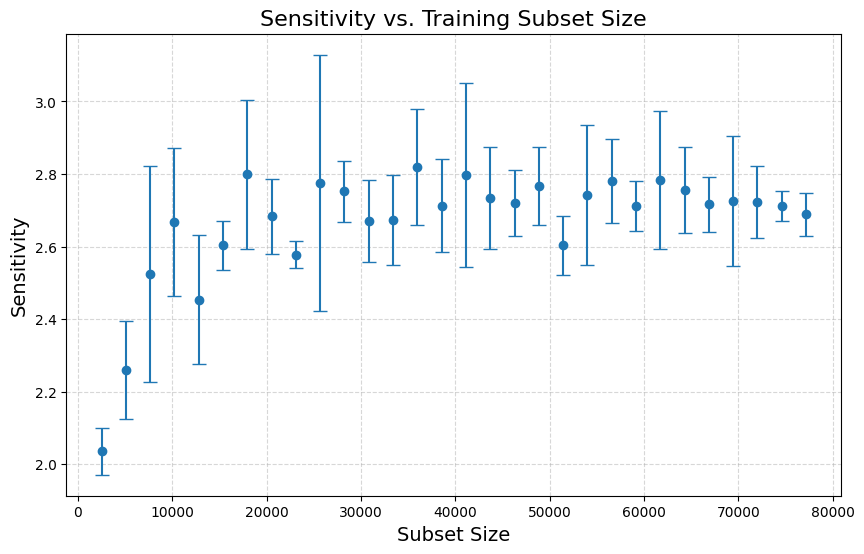

Highest sensitivity achieved with subset size: 35975 Mean Sensitivity = 2.820 with std:0.159


In [ ]:
training_size_plotting(5,df_train, df_val, df_test)

#9. Importance of Input Variables
This part investigates the impact of changing input variables.

In [ ]:
def compute_sensitivity_for_variable_count(num, num_iterations=5):
    """
    Compute sensitivities for a given number of features over multiple iterations.

    Inputs:
    num: number of variables
    num_iterations: number of iterations

    Output:
    mean: mean of sensitivities
    std: standard deviation of sensitivities
    """
    sens_values = [final_model(num)[1] for _ in range(num_iterations)]

    return np.mean(sens_values), np.std(sens_values)

Epoch 1/11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8318 - loss: 0.1174 - val_accuracy: 0.8932 - val_loss: 0.0733
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8929 - loss: 0.0867 - val_accuracy: 0.8978 - val_loss: 0.0712
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.0825 - val_accuracy: 0.8979 - val_loss: 0.0702
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8968 - loss: 0.0839 - val_accuracy: 0.8993 - val_loss: 0.0693
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.0816 - val_accuracy: 0.8982 - val_loss: 0.0685
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.0817 - val_accuracy: 0.8980 - val_loss: 0.0683
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.0811 - val_accuracy: 0.8988 - val_loss: 0.0684
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8991 - loss: 0.0810 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8329 - loss: 0.1128 - val_accuracy: 0.8941 - val_loss: 0.0723
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8947 - loss: 0.0870 - val_accuracy: 0.8953 - val_loss: 0.0703
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8993 - loss: 0.0826 - val_accuracy: 0.8969 - val_loss: 0.0698
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.0813 - val_accuracy: 0.8976 - val_loss: 0.0691
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8995 - loss: 0.0815 - val_accuracy: 0.8990 - val_loss: 0.0686
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.0818 - val_accuracy: 0.8980 - val_loss: 0.0687
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.0821 - val_accuracy: 0.8988 - val_loss: 0.0684
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.0807 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8258 - loss: 0.1178 - val_accuracy: 0.8895 - val_loss: 0.0760
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8903 - loss: 0.0892 - val_accuracy: 0.8950 - val_loss: 0.0722
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.0851 - val_accuracy: 0.8962 - val_loss: 0.0707
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8970 - loss: 0.0836 - val_accuracy: 0.8980 - val_loss: 0.0700
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.0821 - val_accuracy: 0.8984 - val_loss: 0.0697
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8978 - loss: 0.0833 - val_accuracy: 0.9002 - val_loss: 0.0686
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.0825 - val_accuracy: 0.8982 - val_loss: 0.0689
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.0807 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8248 - loss: 0.1193 - val_accuracy: 0.8918 - val_loss: 0.0745
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.0873 - val_accuracy: 0.8974 - val_loss: 0.0705
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8954 - loss: 0.0862 - val_accuracy: 0.8990 - val_loss: 0.0695
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.0824 - val_accuracy: 0.8994 - val_loss: 0.0692
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.0807 - val_accuracy: 0.8991 - val_loss: 0.0694
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9018 - loss: 0.0806 - val_accuracy: 0.8992 - val_loss: 0.0682
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9026 - loss: 0.0795 - val_accuracy: 0.8987 - val_loss: 0.0686
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.0819 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8185 - loss: 0.1181 - val_accuracy: 0.8899 - val_loss: 0.0755
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8941 - loss: 0.0873 - val_accuracy: 0.8955 - val_loss: 0.0721
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.0836 - val_accuracy: 0.8971 - val_loss: 0.0705
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8980 - loss: 0.0831 - val_accuracy: 0.8979 - val_loss: 0.0703
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.0831 - val_accuracy: 0.8981 - val_loss: 0.0692
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.0834 - val_accuracy: 0.8989 - val_loss: 0.0695
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.0818 - val_accuracy: 0.8991 - val_loss: 0.0688
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9018 - loss: 0.0799 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8034 - loss: 0.1319 - val_accuracy: 0.8915 - val_loss: 0.0752
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8931 - loss: 0.0880 - val_accuracy: 0.8956 - val_loss: 0.0724
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 0.0832 - val_accuracy: 0.8979 - val_loss: 0.0706
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.0852 - val_accuracy: 0.8968 - val_loss: 0.0706
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.0832 - val_accuracy: 0.8988 - val_loss: 0.0695
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.0834 - val_accuracy: 0.8964 - val_loss: 0.0697
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9005 - loss: 0.0816 - val_accuracy: 0.8987 - val_loss: 0.0697
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.0823 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8345 - loss: 0.1169 - val_accuracy: 0.8902 - val_loss: 0.0768
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8914 - loss: 0.0889 - val_accuracy: 0.8944 - val_loss: 0.0718
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8938 - loss: 0.0857 - val_accuracy: 0.8967 - val_loss: 0.0707
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8973 - loss: 0.0836 - val_accuracy: 0.8981 - val_loss: 0.0698
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.0815 - val_accuracy: 0.8973 - val_loss: 0.0698
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8998 - loss: 0.0821 - val_accuracy: 0.8981 - val_loss: 0.0695
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.0820 - val_accuracy: 0.8968 - val_loss: 0.0693
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.0813 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8249 - loss: 0.1175 - val_accuracy: 0.8936 - val_loss: 0.0737
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.0867 - val_accuracy: 0.8952 - val_loss: 0.0719
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.0827 - val_accuracy: 0.8981 - val_loss: 0.0703
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.0845 - val_accuracy: 0.8969 - val_loss: 0.0700
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.0826 - val_accuracy: 0.8974 - val_loss: 0.0698
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.0822 - val_accuracy: 0.8980 - val_loss: 0.0698
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.0819 - val_accuracy: 0.8998 - val_loss: 0.0690
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8987 - loss: 0.0821 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8246 - loss: 0.1171 - val_accuracy: 0.8920 - val_loss: 0.0756
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8962 - loss: 0.0870 - val_accuracy: 0.8946 - val_loss: 0.0732
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.0861 - val_accuracy: 0.8968 - val_loss: 0.0709
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.0840 - val_accuracy: 0.8965 - val_loss: 0.0710
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8998 - loss: 0.0820 - val_accuracy: 0.8989 - val_loss: 0.0699
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.0825 - val_accuracy: 0.8984 - val_loss: 0.0698
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8992 - loss: 0.0820 - val_accuracy: 0.8988 - val_loss: 0.0695
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.0837 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7994 - loss: 0.1353 - val_accuracy: 0.8889 - val_loss: 0.0791
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8912 - loss: 0.0890 - val_accuracy: 0.8963 - val_loss: 0.0732
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8969 - loss: 0.0854 - val_accuracy: 0.8978 - val_loss: 0.0717
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8989 - loss: 0.0841 - val_accuracy: 0.8984 - val_loss: 0.0715
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.0845 - val_accuracy: 0.8994 - val_loss: 0.0705
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.0831 - val_accuracy: 0.8997 - val_loss: 0.0702
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.0823 - val_accuracy: 0.9002 - val_loss: 0.0703
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9012 - loss: 0.0824 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8149 - loss: 0.1193 - val_accuracy: 0.8808 - val_loss: 0.0816
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8803 - loss: 0.0909 - val_accuracy: 0.8846 - val_loss: 0.0785
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8863 - loss: 0.0878 - val_accuracy: 0.8861 - val_loss: 0.0767
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8891 - loss: 0.0864 - val_accuracy: 0.8872 - val_loss: 0.0760
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8880 - loss: 0.0847 - val_accuracy: 0.8877 - val_loss: 0.0755
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8890 - loss: 0.0844 - val_accuracy: 0.8869 - val_loss: 0.0766
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8902 - loss: 0.0858 - val_accuracy: 0.8870 - val_loss: 0.0754
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8912 - loss: 0.0817 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7941 - loss: 0.1287 - val_accuracy: 0.8784 - val_loss: 0.0843
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8799 - loss: 0.0912 - val_accuracy: 0.8842 - val_loss: 0.0796
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8872 - loss: 0.0868 - val_accuracy: 0.8857 - val_loss: 0.0768
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8882 - loss: 0.0866 - val_accuracy: 0.8873 - val_loss: 0.0766
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8890 - loss: 0.0856 - val_accuracy: 0.8868 - val_loss: 0.0764
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8896 - loss: 0.0846 - val_accuracy: 0.8866 - val_loss: 0.0765
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8914 - loss: 0.0846 - val_accuracy: 0.8877 - val_loss: 0.0759
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8903 - loss: 0.0842 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8070 - loss: 0.1195 - val_accuracy: 0.8788 - val_loss: 0.0820
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.0892 - val_accuracy: 0.8837 - val_loss: 0.0784
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8863 - loss: 0.0882 - val_accuracy: 0.8867 - val_loss: 0.0764
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8893 - loss: 0.0851 - val_accuracy: 0.8861 - val_loss: 0.0763
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8873 - loss: 0.0865 - val_accuracy: 0.8869 - val_loss: 0.0761
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0851 - val_accuracy: 0.8877 - val_loss: 0.0755
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8901 - loss: 0.0823 - val_accuracy: 0.8855 - val_loss: 0.0759
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8879 - loss: 0.0839 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8273 - loss: 0.1172 - val_accuracy: 0.8826 - val_loss: 0.0803
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.0883 - val_accuracy: 0.8846 - val_loss: 0.0774
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8859 - loss: 0.0875 - val_accuracy: 0.8858 - val_loss: 0.0768
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8867 - loss: 0.0866 - val_accuracy: 0.8850 - val_loss: 0.0765
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0843 - val_accuracy: 0.8864 - val_loss: 0.0761
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8877 - loss: 0.0840 - val_accuracy: 0.8869 - val_loss: 0.0761
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8886 - loss: 0.0836 - val_accuracy: 0.8863 - val_loss: 0.0757
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8901 - loss: 0.0838 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7831 - loss: 0.1287 - val_accuracy: 0.8798 - val_loss: 0.0838
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8794 - loss: 0.0921 - val_accuracy: 0.8857 - val_loss: 0.0797
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8852 - loss: 0.0879 - val_accuracy: 0.8861 - val_loss: 0.0784
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8882 - loss: 0.0860 - val_accuracy: 0.8851 - val_loss: 0.0771
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8861 - loss: 0.0874 - val_accuracy: 0.8870 - val_loss: 0.0760
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.0862 - val_accuracy: 0.8876 - val_loss: 0.0761
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8900 - loss: 0.0845 - val_accuracy: 0.8877 - val_loss: 0.0761
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0851 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8012 - loss: 0.1269 - val_accuracy: 0.8788 - val_loss: 0.0834
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8790 - loss: 0.0926 - val_accuracy: 0.8836 - val_loss: 0.0789
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8837 - loss: 0.0890 - val_accuracy: 0.8853 - val_loss: 0.0771
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8880 - loss: 0.0863 - val_accuracy: 0.8853 - val_loss: 0.0765
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8864 - loss: 0.0877 - val_accuracy: 0.8877 - val_loss: 0.0761
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8872 - loss: 0.0877 - val_accuracy: 0.8884 - val_loss: 0.0757
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8879 - loss: 0.0864 - val_accuracy: 0.8860 - val_loss: 0.0755
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8881 - loss: 0.0854 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8026 - loss: 0.1233 - val_accuracy: 0.8749 - val_loss: 0.0841
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.0922 - val_accuracy: 0.8823 - val_loss: 0.0791
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8826 - loss: 0.0903 - val_accuracy: 0.8839 - val_loss: 0.0776
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8852 - loss: 0.0881 - val_accuracy: 0.8857 - val_loss: 0.0761
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8876 - loss: 0.0860 - val_accuracy: 0.8870 - val_loss: 0.0761
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8893 - loss: 0.0858 - val_accuracy: 0.8876 - val_loss: 0.0762
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8900 - loss: 0.0850 - val_accuracy: 0.8871 - val_loss: 0.0754
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8897 - loss: 0.0838 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7811 - loss: 0.1323 - val_accuracy: 0.8763 - val_loss: 0.0888
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8782 - loss: 0.0948 - val_accuracy: 0.8852 - val_loss: 0.0795
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8846 - loss: 0.0899 - val_accuracy: 0.8843 - val_loss: 0.0773
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8884 - loss: 0.0869 - val_accuracy: 0.8869 - val_loss: 0.0758
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8870 - loss: 0.0871 - val_accuracy: 0.8872 - val_loss: 0.0756
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8903 - loss: 0.0846 - val_accuracy: 0.8881 - val_loss: 0.0755
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8894 - loss: 0.0862 - val_accuracy: 0.8877 - val_loss: 0.0753
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8876 - loss: 0.0864 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8025 - loss: 0.1239 - val_accuracy: 0.8758 - val_loss: 0.0834
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8764 - loss: 0.0930 - val_accuracy: 0.8820 - val_loss: 0.0794
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8827 - loss: 0.0905 - val_accuracy: 0.8868 - val_loss: 0.0776
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8862 - loss: 0.0870 - val_accuracy: 0.8872 - val_loss: 0.0768
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8870 - loss: 0.0853 - val_accuracy: 0.8869 - val_loss: 0.0766
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8904 - loss: 0.0848 - val_accuracy: 0.8874 - val_loss: 0.0758
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8894 - loss: 0.0868 - val_accuracy: 0.8881 - val_loss: 0.0758
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8894 - loss: 0.0841 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8085 - loss: 0.1212 - val_accuracy: 0.8807 - val_loss: 0.0807
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8815 - loss: 0.0900 - val_accuracy: 0.8849 - val_loss: 0.0775
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8866 - loss: 0.0877 - val_accuracy: 0.8859 - val_loss: 0.0770
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8868 - loss: 0.0859 - val_accuracy: 0.8872 - val_loss: 0.0758
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8891 - loss: 0.0841 - val_accuracy: 0.8881 - val_loss: 0.0754
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8922 - loss: 0.0831 - val_accuracy: 0.8886 - val_loss: 0.0754
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8882 - loss: 0.0847 - val_accuracy: 0.8878 - val_loss: 0.0752
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8892 - loss: 0.0841 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8339 - loss: 0.1146 - val_accuracy: 0.8804 - val_loss: 0.0800
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8803 - loss: 0.0904 - val_accuracy: 0.8829 - val_loss: 0.0782
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8833 - loss: 0.0883 - val_accuracy: 0.8856 - val_loss: 0.0772
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8839 - loss: 0.0880 - val_accuracy: 0.8860 - val_loss: 0.0764
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0856 - val_accuracy: 0.8848 - val_loss: 0.0763
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8888 - loss: 0.0863 - val_accuracy: 0.8861 - val_loss: 0.0761
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.0858 - val_accuracy: 0.8858 - val_loss: 0.0759
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0861 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8005 - loss: 0.1260 - val_accuracy: 0.8800 - val_loss: 0.0814
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8803 - loss: 0.0933 - val_accuracy: 0.8860 - val_loss: 0.0780
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8851 - loss: 0.0884 - val_accuracy: 0.8873 - val_loss: 0.0769
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8904 - loss: 0.0861 - val_accuracy: 0.8869 - val_loss: 0.0760
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8887 - loss: 0.0857 - val_accuracy: 0.8877 - val_loss: 0.0757
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8891 - loss: 0.0859 - val_accuracy: 0.8889 - val_loss: 0.0755
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8895 - loss: 0.0847 - val_accuracy: 0.8889 - val_loss: 0.0756
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8900 - loss: 0.0859 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8101 - loss: 0.1210 - val_accuracy: 0.8788 - val_loss: 0.0813
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.0912 - val_accuracy: 0.8848 - val_loss: 0.0776
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.0900 - val_accuracy: 0.8878 - val_loss: 0.0764
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8859 - loss: 0.0877 - val_accuracy: 0.8890 - val_loss: 0.0757
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8863 - loss: 0.0866 - val_accuracy: 0.8890 - val_loss: 0.0754
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8888 - loss: 0.0850 - val_accuracy: 0.8877 - val_loss: 0.0760
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8911 - loss: 0.0830 - val_accuracy: 0.8896 - val_loss: 0.0752
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8870 - loss: 0.0862 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8313 - loss: 0.1130 - val_accuracy: 0.8832 - val_loss: 0.0786
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8831 - loss: 0.0889 - val_accuracy: 0.8857 - val_loss: 0.0771
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8850 - loss: 0.0870 - val_accuracy: 0.8861 - val_loss: 0.0764
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0855 - val_accuracy: 0.8869 - val_loss: 0.0759
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.0865 - val_accuracy: 0.8876 - val_loss: 0.0757
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8886 - loss: 0.0852 - val_accuracy: 0.8887 - val_loss: 0.0755
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8914 - loss: 0.0840 - val_accuracy: 0.8882 - val_loss: 0.0756
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8893 - loss: 0.0854 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8026 - loss: 0.1229 - val_accuracy: 0.8796 - val_loss: 0.0814
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8805 - loss: 0.0912 - val_accuracy: 0.8857 - val_loss: 0.0774
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8846 - loss: 0.0879 - val_accuracy: 0.8874 - val_loss: 0.0762
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8894 - loss: 0.0867 - val_accuracy: 0.8881 - val_loss: 0.0762
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8886 - loss: 0.0865 - val_accuracy: 0.8878 - val_loss: 0.0755
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8891 - loss: 0.0854 - val_accuracy: 0.8888 - val_loss: 0.0751
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8898 - loss: 0.0869 - val_accuracy: 0.8878 - val_loss: 0.0763
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8921 - loss: 0.0840 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8099 - loss: 0.1230 - val_accuracy: 0.8779 - val_loss: 0.0816
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8821 - loss: 0.0908 - val_accuracy: 0.8828 - val_loss: 0.0785
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8818 - loss: 0.0891 - val_accuracy: 0.8843 - val_loss: 0.0779
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.0898 - val_accuracy: 0.8848 - val_loss: 0.0775
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8874 - loss: 0.0860 - val_accuracy: 0.8849 - val_loss: 0.0771
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8874 - loss: 0.0863 - val_accuracy: 0.8855 - val_loss: 0.0764
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8864 - loss: 0.0861 - val_accuracy: 0.8850 - val_loss: 0.0764
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8875 - loss: 0.0853 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7907 - loss: 0.1332 - val_accuracy: 0.8803 - val_loss: 0.0827
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0945 - val_accuracy: 0.8846 - val_loss: 0.0789
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8871 - loss: 0.0901 - val_accuracy: 0.8878 - val_loss: 0.0774
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8869 - loss: 0.0893 - val_accuracy: 0.8877 - val_loss: 0.0778
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8873 - loss: 0.0866 - val_accuracy: 0.8858 - val_loss: 0.0772
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8858 - loss: 0.0874 - val_accuracy: 0.8872 - val_loss: 0.0768
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8884 - loss: 0.0875 - val_accuracy: 0.8881 - val_loss: 0.0764
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8885 - loss: 0.0857 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8051 - loss: 0.1232 - val_accuracy: 0.8780 - val_loss: 0.0831
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8770 - loss: 0.0940 - val_accuracy: 0.8833 - val_loss: 0.0791
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8841 - loss: 0.0886 - val_accuracy: 0.8852 - val_loss: 0.0773
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8852 - loss: 0.0879 - val_accuracy: 0.8859 - val_loss: 0.0771
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8867 - loss: 0.0877 - val_accuracy: 0.8865 - val_loss: 0.0763
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8861 - loss: 0.0873 - val_accuracy: 0.8872 - val_loss: 0.0762
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8883 - loss: 0.0859 - val_accuracy: 0.8870 - val_loss: 0.0766
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8850 - loss: 0.0873 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8039 - loss: 0.1233 - val_accuracy: 0.8797 - val_loss: 0.0801
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0909 - val_accuracy: 0.8832 - val_loss: 0.0785
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8859 - loss: 0.0882 - val_accuracy: 0.8852 - val_loss: 0.0778
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8837 - loss: 0.0884 - val_accuracy: 0.8846 - val_loss: 0.0773
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8855 - loss: 0.0883 - val_accuracy: 0.8854 - val_loss: 0.0770
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8865 - loss: 0.0885 - val_accuracy: 0.8870 - val_loss: 0.0764
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8872 - loss: 0.0868 - val_accuracy: 0.8863 - val_loss: 0.0770
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8885 - loss: 0.0856 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8147 - loss: 0.1216 - val_accuracy: 0.8763 - val_loss: 0.0841
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8777 - loss: 0.0942 - val_accuracy: 0.8824 - val_loss: 0.0794
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8826 - loss: 0.0904 - val_accuracy: 0.8834 - val_loss: 0.0780
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8845 - loss: 0.0887 - val_accuracy: 0.8852 - val_loss: 0.0770
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8874 - loss: 0.0877 - val_accuracy: 0.8857 - val_loss: 0.0766
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8857 - loss: 0.0863 - val_accuracy: 0.8861 - val_loss: 0.0769
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8881 - loss: 0.0874 - val_accuracy: 0.8865 - val_loss: 0.0767
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8878 - loss: 0.0869 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7893 - loss: 0.1251 - val_accuracy: 0.8770 - val_loss: 0.0815
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8782 - loss: 0.0930 - val_accuracy: 0.8807 - val_loss: 0.0791
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8807 - loss: 0.0914 - val_accuracy: 0.8829 - val_loss: 0.0784
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.0902 - val_accuracy: 0.8852 - val_loss: 0.0779
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.0887 - val_accuracy: 0.8858 - val_loss: 0.0776
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8858 - loss: 0.0888 - val_accuracy: 0.8851 - val_loss: 0.0776
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8857 - loss: 0.0868 - val_accuracy: 0.8859 - val_loss: 0.0771
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8860 - loss: 0.0885 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8166 - loss: 0.1251 - val_accuracy: 0.8793 - val_loss: 0.0830
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8809 - loss: 0.0940 - val_accuracy: 0.8843 - val_loss: 0.0799
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8842 - loss: 0.0899 - val_accuracy: 0.8850 - val_loss: 0.0784
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8872 - loss: 0.0891 - val_accuracy: 0.8855 - val_loss: 0.0786
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8865 - loss: 0.0875 - val_accuracy: 0.8858 - val_loss: 0.0779
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8863 - loss: 0.0890 - val_accuracy: 0.8852 - val_loss: 0.0782
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8850 - loss: 0.0887 - val_accuracy: 0.8867 - val_loss: 0.0771
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8878 - loss: 0.0878 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8145 - loss: 0.1197 - val_accuracy: 0.8739 - val_loss: 0.0828
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8808 - loss: 0.0921 - val_accuracy: 0.8808 - val_loss: 0.0790
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8828 - loss: 0.0889 - val_accuracy: 0.8833 - val_loss: 0.0778
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8831 - loss: 0.0886 - val_accuracy: 0.8815 - val_loss: 0.0784
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8861 - loss: 0.0870 - val_accuracy: 0.8822 - val_loss: 0.0780
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.0880 - val_accuracy: 0.8835 - val_loss: 0.0774
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8849 - loss: 0.0877 - val_accuracy: 0.8844 - val_loss: 0.0774
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.0863 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8117 - loss: 0.1221 - val_accuracy: 0.8785 - val_loss: 0.0815
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8787 - loss: 0.0921 - val_accuracy: 0.8820 - val_loss: 0.0789
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8828 - loss: 0.0903 - val_accuracy: 0.8823 - val_loss: 0.0781
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8869 - loss: 0.0875 - val_accuracy: 0.8843 - val_loss: 0.0776
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8842 - loss: 0.0870 - val_accuracy: 0.8854 - val_loss: 0.0769
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8891 - loss: 0.0857 - val_accuracy: 0.8847 - val_loss: 0.0769
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8861 - loss: 0.0873 - val_accuracy: 0.8869 - val_loss: 0.0769
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8874 - loss: 0.0871 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7818 - loss: 0.1302 - val_accuracy: 0.8791 - val_loss: 0.0818
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8803 - loss: 0.0937 - val_accuracy: 0.8830 - val_loss: 0.0786
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8839 - loss: 0.0903 - val_accuracy: 0.8852 - val_loss: 0.0779
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8842 - loss: 0.0878 - val_accuracy: 0.8848 - val_loss: 0.0780
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8862 - loss: 0.0875 - val_accuracy: 0.8853 - val_loss: 0.0776
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8852 - loss: 0.0882 - val_accuracy: 0.8861 - val_loss: 0.0776
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8849 - loss: 0.0868 - val_accuracy: 0.8850 - val_loss: 0.0784
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8848 - loss: 0.0886 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8035 - loss: 0.1223 - val_accuracy: 0.8747 - val_loss: 0.0826
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8791 - loss: 0.0937 - val_accuracy: 0.8795 - val_loss: 0.0800
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.0919 - val_accuracy: 0.8820 - val_loss: 0.0789
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8792 - loss: 0.0924 - val_accuracy: 0.8831 - val_loss: 0.0785
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8841 - loss: 0.0887 - val_accuracy: 0.8831 - val_loss: 0.0787
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8830 - loss: 0.0891 - val_accuracy: 0.8832 - val_loss: 0.0783
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8847 - loss: 0.0880 - val_accuracy: 0.8815 - val_loss: 0.0781
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8830 - loss: 0.0885 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7911 - loss: 0.1330 - val_accuracy: 0.8676 - val_loss: 0.0871
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8732 - loss: 0.0969 - val_accuracy: 0.8789 - val_loss: 0.0809
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8776 - loss: 0.0934 - val_accuracy: 0.8818 - val_loss: 0.0793
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8825 - loss: 0.0903 - val_accuracy: 0.8809 - val_loss: 0.0801
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8822 - loss: 0.0888 - val_accuracy: 0.8802 - val_loss: 0.0802
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8825 - loss: 0.0904 - val_accuracy: 0.8815 - val_loss: 0.0787
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8838 - loss: 0.0895 - val_accuracy: 0.8819 - val_loss: 0.0785
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8832 - loss: 0.0895 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7980 - loss: 0.1249 - val_accuracy: 0.8775 - val_loss: 0.0814
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8773 - loss: 0.0942 - val_accuracy: 0.8809 - val_loss: 0.0790
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8829 - loss: 0.0894 - val_accuracy: 0.8814 - val_loss: 0.0791
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8853 - loss: 0.0879 - val_accuracy: 0.8824 - val_loss: 0.0787
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8852 - loss: 0.0897 - val_accuracy: 0.8829 - val_loss: 0.0784
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8834 - loss: 0.0899 - val_accuracy: 0.8830 - val_loss: 0.0778
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.0906 - val_accuracy: 0.8837 - val_loss: 0.0783
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8840 - loss: 0.0890 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7987 - loss: 0.1298 - val_accuracy: 0.8770 - val_loss: 0.0828
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8791 - loss: 0.0944 - val_accuracy: 0.8818 - val_loss: 0.0799
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8846 - loss: 0.0911 - val_accuracy: 0.8818 - val_loss: 0.0794
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8826 - loss: 0.0919 - val_accuracy: 0.8815 - val_loss: 0.0789
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8846 - loss: 0.0900 - val_accuracy: 0.8838 - val_loss: 0.0781
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8849 - loss: 0.0888 - val_accuracy: 0.8840 - val_loss: 0.0782
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8840 - loss: 0.0888 - val_accuracy: 0.8832 - val_loss: 0.0779
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8842 - loss: 0.0880 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8288 - loss: 0.1192 - val_accuracy: 0.8760 - val_loss: 0.0820
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8761 - loss: 0.0930 - val_accuracy: 0.8809 - val_loss: 0.0793
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.0907 - val_accuracy: 0.8811 - val_loss: 0.0790
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8829 - loss: 0.0896 - val_accuracy: 0.8816 - val_loss: 0.0789
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8832 - loss: 0.0888 - val_accuracy: 0.8818 - val_loss: 0.0787
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8861 - loss: 0.0888 - val_accuracy: 0.8809 - val_loss: 0.0789
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8849 - loss: 0.0879 - val_accuracy: 0.8821 - val_loss: 0.0782
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8842 - loss: 0.0888 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7914 - loss: 0.1286 - val_accuracy: 0.8759 - val_loss: 0.0841
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8753 - loss: 0.0960 - val_accuracy: 0.8785 - val_loss: 0.0806
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8783 - loss: 0.0944 - val_accuracy: 0.8799 - val_loss: 0.0798
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8819 - loss: 0.0905 - val_accuracy: 0.8803 - val_loss: 0.0792
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8827 - loss: 0.0910 - val_accuracy: 0.8801 - val_loss: 0.0797
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.0896 - val_accuracy: 0.8814 - val_loss: 0.0794
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0917 - val_accuracy: 0.8808 - val_loss: 0.0791
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8815 - loss: 0.0908 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8281 - loss: 0.1162 - val_accuracy: 0.8783 - val_loss: 0.0812
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.0935 - val_accuracy: 0.8820 - val_loss: 0.0794
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8828 - loss: 0.0910 - val_accuracy: 0.8817 - val_loss: 0.0792
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8807 - loss: 0.0915 - val_accuracy: 0.8815 - val_loss: 0.0790
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8814 - loss: 0.0906 - val_accuracy: 0.8826 - val_loss: 0.0785
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8833 - loss: 0.0888 - val_accuracy: 0.8821 - val_loss: 0.0787
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8824 - loss: 0.0903 - val_accuracy: 0.8817 - val_loss: 0.0786
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.0910 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7981 - loss: 0.1291 - val_accuracy: 0.8744 - val_loss: 0.0835
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8760 - loss: 0.0953 - val_accuracy: 0.8789 - val_loss: 0.0800
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8801 - loss: 0.0931 - val_accuracy: 0.8806 - val_loss: 0.0793
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8832 - loss: 0.0906 - val_accuracy: 0.8817 - val_loss: 0.0790
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8803 - loss: 0.0923 - val_accuracy: 0.8815 - val_loss: 0.0789
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8827 - loss: 0.0910 - val_accuracy: 0.8814 - val_loss: 0.0788
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8832 - loss: 0.0920 - val_accuracy: 0.8817 - val_loss: 0.0786
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8808 - loss: 0.0906 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8312 - loss: 0.1163 - val_accuracy: 0.8773 - val_loss: 0.0807
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8779 - loss: 0.0942 - val_accuracy: 0.8808 - val_loss: 0.0788
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8808 - loss: 0.0911 - val_accuracy: 0.8802 - val_loss: 0.0788
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8813 - loss: 0.0923 - val_accuracy: 0.8809 - val_loss: 0.0786
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8818 - loss: 0.0915 - val_accuracy: 0.8799 - val_loss: 0.0791
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8833 - loss: 0.0898 - val_accuracy: 0.8803 - val_loss: 0.0790
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8824 - loss: 0.0899 - val_accuracy: 0.8812 - val_loss: 0.0788
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8830 - loss: 0.0900 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8314 - loss: 0.1191 - val_accuracy: 0.8756 - val_loss: 0.0826
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.0940 - val_accuracy: 0.8811 - val_loss: 0.0797
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8809 - loss: 0.0912 - val_accuracy: 0.8812 - val_loss: 0.0791
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8819 - loss: 0.0906 - val_accuracy: 0.8811 - val_loss: 0.0792
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8834 - loss: 0.0898 - val_accuracy: 0.8811 - val_loss: 0.0788
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8844 - loss: 0.0892 - val_accuracy: 0.8816 - val_loss: 0.0787
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8831 - loss: 0.0900 - val_accuracy: 0.8819 - val_loss: 0.0786
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8808 - loss: 0.0907 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8029 - loss: 0.1282 - val_accuracy: 0.8707 - val_loss: 0.0876
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8731 - loss: 0.0977 - val_accuracy: 0.8784 - val_loss: 0.0826
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.0943 - val_accuracy: 0.8794 - val_loss: 0.0805
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8807 - loss: 0.0931 - val_accuracy: 0.8805 - val_loss: 0.0800
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8804 - loss: 0.0921 - val_accuracy: 0.8806 - val_loss: 0.0796
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8832 - loss: 0.0904 - val_accuracy: 0.8816 - val_loss: 0.0791
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8797 - loss: 0.0930 - val_accuracy: 0.8809 - val_loss: 0.0790
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8803 - loss: 0.0905 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8249 - loss: 0.1213 - val_accuracy: 0.8693 - val_loss: 0.0875
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8692 - loss: 0.0998 - val_accuracy: 0.8739 - val_loss: 0.0827
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8770 - loss: 0.0940 - val_accuracy: 0.8800 - val_loss: 0.0802
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8783 - loss: 0.0926 - val_accuracy: 0.8818 - val_loss: 0.0792
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.0918 - val_accuracy: 0.8809 - val_loss: 0.0792
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8802 - loss: 0.0932 - val_accuracy: 0.8808 - val_loss: 0.0788
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8827 - loss: 0.0905 - val_accuracy: 0.8817 - val_loss: 0.0784
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8828 - loss: 0.0897 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8260 - loss: 0.1183 - val_accuracy: 0.8762 - val_loss: 0.0811
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8780 - loss: 0.0930 - val_accuracy: 0.8750 - val_loss: 0.0816
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8803 - loss: 0.0919 - val_accuracy: 0.8766 - val_loss: 0.0815
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.0917 - val_accuracy: 0.8807 - val_loss: 0.0792
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8788 - loss: 0.0930 - val_accuracy: 0.8802 - val_loss: 0.0795
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.0911 - val_accuracy: 0.8813 - val_loss: 0.0790
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8815 - loss: 0.0912 - val_accuracy: 0.8815 - val_loss: 0.0792
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.0925 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8275 - loss: 0.1170 - val_accuracy: 0.8771 - val_loss: 0.0820
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8755 - loss: 0.0955 - val_accuracy: 0.8795 - val_loss: 0.0799
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8797 - loss: 0.0933 - val_accuracy: 0.8808 - val_loss: 0.0792
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.0925 - val_accuracy: 0.8800 - val_loss: 0.0795
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8790 - loss: 0.0919 - val_accuracy: 0.8804 - val_loss: 0.0792
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8835 - loss: 0.0897 - val_accuracy: 0.8810 - val_loss: 0.0789
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8794 - loss: 0.0927 - val_accuracy: 0.8806 - val_loss: 0.0788
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8832 - loss: 0.0900 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8008 - loss: 0.1270 - val_accuracy: 0.8756 - val_loss: 0.0822
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8783 - loss: 0.0935 - val_accuracy: 0.8796 - val_loss: 0.0800
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8804 - loss: 0.0934 - val_accuracy: 0.8807 - val_loss: 0.0793
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.0914 - val_accuracy: 0.8811 - val_loss: 0.0798
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8815 - loss: 0.0927 - val_accuracy: 0.8800 - val_loss: 0.0791
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8825 - loss: 0.0910 - val_accuracy: 0.8808 - val_loss: 0.0794
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8827 - loss: 0.0906 - val_accuracy: 0.8808 - val_loss: 0.0790
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0909 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8161 - loss: 0.1269 - val_accuracy: 0.8773 - val_loss: 0.0820
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8808 - loss: 0.0927 - val_accuracy: 0.8803 - val_loss: 0.0803
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0922 - val_accuracy: 0.8816 - val_loss: 0.0793
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8833 - loss: 0.0907 - val_accuracy: 0.8795 - val_loss: 0.0798
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8821 - loss: 0.0899 - val_accuracy: 0.8792 - val_loss: 0.0798
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8816 - loss: 0.0911 - val_accuracy: 0.8808 - val_loss: 0.0790
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.0912 - val_accuracy: 0.8805 - val_loss: 0.0788
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8826 - loss: 0.0893 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8316 - loss: 0.1217 - val_accuracy: 0.8781 - val_loss: 0.0820
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8790 - loss: 0.0937 - val_accuracy: 0.8764 - val_loss: 0.0806
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8804 - loss: 0.0924 - val_accuracy: 0.8796 - val_loss: 0.0794
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8826 - loss: 0.0898 - val_accuracy: 0.8800 - val_loss: 0.0796
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.0924 - val_accuracy: 0.8806 - val_loss: 0.0789
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8823 - loss: 0.0913 - val_accuracy: 0.8796 - val_loss: 0.0794
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8809 - loss: 0.0914 - val_accuracy: 0.8803 - val_loss: 0.0790
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.0915 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8100 - loss: 0.1252 - val_accuracy: 0.8779 - val_loss: 0.0814
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8819 - loss: 0.0931 - val_accuracy: 0.8808 - val_loss: 0.0803
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8825 - loss: 0.0931 - val_accuracy: 0.8800 - val_loss: 0.0800
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8829 - loss: 0.0926 - val_accuracy: 0.8808 - val_loss: 0.0797
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8813 - loss: 0.0915 - val_accuracy: 0.8792 - val_loss: 0.0800
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8809 - loss: 0.0934 - val_accuracy: 0.8806 - val_loss: 0.0797
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8814 - loss: 0.0912 - val_accuracy: 0.8799 - val_loss: 0.0799
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8841 - loss: 0.0902 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8140 - loss: 0.1267 - val_accuracy: 0.8740 - val_loss: 0.0812
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8785 - loss: 0.0950 - val_accuracy: 0.8763 - val_loss: 0.0811
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8801 - loss: 0.0925 - val_accuracy: 0.8792 - val_loss: 0.0792
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8797 - loss: 0.0921 - val_accuracy: 0.8802 - val_loss: 0.0794
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.0919 - val_accuracy: 0.8785 - val_loss: 0.0798
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8802 - loss: 0.0919 - val_accuracy: 0.8808 - val_loss: 0.0792
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8824 - loss: 0.0912 - val_accuracy: 0.8800 - val_loss: 0.0794
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8803 - loss: 0.0920 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8064 - loss: 0.1316 - val_accuracy: 0.8783 - val_loss: 0.0835
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8812 - loss: 0.0952 - val_accuracy: 0.8791 - val_loss: 0.0818
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8822 - loss: 0.0928 - val_accuracy: 0.8801 - val_loss: 0.0809
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8822 - loss: 0.0933 - val_accuracy: 0.8815 - val_loss: 0.0804
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8816 - loss: 0.0939 - val_accuracy: 0.8818 - val_loss: 0.0802
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8821 - loss: 0.0908 - val_accuracy: 0.8814 - val_loss: 0.0799
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8828 - loss: 0.0914 - val_accuracy: 0.8807 - val_loss: 0.0795
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8833 - loss: 0.0903 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8141 - loss: 0.1273 - val_accuracy: 0.8757 - val_loss: 0.0807
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8784 - loss: 0.0936 - val_accuracy: 0.8783 - val_loss: 0.0798
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.0919 - val_accuracy: 0.8779 - val_loss: 0.0798
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8822 - loss: 0.0914 - val_accuracy: 0.8782 - val_loss: 0.0805
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8801 - loss: 0.0920 - val_accuracy: 0.8776 - val_loss: 0.0799
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8809 - loss: 0.0916 - val_accuracy: 0.8789 - val_loss: 0.0799
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8775 - loss: 0.0937 - val_accuracy: 0.8787 - val_loss: 0.0796
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.0910 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8326 - loss: 0.1215 - val_accuracy: 0.8771 - val_loss: 0.0809
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8774 - loss: 0.0929 - val_accuracy: 0.8761 - val_loss: 0.0802
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8800 - loss: 0.0905 - val_accuracy: 0.8779 - val_loss: 0.0801
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8813 - loss: 0.0911 - val_accuracy: 0.8777 - val_loss: 0.0805
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8779 - loss: 0.0929 - val_accuracy: 0.8775 - val_loss: 0.0801
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8783 - loss: 0.0914 - val_accuracy: 0.8776 - val_loss: 0.0800
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8792 - loss: 0.0924 - val_accuracy: 0.8776 - val_loss: 0.0799
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8796 - loss: 0.0920 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8388 - loss: 0.1199 - val_accuracy: 0.8737 - val_loss: 0.0830
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8771 - loss: 0.0948 - val_accuracy: 0.8770 - val_loss: 0.0809
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8785 - loss: 0.0923 - val_accuracy: 0.8776 - val_loss: 0.0802
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8806 - loss: 0.0927 - val_accuracy: 0.8789 - val_loss: 0.0798
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8796 - loss: 0.0911 - val_accuracy: 0.8784 - val_loss: 0.0797
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8794 - loss: 0.0917 - val_accuracy: 0.8777 - val_loss: 0.0798
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8795 - loss: 0.0915 - val_accuracy: 0.8773 - val_loss: 0.0797
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8804 - loss: 0.0891 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8293 - loss: 0.1323 - val_accuracy: 0.8754 - val_loss: 0.0817
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8763 - loss: 0.0943 - val_accuracy: 0.8773 - val_loss: 0.0803
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8777 - loss: 0.0924 - val_accuracy: 0.8785 - val_loss: 0.0799
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8797 - loss: 0.0935 - val_accuracy: 0.8782 - val_loss: 0.0803
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.0922 - val_accuracy: 0.8775 - val_loss: 0.0801
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8795 - loss: 0.0909 - val_accuracy: 0.8777 - val_loss: 0.0797
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8812 - loss: 0.0911 - val_accuracy: 0.8758 - val_loss: 0.0803
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8803 - loss: 0.0917 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8299 - loss: 0.1182 - val_accuracy: 0.8779 - val_loss: 0.0808
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8780 - loss: 0.0951 - val_accuracy: 0.8786 - val_loss: 0.0798
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8804 - loss: 0.0930 - val_accuracy: 0.8783 - val_loss: 0.0800
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8805 - loss: 0.0911 - val_accuracy: 0.8790 - val_loss: 0.0797
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8802 - loss: 0.0922 - val_accuracy: 0.8782 - val_loss: 0.0795
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8784 - loss: 0.0929 - val_accuracy: 0.8780 - val_loss: 0.0799
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8780 - loss: 0.0929 - val_accuracy: 0.8787 - val_loss: 0.0796
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8799 - loss: 0.0908 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8153 - loss: 0.1284 - val_accuracy: 0.8742 - val_loss: 0.0931
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8771 - loss: 0.1023 - val_accuracy: 0.8757 - val_loss: 0.0909
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8772 - loss: 0.1021 - val_accuracy: 0.8761 - val_loss: 0.0898
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8767 - loss: 0.1014 - val_accuracy: 0.8757 - val_loss: 0.0896
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.0997 - val_accuracy: 0.8742 - val_loss: 0.0898
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8785 - loss: 0.0999 - val_accuracy: 0.8764 - val_loss: 0.0885
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8744 - loss: 0.1017 - val_accuracy: 0.8758 - val_loss: 0.0883
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8773 - loss: 0.0999 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8224 - loss: 0.1274 - val_accuracy: 0.8760 - val_loss: 0.0880
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8769 - loss: 0.1013 - val_accuracy: 0.8754 - val_loss: 0.0879
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8777 - loss: 0.0998 - val_accuracy: 0.8756 - val_loss: 0.0879
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8795 - loss: 0.0996 - val_accuracy: 0.8761 - val_loss: 0.0875
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8762 - loss: 0.1006 - val_accuracy: 0.8756 - val_loss: 0.0875
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8774 - loss: 0.0985 - val_accuracy: 0.8759 - val_loss: 0.0874
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8775 - loss: 0.0996 - val_accuracy: 0.8740 - val_loss: 0.0885
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8765 - loss: 0.0996 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8378 - loss: 0.1200 - val_accuracy: 0.8745 - val_loss: 0.0895
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8778 - loss: 0.0999 - val_accuracy: 0.8751 - val_loss: 0.0884
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8761 - loss: 0.1006 - val_accuracy: 0.8757 - val_loss: 0.0882
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8771 - loss: 0.1012 - val_accuracy: 0.8763 - val_loss: 0.0878
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8768 - loss: 0.0983 - val_accuracy: 0.8763 - val_loss: 0.0878
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8793 - loss: 0.0983 - val_accuracy: 0.8754 - val_loss: 0.0877
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8790 - loss: 0.0987 - val_accuracy: 0.8759 - val_loss: 0.0880
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8756 - loss: 0.1001 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8130 - loss: 0.1319 - val_accuracy: 0.8739 - val_loss: 0.0902
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8760 - loss: 0.1003 - val_accuracy: 0.8743 - val_loss: 0.0886
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8767 - loss: 0.0999 - val_accuracy: 0.8757 - val_loss: 0.0880
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8761 - loss: 0.1017 - val_accuracy: 0.8758 - val_loss: 0.0876
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8760 - loss: 0.0995 - val_accuracy: 0.8757 - val_loss: 0.0874
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8771 - loss: 0.1004 - val_accuracy: 0.8750 - val_loss: 0.0874
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8787 - loss: 0.0981 - val_accuracy: 0.8758 - val_loss: 0.0873
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8782 - loss: 0.0996 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8260 - loss: 0.1301 - val_accuracy: 0.8760 - val_loss: 0.0879
Epoch 2/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8778 - loss: 0.1002 - val_accuracy: 0.8760 - val_loss: 0.0874
Epoch 3/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8749 - loss: 0.1004 - val_accuracy: 0.8741 - val_loss: 0.0889
Epoch 4/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8761 - loss: 0.1001 - val_accuracy: 0.8756 - val_loss: 0.0873
Epoch 5/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8759 - loss: 0.1009 - val_accuracy: 0.8745 - val_loss: 0.0878
Epoch 6/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8785 - loss: 0.0988 - val_accuracy: 0.8762 - val_loss: 0.0873
Epoch 7/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8766 - loss: 0.0997 - val_accuracy: 0.8757 - val_loss: 0.0871
Epoch 8/11
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8758 - loss: 0.0991 - val_accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

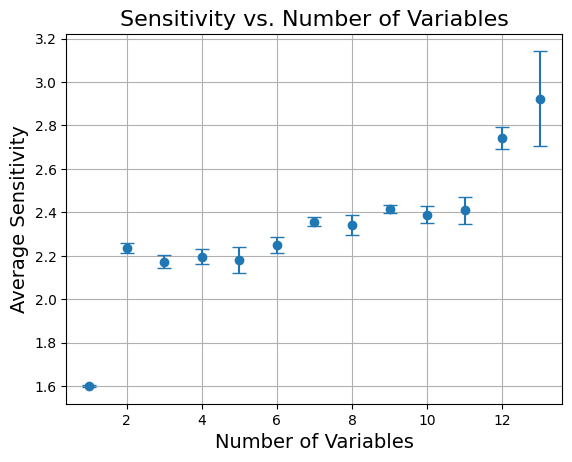

In [ ]:
def plot_sensitivity_vs_variables(num_iterations=5):
  """
  Plot sensitivity achieved by the final neural network model for different numbers of variables.

  Inputs:
  num_iterations: Number of times to run the training and sensitivity calculation
  """
  sens_lst_avg = []
  sens_lst_std = []
  # Number of features from 13 down to 1
  feature_counts = np.arange(13, 0, -1)

  # Compute sensitivity stats for each feature count
  for count in feature_counts:
      avg, std = compute_sensitivity_for_variable_count(count, num_iterations)
      sens_lst_avg.append(avg)
      sens_lst_std.append(std)

  # Plot using error bars
  plt.errorbar(feature_counts, sens_lst_avg, yerr=sens_lst_std, fmt='o', capsize=5)
  plt.xlabel('Number of Variables', fontsize=14)
  plt.ylabel('Average Sensitivity', fontsize=14)
  plt.title('Sensitivity vs. Number of Variables',  fontsize=16)
  plt.grid(True)
  plt.savefig('sensitivity_vs_variables.png',dpi=400)
  files.download('sensitivity_vs_variables.png')
  plt.show()

# call function
plot_sensitivity_vs_variables(num_iterations=5)

# Conclusion

The machine learning framework presented here demonstrates the capacity of **supervised neural networks** to enhance signal detection in the $H \to b\bar{b}$ channel, surpassing traditional cut-based methods by exploiting the high-dimensional correlations among multiple kinematic and topological variables. Through careful data preprocessing—such as feature selection (via PCA), standardization, and weighting to account for varying cross sections—each model is trained and evaluated in a consistent environment.  

Repeated tests show that while simple configurations (e.g., a single hidden layer) can already yield improvements over univariate cuts, deeper or more carefully tuned networks can achieve even higher sensitivity $S/\sqrt{B}$. Grid or random searches for hyperparameters (e.g., number of nodes, hidden layers, learning rate) confirm that model performance is strongly dependent on architecture and training choices.  


A simple neural network classifier was firstly performed, reaching a sensitivity of **2.947**.

After systematic investigation of neural network architectures, activation functions, optimisers, and hyperparameters, the final model — a deep neural network with the **Mish** activation and **Adamax** optimizer — achieved an average sensitivity of **3.077 ± 0.154**, showing a substantial improvement over traditional methods.

Feature importance: As shown in *** 9. Importance of Input Variables *** part, sensitivity consistently improves with the number of input variables, peaking when all 13 PCA-selected features are used. This suggests that dimensionality reduction techniques like PCA, when combined with deep models, can retain discriminative power while reducing noise.

Overlap with cut-based selection: From *** 7. Improvement over the cut-based approach*** part, it was observed that the neural network selection overlaps with the cut-based results by at most 50%, implying that ML models are exploiting orthogonal regions of feature space not captured by simple kinematic thresholds.

Data size dependency: As seen in  ***8. Influence on Training Statistics ***, training with larger subsets of data yields higher sensitivity, although the gains plateau after ~20,000 events. This highlights the diminishing returns of increasing dataset size beyond a certain threshold.



